In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 1024
hidden_1 = 1024
hidden_2 = 1024
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.input = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=4, min_val=-8.0, max_val=7.0, return_quant_tensor=True)
        
        self.fc0   = qnn.QuantLinear(input_length, hidden_0, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.sig0  = qnn.QuantSigmoid(bit_width=4, return_quant_tensor=True)
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = qnn.QuantLinear(hidden_0, hidden_1, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.sig1  = qnn.QuantSigmoid(bit_width=4, return_quant_tensor=True)
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = qnn.QuantLinear(hidden_1, hidden_2, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.sig2  = qnn.QuantSigmoid(bit_width=4, return_quant_tensor=True)
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(hidden_2, output_length, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.input(out)
        out = self.drop0(self.sig0(self.bn0(self.fc0(out))))
        out = self.drop1(self.sig1(self.bn1(self.fc1(out))))
        out = self.drop2(self.sig2(self.bn2(self.fc2(out))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4595, Acc: 0.8675 | Val Loss: 0.1944, Acc: 0.9427


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1660, Acc: 0.9514 | Val Loss: 0.1996, Acc: 0.9390


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1119, Acc: 0.9655 | Val Loss: 0.1452, Acc: 0.9560


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9758 | Val Loss: 0.1493, Acc: 0.9562


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9783 | Val Loss: 0.1212, Acc: 0.9682


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9839 | Val Loss: 0.1248, Acc: 0.9659


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9856 | Val Loss: 0.1112, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9870 | Val Loss: 0.1104, Acc: 0.9726


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9887 | Val Loss: 0.1171, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9887 | Val Loss: 0.1061, Acc: 0.9696


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9910 | Val Loss: 0.1262, Acc: 0.9708


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9909 | Val Loss: 0.1160, Acc: 0.9709


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.2776, Acc: 0.9351


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.1774, Acc: 0.9658


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.1889, Acc: 0.9483


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9937 | Val Loss: 0.1516, Acc: 0.9690


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9935 | Val Loss: 0.1340, Acc: 0.9709


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.1208, Acc: 0.9746


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.9181, Acc: 0.8633


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.4953, Acc: 0.8995


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9952 | Val Loss: 0.1519, Acc: 0.9740


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9947 | Val Loss: 0.1098, Acc: 0.9700


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1174, Acc: 0.9765


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.5203, Acc: 0.9270


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9946 | Val Loss: 0.1481, Acc: 0.9743


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.2603, Acc: 0.9449


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9955 | Val Loss: 0.1491, Acc: 0.9718


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.1263, Acc: 0.9737


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.2019, Acc: 0.9521


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.7644, Acc: 0.8864


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9965 | Val Loss: 0.1304, Acc: 0.9770


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1290, Acc: 0.9708


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1980, Acc: 0.9667


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1077, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.1384, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1273, Acc: 0.9743


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.2617, Acc: 0.9622


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 1.0728, Acc: 0.8696


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.2165, Acc: 0.9545


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1679, Acc: 0.9759


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9956 | Val Loss: 0.1062, Acc: 0.9692


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1268, Acc: 0.9745


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1046, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1549, Acc: 0.9736


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1898, Acc: 0.9749


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 2.0898, Acc: 0.6621


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1086, Acc: 0.9752


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1353, Acc: 0.9721


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.3111, Acc: 0.9597


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.2335, Acc: 0.9728


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9957 | Val Loss: 0.1231, Acc: 0.9781


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.2814, Acc: 0.9444


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.2442, Acc: 0.9465


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9971 | Val Loss: 0.3842, Acc: 0.9321


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1539, Acc: 0.9731


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1900, Acc: 0.9764


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.5346, Acc: 0.9167


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9969 | Val Loss: 0.1025, Acc: 0.9766


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0998, Acc: 0.9774


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1509, Acc: 0.9778


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1640, Acc: 0.9749


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1995, Acc: 0.9694


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1453, Acc: 0.9796


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.7025, Acc: 0.9054


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 2.0955, Acc: 0.7028


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0894, Acc: 0.9741


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1598, Acc: 0.9688


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.2099, Acc: 0.9529


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9974 | Val Loss: 3.0302, Acc: 0.7920


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 2.0888, Acc: 0.7135


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9980 | Val Loss: 0.4225, Acc: 0.9717


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9978 | Val Loss: 0.1044, Acc: 0.9698


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.2303, Acc: 0.9610


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1304, Acc: 0.9761


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9974 | Val Loss: 0.2466, Acc: 0.9582


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1134, Acc: 0.9750


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1889, Acc: 0.9786


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9979 | Val Loss: 0.1573, Acc: 0.9762


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1587, Acc: 0.9772


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1863, Acc: 0.9765


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.3131, Acc: 0.9499


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9975 | Val Loss: 0.1453, Acc: 0.9762


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1296, Acc: 0.9768


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1816, Acc: 0.9770


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1806, Acc: 0.9608


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.2187, Acc: 0.9732


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9962 | Val Loss: 0.1098, Acc: 0.9761


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.2264, Acc: 0.9734


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1919, Acc: 0.9737


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1559, Acc: 0.9769


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9978 | Val Loss: 0.1493, Acc: 0.9771


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.2324, Acc: 0.9725


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.2163, Acc: 0.9739


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1047, Acc: 0.9737


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1616, Acc: 0.9753


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1508, Acc: 0.9764


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1843, Acc: 0.9756


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9953 | Val Loss: 0.1077, Acc: 0.9758


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1151, Acc: 0.9781


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1774, Acc: 0.9779


Final Test Loss: 0.1729 Accuracy: 0.9810


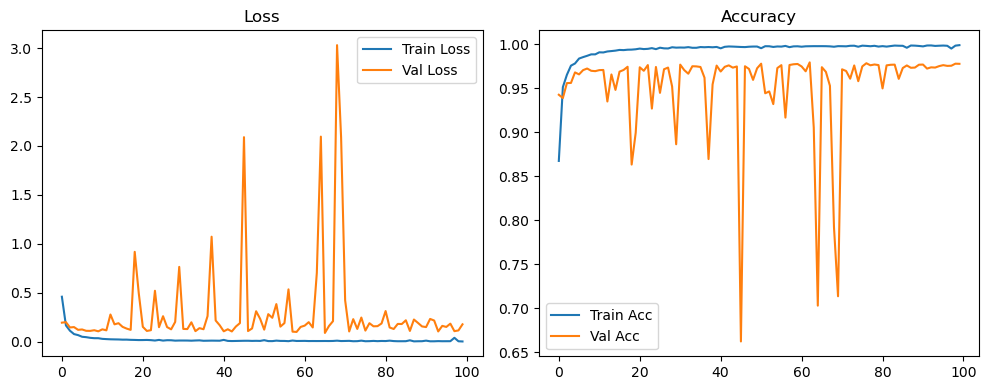

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5074, Acc: 0.8539 | Val Loss: 0.2308, Acc: 0.9302


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2345, Acc: 0.9307 | Val Loss: 0.1594, Acc: 0.9517


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1714, Acc: 0.9477 | Val Loss: 0.1472, Acc: 0.9572


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1396, Acc: 0.9577 | Val Loss: 0.1438, Acc: 0.9599


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9629 | Val Loss: 0.1087, Acc: 0.9675


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1034, Acc: 0.9676 | Val Loss: 0.1048, Acc: 0.9692


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9708 | Val Loss: 0.1173, Acc: 0.9678


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9753 | Val Loss: 0.1163, Acc: 0.9696


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9765 | Val Loss: 0.0962, Acc: 0.9714


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9780 | Val Loss: 0.1040, Acc: 0.9742


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0614, Acc: 0.9803 | Val Loss: 0.0937, Acc: 0.9733


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9810 | Val Loss: 0.0999, Acc: 0.9749


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9825 | Val Loss: 0.0929, Acc: 0.9748


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9842 | Val Loss: 0.1042, Acc: 0.9721


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9837 | Val Loss: 0.1041, Acc: 0.9759


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9850 | Val Loss: 0.0849, Acc: 0.9782


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9856 | Val Loss: 0.0831, Acc: 0.9773


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9869 | Val Loss: 0.1024, Acc: 0.9743


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9878 | Val Loss: 0.0926, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9872 | Val Loss: 0.1168, Acc: 0.9771


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9884 | Val Loss: 0.1127, Acc: 0.9749


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 0.1009, Acc: 0.9760


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9897 | Val Loss: 0.1714, Acc: 0.9702


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.0941, Acc: 0.9709


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.1267, Acc: 0.9766


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.1248, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0816, Acc: 0.9776


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9901 | Val Loss: 0.1262, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9903 | Val Loss: 0.1129, Acc: 0.9780


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9909 | Val Loss: 0.0955, Acc: 0.9760


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.1256, Acc: 0.9761


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1747, Acc: 0.9736


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9917 | Val Loss: 0.1184, Acc: 0.9756


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9915 | Val Loss: 0.0950, Acc: 0.9770


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0875, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.1168, Acc: 0.9779


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9930 | Val Loss: 0.1105, Acc: 0.9755


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.1296, Acc: 0.9777


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1193, Acc: 0.9782


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9929 | Val Loss: 0.1002, Acc: 0.9793


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.1018, Acc: 0.9780


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9938 | Val Loss: 0.0851, Acc: 0.9793


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1098, Acc: 0.9779


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.1108, Acc: 0.9776


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.1383, Acc: 0.9775


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.1263, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.1148, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9940 | Val Loss: 0.0903, Acc: 0.9791


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.0838, Acc: 0.9778


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.1243, Acc: 0.9784


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9946 | Val Loss: 0.0965, Acc: 0.9779


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9932 | Val Loss: 0.0836, Acc: 0.9783


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9948 | Val Loss: 0.1258, Acc: 0.9779


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9948 | Val Loss: 0.1590, Acc: 0.9786


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0940, Acc: 0.9792


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.1374, Acc: 0.9794


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0803, Acc: 0.9794


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9944 | Val Loss: 0.1353, Acc: 0.9791


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9949 | Val Loss: 0.1037, Acc: 0.9781


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0845, Acc: 0.9768


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.1038, Acc: 0.9798


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0870, Acc: 0.9797


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9952 | Val Loss: 0.1420, Acc: 0.9794


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0918, Acc: 0.9781


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.0915, Acc: 0.9789


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0756, Acc: 0.9786


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1121, Acc: 0.9772


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1067, Acc: 0.9792


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.1517, Acc: 0.9789


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9951 | Val Loss: 0.1204, Acc: 0.9789


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.1332, Acc: 0.9806


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.1539, Acc: 0.9798


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1571, Acc: 0.9792


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.1238, Acc: 0.9788


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0863, Acc: 0.9792


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0977, Acc: 0.9784


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9960 | Val Loss: 0.1313, Acc: 0.9778


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0945, Acc: 0.9762


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9954 | Val Loss: 0.1188, Acc: 0.9791


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1343, Acc: 0.9785


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.1051, Acc: 0.9797


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0913, Acc: 0.9792


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1511, Acc: 0.9798


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.1166, Acc: 0.9782


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.1800, Acc: 0.9797


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9966 | Val Loss: 0.1323, Acc: 0.9783


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0838, Acc: 0.9782


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.1022, Acc: 0.9792


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.1310, Acc: 0.9798


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1153, Acc: 0.9789


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1478, Acc: 0.9782


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1431, Acc: 0.9797


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9955 | Val Loss: 0.1689, Acc: 0.9792


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1131, Acc: 0.9794


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.2103, Acc: 0.9785


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9968 | Val Loss: 0.1381, Acc: 0.9791


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1485, Acc: 0.9781


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9967 | Val Loss: 0.1434, Acc: 0.9802


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9967 | Val Loss: 0.1099, Acc: 0.9798


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1630, Acc: 0.9772


Final Test Loss: 0.1466 Accuracy: 0.9799


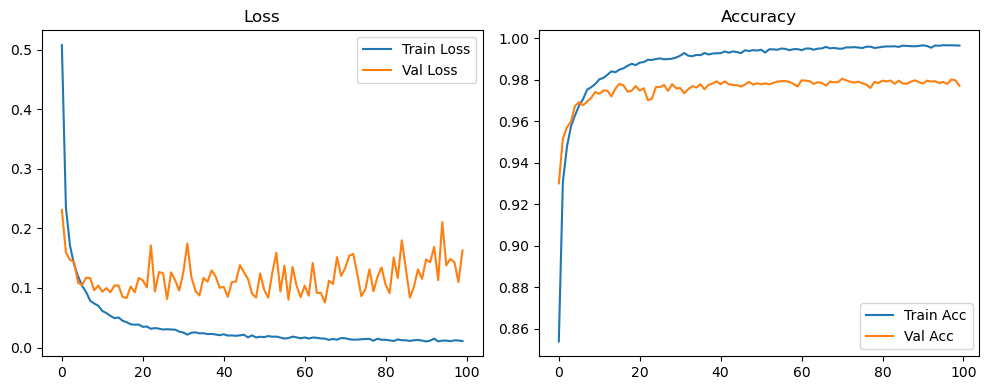

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6479, Acc: 0.8150 | Val Loss: 0.2965, Acc: 0.9143


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3390, Acc: 0.8988 | Val Loss: 0.2089, Acc: 0.9376


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2602, Acc: 0.9227 | Val Loss: 0.1815, Acc: 0.9444


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2203, Acc: 0.9351 | Val Loss: 0.1600, Acc: 0.9565


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1918, Acc: 0.9433 | Val Loss: 0.1345, Acc: 0.9626


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1717, Acc: 0.9473 | Val Loss: 0.1307, Acc: 0.9632


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1535, Acc: 0.9535 | Val Loss: 0.1218, Acc: 0.9646


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1359, Acc: 0.9581 | Val Loss: 0.1260, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1233, Acc: 0.9620 | Val Loss: 0.1086, Acc: 0.9697


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1182, Acc: 0.9640 | Val Loss: 0.0933, Acc: 0.9717


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1072, Acc: 0.9664 | Val Loss: 0.1041, Acc: 0.9703


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1024, Acc: 0.9678 | Val Loss: 0.0967, Acc: 0.9741


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0907, Acc: 0.9705 | Val Loss: 0.1012, Acc: 0.9718


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9723 | Val Loss: 0.1070, Acc: 0.9748


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9740 | Val Loss: 0.0961, Acc: 0.9739


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9754 | Val Loss: 0.0942, Acc: 0.9721


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9759 | Val Loss: 0.1006, Acc: 0.9731


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9790 | Val Loss: 0.0803, Acc: 0.9751


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9774 | Val Loss: 0.0901, Acc: 0.9751


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0667, Acc: 0.9787 | Val Loss: 0.1075, Acc: 0.9752


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9800 | Val Loss: 0.1109, Acc: 0.9756


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9812 | Val Loss: 0.0889, Acc: 0.9781


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9819 | Val Loss: 0.0887, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9828 | Val Loss: 0.1097, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9825 | Val Loss: 0.0946, Acc: 0.9763


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9828 | Val Loss: 0.0830, Acc: 0.9765


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9831 | Val Loss: 0.0944, Acc: 0.9784


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9835 | Val Loss: 0.0902, Acc: 0.9762


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9847 | Val Loss: 0.0914, Acc: 0.9776


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9846 | Val Loss: 0.1234, Acc: 0.9776


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9846 | Val Loss: 0.0897, Acc: 0.9791


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9853 | Val Loss: 0.0889, Acc: 0.9795


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9859 | Val Loss: 0.1060, Acc: 0.9796


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9866 | Val Loss: 0.0803, Acc: 0.9782


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.0777, Acc: 0.9802


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9859 | Val Loss: 0.0751, Acc: 0.9781


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9870 | Val Loss: 0.0926, Acc: 0.9769


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0940, Acc: 0.9793


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9874 | Val Loss: 0.0758, Acc: 0.9800


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9873 | Val Loss: 0.0800, Acc: 0.9798


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9878 | Val Loss: 0.0839, Acc: 0.9777


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9884 | Val Loss: 0.0971, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9884 | Val Loss: 0.0799, Acc: 0.9788


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 0.1351, Acc: 0.9786


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 0.1063, Acc: 0.9787


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9887 | Val Loss: 0.0816, Acc: 0.9786


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9888 | Val Loss: 0.0849, Acc: 0.9788


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9894 | Val Loss: 0.0714, Acc: 0.9785


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9906 | Val Loss: 0.0891, Acc: 0.9789


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.0928, Acc: 0.9801


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9899 | Val Loss: 0.1013, Acc: 0.9798


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9901 | Val Loss: 0.0906, Acc: 0.9791


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9893 | Val Loss: 0.1001, Acc: 0.9791


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9900 | Val Loss: 0.0737, Acc: 0.9794


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9905 | Val Loss: 0.0781, Acc: 0.9797


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9911 | Val Loss: 0.1053, Acc: 0.9797


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9901 | Val Loss: 0.0666, Acc: 0.9803


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0889, Acc: 0.9799


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9905 | Val Loss: 0.0725, Acc: 0.9800


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9916 | Val Loss: 0.0994, Acc: 0.9792


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9912 | Val Loss: 0.0767, Acc: 0.9792


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0781, Acc: 0.9802


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9907 | Val Loss: 0.0821, Acc: 0.9798


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9919 | Val Loss: 0.0709, Acc: 0.9803


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.1098, Acc: 0.9803


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0729, Acc: 0.9798


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 0.0993, Acc: 0.9798


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.0831, Acc: 0.9799


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9921 | Val Loss: 0.0924, Acc: 0.9802


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9921 | Val Loss: 0.0901, Acc: 0.9808


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9911 | Val Loss: 0.0744, Acc: 0.9809


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.1167, Acc: 0.9802


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9924 | Val Loss: 0.0957, Acc: 0.9802


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9920 | Val Loss: 0.0888, Acc: 0.9802


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.1024, Acc: 0.9808


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.0984, Acc: 0.9809


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9923 | Val Loss: 0.1095, Acc: 0.9811


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9921 | Val Loss: 0.0711, Acc: 0.9798


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9921 | Val Loss: 0.1105, Acc: 0.9802


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9917 | Val Loss: 0.1279, Acc: 0.9806


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9930 | Val Loss: 0.1072, Acc: 0.9813


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9922 | Val Loss: 0.0970, Acc: 0.9804


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9923 | Val Loss: 0.1311, Acc: 0.9805


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9926 | Val Loss: 0.0875, Acc: 0.9802


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9930 | Val Loss: 0.1035, Acc: 0.9812


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9933 | Val Loss: 0.0901, Acc: 0.9804


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9938 | Val Loss: 0.1337, Acc: 0.9812


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9931 | Val Loss: 0.1141, Acc: 0.9812


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9932 | Val Loss: 0.0902, Acc: 0.9817


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.0963, Acc: 0.9813


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9934 | Val Loss: 0.0989, Acc: 0.9796


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.0857, Acc: 0.9812


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.0827, Acc: 0.9814


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.0909, Acc: 0.9815


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9936 | Val Loss: 0.0909, Acc: 0.9810


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9939 | Val Loss: 0.0717, Acc: 0.9808


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9930 | Val Loss: 0.1193, Acc: 0.9798


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.1703, Acc: 0.9806


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9936 | Val Loss: 0.1290, Acc: 0.9802


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9935 | Val Loss: 0.0939, Acc: 0.9798


Final Test Loss: 0.0786 Accuracy: 0.9830


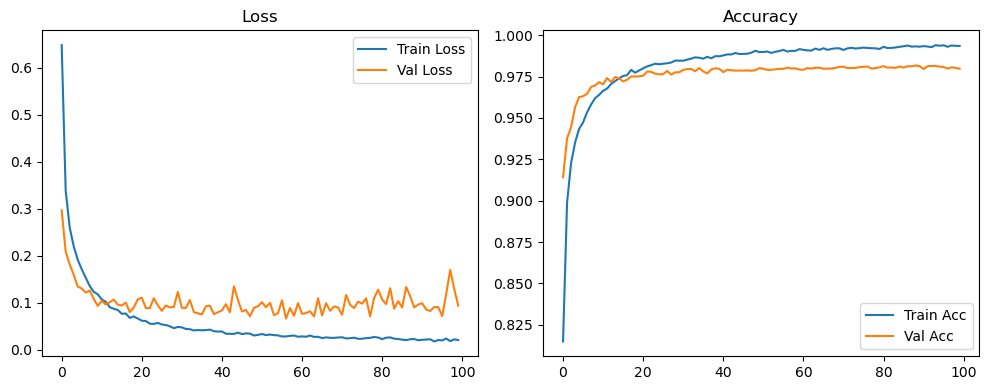

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4595, Acc: 0.8675 | Val Loss: 0.1944, Acc: 0.9427


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1660, Acc: 0.9514 | Val Loss: 0.1996, Acc: 0.9390


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1119, Acc: 0.9655 | Val Loss: 0.1452, Acc: 0.9560


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9758 | Val Loss: 0.1493, Acc: 0.9562


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9783 | Val Loss: 0.1212, Acc: 0.9682


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9839 | Val Loss: 0.1248, Acc: 0.9659


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9856 | Val Loss: 0.1112, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9870 | Val Loss: 0.1104, Acc: 0.9726


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9887 | Val Loss: 0.1171, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9887 | Val Loss: 0.1061, Acc: 0.9696


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9910 | Val Loss: 0.1262, Acc: 0.9708


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9909 | Val Loss: 0.1160, Acc: 0.9709


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.2776, Acc: 0.9351


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.1774, Acc: 0.9658


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.1889, Acc: 0.9483


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9937 | Val Loss: 0.1516, Acc: 0.9690


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9935 | Val Loss: 0.1340, Acc: 0.9709


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.1208, Acc: 0.9746


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.9181, Acc: 0.8633


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.4953, Acc: 0.8995


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9952 | Val Loss: 0.1519, Acc: 0.9740


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9947 | Val Loss: 0.1098, Acc: 0.9700


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1174, Acc: 0.9765


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.5203, Acc: 0.9270


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9946 | Val Loss: 0.1481, Acc: 0.9743


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.2603, Acc: 0.9449


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9955 | Val Loss: 0.1491, Acc: 0.9718


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.1263, Acc: 0.9737


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.2019, Acc: 0.9521


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.7644, Acc: 0.8864


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9965 | Val Loss: 0.1304, Acc: 0.9770


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1290, Acc: 0.9708


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1980, Acc: 0.9667


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1077, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.1384, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1273, Acc: 0.9743


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.2617, Acc: 0.9622


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 1.0728, Acc: 0.8696


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.2165, Acc: 0.9545


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1679, Acc: 0.9759


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9956 | Val Loss: 0.1062, Acc: 0.9692


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1268, Acc: 0.9745


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1046, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1549, Acc: 0.9736


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1898, Acc: 0.9749


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 2.0898, Acc: 0.6621


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1086, Acc: 0.9752


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1353, Acc: 0.9721


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.3111, Acc: 0.9597


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.2335, Acc: 0.9728


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1664, Acc: 0.9773


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1173, Acc: 0.9762


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1946, Acc: 0.9700


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.2124, Acc: 0.9767


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1753, Acc: 0.9768


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1757, Acc: 0.9718


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1815, Acc: 0.9782


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1723, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1917, Acc: 0.9788


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.2490, Acc: 0.9681


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1788, Acc: 0.9749


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1652, Acc: 0.9793


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1814, Acc: 0.9762


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1500, Acc: 0.9759


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1687, Acc: 0.9773


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1700, Acc: 0.9780


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1645, Acc: 0.9778


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1588, Acc: 0.9787


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1903, Acc: 0.9791


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1365, Acc: 0.9797


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.2213, Acc: 0.9798


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1712, Acc: 0.9782


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1398, Acc: 0.9788


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1957, Acc: 0.9776


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1759, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.2982, Acc: 0.9454


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1733, Acc: 0.9776


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1342, Acc: 0.9791


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1904, Acc: 0.9707


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1759, Acc: 0.9582


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1393, Acc: 0.9789


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1558, Acc: 0.9788


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1739, Acc: 0.9792


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1496, Acc: 0.9792


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2406, Acc: 0.9788


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1561, Acc: 0.9790


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1645, Acc: 0.9800


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1856, Acc: 0.9786


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2141, Acc: 0.9786


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2415, Acc: 0.9798


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1974, Acc: 0.9807


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.2029, Acc: 0.9793


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1560, Acc: 0.9800


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2148, Acc: 0.9809


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1249, Acc: 0.9795


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1581, Acc: 0.9808


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2149, Acc: 0.9805


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1820, Acc: 0.9762


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.2199, Acc: 0.9792


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1871, Acc: 0.9786


Final Test Loss: 0.1791 Accuracy: 0.9807


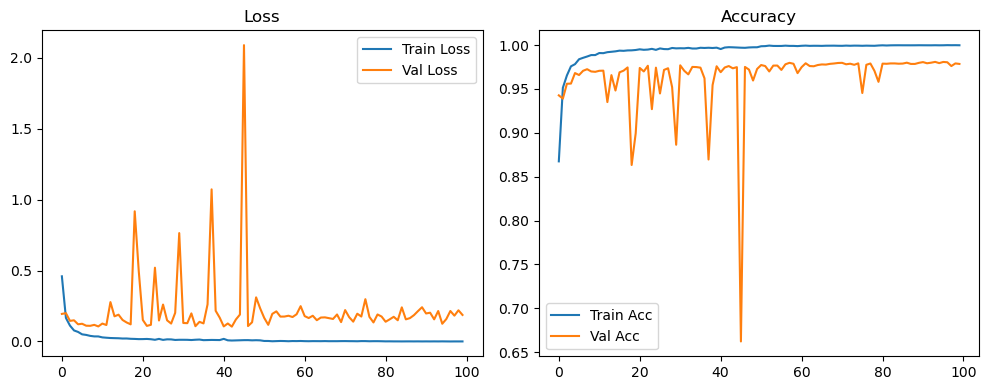

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5074, Acc: 0.8539 | Val Loss: 0.2308, Acc: 0.9302


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2345, Acc: 0.9307 | Val Loss: 0.1594, Acc: 0.9517


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1714, Acc: 0.9477 | Val Loss: 0.1472, Acc: 0.9572


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1396, Acc: 0.9577 | Val Loss: 0.1438, Acc: 0.9599


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9629 | Val Loss: 0.1087, Acc: 0.9675


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1034, Acc: 0.9676 | Val Loss: 0.1048, Acc: 0.9692


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9708 | Val Loss: 0.1173, Acc: 0.9678


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9753 | Val Loss: 0.1163, Acc: 0.9696


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9765 | Val Loss: 0.0962, Acc: 0.9714


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9780 | Val Loss: 0.1040, Acc: 0.9742


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0614, Acc: 0.9803 | Val Loss: 0.0937, Acc: 0.9733


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9810 | Val Loss: 0.0999, Acc: 0.9749


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9825 | Val Loss: 0.0929, Acc: 0.9748


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9842 | Val Loss: 0.1042, Acc: 0.9721


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9837 | Val Loss: 0.1041, Acc: 0.9759


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9850 | Val Loss: 0.0849, Acc: 0.9782


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9856 | Val Loss: 0.0831, Acc: 0.9773


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9869 | Val Loss: 0.1024, Acc: 0.9743


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9878 | Val Loss: 0.0926, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9872 | Val Loss: 0.1168, Acc: 0.9771


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9884 | Val Loss: 0.1127, Acc: 0.9749


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 0.1009, Acc: 0.9760


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9897 | Val Loss: 0.1714, Acc: 0.9702


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.0941, Acc: 0.9709


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.1267, Acc: 0.9766


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.1248, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0816, Acc: 0.9776


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9901 | Val Loss: 0.1262, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9903 | Val Loss: 0.1129, Acc: 0.9780


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9909 | Val Loss: 0.0955, Acc: 0.9760


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.1256, Acc: 0.9761


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1747, Acc: 0.9736


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9917 | Val Loss: 0.1184, Acc: 0.9756


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9915 | Val Loss: 0.0950, Acc: 0.9770


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0875, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.1168, Acc: 0.9779


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9930 | Val Loss: 0.1105, Acc: 0.9755


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.1296, Acc: 0.9777


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1193, Acc: 0.9782


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9929 | Val Loss: 0.1002, Acc: 0.9793


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.1018, Acc: 0.9780


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9938 | Val Loss: 0.0851, Acc: 0.9793


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1098, Acc: 0.9779


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.1108, Acc: 0.9776


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.1383, Acc: 0.9775


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.1263, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.1148, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9940 | Val Loss: 0.0903, Acc: 0.9791


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.0838, Acc: 0.9778


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.1243, Acc: 0.9784


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0858, Acc: 0.9792


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1320, Acc: 0.9795


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1218, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1157, Acc: 0.9788


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1313, Acc: 0.9800


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.1275, Acc: 0.9789


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1081, Acc: 0.9800


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.1217, Acc: 0.9805


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1220, Acc: 0.9797


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1188, Acc: 0.9792


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1281, Acc: 0.9796


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0925, Acc: 0.9794


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1319, Acc: 0.9802


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1496, Acc: 0.9806


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1192, Acc: 0.9801


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1440, Acc: 0.9810


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1155, Acc: 0.9805


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0875, Acc: 0.9804


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1215, Acc: 0.9804


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1292, Acc: 0.9801


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1170, Acc: 0.9814


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1213, Acc: 0.9801


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1364, Acc: 0.9807


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1408, Acc: 0.9798


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0988, Acc: 0.9815


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1092, Acc: 0.9810


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9980 | Val Loss: 0.1128, Acc: 0.9799


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1320, Acc: 0.9798


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1233, Acc: 0.9813


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1495, Acc: 0.9817


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1012, Acc: 0.9809


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1194, Acc: 0.9815


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0926, Acc: 0.9813


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1016, Acc: 0.9812


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1383, Acc: 0.9816


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1424, Acc: 0.9812


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1385, Acc: 0.9808


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1399, Acc: 0.9820


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1337, Acc: 0.9818


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1119, Acc: 0.9826


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1215, Acc: 0.9820


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1211, Acc: 0.9820


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1156, Acc: 0.9821


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1633, Acc: 0.9817


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1133, Acc: 0.9820


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1176, Acc: 0.9823


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1447, Acc: 0.9817


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1269, Acc: 0.9823


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1106, Acc: 0.9823


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0783, Acc: 0.9808


Final Test Loss: 0.0725 Accuracy: 0.9823


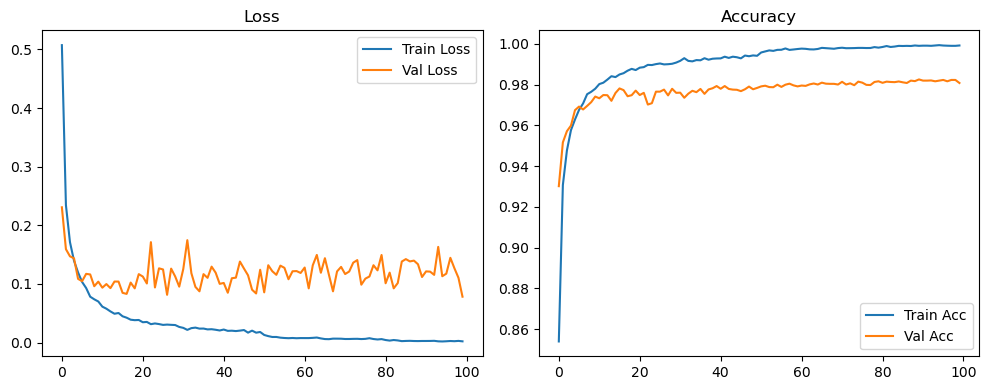

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6479, Acc: 0.8150 | Val Loss: 0.2965, Acc: 0.9143


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3390, Acc: 0.8988 | Val Loss: 0.2089, Acc: 0.9376


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2602, Acc: 0.9227 | Val Loss: 0.1815, Acc: 0.9444


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2203, Acc: 0.9351 | Val Loss: 0.1600, Acc: 0.9565


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1918, Acc: 0.9433 | Val Loss: 0.1345, Acc: 0.9626


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1717, Acc: 0.9473 | Val Loss: 0.1307, Acc: 0.9632


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1535, Acc: 0.9535 | Val Loss: 0.1218, Acc: 0.9646


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1359, Acc: 0.9581 | Val Loss: 0.1260, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1233, Acc: 0.9620 | Val Loss: 0.1086, Acc: 0.9697


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1182, Acc: 0.9640 | Val Loss: 0.0933, Acc: 0.9717


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1072, Acc: 0.9664 | Val Loss: 0.1041, Acc: 0.9703


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1024, Acc: 0.9678 | Val Loss: 0.0967, Acc: 0.9741


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0907, Acc: 0.9705 | Val Loss: 0.1012, Acc: 0.9718


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9723 | Val Loss: 0.1070, Acc: 0.9748


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9740 | Val Loss: 0.0961, Acc: 0.9739


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9754 | Val Loss: 0.0942, Acc: 0.9721


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9759 | Val Loss: 0.1006, Acc: 0.9731


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9790 | Val Loss: 0.0803, Acc: 0.9751


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9774 | Val Loss: 0.0901, Acc: 0.9751


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0667, Acc: 0.9787 | Val Loss: 0.1075, Acc: 0.9752


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9800 | Val Loss: 0.1109, Acc: 0.9756


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9812 | Val Loss: 0.0889, Acc: 0.9781


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9819 | Val Loss: 0.0887, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9828 | Val Loss: 0.1097, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9825 | Val Loss: 0.0946, Acc: 0.9763


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9828 | Val Loss: 0.0830, Acc: 0.9765


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9831 | Val Loss: 0.0944, Acc: 0.9784


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9835 | Val Loss: 0.0902, Acc: 0.9762


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9847 | Val Loss: 0.0914, Acc: 0.9776


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9846 | Val Loss: 0.1234, Acc: 0.9776


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9846 | Val Loss: 0.0897, Acc: 0.9791


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9853 | Val Loss: 0.0889, Acc: 0.9795


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9859 | Val Loss: 0.1060, Acc: 0.9796


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9866 | Val Loss: 0.0803, Acc: 0.9782


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.0777, Acc: 0.9802


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9859 | Val Loss: 0.0751, Acc: 0.9781


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9870 | Val Loss: 0.0926, Acc: 0.9769


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0940, Acc: 0.9793


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9874 | Val Loss: 0.0758, Acc: 0.9800


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9873 | Val Loss: 0.0800, Acc: 0.9798


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9878 | Val Loss: 0.0839, Acc: 0.9777


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9884 | Val Loss: 0.0971, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9884 | Val Loss: 0.0799, Acc: 0.9788


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 0.1351, Acc: 0.9786


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 0.1063, Acc: 0.9787


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9887 | Val Loss: 0.0816, Acc: 0.9786


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9888 | Val Loss: 0.0849, Acc: 0.9788


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9894 | Val Loss: 0.0714, Acc: 0.9785


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9906 | Val Loss: 0.0891, Acc: 0.9789


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.0928, Acc: 0.9801


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.1021, Acc: 0.9802


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9921 | Val Loss: 0.0796, Acc: 0.9795


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.0971, Acc: 0.9807


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.0944, Acc: 0.9807


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.0908, Acc: 0.9804


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1011, Acc: 0.9800


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0954, Acc: 0.9788


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.1095, Acc: 0.9815


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0744, Acc: 0.9796


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9953 | Val Loss: 0.0940, Acc: 0.9810


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9950 | Val Loss: 0.1098, Acc: 0.9796


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1118, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.0890, Acc: 0.9800


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.1046, Acc: 0.9809


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.1100, Acc: 0.9808


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.1145, Acc: 0.9803


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0897, Acc: 0.9807


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.0944, Acc: 0.9810


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9946 | Val Loss: 0.1119, Acc: 0.9818


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.1063, Acc: 0.9802


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1057, Acc: 0.9815


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.0845, Acc: 0.9800


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.0988, Acc: 0.9810


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0760, Acc: 0.9805


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.1205, Acc: 0.9803


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1103, Acc: 0.9802


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1087, Acc: 0.9812


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0732, Acc: 0.9802


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.1169, Acc: 0.9810


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.0924, Acc: 0.9810


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0944, Acc: 0.9818


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0856, Acc: 0.9819


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9961 | Val Loss: 0.1058, Acc: 0.9814


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0887, Acc: 0.9813


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0960, Acc: 0.9813


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1070, Acc: 0.9808


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1107, Acc: 0.9812


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0879, Acc: 0.9811


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0955, Acc: 0.9819


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1186, Acc: 0.9819


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0965, Acc: 0.9817


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.0876, Acc: 0.9823


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1061, Acc: 0.9813


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.1071, Acc: 0.9815


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0923, Acc: 0.9815


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1149, Acc: 0.9818


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.1124, Acc: 0.9824


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1103, Acc: 0.9822


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1037, Acc: 0.9820


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0952, Acc: 0.9819


Final Test Loss: 0.0833 Accuracy: 0.9838


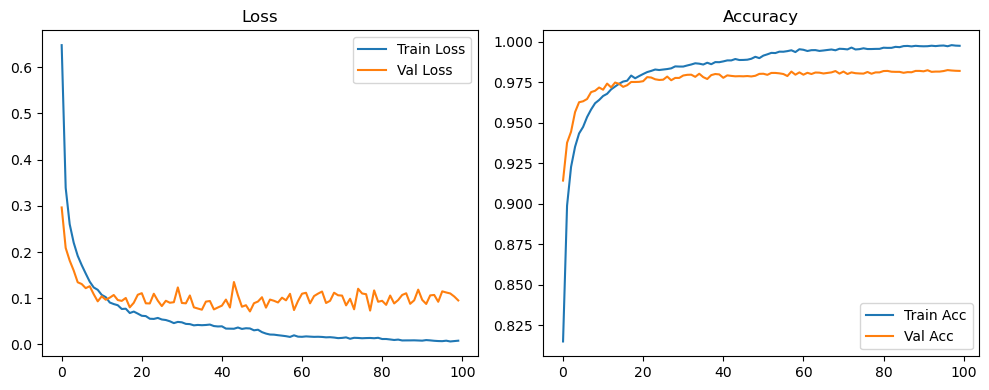

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4595, Acc: 0.8675 | Val Loss: 0.1944, Acc: 0.9427


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1660, Acc: 0.9514 | Val Loss: 0.1996, Acc: 0.9390


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1119, Acc: 0.9655 | Val Loss: 0.1452, Acc: 0.9560


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9758 | Val Loss: 0.1493, Acc: 0.9562


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9783 | Val Loss: 0.1212, Acc: 0.9682


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9839 | Val Loss: 0.1248, Acc: 0.9659


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9856 | Val Loss: 0.1112, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9870 | Val Loss: 0.1104, Acc: 0.9726


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9887 | Val Loss: 0.1171, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9887 | Val Loss: 0.1061, Acc: 0.9696


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9910 | Val Loss: 0.1262, Acc: 0.9708


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9909 | Val Loss: 0.1160, Acc: 0.9709


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.2776, Acc: 0.9351


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.1774, Acc: 0.9658


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.1889, Acc: 0.9483


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9937 | Val Loss: 0.1516, Acc: 0.9690


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9935 | Val Loss: 0.1340, Acc: 0.9709


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.1208, Acc: 0.9746


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.9181, Acc: 0.8633


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.4953, Acc: 0.8995


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9952 | Val Loss: 0.1519, Acc: 0.9740


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9947 | Val Loss: 0.1098, Acc: 0.9700


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1174, Acc: 0.9765


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.5203, Acc: 0.9270


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9946 | Val Loss: 0.1481, Acc: 0.9743


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.2603, Acc: 0.9449


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9955 | Val Loss: 0.1491, Acc: 0.9718


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.1263, Acc: 0.9737


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.2019, Acc: 0.9521


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.7644, Acc: 0.8864


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9965 | Val Loss: 0.1304, Acc: 0.9770


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1290, Acc: 0.9708


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1980, Acc: 0.9667


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1077, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.1384, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1273, Acc: 0.9743


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.2617, Acc: 0.9622


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 1.0728, Acc: 0.8696


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.2165, Acc: 0.9545


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1679, Acc: 0.9759


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9956 | Val Loss: 0.1062, Acc: 0.9692


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1268, Acc: 0.9745


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1046, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1549, Acc: 0.9736


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1898, Acc: 0.9749


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 2.0898, Acc: 0.6621


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1086, Acc: 0.9752


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1353, Acc: 0.9721


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.3111, Acc: 0.9597


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.2335, Acc: 0.9728


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1664, Acc: 0.9773


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1173, Acc: 0.9762


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1946, Acc: 0.9700


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.2124, Acc: 0.9767


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1753, Acc: 0.9768


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1757, Acc: 0.9718


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1815, Acc: 0.9782


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1723, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1917, Acc: 0.9788


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.2490, Acc: 0.9681


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1788, Acc: 0.9749


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1652, Acc: 0.9793


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1814, Acc: 0.9762


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1500, Acc: 0.9759


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1687, Acc: 0.9773


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1700, Acc: 0.9780


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1645, Acc: 0.9778


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1588, Acc: 0.9787


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1903, Acc: 0.9791


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1365, Acc: 0.9797


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.2213, Acc: 0.9798


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1712, Acc: 0.9782


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1398, Acc: 0.9788


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1957, Acc: 0.9776


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1759, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.2982, Acc: 0.9454


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1733, Acc: 0.9776


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1342, Acc: 0.9791


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1904, Acc: 0.9707


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1759, Acc: 0.9582


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1297, Acc: 0.9793


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1289, Acc: 0.9793


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1682, Acc: 0.9800


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1481, Acc: 0.9798


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1740, Acc: 0.9797


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1574, Acc: 0.9797


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1208, Acc: 0.9797


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1756, Acc: 0.9803


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1632, Acc: 0.9802


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1919, Acc: 0.9808


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2086, Acc: 0.9800


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2026, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1498, Acc: 0.9794


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1802, Acc: 0.9802


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1823, Acc: 0.9790


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2078, Acc: 0.9801


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2582, Acc: 0.9809


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2858, Acc: 0.9801


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2091, Acc: 0.9798


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2040, Acc: 0.9799


Final Test Loss: 0.1759 Accuracy: 0.9829


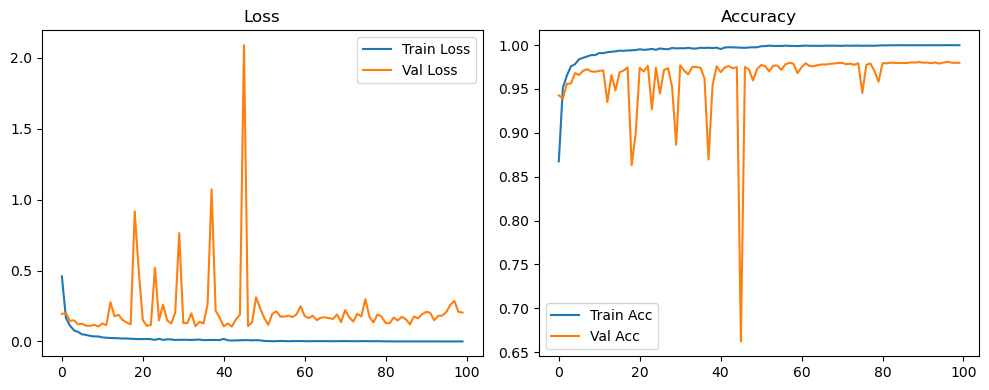

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5074, Acc: 0.8539 | Val Loss: 0.2308, Acc: 0.9302


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2345, Acc: 0.9307 | Val Loss: 0.1594, Acc: 0.9517


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1714, Acc: 0.9477 | Val Loss: 0.1472, Acc: 0.9572


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1396, Acc: 0.9577 | Val Loss: 0.1438, Acc: 0.9599


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9629 | Val Loss: 0.1087, Acc: 0.9675


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1034, Acc: 0.9676 | Val Loss: 0.1048, Acc: 0.9692


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9708 | Val Loss: 0.1173, Acc: 0.9678


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9753 | Val Loss: 0.1163, Acc: 0.9696


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9765 | Val Loss: 0.0962, Acc: 0.9714


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9780 | Val Loss: 0.1040, Acc: 0.9742


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0614, Acc: 0.9803 | Val Loss: 0.0937, Acc: 0.9733


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9810 | Val Loss: 0.0999, Acc: 0.9749


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9825 | Val Loss: 0.0929, Acc: 0.9748


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9842 | Val Loss: 0.1042, Acc: 0.9721


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9837 | Val Loss: 0.1041, Acc: 0.9759


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9850 | Val Loss: 0.0849, Acc: 0.9782


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9856 | Val Loss: 0.0831, Acc: 0.9773


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9869 | Val Loss: 0.1024, Acc: 0.9743


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9878 | Val Loss: 0.0926, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9872 | Val Loss: 0.1168, Acc: 0.9771


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9884 | Val Loss: 0.1127, Acc: 0.9749


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 0.1009, Acc: 0.9760


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9897 | Val Loss: 0.1714, Acc: 0.9702


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.0941, Acc: 0.9709


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.1267, Acc: 0.9766


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.1248, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0816, Acc: 0.9776


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9901 | Val Loss: 0.1262, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9903 | Val Loss: 0.1129, Acc: 0.9780


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9909 | Val Loss: 0.0955, Acc: 0.9760


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.1256, Acc: 0.9761


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1747, Acc: 0.9736


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9917 | Val Loss: 0.1184, Acc: 0.9756


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9915 | Val Loss: 0.0950, Acc: 0.9770


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0875, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.1168, Acc: 0.9779


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9930 | Val Loss: 0.1105, Acc: 0.9755


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.1296, Acc: 0.9777


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1193, Acc: 0.9782


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9929 | Val Loss: 0.1002, Acc: 0.9793


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.1018, Acc: 0.9780


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9938 | Val Loss: 0.0851, Acc: 0.9793


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1098, Acc: 0.9779


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.1108, Acc: 0.9776


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.1383, Acc: 0.9775


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.1263, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.1148, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9940 | Val Loss: 0.0903, Acc: 0.9791


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.0838, Acc: 0.9778


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.1243, Acc: 0.9784


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0858, Acc: 0.9792


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1320, Acc: 0.9795


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1218, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1157, Acc: 0.9788


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1313, Acc: 0.9800


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.1275, Acc: 0.9789


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1081, Acc: 0.9800


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.1217, Acc: 0.9805


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1220, Acc: 0.9797


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1188, Acc: 0.9792


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1281, Acc: 0.9796


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0925, Acc: 0.9794


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1319, Acc: 0.9802


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1496, Acc: 0.9806


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1192, Acc: 0.9801


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1440, Acc: 0.9810


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1155, Acc: 0.9805


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0875, Acc: 0.9804


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1215, Acc: 0.9804


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1292, Acc: 0.9801


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1170, Acc: 0.9814


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1213, Acc: 0.9801


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1364, Acc: 0.9807


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1408, Acc: 0.9798


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0988, Acc: 0.9815


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1092, Acc: 0.9810


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9980 | Val Loss: 0.1128, Acc: 0.9799


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1320, Acc: 0.9798


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1233, Acc: 0.9813


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1495, Acc: 0.9817


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1006, Acc: 0.9812


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1191, Acc: 0.9814


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0903, Acc: 0.9817


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1156, Acc: 0.9816


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1315, Acc: 0.9811


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9990 | Val Loss: 0.1329, Acc: 0.9814


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1181, Acc: 0.9814


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1340, Acc: 0.9816


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1298, Acc: 0.9814


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1155, Acc: 0.9818


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1197, Acc: 0.9821


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1166, Acc: 0.9818


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1187, Acc: 0.9813


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1197, Acc: 0.9823


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1231, Acc: 0.9818


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1170, Acc: 0.9829


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1293, Acc: 0.9822


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1287, Acc: 0.9818


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1190, Acc: 0.9818


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0969, Acc: 0.9813


Final Test Loss: 0.0902 Accuracy: 0.9828


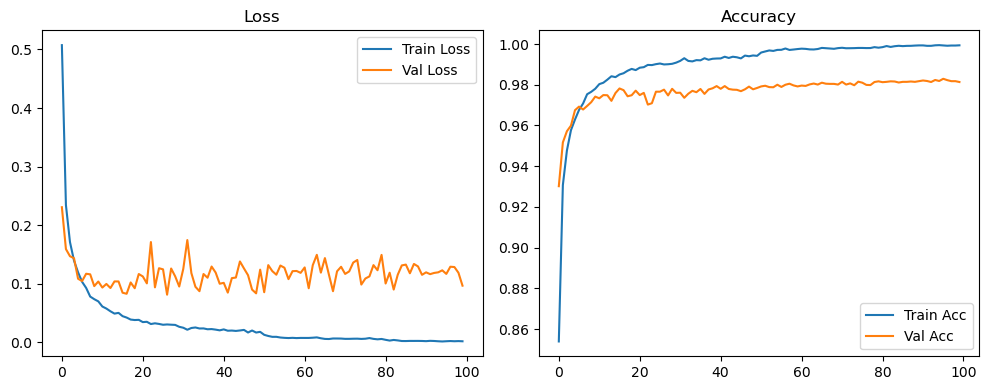

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6479, Acc: 0.8150 | Val Loss: 0.2965, Acc: 0.9143


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3390, Acc: 0.8988 | Val Loss: 0.2089, Acc: 0.9376


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2602, Acc: 0.9227 | Val Loss: 0.1815, Acc: 0.9444


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2203, Acc: 0.9351 | Val Loss: 0.1600, Acc: 0.9565


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1918, Acc: 0.9433 | Val Loss: 0.1345, Acc: 0.9626


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1717, Acc: 0.9473 | Val Loss: 0.1307, Acc: 0.9632


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1535, Acc: 0.9535 | Val Loss: 0.1218, Acc: 0.9646


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1359, Acc: 0.9581 | Val Loss: 0.1260, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1233, Acc: 0.9620 | Val Loss: 0.1086, Acc: 0.9697


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1182, Acc: 0.9640 | Val Loss: 0.0933, Acc: 0.9717


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1072, Acc: 0.9664 | Val Loss: 0.1041, Acc: 0.9703


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1024, Acc: 0.9678 | Val Loss: 0.0967, Acc: 0.9741


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0907, Acc: 0.9705 | Val Loss: 0.1012, Acc: 0.9718


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9723 | Val Loss: 0.1070, Acc: 0.9748


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9740 | Val Loss: 0.0961, Acc: 0.9739


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9754 | Val Loss: 0.0942, Acc: 0.9721


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9759 | Val Loss: 0.1006, Acc: 0.9731


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9790 | Val Loss: 0.0803, Acc: 0.9751


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9774 | Val Loss: 0.0901, Acc: 0.9751


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0667, Acc: 0.9787 | Val Loss: 0.1075, Acc: 0.9752


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9800 | Val Loss: 0.1109, Acc: 0.9756


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9812 | Val Loss: 0.0889, Acc: 0.9781


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9819 | Val Loss: 0.0887, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9828 | Val Loss: 0.1097, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9825 | Val Loss: 0.0946, Acc: 0.9763


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9828 | Val Loss: 0.0830, Acc: 0.9765


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9831 | Val Loss: 0.0944, Acc: 0.9784


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9835 | Val Loss: 0.0902, Acc: 0.9762


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9847 | Val Loss: 0.0914, Acc: 0.9776


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9846 | Val Loss: 0.1234, Acc: 0.9776


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9846 | Val Loss: 0.0897, Acc: 0.9791


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9853 | Val Loss: 0.0889, Acc: 0.9795


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9859 | Val Loss: 0.1060, Acc: 0.9796


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9866 | Val Loss: 0.0803, Acc: 0.9782


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.0777, Acc: 0.9802


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9859 | Val Loss: 0.0751, Acc: 0.9781


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9870 | Val Loss: 0.0926, Acc: 0.9769


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0940, Acc: 0.9793


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9874 | Val Loss: 0.0758, Acc: 0.9800


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9873 | Val Loss: 0.0800, Acc: 0.9798


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9878 | Val Loss: 0.0839, Acc: 0.9777


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9884 | Val Loss: 0.0971, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9884 | Val Loss: 0.0799, Acc: 0.9788


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 0.1351, Acc: 0.9786


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 0.1063, Acc: 0.9787


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9887 | Val Loss: 0.0816, Acc: 0.9786


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9888 | Val Loss: 0.0849, Acc: 0.9788


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9894 | Val Loss: 0.0714, Acc: 0.9785


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9906 | Val Loss: 0.0891, Acc: 0.9789


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.0928, Acc: 0.9801


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.1021, Acc: 0.9802


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9921 | Val Loss: 0.0796, Acc: 0.9795


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.0971, Acc: 0.9807


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.0944, Acc: 0.9807


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.0908, Acc: 0.9804


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1011, Acc: 0.9800


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0954, Acc: 0.9788


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.1095, Acc: 0.9815


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0744, Acc: 0.9796


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9953 | Val Loss: 0.0940, Acc: 0.9810


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9950 | Val Loss: 0.1098, Acc: 0.9796


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1118, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.0890, Acc: 0.9800


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.1046, Acc: 0.9809


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.1100, Acc: 0.9808


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.1145, Acc: 0.9803


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0897, Acc: 0.9807


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.0944, Acc: 0.9810


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9946 | Val Loss: 0.1119, Acc: 0.9818


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.1063, Acc: 0.9802


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1057, Acc: 0.9815


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.0845, Acc: 0.9800


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.0988, Acc: 0.9810


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0760, Acc: 0.9805


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.1205, Acc: 0.9803


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1103, Acc: 0.9802


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1087, Acc: 0.9812


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0732, Acc: 0.9802


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.1169, Acc: 0.9810


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.0924, Acc: 0.9810


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0966, Acc: 0.9812


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0977, Acc: 0.9812


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.1074, Acc: 0.9822


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.0841, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0930, Acc: 0.9810


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0995, Acc: 0.9810


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0932, Acc: 0.9815


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0876, Acc: 0.9817


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0910, Acc: 0.9811


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.0996, Acc: 0.9816


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9970 | Val Loss: 0.0906, Acc: 0.9817


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0887, Acc: 0.9821


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0985, Acc: 0.9818


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0961, Acc: 0.9810


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1092, Acc: 0.9816


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1048, Acc: 0.9814


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0982, Acc: 0.9814


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1077, Acc: 0.9819


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1049, Acc: 0.9821


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0911, Acc: 0.9822


Final Test Loss: 0.0830 Accuracy: 0.9845


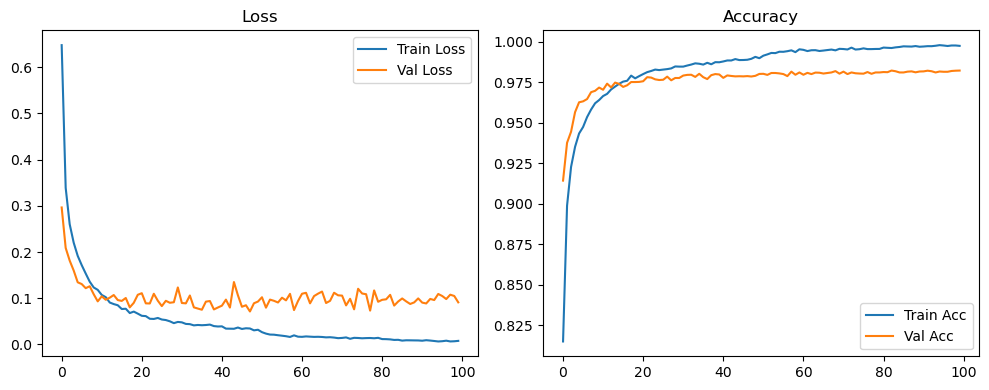

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4595, Acc: 0.8675 | Val Loss: 0.1944, Acc: 0.9427


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1660, Acc: 0.9514 | Val Loss: 0.1996, Acc: 0.9390


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1119, Acc: 0.9655 | Val Loss: 0.1452, Acc: 0.9560


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9758 | Val Loss: 0.1493, Acc: 0.9562


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9783 | Val Loss: 0.1212, Acc: 0.9682


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9839 | Val Loss: 0.1248, Acc: 0.9659


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9856 | Val Loss: 0.1112, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9870 | Val Loss: 0.1104, Acc: 0.9726


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9887 | Val Loss: 0.1171, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9887 | Val Loss: 0.1061, Acc: 0.9696


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9910 | Val Loss: 0.1262, Acc: 0.9708


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9909 | Val Loss: 0.1160, Acc: 0.9709


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.2776, Acc: 0.9351


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.1774, Acc: 0.9658


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.1889, Acc: 0.9483


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9937 | Val Loss: 0.1516, Acc: 0.9690


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9935 | Val Loss: 0.1340, Acc: 0.9709


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.1208, Acc: 0.9746


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.9181, Acc: 0.8633


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.4953, Acc: 0.8995


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9952 | Val Loss: 0.1519, Acc: 0.9740


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9947 | Val Loss: 0.1098, Acc: 0.9700


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1174, Acc: 0.9765


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.5203, Acc: 0.9270


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9946 | Val Loss: 0.1481, Acc: 0.9743


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.2603, Acc: 0.9449


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9955 | Val Loss: 0.1491, Acc: 0.9718


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.1263, Acc: 0.9737


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.2019, Acc: 0.9521


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.7644, Acc: 0.8864


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9965 | Val Loss: 0.1304, Acc: 0.9770


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1290, Acc: 0.9708


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1980, Acc: 0.9667


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1077, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.1384, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1273, Acc: 0.9743


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.2617, Acc: 0.9622


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 1.0728, Acc: 0.8696


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.2165, Acc: 0.9545


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1679, Acc: 0.9759


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9956 | Val Loss: 0.1062, Acc: 0.9692


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1268, Acc: 0.9745


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1046, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1549, Acc: 0.9736


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1898, Acc: 0.9749


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 2.0898, Acc: 0.6621


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1086, Acc: 0.9752


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1353, Acc: 0.9721


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.3111, Acc: 0.9597


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.2335, Acc: 0.9728


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1242, Acc: 0.9796


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1390, Acc: 0.9774


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1402, Acc: 0.9795


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1566, Acc: 0.9794


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1813, Acc: 0.9798


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1672, Acc: 0.9791


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1759, Acc: 0.9792


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1975, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1772, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1513, Acc: 0.9799


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1689, Acc: 0.9788


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1779, Acc: 0.9799


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1570, Acc: 0.9795


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1821, Acc: 0.9796


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1756, Acc: 0.9796


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1397, Acc: 0.9802


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1653, Acc: 0.9805


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1472, Acc: 0.9790


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1609, Acc: 0.9800


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1748, Acc: 0.9792


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1976, Acc: 0.9794


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1954, Acc: 0.9798


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2153, Acc: 0.9809


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2310, Acc: 0.9773


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1511, Acc: 0.9803


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1554, Acc: 0.9809


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1713, Acc: 0.9799


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1285, Acc: 0.9807


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2369, Acc: 0.9810


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1719, Acc: 0.9803


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1327, Acc: 0.9815


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1730, Acc: 0.9811


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1700, Acc: 0.9819


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1870, Acc: 0.9814


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1553, Acc: 0.9812


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1720, Acc: 0.9795


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1958, Acc: 0.9810


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1280, Acc: 0.9805


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1577, Acc: 0.9803


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1909, Acc: 0.9814


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1756, Acc: 0.9812


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1773, Acc: 0.9805


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1860, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1708, Acc: 0.9816


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1515, Acc: 0.9811


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1623, Acc: 0.9811


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1588, Acc: 0.9820


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1583, Acc: 0.9817


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1728, Acc: 0.9812


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2135, Acc: 0.9807


Final Test Loss: 0.1952 Accuracy: 0.9819


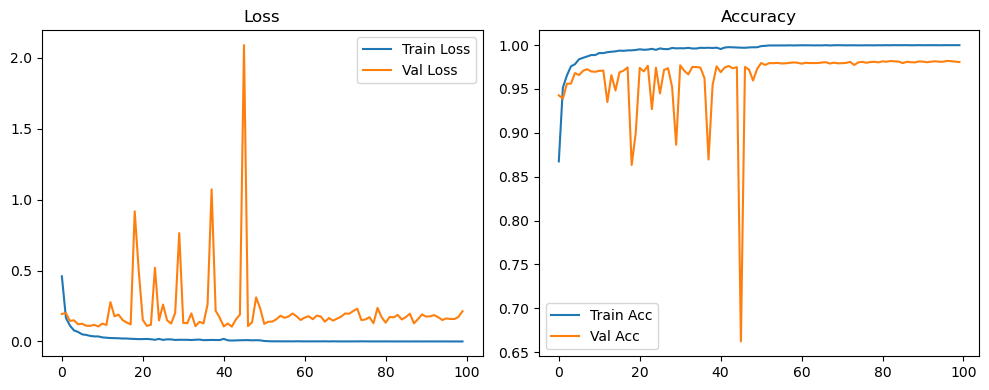

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5074, Acc: 0.8539 | Val Loss: 0.2308, Acc: 0.9302


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2345, Acc: 0.9307 | Val Loss: 0.1594, Acc: 0.9517


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1714, Acc: 0.9477 | Val Loss: 0.1472, Acc: 0.9572


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1396, Acc: 0.9577 | Val Loss: 0.1438, Acc: 0.9599


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9629 | Val Loss: 0.1087, Acc: 0.9675


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1034, Acc: 0.9676 | Val Loss: 0.1048, Acc: 0.9692


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9708 | Val Loss: 0.1173, Acc: 0.9678


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9753 | Val Loss: 0.1163, Acc: 0.9696


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9765 | Val Loss: 0.0962, Acc: 0.9714


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9780 | Val Loss: 0.1040, Acc: 0.9742


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0614, Acc: 0.9803 | Val Loss: 0.0937, Acc: 0.9733


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9810 | Val Loss: 0.0999, Acc: 0.9749


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9825 | Val Loss: 0.0929, Acc: 0.9748


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9842 | Val Loss: 0.1042, Acc: 0.9721


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9837 | Val Loss: 0.1041, Acc: 0.9759


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9850 | Val Loss: 0.0849, Acc: 0.9782


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9856 | Val Loss: 0.0831, Acc: 0.9773


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9869 | Val Loss: 0.1024, Acc: 0.9743


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9878 | Val Loss: 0.0926, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9872 | Val Loss: 0.1168, Acc: 0.9771


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9884 | Val Loss: 0.1127, Acc: 0.9749


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 0.1009, Acc: 0.9760


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9897 | Val Loss: 0.1714, Acc: 0.9702


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.0941, Acc: 0.9709


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.1267, Acc: 0.9766


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.1248, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0816, Acc: 0.9776


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9901 | Val Loss: 0.1262, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9903 | Val Loss: 0.1129, Acc: 0.9780


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9909 | Val Loss: 0.0955, Acc: 0.9760


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.1256, Acc: 0.9761


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1747, Acc: 0.9736


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9917 | Val Loss: 0.1184, Acc: 0.9756


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9915 | Val Loss: 0.0950, Acc: 0.9770


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0875, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.1168, Acc: 0.9779


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9930 | Val Loss: 0.1105, Acc: 0.9755


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.1296, Acc: 0.9777


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1193, Acc: 0.9782


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9929 | Val Loss: 0.1002, Acc: 0.9793


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.1018, Acc: 0.9780


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9938 | Val Loss: 0.0851, Acc: 0.9793


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1098, Acc: 0.9779


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.1108, Acc: 0.9776


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.1383, Acc: 0.9775


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.1263, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.1148, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9940 | Val Loss: 0.0903, Acc: 0.9791


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.0838, Acc: 0.9778


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.1243, Acc: 0.9784


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0850, Acc: 0.9798


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1230, Acc: 0.9798


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1291, Acc: 0.9798


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0984, Acc: 0.9803


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1147, Acc: 0.9803


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1074, Acc: 0.9802


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1119, Acc: 0.9805


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1197, Acc: 0.9801


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1055, Acc: 0.9806


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1073, Acc: 0.9798


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1208, Acc: 0.9805


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0991, Acc: 0.9800


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1254, Acc: 0.9798


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.0972, Acc: 0.9806


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1268, Acc: 0.9805


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1333, Acc: 0.9808


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1289, Acc: 0.9815


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1357, Acc: 0.9815


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1359, Acc: 0.9810


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1183, Acc: 0.9809


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1164, Acc: 0.9819


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1098, Acc: 0.9801


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1160, Acc: 0.9804


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1294, Acc: 0.9819


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1103, Acc: 0.9808


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1326, Acc: 0.9808


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1354, Acc: 0.9818


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1208, Acc: 0.9812


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1192, Acc: 0.9810


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1222, Acc: 0.9815


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.1011, Acc: 0.9817


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1152, Acc: 0.9817


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0988, Acc: 0.9811


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1167, Acc: 0.9817


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1154, Acc: 0.9814


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1248, Acc: 0.9819


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1376, Acc: 0.9816


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1138, Acc: 0.9822


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1227, Acc: 0.9818


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1117, Acc: 0.9817


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1172, Acc: 0.9811


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1317, Acc: 0.9822


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1187, Acc: 0.9821


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1302, Acc: 0.9817


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1418, Acc: 0.9822


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1297, Acc: 0.9813


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1059, Acc: 0.9821


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1479, Acc: 0.9812


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1282, Acc: 0.9822


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0972, Acc: 0.9818


Final Test Loss: 0.0870 Accuracy: 0.9832


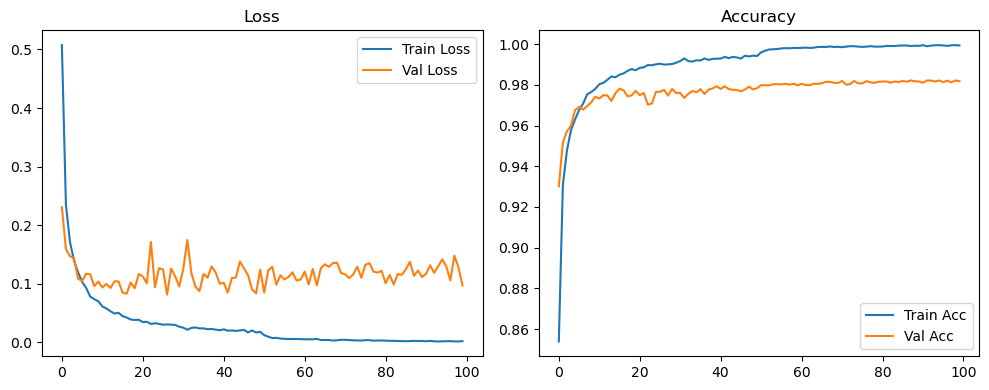

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6479, Acc: 0.8150 | Val Loss: 0.2965, Acc: 0.9143


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3390, Acc: 0.8988 | Val Loss: 0.2089, Acc: 0.9376


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2602, Acc: 0.9227 | Val Loss: 0.1815, Acc: 0.9444


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2203, Acc: 0.9351 | Val Loss: 0.1600, Acc: 0.9565


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1918, Acc: 0.9433 | Val Loss: 0.1345, Acc: 0.9626


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1717, Acc: 0.9473 | Val Loss: 0.1307, Acc: 0.9632


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1535, Acc: 0.9535 | Val Loss: 0.1218, Acc: 0.9646


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1359, Acc: 0.9581 | Val Loss: 0.1260, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1233, Acc: 0.9620 | Val Loss: 0.1086, Acc: 0.9697


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1182, Acc: 0.9640 | Val Loss: 0.0933, Acc: 0.9717


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1072, Acc: 0.9664 | Val Loss: 0.1041, Acc: 0.9703


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1024, Acc: 0.9678 | Val Loss: 0.0967, Acc: 0.9741


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0907, Acc: 0.9705 | Val Loss: 0.1012, Acc: 0.9718


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9723 | Val Loss: 0.1070, Acc: 0.9748


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9740 | Val Loss: 0.0961, Acc: 0.9739


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9754 | Val Loss: 0.0942, Acc: 0.9721


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9759 | Val Loss: 0.1006, Acc: 0.9731


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9790 | Val Loss: 0.0803, Acc: 0.9751


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9774 | Val Loss: 0.0901, Acc: 0.9751


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0667, Acc: 0.9787 | Val Loss: 0.1075, Acc: 0.9752


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9800 | Val Loss: 0.1109, Acc: 0.9756


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9812 | Val Loss: 0.0889, Acc: 0.9781


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9819 | Val Loss: 0.0887, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9828 | Val Loss: 0.1097, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9825 | Val Loss: 0.0946, Acc: 0.9763


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9828 | Val Loss: 0.0830, Acc: 0.9765


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9831 | Val Loss: 0.0944, Acc: 0.9784


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9835 | Val Loss: 0.0902, Acc: 0.9762


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9847 | Val Loss: 0.0914, Acc: 0.9776


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9846 | Val Loss: 0.1234, Acc: 0.9776


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9846 | Val Loss: 0.0897, Acc: 0.9791


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9853 | Val Loss: 0.0889, Acc: 0.9795


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9859 | Val Loss: 0.1060, Acc: 0.9796


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9866 | Val Loss: 0.0803, Acc: 0.9782


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.0777, Acc: 0.9802


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9859 | Val Loss: 0.0751, Acc: 0.9781


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9870 | Val Loss: 0.0926, Acc: 0.9769


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0940, Acc: 0.9793


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9874 | Val Loss: 0.0758, Acc: 0.9800


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9873 | Val Loss: 0.0800, Acc: 0.9798


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9878 | Val Loss: 0.0839, Acc: 0.9777


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9884 | Val Loss: 0.0971, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9884 | Val Loss: 0.0799, Acc: 0.9788


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 0.1351, Acc: 0.9786


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 0.1063, Acc: 0.9787


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9887 | Val Loss: 0.0816, Acc: 0.9786


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9888 | Val Loss: 0.0849, Acc: 0.9788


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9894 | Val Loss: 0.0714, Acc: 0.9785


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9906 | Val Loss: 0.0891, Acc: 0.9789


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.0928, Acc: 0.9801


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0858, Acc: 0.9802


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0933, Acc: 0.9802


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9932 | Val Loss: 0.0932, Acc: 0.9795


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9930 | Val Loss: 0.0907, Acc: 0.9803


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.0887, Acc: 0.9802


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.0785, Acc: 0.9804


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.0983, Acc: 0.9802


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0957, Acc: 0.9806


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9939 | Val Loss: 0.0736, Acc: 0.9805


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.0948, Acc: 0.9804


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0814, Acc: 0.9810


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1078, Acc: 0.9801


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0849, Acc: 0.9813


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0870, Acc: 0.9808


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0971, Acc: 0.9813


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9955 | Val Loss: 0.1014, Acc: 0.9813


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0906, Acc: 0.9811


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0844, Acc: 0.9812


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.1010, Acc: 0.9812


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0988, Acc: 0.9812


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0890, Acc: 0.9810


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1137, Acc: 0.9800


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0965, Acc: 0.9808


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0856, Acc: 0.9810


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.0887, Acc: 0.9801


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.1002, Acc: 0.9812


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9966 | Val Loss: 0.1033, Acc: 0.9818


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1016, Acc: 0.9814


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.0989, Acc: 0.9813


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0864, Acc: 0.9812


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0884, Acc: 0.9816


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0994, Acc: 0.9818


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0962, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1066, Acc: 0.9820


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0897, Acc: 0.9811


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.1081, Acc: 0.9815


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1052, Acc: 0.9803


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0918, Acc: 0.9812


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0812, Acc: 0.9818


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0931, Acc: 0.9809


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 0.1034, Acc: 0.9812


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0974, Acc: 0.9818


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0934, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0933, Acc: 0.9811


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0875, Acc: 0.9811


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1124, Acc: 0.9812


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0954, Acc: 0.9813


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1161, Acc: 0.9815


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1048, Acc: 0.9818


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0879, Acc: 0.9812


Final Test Loss: 0.0803 Accuracy: 0.9834


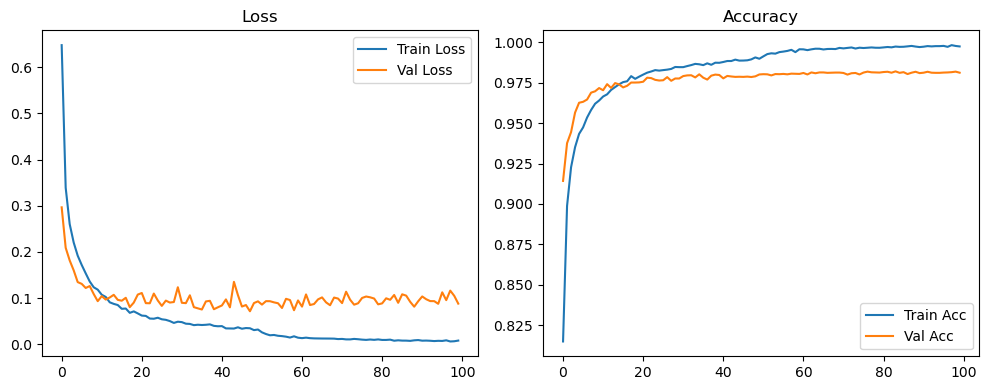

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3972, Acc: 0.8797 | Val Loss: 0.2169, Acc: 0.9368


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1557, Acc: 0.9541 | Val Loss: 0.1546, Acc: 0.9543


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1050, Acc: 0.9676 | Val Loss: 0.2156, Acc: 0.9397


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0745, Acc: 0.9765 | Val Loss: 0.1166, Acc: 0.9676


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0579, Acc: 0.9814 | Val Loss: 0.1452, Acc: 0.9596


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9851 | Val Loss: 0.1132, Acc: 0.9694


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9864 | Val Loss: 0.1069, Acc: 0.9732


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9889 | Val Loss: 0.1195, Acc: 0.9734


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.1056, Acc: 0.9761


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9904 | Val Loss: 0.0932, Acc: 0.9752


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9921 | Val Loss: 0.1009, Acc: 0.9721


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9921 | Val Loss: 0.1088, Acc: 0.9737


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.1233, Acc: 0.9732


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9935 | Val Loss: 0.2980, Acc: 0.9361


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.1025, Acc: 0.9751


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.1293, Acc: 0.9702


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1300, Acc: 0.9724


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0991, Acc: 0.9764


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9956 | Val Loss: 0.1303, Acc: 0.9730


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1134, Acc: 0.9757


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.1246, Acc: 0.9730


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1544, Acc: 0.9614


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1410, Acc: 0.9728


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.1132, Acc: 0.9771


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0931, Acc: 0.9756


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1193, Acc: 0.9742


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.6362, Acc: 0.8395


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.1267, Acc: 0.9757


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1136, Acc: 0.9774


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1135, Acc: 0.9792


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0920, Acc: 0.9771


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9970 | Val Loss: 0.2167, Acc: 0.9600


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.3362, Acc: 0.9238


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1116, Acc: 0.9763


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1307, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1462, Acc: 0.9714


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1440, Acc: 0.9690


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1097, Acc: 0.9787


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1062, Acc: 0.9781


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1247, Acc: 0.9774


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1148, Acc: 0.9790


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.4282, Acc: 0.9173


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0965, Acc: 0.9749


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1241, Acc: 0.9750


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1276, Acc: 0.9799


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1428, Acc: 0.9646


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1250, Acc: 0.9730


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1114, Acc: 0.9783


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.2761, Acc: 0.9654


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1242, Acc: 0.9754


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1532, Acc: 0.9734


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1244, Acc: 0.9792


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.8698, Acc: 0.8963


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0816, Acc: 0.9774


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.2232, Acc: 0.9653


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1709, Acc: 0.9706


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1271, Acc: 0.9744


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1881, Acc: 0.9650


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.1289, Acc: 0.9770


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1412, Acc: 0.9766


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1262, Acc: 0.9780


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.2341, Acc: 0.9526


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1055, Acc: 0.9788


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0891, Acc: 0.9762


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1413, Acc: 0.9799


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.3005, Acc: 0.9375


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0991, Acc: 0.9772


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1227, Acc: 0.9772


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1718, Acc: 0.9788


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1109, Acc: 0.9803


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1571, Acc: 0.9650


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1527, Acc: 0.9768


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.2290, Acc: 0.9662


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1428, Acc: 0.9758


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1643, Acc: 0.9727


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.1379, Acc: 0.9691


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1133, Acc: 0.9790


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1004, Acc: 0.9764


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1551, Acc: 0.9774


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1424, Acc: 0.9681


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1294, Acc: 0.9765


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1526, Acc: 0.9796


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1924, Acc: 0.9732


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1294, Acc: 0.9785


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1566, Acc: 0.9603


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1694, Acc: 0.9790


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1559, Acc: 0.9789


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1504, Acc: 0.9794


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.2649, Acc: 0.9663


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1534, Acc: 0.9783


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1361, Acc: 0.9772


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1586, Acc: 0.9750


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1275, Acc: 0.9788


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1654, Acc: 0.9800


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1529, Acc: 0.9666


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1669, Acc: 0.9795


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1903, Acc: 0.9742


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1181, Acc: 0.9757


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.4483, Acc: 0.9277


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1274, Acc: 0.9760


Final Test Loss: 0.1104 Accuracy: 0.9764


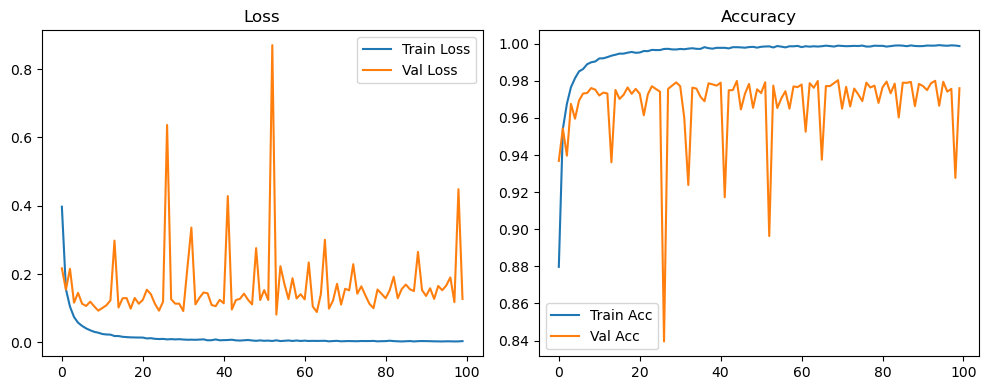

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4594, Acc: 0.8614 | Val Loss: 0.2300, Acc: 0.9327


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2378, Acc: 0.9287 | Val Loss: 0.1460, Acc: 0.9568


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1764, Acc: 0.9464 | Val Loss: 0.1386, Acc: 0.9599


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1433, Acc: 0.9566 | Val Loss: 0.1291, Acc: 0.9635


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1210, Acc: 0.9626 | Val Loss: 0.1001, Acc: 0.9705


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1086, Acc: 0.9668 | Val Loss: 0.1058, Acc: 0.9677


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0912, Acc: 0.9715 | Val Loss: 0.1216, Acc: 0.9672


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0812, Acc: 0.9743 | Val Loss: 0.1061, Acc: 0.9700


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0769, Acc: 0.9755 | Val Loss: 0.1048, Acc: 0.9722


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0703, Acc: 0.9776 | Val Loss: 0.0955, Acc: 0.9738


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0641, Acc: 0.9793 | Val Loss: 0.0926, Acc: 0.9732


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9817 | Val Loss: 0.0937, Acc: 0.9757


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9818 | Val Loss: 0.0999, Acc: 0.9742


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9829 | Val Loss: 0.1095, Acc: 0.9733


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9842 | Val Loss: 0.0980, Acc: 0.9758


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9847 | Val Loss: 0.1039, Acc: 0.9757


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9861 | Val Loss: 0.0953, Acc: 0.9743


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9859 | Val Loss: 0.0823, Acc: 0.9766


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9871 | Val Loss: 0.1064, Acc: 0.9754


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9872 | Val Loss: 0.0877, Acc: 0.9753


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9892 | Val Loss: 0.1051, Acc: 0.9765


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9888 | Val Loss: 0.0851, Acc: 0.9762


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9897 | Val Loss: 0.0944, Acc: 0.9764


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9891 | Val Loss: 0.1032, Acc: 0.9768


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9898 | Val Loss: 0.0965, Acc: 0.9758


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9901 | Val Loss: 0.0924, Acc: 0.9783


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.1012, Acc: 0.9768


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.1067, Acc: 0.9777


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9915 | Val Loss: 0.1070, Acc: 0.9760


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9913 | Val Loss: 0.0873, Acc: 0.9777


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.1034, Acc: 0.9770


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.1204, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9920 | Val Loss: 0.1117, Acc: 0.9765


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1000, Acc: 0.9771


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9923 | Val Loss: 0.0819, Acc: 0.9767


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.0996, Acc: 0.9788


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.1290, Acc: 0.9737


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0898, Acc: 0.9752


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.0953, Acc: 0.9776


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.0904, Acc: 0.9792


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9937 | Val Loss: 0.0997, Acc: 0.9790


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0954, Acc: 0.9775


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0998, Acc: 0.9781


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.1061, Acc: 0.9761


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0915, Acc: 0.9808


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.0907, Acc: 0.9775


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.1169, Acc: 0.9775


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.0842, Acc: 0.9776


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0999, Acc: 0.9773


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.1005, Acc: 0.9788


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0908, Acc: 0.9779


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1175, Acc: 0.9732


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1179, Acc: 0.9761


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0981, Acc: 0.9792


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0879, Acc: 0.9798


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.1166, Acc: 0.9801


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.0901, Acc: 0.9802


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1134, Acc: 0.9784


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0771, Acc: 0.9782


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0970, Acc: 0.9794


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.1028, Acc: 0.9789


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0822, Acc: 0.9788


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0891, Acc: 0.9787


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.1082, Acc: 0.9799


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0873, Acc: 0.9798


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0880, Acc: 0.9797


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.1068, Acc: 0.9788


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0990, Acc: 0.9803


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1075, Acc: 0.9775


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.1238, Acc: 0.9795


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.1129, Acc: 0.9811


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1073, Acc: 0.9773


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.1184, Acc: 0.9800


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.1078, Acc: 0.9796


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.1243, Acc: 0.9786


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0915, Acc: 0.9791


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0972, Acc: 0.9808


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0983, Acc: 0.9788


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0799, Acc: 0.9801


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1086, Acc: 0.9794


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9962 | Val Loss: 0.0930, Acc: 0.9786


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.1163, Acc: 0.9786


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1132, Acc: 0.9789


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0942, Acc: 0.9798


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9953 | Val Loss: 0.0965, Acc: 0.9788


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1279, Acc: 0.9777


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0955, Acc: 0.9797


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0935, Acc: 0.9778


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1063, Acc: 0.9798


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1280, Acc: 0.9797


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0967, Acc: 0.9789


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0942, Acc: 0.9779


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1067, Acc: 0.9798


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0987, Acc: 0.9778


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1201, Acc: 0.9795


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1043, Acc: 0.9798


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1001, Acc: 0.9793


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0997, Acc: 0.9802


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.1132, Acc: 0.9801


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0966, Acc: 0.9789


Final Test Loss: 0.0877 Accuracy: 0.9823


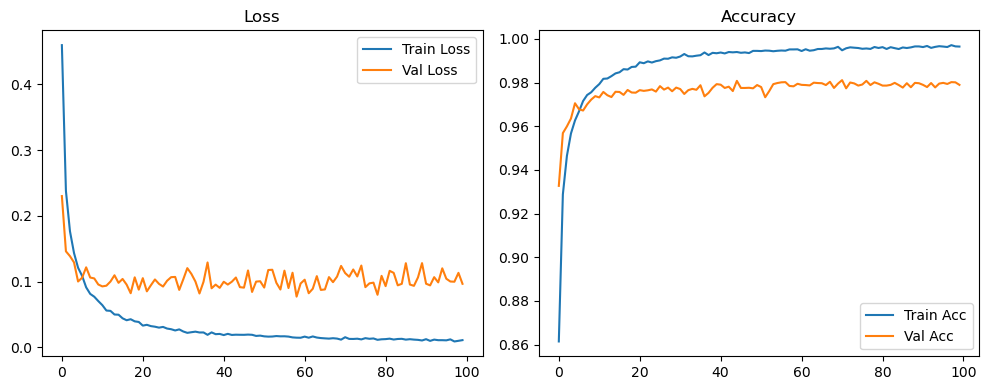

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5979, Acc: 0.8186 | Val Loss: 0.2993, Acc: 0.9117


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3686, Acc: 0.8905 | Val Loss: 0.2194, Acc: 0.9363


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2922, Acc: 0.9128 | Val Loss: 0.2037, Acc: 0.9406


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2530, Acc: 0.9243 | Val Loss: 0.1829, Acc: 0.9482


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2233, Acc: 0.9324 | Val Loss: 0.1517, Acc: 0.9557


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1991, Acc: 0.9402 | Val Loss: 0.1455, Acc: 0.9593


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1860, Acc: 0.9450 | Val Loss: 0.1420, Acc: 0.9594


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1644, Acc: 0.9506 | Val Loss: 0.1263, Acc: 0.9653


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1519, Acc: 0.9536 | Val Loss: 0.1319, Acc: 0.9661


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1464, Acc: 0.9542 | Val Loss: 0.1147, Acc: 0.9650


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1308, Acc: 0.9593 | Val Loss: 0.1253, Acc: 0.9660


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1274, Acc: 0.9607 | Val Loss: 0.1065, Acc: 0.9694


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1151, Acc: 0.9635 | Val Loss: 0.1037, Acc: 0.9686


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1105, Acc: 0.9658 | Val Loss: 0.1110, Acc: 0.9722


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1040, Acc: 0.9675 | Val Loss: 0.1023, Acc: 0.9706


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0981, Acc: 0.9690 | Val Loss: 0.1174, Acc: 0.9722


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0928, Acc: 0.9706 | Val Loss: 0.1086, Acc: 0.9711


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0890, Acc: 0.9721 | Val Loss: 0.0991, Acc: 0.9722


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0857, Acc: 0.9732 | Val Loss: 0.0977, Acc: 0.9746


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0822, Acc: 0.9739 | Val Loss: 0.1036, Acc: 0.9747


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0799, Acc: 0.9740 | Val Loss: 0.1111, Acc: 0.9731


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0722, Acc: 0.9765 | Val Loss: 0.0966, Acc: 0.9730


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0700, Acc: 0.9784 | Val Loss: 0.1019, Acc: 0.9748


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0695, Acc: 0.9771 | Val Loss: 0.0948, Acc: 0.9742


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9787 | Val Loss: 0.0993, Acc: 0.9750


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9789 | Val Loss: 0.0897, Acc: 0.9749


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0646, Acc: 0.9783 | Val Loss: 0.0917, Acc: 0.9768


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0597, Acc: 0.9805 | Val Loss: 0.0884, Acc: 0.9749


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9810 | Val Loss: 0.0895, Acc: 0.9758


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9814 | Val Loss: 0.0922, Acc: 0.9760


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9823 | Val Loss: 0.0937, Acc: 0.9763


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9822 | Val Loss: 0.1007, Acc: 0.9757


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9833 | Val Loss: 0.0910, Acc: 0.9768


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9839 | Val Loss: 0.0946, Acc: 0.9775


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9838 | Val Loss: 0.0935, Acc: 0.9754


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9835 | Val Loss: 0.1001, Acc: 0.9760


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9842 | Val Loss: 0.0968, Acc: 0.9773


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9845 | Val Loss: 0.0822, Acc: 0.9780


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9852 | Val Loss: 0.0965, Acc: 0.9778


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9858 | Val Loss: 0.0960, Acc: 0.9778


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9851 | Val Loss: 0.1010, Acc: 0.9780


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.0879, Acc: 0.9770


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9867 | Val Loss: 0.1052, Acc: 0.9758


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9865 | Val Loss: 0.1132, Acc: 0.9751


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9865 | Val Loss: 0.0930, Acc: 0.9772


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9867 | Val Loss: 0.0857, Acc: 0.9770


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9873 | Val Loss: 0.0990, Acc: 0.9775


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9872 | Val Loss: 0.1076, Acc: 0.9775


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.0870, Acc: 0.9763


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9874 | Val Loss: 0.0920, Acc: 0.9774


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9884 | Val Loss: 0.0963, Acc: 0.9778


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9885 | Val Loss: 0.0918, Acc: 0.9790


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9887 | Val Loss: 0.0878, Acc: 0.9781


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.0847, Acc: 0.9777


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9893 | Val Loss: 0.0946, Acc: 0.9792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9886 | Val Loss: 0.0828, Acc: 0.9788


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.0806, Acc: 0.9790


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9894 | Val Loss: 0.0991, Acc: 0.9790


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9882 | Val Loss: 0.0781, Acc: 0.9784


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9888 | Val Loss: 0.0918, Acc: 0.9791


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9900 | Val Loss: 0.0804, Acc: 0.9777


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.0785, Acc: 0.9789


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9896 | Val Loss: 0.0933, Acc: 0.9778


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9901 | Val Loss: 0.1032, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9901 | Val Loss: 0.0930, Acc: 0.9784


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9898 | Val Loss: 0.0751, Acc: 0.9788


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9905 | Val Loss: 0.0724, Acc: 0.9786


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.1103, Acc: 0.9769


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9910 | Val Loss: 0.0997, Acc: 0.9767


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.1014, Acc: 0.9785


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9900 | Val Loss: 0.0989, Acc: 0.9781


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.0917, Acc: 0.9788


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9915 | Val Loss: 0.0985, Acc: 0.9789


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9906 | Val Loss: 0.0902, Acc: 0.9785


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9913 | Val Loss: 0.1081, Acc: 0.9778


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9910 | Val Loss: 0.1094, Acc: 0.9788


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9913 | Val Loss: 0.0811, Acc: 0.9790


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.1129, Acc: 0.9778


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9915 | Val Loss: 0.0900, Acc: 0.9788


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9918 | Val Loss: 0.0923, Acc: 0.9792


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9920 | Val Loss: 0.1086, Acc: 0.9794


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9914 | Val Loss: 0.0909, Acc: 0.9801


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.0899, Acc: 0.9797


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9917 | Val Loss: 0.0832, Acc: 0.9797


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.1024, Acc: 0.9797


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9921 | Val Loss: 0.1168, Acc: 0.9778


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.0933, Acc: 0.9789


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9927 | Val Loss: 0.0982, Acc: 0.9787


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9919 | Val Loss: 0.1173, Acc: 0.9782


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9929 | Val Loss: 0.1014, Acc: 0.9802


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.1439, Acc: 0.9800


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.0945, Acc: 0.9802


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9922 | Val Loss: 0.1274, Acc: 0.9788


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.0950, Acc: 0.9779


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0944, Acc: 0.9790


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0842, Acc: 0.9780


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.1019, Acc: 0.9799


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.1118, Acc: 0.9792


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.1099, Acc: 0.9792


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0919, Acc: 0.9785


Final Test Loss: 0.0769 Accuracy: 0.9815


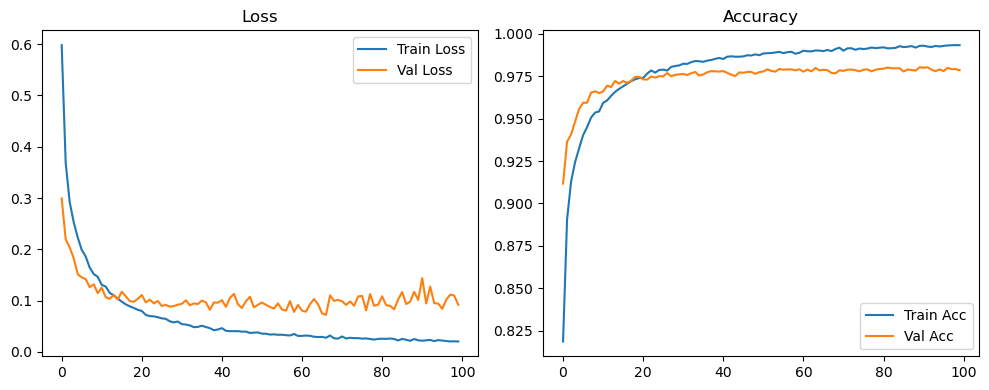

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3972, Acc: 0.8797 | Val Loss: 0.2169, Acc: 0.9368


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1557, Acc: 0.9541 | Val Loss: 0.1546, Acc: 0.9543


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1050, Acc: 0.9676 | Val Loss: 0.2156, Acc: 0.9397


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0745, Acc: 0.9765 | Val Loss: 0.1166, Acc: 0.9676


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0579, Acc: 0.9814 | Val Loss: 0.1452, Acc: 0.9596


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9851 | Val Loss: 0.1132, Acc: 0.9694


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9864 | Val Loss: 0.1069, Acc: 0.9732


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9889 | Val Loss: 0.1195, Acc: 0.9734


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.1056, Acc: 0.9761


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9904 | Val Loss: 0.0932, Acc: 0.9752


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9921 | Val Loss: 0.1009, Acc: 0.9721


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9921 | Val Loss: 0.1088, Acc: 0.9737


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.1233, Acc: 0.9732


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9935 | Val Loss: 0.2980, Acc: 0.9361


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.1025, Acc: 0.9751


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.1293, Acc: 0.9702


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1300, Acc: 0.9724


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0991, Acc: 0.9764


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9956 | Val Loss: 0.1303, Acc: 0.9730


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1134, Acc: 0.9757


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.1246, Acc: 0.9730


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1544, Acc: 0.9614


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1410, Acc: 0.9728


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.1132, Acc: 0.9771


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0931, Acc: 0.9756


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1193, Acc: 0.9742


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.6362, Acc: 0.8395


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.1267, Acc: 0.9757


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1136, Acc: 0.9774


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1135, Acc: 0.9792


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0920, Acc: 0.9771


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9970 | Val Loss: 0.2167, Acc: 0.9600


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.3362, Acc: 0.9238


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1116, Acc: 0.9763


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1307, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1462, Acc: 0.9714


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1440, Acc: 0.9690


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1097, Acc: 0.9787


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1062, Acc: 0.9781


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1247, Acc: 0.9774


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1148, Acc: 0.9790


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.4282, Acc: 0.9173


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0965, Acc: 0.9749


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1241, Acc: 0.9750


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1276, Acc: 0.9799


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1428, Acc: 0.9646


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1250, Acc: 0.9730


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1114, Acc: 0.9783


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.2761, Acc: 0.9654


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1242, Acc: 0.9754


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1143, Acc: 0.9802


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1361, Acc: 0.9797


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1758, Acc: 0.9718


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1409, Acc: 0.9798


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1259, Acc: 0.9791


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1201, Acc: 0.9801


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1403, Acc: 0.9801


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1194, Acc: 0.9807


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1416, Acc: 0.9798


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1472, Acc: 0.9813


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0981, Acc: 0.9788


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1388, Acc: 0.9784


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1224, Acc: 0.9808


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.3410, Acc: 0.9487


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1246, Acc: 0.9801


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1414, Acc: 0.9796


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1759, Acc: 0.9780


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1415, Acc: 0.9810


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1426, Acc: 0.9807


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1421, Acc: 0.9758


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1064, Acc: 0.9812


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1353, Acc: 0.9803


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1566, Acc: 0.9805


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1490, Acc: 0.9792


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1349, Acc: 0.9814


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1286, Acc: 0.9806


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1116, Acc: 0.9799


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1272, Acc: 0.9807


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1440, Acc: 0.9809


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1142, Acc: 0.9798


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1496, Acc: 0.9809


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1770, Acc: 0.9812


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1711, Acc: 0.9828


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1616, Acc: 0.9822


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1295, Acc: 0.9821


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1490, Acc: 0.9821


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1182, Acc: 0.9829


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1436, Acc: 0.9825


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1710, Acc: 0.9828


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1764, Acc: 0.9823


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1712, Acc: 0.9817


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1726, Acc: 0.9814


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1398, Acc: 0.9826


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1539, Acc: 0.9822


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1804, Acc: 0.9819


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1640, Acc: 0.9822


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1313, Acc: 0.9822


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1495, Acc: 0.9823


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1511, Acc: 0.9810


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1619, Acc: 0.9802


Final Test Loss: 0.1355 Accuracy: 0.9824


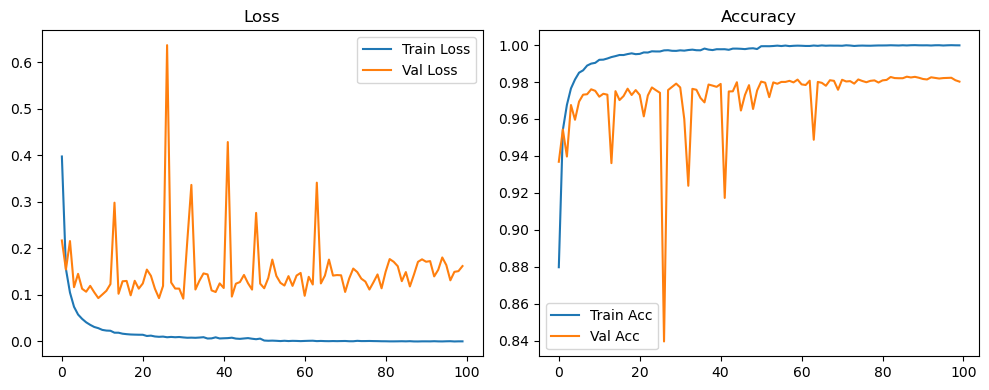

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4594, Acc: 0.8614 | Val Loss: 0.2300, Acc: 0.9327


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2378, Acc: 0.9287 | Val Loss: 0.1460, Acc: 0.9568


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1764, Acc: 0.9464 | Val Loss: 0.1386, Acc: 0.9599


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1433, Acc: 0.9566 | Val Loss: 0.1291, Acc: 0.9635


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1210, Acc: 0.9626 | Val Loss: 0.1001, Acc: 0.9705


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1086, Acc: 0.9668 | Val Loss: 0.1058, Acc: 0.9677


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0912, Acc: 0.9715 | Val Loss: 0.1216, Acc: 0.9672


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0812, Acc: 0.9743 | Val Loss: 0.1061, Acc: 0.9700


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0769, Acc: 0.9755 | Val Loss: 0.1048, Acc: 0.9722


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0703, Acc: 0.9776 | Val Loss: 0.0955, Acc: 0.9738


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0641, Acc: 0.9793 | Val Loss: 0.0926, Acc: 0.9732


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9817 | Val Loss: 0.0937, Acc: 0.9757


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9818 | Val Loss: 0.0999, Acc: 0.9742


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9829 | Val Loss: 0.1095, Acc: 0.9733


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9842 | Val Loss: 0.0980, Acc: 0.9758


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9847 | Val Loss: 0.1039, Acc: 0.9757


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9861 | Val Loss: 0.0953, Acc: 0.9743


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9859 | Val Loss: 0.0823, Acc: 0.9766


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9871 | Val Loss: 0.1064, Acc: 0.9754


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9872 | Val Loss: 0.0877, Acc: 0.9753


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9892 | Val Loss: 0.1051, Acc: 0.9765


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9888 | Val Loss: 0.0851, Acc: 0.9762


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9897 | Val Loss: 0.0944, Acc: 0.9764


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9891 | Val Loss: 0.1032, Acc: 0.9768


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9898 | Val Loss: 0.0965, Acc: 0.9758


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9901 | Val Loss: 0.0924, Acc: 0.9783


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.1012, Acc: 0.9768


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.1067, Acc: 0.9777


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9915 | Val Loss: 0.1070, Acc: 0.9760


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9913 | Val Loss: 0.0873, Acc: 0.9777


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.1034, Acc: 0.9770


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.1204, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9920 | Val Loss: 0.1117, Acc: 0.9765


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1000, Acc: 0.9771


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9923 | Val Loss: 0.0819, Acc: 0.9767


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.0996, Acc: 0.9788


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.1290, Acc: 0.9737


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0898, Acc: 0.9752


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.0953, Acc: 0.9776


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.0904, Acc: 0.9792


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9937 | Val Loss: 0.0997, Acc: 0.9790


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0954, Acc: 0.9775


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0998, Acc: 0.9781


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.1061, Acc: 0.9761


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0915, Acc: 0.9808


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.0907, Acc: 0.9775


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.1169, Acc: 0.9775


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.0842, Acc: 0.9776


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0999, Acc: 0.9773


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.1005, Acc: 0.9788


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0900, Acc: 0.9792


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1053, Acc: 0.9802


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1122, Acc: 0.9784


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1027, Acc: 0.9798


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.0900, Acc: 0.9798


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1044, Acc: 0.9802


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0949, Acc: 0.9810


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0970, Acc: 0.9814


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0954, Acc: 0.9807


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1096, Acc: 0.9806


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0970, Acc: 0.9805


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1019, Acc: 0.9793


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1240, Acc: 0.9802


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1136, Acc: 0.9808


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0816, Acc: 0.9807


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1166, Acc: 0.9802


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1347, Acc: 0.9804


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0980, Acc: 0.9801


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1306, Acc: 0.9807


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1217, Acc: 0.9798


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1109, Acc: 0.9806


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.1100, Acc: 0.9801


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1128, Acc: 0.9802


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1067, Acc: 0.9802


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1234, Acc: 0.9802


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1234, Acc: 0.9797


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1181, Acc: 0.9812


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1086, Acc: 0.9806


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1097, Acc: 0.9804


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0960, Acc: 0.9802


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1139, Acc: 0.9810


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1071, Acc: 0.9814


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1045, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1159, Acc: 0.9811


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0983, Acc: 0.9813


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1062, Acc: 0.9798


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1288, Acc: 0.9810


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1286, Acc: 0.9815


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1148, Acc: 0.9810


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1197, Acc: 0.9813


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1191, Acc: 0.9820


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1201, Acc: 0.9807


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0976, Acc: 0.9818


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1126, Acc: 0.9808


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1240, Acc: 0.9806


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1209, Acc: 0.9803


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0973, Acc: 0.9809


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1096, Acc: 0.9816


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1195, Acc: 0.9809


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1009, Acc: 0.9819


Final Test Loss: 0.0966 Accuracy: 0.9832


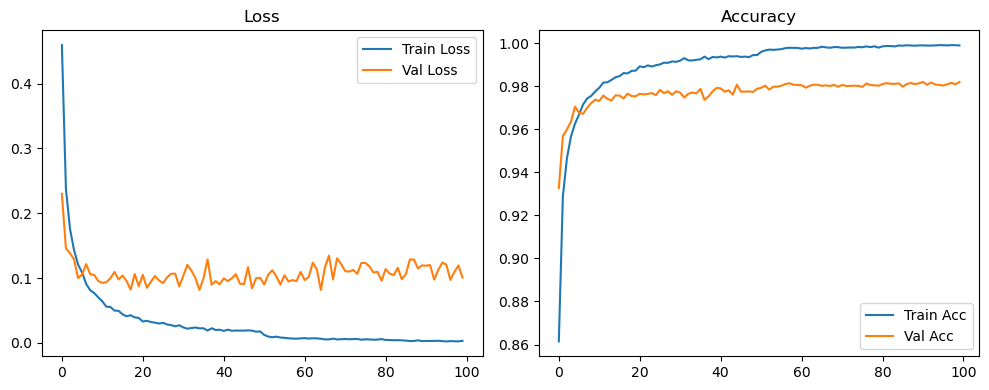

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5979, Acc: 0.8186 | Val Loss: 0.2993, Acc: 0.9117


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3686, Acc: 0.8905 | Val Loss: 0.2194, Acc: 0.9363


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2922, Acc: 0.9128 | Val Loss: 0.2037, Acc: 0.9406


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2530, Acc: 0.9243 | Val Loss: 0.1829, Acc: 0.9482


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2233, Acc: 0.9324 | Val Loss: 0.1517, Acc: 0.9557


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1991, Acc: 0.9402 | Val Loss: 0.1455, Acc: 0.9593


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1860, Acc: 0.9450 | Val Loss: 0.1420, Acc: 0.9594


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1644, Acc: 0.9506 | Val Loss: 0.1263, Acc: 0.9653


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1519, Acc: 0.9536 | Val Loss: 0.1319, Acc: 0.9661


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1464, Acc: 0.9542 | Val Loss: 0.1147, Acc: 0.9650


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1308, Acc: 0.9593 | Val Loss: 0.1253, Acc: 0.9660


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1274, Acc: 0.9607 | Val Loss: 0.1065, Acc: 0.9694


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1151, Acc: 0.9635 | Val Loss: 0.1037, Acc: 0.9686


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1105, Acc: 0.9658 | Val Loss: 0.1110, Acc: 0.9722


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1040, Acc: 0.9675 | Val Loss: 0.1023, Acc: 0.9706


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0981, Acc: 0.9690 | Val Loss: 0.1174, Acc: 0.9722


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0928, Acc: 0.9706 | Val Loss: 0.1086, Acc: 0.9711


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0890, Acc: 0.9721 | Val Loss: 0.0991, Acc: 0.9722


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0857, Acc: 0.9732 | Val Loss: 0.0977, Acc: 0.9746


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0822, Acc: 0.9739 | Val Loss: 0.1036, Acc: 0.9747


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0799, Acc: 0.9740 | Val Loss: 0.1111, Acc: 0.9731


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0722, Acc: 0.9765 | Val Loss: 0.0966, Acc: 0.9730


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0700, Acc: 0.9784 | Val Loss: 0.1019, Acc: 0.9748


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0695, Acc: 0.9771 | Val Loss: 0.0948, Acc: 0.9742


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9787 | Val Loss: 0.0993, Acc: 0.9750


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9789 | Val Loss: 0.0897, Acc: 0.9749


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0646, Acc: 0.9783 | Val Loss: 0.0917, Acc: 0.9768


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0597, Acc: 0.9805 | Val Loss: 0.0884, Acc: 0.9749


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9810 | Val Loss: 0.0895, Acc: 0.9758


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9814 | Val Loss: 0.0922, Acc: 0.9760


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9823 | Val Loss: 0.0937, Acc: 0.9763


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9822 | Val Loss: 0.1007, Acc: 0.9757


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9833 | Val Loss: 0.0910, Acc: 0.9768


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9839 | Val Loss: 0.0946, Acc: 0.9775


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9838 | Val Loss: 0.0935, Acc: 0.9754


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9835 | Val Loss: 0.1001, Acc: 0.9760


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9842 | Val Loss: 0.0968, Acc: 0.9773


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9845 | Val Loss: 0.0822, Acc: 0.9780


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9852 | Val Loss: 0.0965, Acc: 0.9778


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9858 | Val Loss: 0.0960, Acc: 0.9778


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9851 | Val Loss: 0.1010, Acc: 0.9780


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.0879, Acc: 0.9770


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9867 | Val Loss: 0.1052, Acc: 0.9758


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9865 | Val Loss: 0.1132, Acc: 0.9751


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9865 | Val Loss: 0.0930, Acc: 0.9772


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9867 | Val Loss: 0.0857, Acc: 0.9770


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9873 | Val Loss: 0.0990, Acc: 0.9775


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9872 | Val Loss: 0.1076, Acc: 0.9775


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.0870, Acc: 0.9763


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9874 | Val Loss: 0.0920, Acc: 0.9774


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9900 | Val Loss: 0.0933, Acc: 0.9782


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9909 | Val Loss: 0.0884, Acc: 0.9789


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9914 | Val Loss: 0.0828, Acc: 0.9791


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1028, Acc: 0.9786


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9921 | Val Loss: 0.0955, Acc: 0.9788


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.0930, Acc: 0.9796


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.0974, Acc: 0.9798


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9929 | Val Loss: 0.0973, Acc: 0.9802


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0869, Acc: 0.9788


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.0909, Acc: 0.9796


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9930 | Val Loss: 0.0958, Acc: 0.9792


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0974, Acc: 0.9788


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.0978, Acc: 0.9787


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9943 | Val Loss: 0.0980, Acc: 0.9787


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9937 | Val Loss: 0.0935, Acc: 0.9784


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0974, Acc: 0.9795


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9945 | Val Loss: 0.0914, Acc: 0.9799


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1028, Acc: 0.9794


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1077, Acc: 0.9790


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0940, Acc: 0.9800


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0819, Acc: 0.9797


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.1055, Acc: 0.9783


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1102, Acc: 0.9785


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.0988, Acc: 0.9792


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9947 | Val Loss: 0.1079, Acc: 0.9795


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9944 | Val Loss: 0.1003, Acc: 0.9791


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.0915, Acc: 0.9792


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.1021, Acc: 0.9788


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0957, Acc: 0.9790


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0966, Acc: 0.9782


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0909, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.1114, Acc: 0.9798


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1029, Acc: 0.9798


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.1043, Acc: 0.9797


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1153, Acc: 0.9789


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9957 | Val Loss: 0.1061, Acc: 0.9788


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1081, Acc: 0.9790


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1053, Acc: 0.9791


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0959, Acc: 0.9799


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.1075, Acc: 0.9801


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0895, Acc: 0.9793


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0992, Acc: 0.9808


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0986, Acc: 0.9793


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0964, Acc: 0.9794


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.0968, Acc: 0.9796


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.1060, Acc: 0.9793


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1200, Acc: 0.9792


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1125, Acc: 0.9787


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0931, Acc: 0.9798


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1053, Acc: 0.9787


Final Test Loss: 0.0882 Accuracy: 0.9827


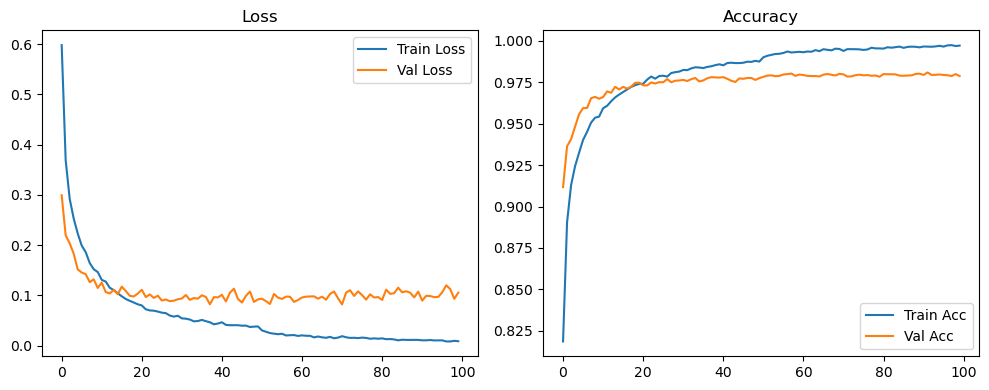

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3925, Acc: 0.8791 | Val Loss: 0.2513, Acc: 0.9254


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1856, Acc: 0.9435 | Val Loss: 0.1649, Acc: 0.9513


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1140, Acc: 0.9649 | Val Loss: 0.1678, Acc: 0.9499


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0758, Acc: 0.9750 | Val Loss: 0.1541, Acc: 0.9559


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0643, Acc: 0.9793 | Val Loss: 0.1389, Acc: 0.9611


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9857 | Val Loss: 0.0978, Acc: 0.9725


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9865 | Val Loss: 0.1289, Acc: 0.9679


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.1082, Acc: 0.9732


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.1488, Acc: 0.9663


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9912 | Val Loss: 0.1050, Acc: 0.9756


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9934 | Val Loss: 0.1315, Acc: 0.9686


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9930 | Val Loss: 0.1425, Acc: 0.9698


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.1561, Acc: 0.9681


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.1704, Acc: 0.9647


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.1211, Acc: 0.9721


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.1326, Acc: 0.9744


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.1492, Acc: 0.9701


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.1255, Acc: 0.9738


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1269, Acc: 0.9758


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.1153, Acc: 0.9763


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1246, Acc: 0.9760


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1340, Acc: 0.9733


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1793, Acc: 0.9634


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1033, Acc: 0.9802


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1277, Acc: 0.9749


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.1163, Acc: 0.9780


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.1584, Acc: 0.9702


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1363, Acc: 0.9738


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1536, Acc: 0.9715


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1153, Acc: 0.9751


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1360, Acc: 0.9758


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1487, Acc: 0.9745


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1256, Acc: 0.9765


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9981 | Val Loss: 0.1310, Acc: 0.9765


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1297, Acc: 0.9776


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1133, Acc: 0.9756


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1286, Acc: 0.9752


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1436, Acc: 0.9757


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1113, Acc: 0.9762


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1286, Acc: 0.9757


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1101, Acc: 0.9781


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1161, Acc: 0.9768


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1078, Acc: 0.9802


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0986, Acc: 0.9788


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1245, Acc: 0.9752


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1262, Acc: 0.9809


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1284, Acc: 0.9782


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1566, Acc: 0.9718


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1470, Acc: 0.9759


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1424, Acc: 0.9748


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1273, Acc: 0.9771


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1162, Acc: 0.9801


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1890, Acc: 0.9711


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1258, Acc: 0.9783


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1299, Acc: 0.9792


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1193, Acc: 0.9771


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1375, Acc: 0.9759


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1002, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1287, Acc: 0.9801


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1082, Acc: 0.9787


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1041, Acc: 0.9805


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1097, Acc: 0.9801


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1385, Acc: 0.9785


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1248, Acc: 0.9811


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1154, Acc: 0.9795


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1242, Acc: 0.9801


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1194, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1433, Acc: 0.9759


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1178, Acc: 0.9789


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1171, Acc: 0.9790


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1375, Acc: 0.9782


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1056, Acc: 0.9797


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1397, Acc: 0.9786


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1265, Acc: 0.9788


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1302, Acc: 0.9761


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1643, Acc: 0.9761


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1052, Acc: 0.9798


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1061, Acc: 0.9812


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1171, Acc: 0.9798


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0820, Acc: 0.9830


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1012, Acc: 0.9802


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1310, Acc: 0.9792


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1070, Acc: 0.9806


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1042, Acc: 0.9807


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1381, Acc: 0.9806


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1263, Acc: 0.9792


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1210, Acc: 0.9804


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1343, Acc: 0.9806


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1188, Acc: 0.9786


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1364, Acc: 0.9799


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1117, Acc: 0.9772


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1465, Acc: 0.9778


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1298, Acc: 0.9786


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1287, Acc: 0.9803


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0998, Acc: 0.9806


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1361, Acc: 0.9753


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1438, Acc: 0.9752


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1309, Acc: 0.9809


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1107, Acc: 0.9801


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0929, Acc: 0.9801


Final Test Loss: 0.0913 Accuracy: 0.9811


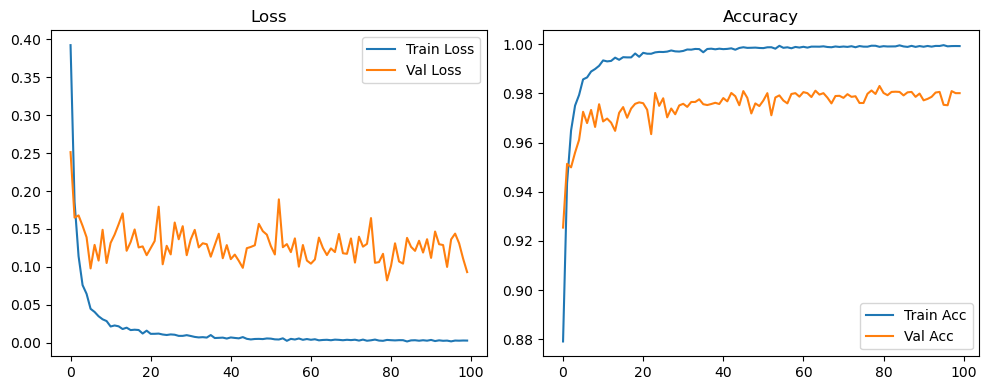

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4264, Acc: 0.8700 | Val Loss: 0.2159, Acc: 0.9352


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2333, Acc: 0.9296 | Val Loss: 0.1490, Acc: 0.9550


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1773, Acc: 0.9455 | Val Loss: 0.1467, Acc: 0.9567


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1493, Acc: 0.9544 | Val Loss: 0.1192, Acc: 0.9649


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1277, Acc: 0.9607 | Val Loss: 0.1024, Acc: 0.9690


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1164, Acc: 0.9638 | Val Loss: 0.1036, Acc: 0.9688


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0973, Acc: 0.9689 | Val Loss: 0.1025, Acc: 0.9727


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0888, Acc: 0.9716 | Val Loss: 0.1002, Acc: 0.9721


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0837, Acc: 0.9726 | Val Loss: 0.0959, Acc: 0.9738


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0774, Acc: 0.9755 | Val Loss: 0.0940, Acc: 0.9739


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0681, Acc: 0.9775 | Val Loss: 0.1052, Acc: 0.9707


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0626, Acc: 0.9798 | Val Loss: 0.0901, Acc: 0.9757


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0603, Acc: 0.9810 | Val Loss: 0.0998, Acc: 0.9737


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0552, Acc: 0.9815 | Val Loss: 0.0940, Acc: 0.9758


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0528, Acc: 0.9825 | Val Loss: 0.0915, Acc: 0.9762


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9833 | Val Loss: 0.0910, Acc: 0.9767


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9851 | Val Loss: 0.1063, Acc: 0.9731


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9858 | Val Loss: 0.0995, Acc: 0.9731


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9859 | Val Loss: 0.0981, Acc: 0.9763


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9866 | Val Loss: 0.0970, Acc: 0.9767


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9872 | Val Loss: 0.0906, Acc: 0.9765


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9878 | Val Loss: 0.0960, Acc: 0.9768


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9883 | Val Loss: 0.0953, Acc: 0.9763


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9892 | Val Loss: 0.0939, Acc: 0.9776


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.1025, Acc: 0.9768


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9894 | Val Loss: 0.0903, Acc: 0.9783


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9902 | Val Loss: 0.0942, Acc: 0.9778


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9903 | Val Loss: 0.0884, Acc: 0.9775


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9906 | Val Loss: 0.1010, Acc: 0.9771


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9904 | Val Loss: 0.1001, Acc: 0.9774


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.1007, Acc: 0.9787


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0938, Acc: 0.9772


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9922 | Val Loss: 0.0897, Acc: 0.9766


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.0924, Acc: 0.9787


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.0828, Acc: 0.9790


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.1006, Acc: 0.9780


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9926 | Val Loss: 0.1009, Acc: 0.9768


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9932 | Val Loss: 0.1000, Acc: 0.9768


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0914, Acc: 0.9777


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.0908, Acc: 0.9778


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.1001, Acc: 0.9787


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.0978, Acc: 0.9795


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.0853, Acc: 0.9789


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0980, Acc: 0.9788


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0942, Acc: 0.9779


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.1018, Acc: 0.9772


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.0996, Acc: 0.9788


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.1027, Acc: 0.9788


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.1008, Acc: 0.9788


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0983, Acc: 0.9801


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9936 | Val Loss: 0.0967, Acc: 0.9791


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0985, Acc: 0.9777


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1058, Acc: 0.9803


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.0857, Acc: 0.9796


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9949 | Val Loss: 0.0873, Acc: 0.9809


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.1019, Acc: 0.9795


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9949 | Val Loss: 0.1048, Acc: 0.9783


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.1066, Acc: 0.9794


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.0931, Acc: 0.9790


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0992, Acc: 0.9800


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0977, Acc: 0.9793


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0980, Acc: 0.9775


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0963, Acc: 0.9788


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0984, Acc: 0.9792


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.1009, Acc: 0.9789


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.0994, Acc: 0.9788


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.1117, Acc: 0.9785


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1035, Acc: 0.9789


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1023, Acc: 0.9781


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1047, Acc: 0.9784


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.0953, Acc: 0.9801


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1040, Acc: 0.9777


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1083, Acc: 0.9793


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1054, Acc: 0.9790


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9959 | Val Loss: 0.1157, Acc: 0.9796


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.0959, Acc: 0.9791


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0992, Acc: 0.9789


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1115, Acc: 0.9775


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.1018, Acc: 0.9783


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1029, Acc: 0.9795


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1078, Acc: 0.9805


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0987, Acc: 0.9802


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1033, Acc: 0.9802


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9962 | Val Loss: 0.0956, Acc: 0.9796


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1060, Acc: 0.9800


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1199, Acc: 0.9800


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0920, Acc: 0.9790


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.0993, Acc: 0.9796


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1012, Acc: 0.9792


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0995, Acc: 0.9807


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9965 | Val Loss: 0.1056, Acc: 0.9788


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1207, Acc: 0.9792


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0920, Acc: 0.9795


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1145, Acc: 0.9791


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1167, Acc: 0.9791


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1046, Acc: 0.9794


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0945, Acc: 0.9788


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.1047, Acc: 0.9792


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1044, Acc: 0.9801


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0877, Acc: 0.9812


Final Test Loss: 0.0829 Accuracy: 0.9808


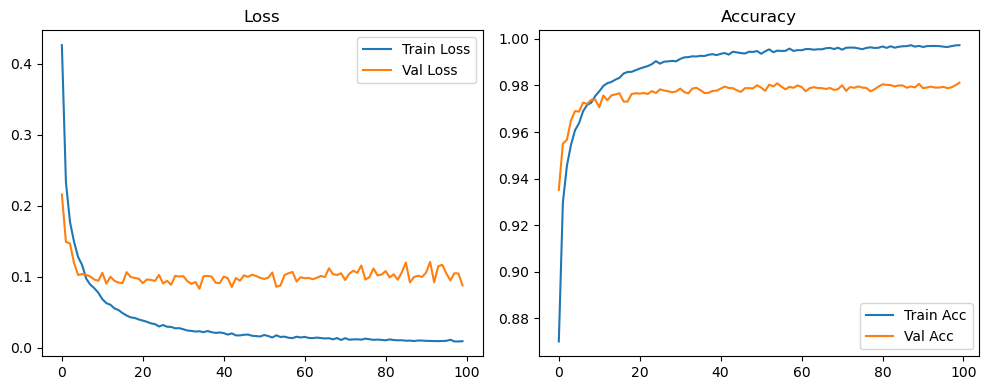

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5693, Acc: 0.8238 | Val Loss: 0.3112, Acc: 0.9064


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3887, Acc: 0.8825 | Val Loss: 0.2509, Acc: 0.9267


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.3192, Acc: 0.9040 | Val Loss: 0.2083, Acc: 0.9388


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2776, Acc: 0.9170 | Val Loss: 0.1868, Acc: 0.9460


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.2502, Acc: 0.9245 | Val Loss: 0.1536, Acc: 0.9536


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.2246, Acc: 0.9319 | Val Loss: 0.1526, Acc: 0.9559


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.2124, Acc: 0.9358 | Val Loss: 0.1504, Acc: 0.9556


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1923, Acc: 0.9415 | Val Loss: 0.1392, Acc: 0.9608


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1793, Acc: 0.9450 | Val Loss: 0.1326, Acc: 0.9608


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1745, Acc: 0.9465 | Val Loss: 0.1332, Acc: 0.9591


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1575, Acc: 0.9500 | Val Loss: 0.1257, Acc: 0.9633


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1516, Acc: 0.9530 | Val Loss: 0.1154, Acc: 0.9674


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1418, Acc: 0.9562 | Val Loss: 0.1244, Acc: 0.9657


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1417, Acc: 0.9559 | Val Loss: 0.1144, Acc: 0.9686


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1321, Acc: 0.9595 | Val Loss: 0.1132, Acc: 0.9681


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1220, Acc: 0.9613 | Val Loss: 0.1161, Acc: 0.9689


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1223, Acc: 0.9621 | Val Loss: 0.1098, Acc: 0.9699


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1143, Acc: 0.9642 | Val Loss: 0.1103, Acc: 0.9715


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1156, Acc: 0.9631 | Val Loss: 0.1033, Acc: 0.9702


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1048, Acc: 0.9669 | Val Loss: 0.1093, Acc: 0.9699


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1057, Acc: 0.9662 | Val Loss: 0.1147, Acc: 0.9691


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0983, Acc: 0.9690 | Val Loss: 0.1078, Acc: 0.9704


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0957, Acc: 0.9694 | Val Loss: 0.1100, Acc: 0.9712


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0947, Acc: 0.9696 | Val Loss: 0.1006, Acc: 0.9734


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0888, Acc: 0.9720 | Val Loss: 0.1001, Acc: 0.9731


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0905, Acc: 0.9701 | Val Loss: 0.1022, Acc: 0.9721


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0855, Acc: 0.9722 | Val Loss: 0.1086, Acc: 0.9718


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0822, Acc: 0.9738 | Val Loss: 0.1005, Acc: 0.9724


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0796, Acc: 0.9746 | Val Loss: 0.1066, Acc: 0.9711


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0784, Acc: 0.9749 | Val Loss: 0.1019, Acc: 0.9726


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0750, Acc: 0.9759 | Val Loss: 0.0953, Acc: 0.9731


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0724, Acc: 0.9768 | Val Loss: 0.0956, Acc: 0.9737


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0726, Acc: 0.9774 | Val Loss: 0.1015, Acc: 0.9731


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0678, Acc: 0.9775 | Val Loss: 0.1025, Acc: 0.9718


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0668, Acc: 0.9779 | Val Loss: 0.1007, Acc: 0.9722


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0653, Acc: 0.9783 | Val Loss: 0.0978, Acc: 0.9740


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0662, Acc: 0.9791 | Val Loss: 0.1014, Acc: 0.9735


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0633, Acc: 0.9805 | Val Loss: 0.0936, Acc: 0.9748


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0619, Acc: 0.9805 | Val Loss: 0.0974, Acc: 0.9741


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0610, Acc: 0.9799 | Val Loss: 0.1018, Acc: 0.9742


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0601, Acc: 0.9801 | Val Loss: 0.0942, Acc: 0.9743


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0576, Acc: 0.9806 | Val Loss: 0.0993, Acc: 0.9748


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0595, Acc: 0.9807 | Val Loss: 0.0961, Acc: 0.9747


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0546, Acc: 0.9820 | Val Loss: 0.0944, Acc: 0.9748


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9809 | Val Loss: 0.1008, Acc: 0.9747


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0545, Acc: 0.9823 | Val Loss: 0.0951, Acc: 0.9761


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9827 | Val Loss: 0.1064, Acc: 0.9742


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0500, Acc: 0.9830 | Val Loss: 0.0957, Acc: 0.9758


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0496, Acc: 0.9829 | Val Loss: 0.1026, Acc: 0.9750


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9831 | Val Loss: 0.1023, Acc: 0.9751


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0501, Acc: 0.9838 | Val Loss: 0.0937, Acc: 0.9741


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0490, Acc: 0.9841 | Val Loss: 0.0938, Acc: 0.9761


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9830 | Val Loss: 0.1028, Acc: 0.9761


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9845 | Val Loss: 0.1058, Acc: 0.9758


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9850 | Val Loss: 0.1011, Acc: 0.9753


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9844 | Val Loss: 0.0962, Acc: 0.9765


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9856 | Val Loss: 0.0970, Acc: 0.9749


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9858 | Val Loss: 0.0976, Acc: 0.9762


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9864 | Val Loss: 0.0958, Acc: 0.9758


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9852 | Val Loss: 0.0968, Acc: 0.9758


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9859 | Val Loss: 0.1031, Acc: 0.9745


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9865 | Val Loss: 0.1037, Acc: 0.9748


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9866 | Val Loss: 0.0951, Acc: 0.9771


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9868 | Val Loss: 0.1053, Acc: 0.9755


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0422, Acc: 0.9859 | Val Loss: 0.1011, Acc: 0.9766


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9868 | Val Loss: 0.1031, Acc: 0.9767


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9876 | Val Loss: 0.0955, Acc: 0.9750


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9875 | Val Loss: 0.0948, Acc: 0.9772


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9870 | Val Loss: 0.0879, Acc: 0.9762


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0388, Acc: 0.9870 | Val Loss: 0.0897, Acc: 0.9765


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9878 | Val Loss: 0.0907, Acc: 0.9763


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.1077, Acc: 0.9751


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9872 | Val Loss: 0.0977, Acc: 0.9780


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9879 | Val Loss: 0.0991, Acc: 0.9780


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9883 | Val Loss: 0.1029, Acc: 0.9768


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9883 | Val Loss: 0.0968, Acc: 0.9760


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9888 | Val Loss: 0.0883, Acc: 0.9778


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9886 | Val Loss: 0.1034, Acc: 0.9771


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9885 | Val Loss: 0.1008, Acc: 0.9779


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9880 | Val Loss: 0.0884, Acc: 0.9786


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9887 | Val Loss: 0.0927, Acc: 0.9781


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9894 | Val Loss: 0.1015, Acc: 0.9781


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9888 | Val Loss: 0.0846, Acc: 0.9785


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9892 | Val Loss: 0.0888, Acc: 0.9785


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9895 | Val Loss: 0.0932, Acc: 0.9768


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9887 | Val Loss: 0.0988, Acc: 0.9760


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9890 | Val Loss: 0.1082, Acc: 0.9775


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9893 | Val Loss: 0.0968, Acc: 0.9764


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9899 | Val Loss: 0.1052, Acc: 0.9768


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9904 | Val Loss: 0.0984, Acc: 0.9787


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0979, Acc: 0.9776


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9893 | Val Loss: 0.0924, Acc: 0.9772


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9899 | Val Loss: 0.0963, Acc: 0.9773


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.1016, Acc: 0.9772


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.0981, Acc: 0.9766


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9901 | Val Loss: 0.0931, Acc: 0.9782


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9906 | Val Loss: 0.1087, Acc: 0.9779


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.1028, Acc: 0.9786


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9911 | Val Loss: 0.0979, Acc: 0.9778


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9909 | Val Loss: 0.0927, Acc: 0.9774


Final Test Loss: 0.0767 Accuracy: 0.9817


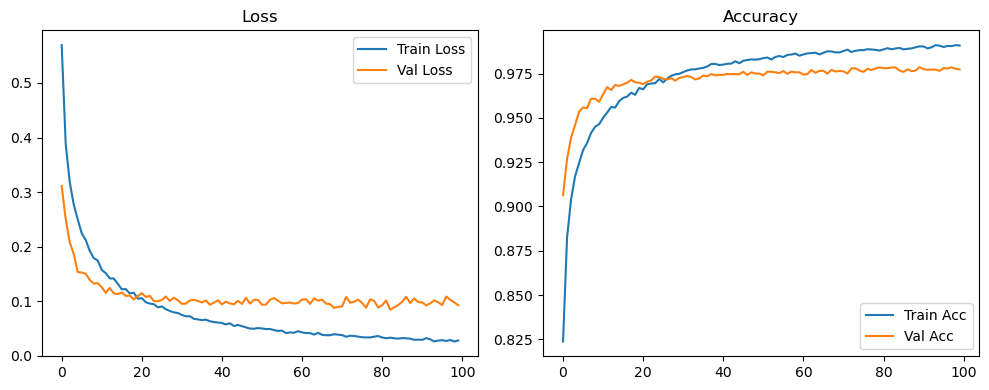

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3666, Acc: 0.8908 | Val Loss: 0.2219, Acc: 0.9342


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1383, Acc: 0.9576 | Val Loss: 0.1254, Acc: 0.9597


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0800, Acc: 0.9746 | Val Loss: 0.1494, Acc: 0.9573


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0506, Acc: 0.9837 | Val Loss: 0.1074, Acc: 0.9680


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9863 | Val Loss: 0.0912, Acc: 0.9730


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9889 | Val Loss: 0.1023, Acc: 0.9722


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9902 | Val Loss: 0.1357, Acc: 0.9660


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.1579, Acc: 0.9620


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9922 | Val Loss: 0.1393, Acc: 0.9667


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0941, Acc: 0.9771


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9945 | Val Loss: 0.1427, Acc: 0.9673


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9940 | Val Loss: 0.1184, Acc: 0.9745


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.1369, Acc: 0.9691


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.1715, Acc: 0.9671


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1666, Acc: 0.9687


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.1603, Acc: 0.9706


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.1710, Acc: 0.9655


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1398, Acc: 0.9718


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1418, Acc: 0.9741


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1424, Acc: 0.9719


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1359, Acc: 0.9738


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.2129, Acc: 0.9639


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.1273, Acc: 0.9758


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1238, Acc: 0.9774


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9962 | Val Loss: 0.1253, Acc: 0.9762


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1474, Acc: 0.9734


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1550, Acc: 0.9733


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1578, Acc: 0.9726


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1408, Acc: 0.9758


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1432, Acc: 0.9758


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1957, Acc: 0.9671


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1389, Acc: 0.9772


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1554, Acc: 0.9724


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1385, Acc: 0.9776


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1581, Acc: 0.9728


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1565, Acc: 0.9743


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1529, Acc: 0.9750


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1569, Acc: 0.9724


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1374, Acc: 0.9768


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1475, Acc: 0.9749


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1562, Acc: 0.9750


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1837, Acc: 0.9735


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1382, Acc: 0.9775


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1612, Acc: 0.9732


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1781, Acc: 0.9688


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1550, Acc: 0.9726


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1453, Acc: 0.9762


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1469, Acc: 0.9752


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1413, Acc: 0.9778


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1400, Acc: 0.9775


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1742, Acc: 0.9723


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1490, Acc: 0.9747


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1327, Acc: 0.9777


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1352, Acc: 0.9783


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1547, Acc: 0.9760


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1335, Acc: 0.9782


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.2846, Acc: 0.9537


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1515, Acc: 0.9776


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1743, Acc: 0.9741


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1532, Acc: 0.9754


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1208, Acc: 0.9788


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1315, Acc: 0.9757


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1253, Acc: 0.9788


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1520, Acc: 0.9757


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1558, Acc: 0.9770


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1344, Acc: 0.9784


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1288, Acc: 0.9798


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.2437, Acc: 0.9614


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1770, Acc: 0.9718


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1587, Acc: 0.9761


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1410, Acc: 0.9779


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1312, Acc: 0.9786


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1445, Acc: 0.9765


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1403, Acc: 0.9785


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1336, Acc: 0.9780


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9988 | Val Loss: 0.1196, Acc: 0.9782


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1261, Acc: 0.9793


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1490, Acc: 0.9765


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1415, Acc: 0.9788


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1316, Acc: 0.9781


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1374, Acc: 0.9781


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1519, Acc: 0.9763


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1553, Acc: 0.9759


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1582, Acc: 0.9767


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1520, Acc: 0.9777


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1449, Acc: 0.9794


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1451, Acc: 0.9794


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1739, Acc: 0.9765


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1338, Acc: 0.9792


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1467, Acc: 0.9798


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1582, Acc: 0.9772


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1566, Acc: 0.9766


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1370, Acc: 0.9788


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1901, Acc: 0.9732


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1406, Acc: 0.9789


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1455, Acc: 0.9785


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1343, Acc: 0.9779


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1334, Acc: 0.9792


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1647, Acc: 0.9758


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.2330, Acc: 0.9633


Final Test Loss: 0.2207 Accuracy: 0.9647


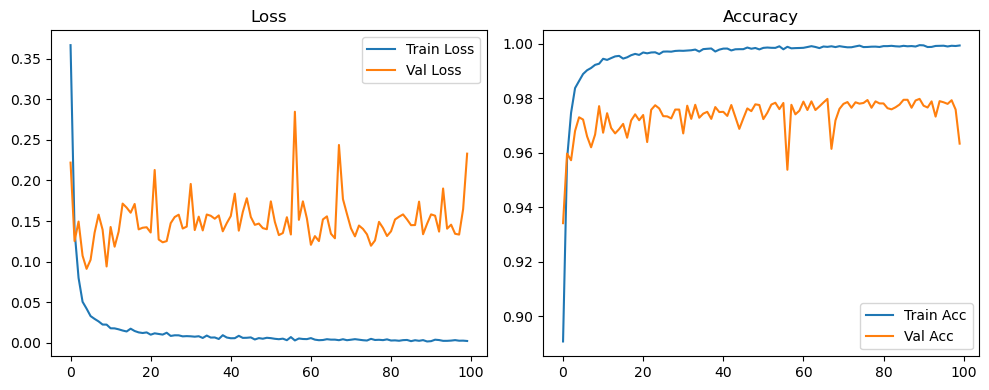

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4436, Acc: 0.8681 | Val Loss: 0.2850, Acc: 0.9137


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2689, Acc: 0.9185 | Val Loss: 0.1743, Acc: 0.9455


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1947, Acc: 0.9397 | Val Loss: 0.1476, Acc: 0.9552


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1586, Acc: 0.9512 | Val Loss: 0.1322, Acc: 0.9603


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1344, Acc: 0.9580 | Val Loss: 0.1075, Acc: 0.9673


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1230, Acc: 0.9604 | Val Loss: 0.1012, Acc: 0.9691


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1037, Acc: 0.9671 | Val Loss: 0.1053, Acc: 0.9693


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0957, Acc: 0.9694 | Val Loss: 0.1003, Acc: 0.9713


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0867, Acc: 0.9714 | Val Loss: 0.0953, Acc: 0.9726


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0799, Acc: 0.9745 | Val Loss: 0.0929, Acc: 0.9731


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0721, Acc: 0.9761 | Val Loss: 0.1045, Acc: 0.9695


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0663, Acc: 0.9784 | Val Loss: 0.0934, Acc: 0.9744


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0648, Acc: 0.9789 | Val Loss: 0.1047, Acc: 0.9721


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0581, Acc: 0.9803 | Val Loss: 0.0949, Acc: 0.9743


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0536, Acc: 0.9821 | Val Loss: 0.0925, Acc: 0.9742


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0516, Acc: 0.9827 | Val Loss: 0.0956, Acc: 0.9753


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0498, Acc: 0.9832 | Val Loss: 0.0985, Acc: 0.9738


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9847 | Val Loss: 0.0935, Acc: 0.9765


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0450, Acc: 0.9851 | Val Loss: 0.1045, Acc: 0.9742


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9860 | Val Loss: 0.0987, Acc: 0.9754


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9875 | Val Loss: 0.0956, Acc: 0.9762


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9868 | Val Loss: 0.0972, Acc: 0.9756


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9884 | Val Loss: 0.0944, Acc: 0.9756


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9877 | Val Loss: 0.0899, Acc: 0.9762


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9893 | Val Loss: 0.0984, Acc: 0.9769


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9891 | Val Loss: 0.0906, Acc: 0.9754


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9891 | Val Loss: 0.0927, Acc: 0.9764


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9899 | Val Loss: 0.1017, Acc: 0.9765


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.1034, Acc: 0.9778


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9899 | Val Loss: 0.1031, Acc: 0.9764


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9902 | Val Loss: 0.0948, Acc: 0.9779


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.1075, Acc: 0.9776


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.1029, Acc: 0.9759


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.0967, Acc: 0.9776


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9915 | Val Loss: 0.0963, Acc: 0.9782


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9919 | Val Loss: 0.1001, Acc: 0.9784


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.1113, Acc: 0.9759


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.1063, Acc: 0.9739


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9924 | Val Loss: 0.0912, Acc: 0.9787


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.1006, Acc: 0.9784


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.1058, Acc: 0.9782


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.0964, Acc: 0.9784


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9928 | Val Loss: 0.0993, Acc: 0.9778


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9938 | Val Loss: 0.1148, Acc: 0.9761


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0989, Acc: 0.9783


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9934 | Val Loss: 0.1064, Acc: 0.9774


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9933 | Val Loss: 0.1066, Acc: 0.9781


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0933, Acc: 0.9784


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.1071, Acc: 0.9782


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9938 | Val Loss: 0.1033, Acc: 0.9778


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.0999, Acc: 0.9785


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9937 | Val Loss: 0.0946, Acc: 0.9792


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.1004, Acc: 0.9795


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.1055, Acc: 0.9768


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0964, Acc: 0.9793


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1060, Acc: 0.9783


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0976, Acc: 0.9785


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.1089, Acc: 0.9768


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.1031, Acc: 0.9772


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0952, Acc: 0.9787


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1118, Acc: 0.9788


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0966, Acc: 0.9788


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1097, Acc: 0.9788


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.1045, Acc: 0.9792


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.1093, Acc: 0.9780


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1073, Acc: 0.9785


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9952 | Val Loss: 0.1092, Acc: 0.9782


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1075, Acc: 0.9785


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.0998, Acc: 0.9802


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0993, Acc: 0.9790


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0974, Acc: 0.9801


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0978, Acc: 0.9808


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1086, Acc: 0.9798


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.1061, Acc: 0.9801


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1020, Acc: 0.9804


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1068, Acc: 0.9796


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.1032, Acc: 0.9801


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.1074, Acc: 0.9776


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1022, Acc: 0.9799


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1064, Acc: 0.9789


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1008, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.1065, Acc: 0.9789


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1106, Acc: 0.9787


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1073, Acc: 0.9795


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1100, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1121, Acc: 0.9778


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1152, Acc: 0.9785


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1196, Acc: 0.9788


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1095, Acc: 0.9790


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1050, Acc: 0.9793


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1058, Acc: 0.9793


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1124, Acc: 0.9781


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0932, Acc: 0.9795


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1099, Acc: 0.9792


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1153, Acc: 0.9783


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.1007, Acc: 0.9804


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0985, Acc: 0.9804


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1121, Acc: 0.9792


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.1070, Acc: 0.9796


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1196, Acc: 0.9794


Final Test Loss: 0.1051 Accuracy: 0.9824


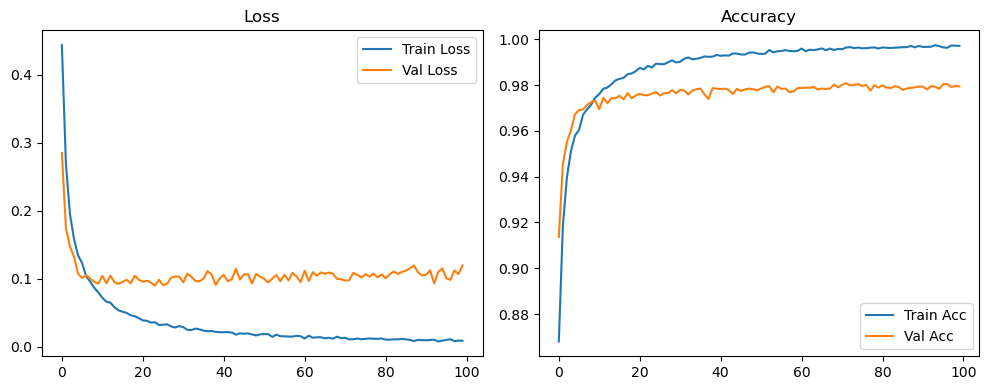

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5869, Acc: 0.8194 | Val Loss: 0.3179, Acc: 0.9036


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.4030, Acc: 0.8785 | Val Loss: 0.2574, Acc: 0.9249


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.3393, Acc: 0.8959 | Val Loss: 0.2222, Acc: 0.9340


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2982, Acc: 0.9093 | Val Loss: 0.1990, Acc: 0.9420


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2667, Acc: 0.9199 | Val Loss: 0.1668, Acc: 0.9506


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2414, Acc: 0.9275 | Val Loss: 0.1641, Acc: 0.9529


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.2311, Acc: 0.9310 | Val Loss: 0.1591, Acc: 0.9534


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.2085, Acc: 0.9360 | Val Loss: 0.1476, Acc: 0.9574


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1986, Acc: 0.9393 | Val Loss: 0.1415, Acc: 0.9584


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1900, Acc: 0.9414 | Val Loss: 0.1377, Acc: 0.9594


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1768, Acc: 0.9452 | Val Loss: 0.1403, Acc: 0.9600


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1716, Acc: 0.9462 | Val Loss: 0.1231, Acc: 0.9635


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1592, Acc: 0.9500 | Val Loss: 0.1375, Acc: 0.9624


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1551, Acc: 0.9515 | Val Loss: 0.1184, Acc: 0.9663


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1463, Acc: 0.9545 | Val Loss: 0.1218, Acc: 0.9651


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1397, Acc: 0.9560 | Val Loss: 0.1168, Acc: 0.9682


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1384, Acc: 0.9568 | Val Loss: 0.1170, Acc: 0.9677


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1314, Acc: 0.9593 | Val Loss: 0.1191, Acc: 0.9674


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1316, Acc: 0.9594 | Val Loss: 0.1144, Acc: 0.9667


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1223, Acc: 0.9616 | Val Loss: 0.1205, Acc: 0.9672


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1217, Acc: 0.9625 | Val Loss: 0.1190, Acc: 0.9683


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1132, Acc: 0.9639 | Val Loss: 0.1159, Acc: 0.9683


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1069, Acc: 0.9653 | Val Loss: 0.1173, Acc: 0.9685


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1097, Acc: 0.9656 | Val Loss: 0.1126, Acc: 0.9697


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.1018, Acc: 0.9685 | Val Loss: 0.1099, Acc: 0.9698


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.1044, Acc: 0.9669 | Val Loss: 0.1087, Acc: 0.9700


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.1009, Acc: 0.9682 | Val Loss: 0.1112, Acc: 0.9699


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.1002, Acc: 0.9675 | Val Loss: 0.1118, Acc: 0.9688


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0942, Acc: 0.9699 | Val Loss: 0.1152, Acc: 0.9699


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0903, Acc: 0.9705 | Val Loss: 0.1131, Acc: 0.9700


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0915, Acc: 0.9701 | Val Loss: 0.1055, Acc: 0.9709


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0879, Acc: 0.9719 | Val Loss: 0.1065, Acc: 0.9715


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0839, Acc: 0.9738 | Val Loss: 0.1077, Acc: 0.9719


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0852, Acc: 0.9725 | Val Loss: 0.1079, Acc: 0.9714


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0822, Acc: 0.9739 | Val Loss: 0.1094, Acc: 0.9699


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0801, Acc: 0.9744 | Val Loss: 0.1054, Acc: 0.9729


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0785, Acc: 0.9742 | Val Loss: 0.1087, Acc: 0.9714


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0764, Acc: 0.9749 | Val Loss: 0.1069, Acc: 0.9708


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0743, Acc: 0.9759 | Val Loss: 0.1075, Acc: 0.9714


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0721, Acc: 0.9767 | Val Loss: 0.1080, Acc: 0.9718


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0724, Acc: 0.9762 | Val Loss: 0.1060, Acc: 0.9730


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0710, Acc: 0.9762 | Val Loss: 0.1080, Acc: 0.9734


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0685, Acc: 0.9766 | Val Loss: 0.1067, Acc: 0.9729


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0662, Acc: 0.9779 | Val Loss: 0.1065, Acc: 0.9728


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0674, Acc: 0.9770 | Val Loss: 0.1063, Acc: 0.9727


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0666, Acc: 0.9787 | Val Loss: 0.1066, Acc: 0.9738


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0630, Acc: 0.9790 | Val Loss: 0.1122, Acc: 0.9723


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0598, Acc: 0.9794 | Val Loss: 0.1079, Acc: 0.9728


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0592, Acc: 0.9806 | Val Loss: 0.1053, Acc: 0.9727


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0608, Acc: 0.9801 | Val Loss: 0.1095, Acc: 0.9735


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0580, Acc: 0.9815 | Val Loss: 0.1059, Acc: 0.9732


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0587, Acc: 0.9802 | Val Loss: 0.1040, Acc: 0.9738


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0599, Acc: 0.9802 | Val Loss: 0.1041, Acc: 0.9728


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0595, Acc: 0.9805 | Val Loss: 0.1061, Acc: 0.9740


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0561, Acc: 0.9818 | Val Loss: 0.1011, Acc: 0.9748


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0539, Acc: 0.9822 | Val Loss: 0.1047, Acc: 0.9742


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0524, Acc: 0.9826 | Val Loss: 0.1041, Acc: 0.9734


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0508, Acc: 0.9836 | Val Loss: 0.1050, Acc: 0.9748


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0493, Acc: 0.9843 | Val Loss: 0.1037, Acc: 0.9748


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0518, Acc: 0.9834 | Val Loss: 0.1009, Acc: 0.9738


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0503, Acc: 0.9837 | Val Loss: 0.1009, Acc: 0.9735


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0510, Acc: 0.9832 | Val Loss: 0.1040, Acc: 0.9744


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0502, Acc: 0.9830 | Val Loss: 0.1070, Acc: 0.9748


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0493, Acc: 0.9836 | Val Loss: 0.1046, Acc: 0.9744


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0497, Acc: 0.9830 | Val Loss: 0.1030, Acc: 0.9743


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9856 | Val Loss: 0.1079, Acc: 0.9753


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0447, Acc: 0.9847 | Val Loss: 0.1063, Acc: 0.9742


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9851 | Val Loss: 0.1094, Acc: 0.9751


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9849 | Val Loss: 0.1097, Acc: 0.9732


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0439, Acc: 0.9854 | Val Loss: 0.1045, Acc: 0.9750


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9853 | Val Loss: 0.1062, Acc: 0.9742


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0452, Acc: 0.9852 | Val Loss: 0.1198, Acc: 0.9737


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9854 | Val Loss: 0.1050, Acc: 0.9758


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9854 | Val Loss: 0.1094, Acc: 0.9752


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9870 | Val Loss: 0.1134, Acc: 0.9748


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0411, Acc: 0.9864 | Val Loss: 0.1080, Acc: 0.9754


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9868 | Val Loss: 0.1038, Acc: 0.9751


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9861 | Val Loss: 0.1089, Acc: 0.9742


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9865 | Val Loss: 0.1058, Acc: 0.9751


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0399, Acc: 0.9866 | Val Loss: 0.1025, Acc: 0.9757


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9869 | Val Loss: 0.1095, Acc: 0.9752


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9864 | Val Loss: 0.1034, Acc: 0.9752


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9869 | Val Loss: 0.1006, Acc: 0.9751


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9873 | Val Loss: 0.0989, Acc: 0.9754


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9872 | Val Loss: 0.1000, Acc: 0.9761


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.1097, Acc: 0.9752


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9883 | Val Loss: 0.1082, Acc: 0.9758


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9880 | Val Loss: 0.1039, Acc: 0.9756


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0358, Acc: 0.9877 | Val Loss: 0.1109, Acc: 0.9751


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9884 | Val Loss: 0.1114, Acc: 0.9752


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9886 | Val Loss: 0.1079, Acc: 0.9751


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9882 | Val Loss: 0.1018, Acc: 0.9767


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.1090, Acc: 0.9745


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9899 | Val Loss: 0.1195, Acc: 0.9758


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9884 | Val Loss: 0.1150, Acc: 0.9738


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9887 | Val Loss: 0.1111, Acc: 0.9748


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9894 | Val Loss: 0.1103, Acc: 0.9749


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.1072, Acc: 0.9764


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9889 | Val Loss: 0.1078, Acc: 0.9765


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9890 | Val Loss: 0.1067, Acc: 0.9752


Final Test Loss: 0.0929 Accuracy: 0.9795


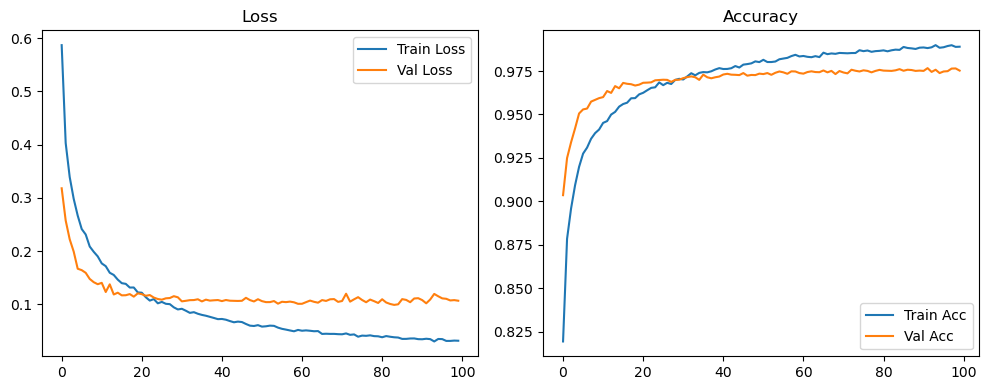

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4657, Acc: 0.8622 | Val Loss: 0.2732, Acc: 0.9189


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1864, Acc: 0.9455 | Val Loss: 0.1743, Acc: 0.9513


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1131, Acc: 0.9653 | Val Loss: 0.1422, Acc: 0.9593


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9776 | Val Loss: 0.1524, Acc: 0.9597


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9810 | Val Loss: 0.1298, Acc: 0.9668


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.1477, Acc: 0.9597


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9875 | Val Loss: 0.1221, Acc: 0.9682


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.1512, Acc: 0.9630


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9913 | Val Loss: 0.1096, Acc: 0.9736


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9909 | Val Loss: 0.1446, Acc: 0.9657


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.1497, Acc: 0.9661


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.1103, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.1353, Acc: 0.9689


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1425, Acc: 0.9694


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.1295, Acc: 0.9729


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.1884, Acc: 0.9603


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1447, Acc: 0.9714


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9965 | Val Loss: 0.1842, Acc: 0.9657


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1378, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1104, Acc: 0.9752


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.2068, Acc: 0.9663


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1791, Acc: 0.9607


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.2992, Acc: 0.9448


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.3272, Acc: 0.9437


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.1235, Acc: 0.9741


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1313, Acc: 0.9704


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1258, Acc: 0.9699


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1364, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9976 | Val Loss: 0.1975, Acc: 0.9463


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1157, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1388, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.2665, Acc: 0.9583


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1529, Acc: 0.9688


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1448, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1267, Acc: 0.9722


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1547, Acc: 0.9732


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1140, Acc: 0.9735


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.2012, Acc: 0.9647


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.3996, Acc: 0.9365


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1521, Acc: 0.9759


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.3414, Acc: 0.9443


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1692, Acc: 0.9736


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.2018, Acc: 0.9620


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1248, Acc: 0.9733


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.2823, Acc: 0.9609


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.6852, Acc: 0.8582


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.7112, Acc: 0.8955


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.2231, Acc: 0.9637


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1022, Acc: 0.9768


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9977 | Val Loss: 0.1919, Acc: 0.9607


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.1556, Acc: 0.9753


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1759, Acc: 0.9685


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1540, Acc: 0.9782


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.2117, Acc: 0.9690


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.1759, Acc: 0.9769


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1517, Acc: 0.9763


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1215, Acc: 0.9776


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1693, Acc: 0.9725


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.2111, Acc: 0.9649


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1204, Acc: 0.9784


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0995, Acc: 0.9768


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1197, Acc: 0.9657


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1310, Acc: 0.9746


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1795, Acc: 0.9617


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.2404, Acc: 0.9626


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.2176, Acc: 0.9634


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1541, Acc: 0.9712


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1768, Acc: 0.9741


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1641, Acc: 0.9772


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1220, Acc: 0.9760


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1639, Acc: 0.9617


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1450, Acc: 0.9725


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0942, Acc: 0.9741


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1942, Acc: 0.9761


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.8013, Acc: 0.9266


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1898, Acc: 0.9655


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.2043, Acc: 0.9734


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.4418, Acc: 0.9476


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1428, Acc: 0.9678


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.2671, Acc: 0.9772


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1960, Acc: 0.9775


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1823, Acc: 0.9630


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.2834, Acc: 0.9607


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1830, Acc: 0.9772


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1447, Acc: 0.9762


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.3212, Acc: 0.9717


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1356, Acc: 0.9595


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.4717, Acc: 0.9621


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.7314, Acc: 0.9227


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.2261, Acc: 0.9760


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1603, Acc: 0.9752


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.2713, Acc: 0.9629


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1693, Acc: 0.9774


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1676, Acc: 0.9763


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.3714, Acc: 0.9651


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1995, Acc: 0.9709


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.2037, Acc: 0.9717


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1667, Acc: 0.9761


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.5015, Acc: 0.9449


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.5498, Acc: 0.9378


Final Test Loss: 0.5094 Accuracy: 0.9396


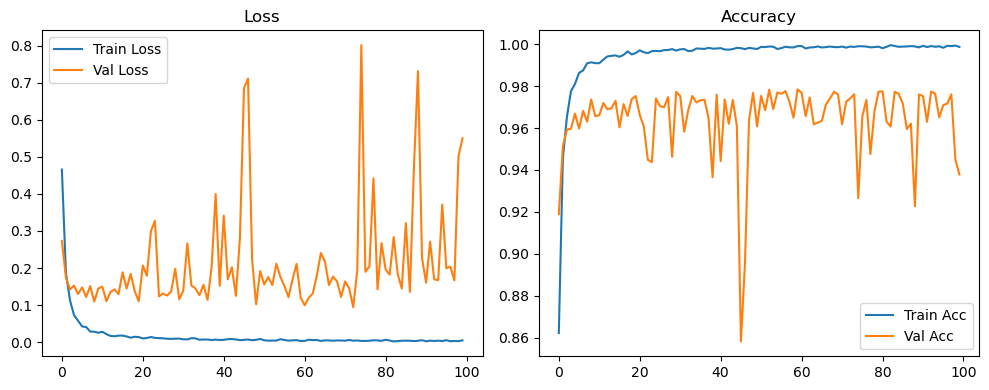

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5092, Acc: 0.8496 | Val Loss: 0.3325, Acc: 0.9057


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2669, Acc: 0.9223 | Val Loss: 0.1720, Acc: 0.9493


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1751, Acc: 0.9479 | Val Loss: 0.1614, Acc: 0.9535


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1322, Acc: 0.9594 | Val Loss: 0.1506, Acc: 0.9577


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9660 | Val Loss: 0.1116, Acc: 0.9657


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9714 | Val Loss: 0.1411, Acc: 0.9642


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9758 | Val Loss: 0.1124, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9773 | Val Loss: 0.1189, Acc: 0.9676


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9793 | Val Loss: 0.0979, Acc: 0.9724


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9816 | Val Loss: 0.1077, Acc: 0.9708


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9829 | Val Loss: 0.1126, Acc: 0.9687


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9843 | Val Loss: 0.0963, Acc: 0.9724


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9847 | Val Loss: 0.1108, Acc: 0.9720


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9864 | Val Loss: 0.1041, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9868 | Val Loss: 0.0863, Acc: 0.9745


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9879 | Val Loss: 0.1143, Acc: 0.9759


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9887 | Val Loss: 0.1064, Acc: 0.9736


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9876 | Val Loss: 0.1136, Acc: 0.9740


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9898 | Val Loss: 0.1089, Acc: 0.9731


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9890 | Val Loss: 0.1110, Acc: 0.9714


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.1019, Acc: 0.9740


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.1011, Acc: 0.9741


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.1178, Acc: 0.9749


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.1258, Acc: 0.9748


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.1087, Acc: 0.9739


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.1057, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.0902, Acc: 0.9760


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9922 | Val Loss: 0.1102, Acc: 0.9764


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.1037, Acc: 0.9758


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1304, Acc: 0.9742


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.1134, Acc: 0.9749


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.1026, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9942 | Val Loss: 0.1309, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1173, Acc: 0.9754


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.1301, Acc: 0.9765


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1152, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1333, Acc: 0.9757


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1307, Acc: 0.9747


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1560, Acc: 0.9745


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0932, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.1031, Acc: 0.9757


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.1263, Acc: 0.9762


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.1011, Acc: 0.9767


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1305, Acc: 0.9758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0978, Acc: 0.9748


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.1231, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.0966, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.1308, Acc: 0.9781


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1127, Acc: 0.9781


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1327, Acc: 0.9767


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1198, Acc: 0.9778


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.1115, Acc: 0.9788


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1209, Acc: 0.9769


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.1439, Acc: 0.9769


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1208, Acc: 0.9764


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9953 | Val Loss: 0.1582, Acc: 0.9766


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.1207, Acc: 0.9754


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1161, Acc: 0.9789


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.1783, Acc: 0.9769


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.1506, Acc: 0.9778


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1205, Acc: 0.9767


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1100, Acc: 0.9777


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0954, Acc: 0.9768


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1092, Acc: 0.9760


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9961 | Val Loss: 0.1144, Acc: 0.9777


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1215, Acc: 0.9763


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.2225, Acc: 0.9729


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1113, Acc: 0.9783


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1278, Acc: 0.9758


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.1162, Acc: 0.9765


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1503, Acc: 0.9777


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1247, Acc: 0.9772


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1050, Acc: 0.9774


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0798, Acc: 0.9770


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1093, Acc: 0.9776


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.1135, Acc: 0.9792


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1288, Acc: 0.9769


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.1361, Acc: 0.9782


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1344, Acc: 0.9762


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9976 | Val Loss: 0.1314, Acc: 0.9780


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1450, Acc: 0.9780


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1168, Acc: 0.9774


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1121, Acc: 0.9787


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.1448, Acc: 0.9778


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1407, Acc: 0.9778


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1114, Acc: 0.9795


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1110, Acc: 0.9795


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1902, Acc: 0.9783


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1367, Acc: 0.9788


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1378, Acc: 0.9777


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1195, Acc: 0.9783


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1570, Acc: 0.9779


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1271, Acc: 0.9778


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0957, Acc: 0.9778


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1779, Acc: 0.9775


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.1310, Acc: 0.9778


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1387, Acc: 0.9791


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1146, Acc: 0.9791


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1138, Acc: 0.9770


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.1913, Acc: 0.9782


Final Test Loss: 0.1680 Accuracy: 0.9806


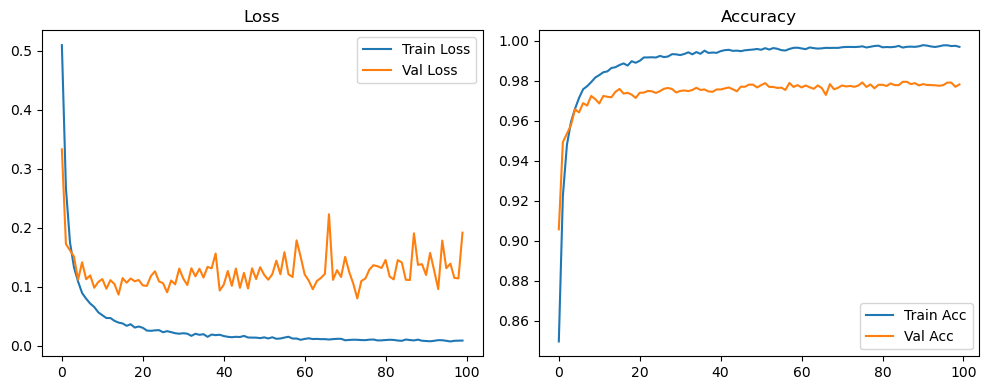

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6267, Acc: 0.8146 | Val Loss: 0.3982, Acc: 0.8958


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3581, Acc: 0.8938 | Val Loss: 0.2254, Acc: 0.9327


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2659, Acc: 0.9214 | Val Loss: 0.1924, Acc: 0.9426


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2143, Acc: 0.9354 | Val Loss: 0.1642, Acc: 0.9511


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1837, Acc: 0.9440 | Val Loss: 0.1402, Acc: 0.9586


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1619, Acc: 0.9505 | Val Loss: 0.1405, Acc: 0.9591


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1439, Acc: 0.9562 | Val Loss: 0.1190, Acc: 0.9646


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1267, Acc: 0.9616 | Val Loss: 0.1198, Acc: 0.9665


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9632 | Val Loss: 0.1214, Acc: 0.9683


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1064, Acc: 0.9675 | Val Loss: 0.1065, Acc: 0.9676


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0978, Acc: 0.9699 | Val Loss: 0.1184, Acc: 0.9683


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9722 | Val Loss: 0.1030, Acc: 0.9700


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9707 | Val Loss: 0.1076, Acc: 0.9700


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9738 | Val Loss: 0.1119, Acc: 0.9742


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9763 | Val Loss: 0.0974, Acc: 0.9731


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9766 | Val Loss: 0.0990, Acc: 0.9739


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9786 | Val Loss: 0.0990, Acc: 0.9739


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9786 | Val Loss: 0.1012, Acc: 0.9727


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9793 | Val Loss: 0.1098, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9807 | Val Loss: 0.0942, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9823 | Val Loss: 0.1075, Acc: 0.9736


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9832 | Val Loss: 0.1041, Acc: 0.9753


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9834 | Val Loss: 0.1132, Acc: 0.9763


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9843 | Val Loss: 0.0943, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9851 | Val Loss: 0.0915, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9846 | Val Loss: 0.0849, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9852 | Val Loss: 0.0887, Acc: 0.9782


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9864 | Val Loss: 0.0878, Acc: 0.9763


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9862 | Val Loss: 0.1010, Acc: 0.9768


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9871 | Val Loss: 0.0986, Acc: 0.9773


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 0.0890, Acc: 0.9773


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9877 | Val Loss: 0.0838, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9884 | Val Loss: 0.0916, Acc: 0.9779


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9884 | Val Loss: 0.1112, Acc: 0.9771


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 0.1101, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9892 | Val Loss: 0.0917, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9889 | Val Loss: 0.0961, Acc: 0.9785


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1056, Acc: 0.9779


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9892 | Val Loss: 0.0927, Acc: 0.9777


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0964, Acc: 0.9781


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9903 | Val Loss: 0.0789, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.0892, Acc: 0.9790


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0876, Acc: 0.9788


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.0825, Acc: 0.9791


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9915 | Val Loss: 0.1040, Acc: 0.9784


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9910 | Val Loss: 0.0930, Acc: 0.9777


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.0888, Acc: 0.9784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.1086, Acc: 0.9792


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.0963, Acc: 0.9785


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.0956, Acc: 0.9782


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.0860, Acc: 0.9798


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.1423, Acc: 0.9785


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9930 | Val Loss: 0.0867, Acc: 0.9785


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9920 | Val Loss: 0.1055, Acc: 0.9792


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9926 | Val Loss: 0.1008, Acc: 0.9789


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.0889, Acc: 0.9795


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.0775, Acc: 0.9795


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.0793, Acc: 0.9800


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9934 | Val Loss: 0.1342, Acc: 0.9790


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.1173, Acc: 0.9789


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.0941, Acc: 0.9800


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9922 | Val Loss: 0.1406, Acc: 0.9787


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0980, Acc: 0.9802


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9932 | Val Loss: 0.0903, Acc: 0.9798


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.1013, Acc: 0.9792


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.0954, Acc: 0.9789


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.1040, Acc: 0.9802


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.0973, Acc: 0.9786


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.1236, Acc: 0.9794


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.1146, Acc: 0.9802


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9940 | Val Loss: 0.0809, Acc: 0.9803


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.0891, Acc: 0.9782


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.1061, Acc: 0.9792


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9940 | Val Loss: 0.0730, Acc: 0.9787


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1084, Acc: 0.9792


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9936 | Val Loss: 0.1015, Acc: 0.9794


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.1176, Acc: 0.9808


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.1016, Acc: 0.9800


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.1052, Acc: 0.9794


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.0913, Acc: 0.9811


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9940 | Val Loss: 0.0971, Acc: 0.9799


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.1093, Acc: 0.9792


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9943 | Val Loss: 0.1105, Acc: 0.9801


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1262, Acc: 0.9802


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9946 | Val Loss: 0.0922, Acc: 0.9798


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.1238, Acc: 0.9797


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.1238, Acc: 0.9793


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.0818, Acc: 0.9800


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.1094, Acc: 0.9790


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9955 | Val Loss: 0.0948, Acc: 0.9792


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9952 | Val Loss: 0.1021, Acc: 0.9797


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.1201, Acc: 0.9812


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9952 | Val Loss: 0.1145, Acc: 0.9808


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.0816, Acc: 0.9813


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.1373, Acc: 0.9804


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9948 | Val Loss: 0.0907, Acc: 0.9802


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0856, Acc: 0.9799


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.1140, Acc: 0.9799


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9959 | Val Loss: 0.1347, Acc: 0.9802


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.1282, Acc: 0.9799


Final Test Loss: 0.1203 Accuracy: 0.9825


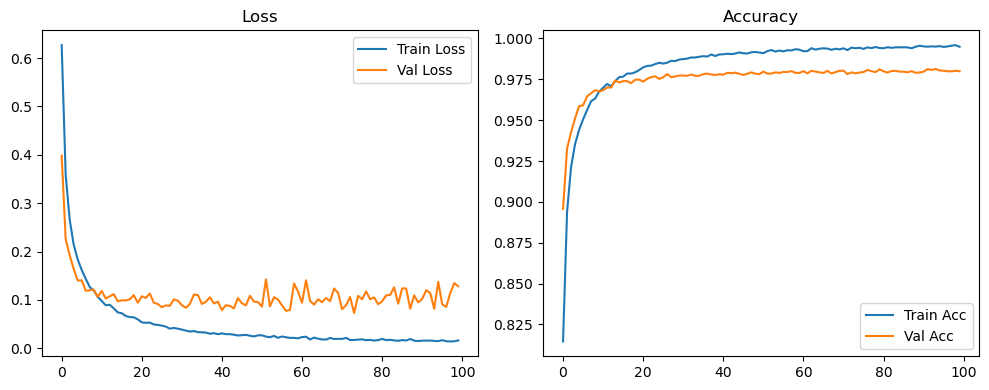

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4657, Acc: 0.8622 | Val Loss: 0.2732, Acc: 0.9189


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1864, Acc: 0.9455 | Val Loss: 0.1743, Acc: 0.9513


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1131, Acc: 0.9653 | Val Loss: 0.1422, Acc: 0.9593


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9776 | Val Loss: 0.1524, Acc: 0.9597


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9810 | Val Loss: 0.1298, Acc: 0.9668


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.1477, Acc: 0.9597


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9875 | Val Loss: 0.1221, Acc: 0.9682


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.1512, Acc: 0.9630


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9913 | Val Loss: 0.1096, Acc: 0.9736


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9909 | Val Loss: 0.1446, Acc: 0.9657


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.1497, Acc: 0.9661


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.1103, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.1353, Acc: 0.9689


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1425, Acc: 0.9694


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.1295, Acc: 0.9729


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.1884, Acc: 0.9603


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1447, Acc: 0.9714


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9965 | Val Loss: 0.1842, Acc: 0.9657


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1378, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1104, Acc: 0.9752


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.2068, Acc: 0.9663


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1791, Acc: 0.9607


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.2992, Acc: 0.9448


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.3272, Acc: 0.9437


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.1235, Acc: 0.9741


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1313, Acc: 0.9704


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1258, Acc: 0.9699


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1364, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9976 | Val Loss: 0.1975, Acc: 0.9463


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1157, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1388, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.2665, Acc: 0.9583


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1529, Acc: 0.9688


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1448, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1267, Acc: 0.9722


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1547, Acc: 0.9732


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1140, Acc: 0.9735


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.2012, Acc: 0.9647


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.3996, Acc: 0.9365


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1521, Acc: 0.9759


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.3414, Acc: 0.9443


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1692, Acc: 0.9736


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.2018, Acc: 0.9620


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1248, Acc: 0.9733


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.2823, Acc: 0.9609


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.6852, Acc: 0.8582


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.7112, Acc: 0.8955


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.2231, Acc: 0.9637


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1022, Acc: 0.9768


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9977 | Val Loss: 0.1919, Acc: 0.9607


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1228, Acc: 0.9789


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1750, Acc: 0.9773


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1325, Acc: 0.9787


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1273, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1362, Acc: 0.9787


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1857, Acc: 0.9768


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1901, Acc: 0.9788


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1395, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1645, Acc: 0.9797


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1412, Acc: 0.9775


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1986, Acc: 0.9788


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2336, Acc: 0.9718


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.2931, Acc: 0.9532


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.7105, Acc: 0.8638


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1537, Acc: 0.9769


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.2004, Acc: 0.9727


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.1523, Acc: 0.9787


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1029, Acc: 0.9792


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2866, Acc: 0.9708


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1624, Acc: 0.9794


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1064, Acc: 0.9796


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1486, Acc: 0.9778


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1683, Acc: 0.9797


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1505, Acc: 0.9777


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1540, Acc: 0.9799


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1972, Acc: 0.9762


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1820, Acc: 0.9748


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1900, Acc: 0.9759


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.2304, Acc: 0.9747


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1815, Acc: 0.9765


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1274, Acc: 0.9794


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1681, Acc: 0.9793


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1853, Acc: 0.9802


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1598, Acc: 0.9794


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1716, Acc: 0.9802


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1911, Acc: 0.9807


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1772, Acc: 0.9805


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1888, Acc: 0.9796


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2104, Acc: 0.9798


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1662, Acc: 0.9792


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1301, Acc: 0.9778


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1196, Acc: 0.9793


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1800, Acc: 0.9801


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1922, Acc: 0.9802


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2127, Acc: 0.9792


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2205, Acc: 0.9790


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2046, Acc: 0.9786


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2162, Acc: 0.9795


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1816, Acc: 0.9791


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1863, Acc: 0.9801


Final Test Loss: 0.1597 Accuracy: 0.9820


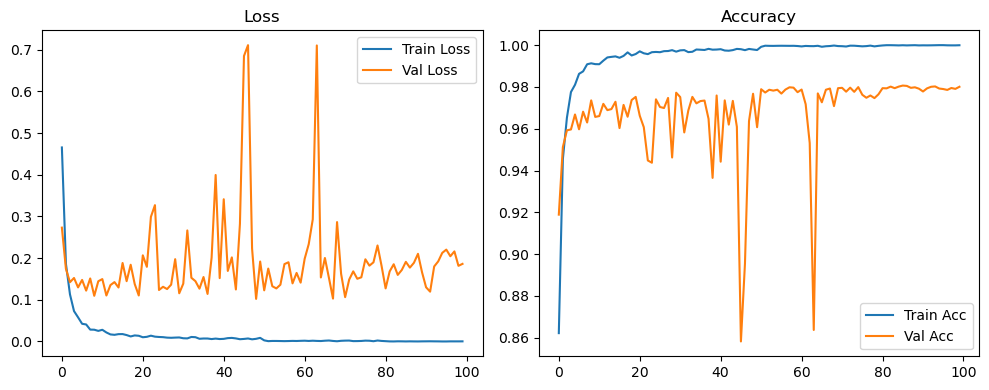

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5092, Acc: 0.8496 | Val Loss: 0.3325, Acc: 0.9057


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2669, Acc: 0.9223 | Val Loss: 0.1720, Acc: 0.9493


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1751, Acc: 0.9479 | Val Loss: 0.1614, Acc: 0.9535


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1322, Acc: 0.9594 | Val Loss: 0.1506, Acc: 0.9577


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9660 | Val Loss: 0.1116, Acc: 0.9657


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9714 | Val Loss: 0.1411, Acc: 0.9642


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9758 | Val Loss: 0.1124, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9773 | Val Loss: 0.1189, Acc: 0.9676


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9793 | Val Loss: 0.0979, Acc: 0.9724


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9816 | Val Loss: 0.1077, Acc: 0.9708


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9829 | Val Loss: 0.1126, Acc: 0.9687


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9843 | Val Loss: 0.0963, Acc: 0.9724


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9847 | Val Loss: 0.1108, Acc: 0.9720


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9864 | Val Loss: 0.1041, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9868 | Val Loss: 0.0863, Acc: 0.9745


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9879 | Val Loss: 0.1143, Acc: 0.9759


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9887 | Val Loss: 0.1064, Acc: 0.9736


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9876 | Val Loss: 0.1136, Acc: 0.9740


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9898 | Val Loss: 0.1089, Acc: 0.9731


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9890 | Val Loss: 0.1110, Acc: 0.9714


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.1019, Acc: 0.9740


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.1011, Acc: 0.9741


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.1178, Acc: 0.9749


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.1258, Acc: 0.9748


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.1087, Acc: 0.9739


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.1057, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.0902, Acc: 0.9760


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9922 | Val Loss: 0.1102, Acc: 0.9764


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.1037, Acc: 0.9758


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1304, Acc: 0.9742


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.1134, Acc: 0.9749


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.1026, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9942 | Val Loss: 0.1309, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1173, Acc: 0.9754


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.1301, Acc: 0.9765


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1152, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1333, Acc: 0.9757


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1307, Acc: 0.9747


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1560, Acc: 0.9745


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0932, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.1031, Acc: 0.9757


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.1263, Acc: 0.9762


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.1011, Acc: 0.9767


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1305, Acc: 0.9758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0978, Acc: 0.9748


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.1231, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.0966, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.1308, Acc: 0.9781


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1127, Acc: 0.9781


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1327, Acc: 0.9767


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1275, Acc: 0.9795


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1191, Acc: 0.9793


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1203, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0975, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0883, Acc: 0.9788


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1221, Acc: 0.9788


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1405, Acc: 0.9791


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1129, Acc: 0.9780


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0991, Acc: 0.9782


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1304, Acc: 0.9774


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1298, Acc: 0.9784


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1204, Acc: 0.9789


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1489, Acc: 0.9777


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1163, Acc: 0.9784


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1124, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1363, Acc: 0.9784


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1460, Acc: 0.9779


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1542, Acc: 0.9782


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1007, Acc: 0.9781


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1266, Acc: 0.9784


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1437, Acc: 0.9782


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1007, Acc: 0.9775


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1311, Acc: 0.9778


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1626, Acc: 0.9772


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1314, Acc: 0.9775


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1144, Acc: 0.9790


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1075, Acc: 0.9782


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1518, Acc: 0.9778


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1324, Acc: 0.9774


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1408, Acc: 0.9778


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1102, Acc: 0.9775


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1375, Acc: 0.9787


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1705, Acc: 0.9788


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1614, Acc: 0.9789


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1515, Acc: 0.9782


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1375, Acc: 0.9777


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1428, Acc: 0.9789


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1428, Acc: 0.9785


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1370, Acc: 0.9782


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1383, Acc: 0.9792


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1340, Acc: 0.9787


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1771, Acc: 0.9794


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1778, Acc: 0.9787


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1268, Acc: 0.9791


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1442, Acc: 0.9795


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1178, Acc: 0.9791


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1558, Acc: 0.9792


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1636, Acc: 0.9788


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1599, Acc: 0.9782


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1481, Acc: 0.9782


Final Test Loss: 0.1305 Accuracy: 0.9805


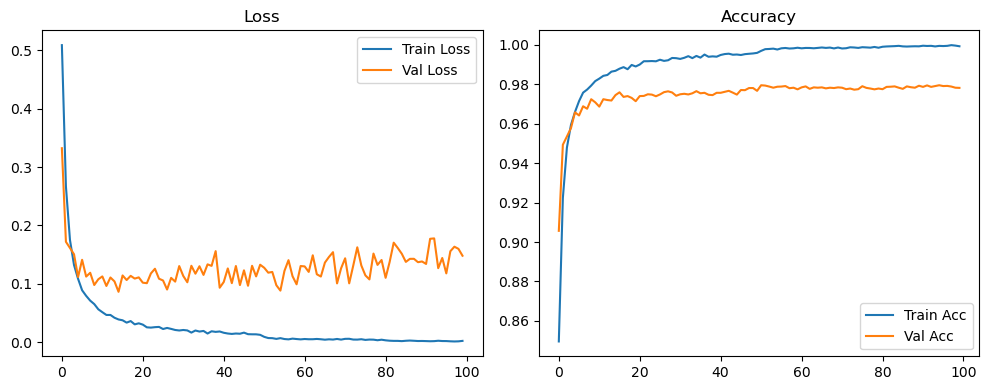

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6267, Acc: 0.8146 | Val Loss: 0.3982, Acc: 0.8958


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3581, Acc: 0.8938 | Val Loss: 0.2254, Acc: 0.9327


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2659, Acc: 0.9214 | Val Loss: 0.1924, Acc: 0.9426


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2143, Acc: 0.9354 | Val Loss: 0.1642, Acc: 0.9511


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1837, Acc: 0.9440 | Val Loss: 0.1402, Acc: 0.9586


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1619, Acc: 0.9505 | Val Loss: 0.1405, Acc: 0.9591


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1439, Acc: 0.9562 | Val Loss: 0.1190, Acc: 0.9646


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1267, Acc: 0.9616 | Val Loss: 0.1198, Acc: 0.9665


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9632 | Val Loss: 0.1214, Acc: 0.9683


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1064, Acc: 0.9675 | Val Loss: 0.1065, Acc: 0.9676


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0978, Acc: 0.9699 | Val Loss: 0.1184, Acc: 0.9683


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9722 | Val Loss: 0.1030, Acc: 0.9700


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9707 | Val Loss: 0.1076, Acc: 0.9700


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9738 | Val Loss: 0.1119, Acc: 0.9742


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9763 | Val Loss: 0.0974, Acc: 0.9731


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9766 | Val Loss: 0.0990, Acc: 0.9739


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9786 | Val Loss: 0.0990, Acc: 0.9739


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9786 | Val Loss: 0.1012, Acc: 0.9727


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9793 | Val Loss: 0.1098, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9807 | Val Loss: 0.0942, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9823 | Val Loss: 0.1075, Acc: 0.9736


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9832 | Val Loss: 0.1041, Acc: 0.9753


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9834 | Val Loss: 0.1132, Acc: 0.9763


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9843 | Val Loss: 0.0943, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9851 | Val Loss: 0.0915, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9846 | Val Loss: 0.0849, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9852 | Val Loss: 0.0887, Acc: 0.9782


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9864 | Val Loss: 0.0878, Acc: 0.9763


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9862 | Val Loss: 0.1010, Acc: 0.9768


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9871 | Val Loss: 0.0986, Acc: 0.9773


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 0.0890, Acc: 0.9773


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9877 | Val Loss: 0.0838, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9884 | Val Loss: 0.0916, Acc: 0.9779


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9884 | Val Loss: 0.1112, Acc: 0.9771


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 0.1101, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9892 | Val Loss: 0.0917, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9889 | Val Loss: 0.0961, Acc: 0.9785


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1056, Acc: 0.9779


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9892 | Val Loss: 0.0927, Acc: 0.9777


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0964, Acc: 0.9781


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9903 | Val Loss: 0.0789, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.0892, Acc: 0.9790


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0876, Acc: 0.9788


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.0825, Acc: 0.9791


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9915 | Val Loss: 0.1040, Acc: 0.9784


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9910 | Val Loss: 0.0930, Acc: 0.9777


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.0888, Acc: 0.9784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.1086, Acc: 0.9792


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.0963, Acc: 0.9785


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.0956, Acc: 0.9782


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0863, Acc: 0.9791


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0935, Acc: 0.9792


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9949 | Val Loss: 0.1039, Acc: 0.9798


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.1079, Acc: 0.9802


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1145, Acc: 0.9800


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9953 | Val Loss: 0.0770, Acc: 0.9799


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1191, Acc: 0.9798


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9954 | Val Loss: 0.0883, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1163, Acc: 0.9803


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1369, Acc: 0.9792


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.1128, Acc: 0.9800


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0848, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0916, Acc: 0.9810


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1004, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1245, Acc: 0.9802


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1386, Acc: 0.9794


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1035, Acc: 0.9785


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1167, Acc: 0.9803


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.1102, Acc: 0.9792


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.0901, Acc: 0.9809


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0933, Acc: 0.9802


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1042, Acc: 0.9789


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1122, Acc: 0.9789


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1388, Acc: 0.9796


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1123, Acc: 0.9800


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1127, Acc: 0.9796


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1169, Acc: 0.9798


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1020, Acc: 0.9799


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1117, Acc: 0.9798


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0953, Acc: 0.9799


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1249, Acc: 0.9802


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1103, Acc: 0.9802


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1092, Acc: 0.9798


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1156, Acc: 0.9804


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1149, Acc: 0.9808


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1003, Acc: 0.9801


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1060, Acc: 0.9802


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1265, Acc: 0.9804


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1150, Acc: 0.9804


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1100, Acc: 0.9804


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1011, Acc: 0.9808


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1183, Acc: 0.9809


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1187, Acc: 0.9799


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1138, Acc: 0.9808


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0971, Acc: 0.9809


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1023, Acc: 0.9808


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1110, Acc: 0.9808


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1232, Acc: 0.9802


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1171, Acc: 0.9810


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0994, Acc: 0.9812


Final Test Loss: 0.0905 Accuracy: 0.9836


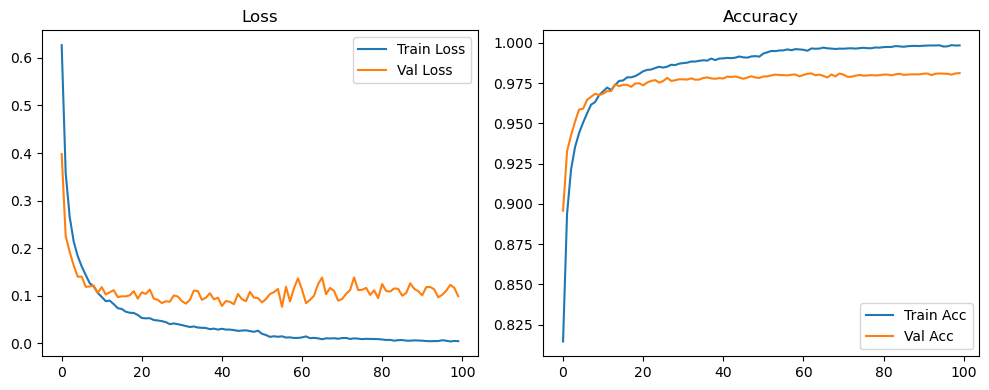

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4657, Acc: 0.8622 | Val Loss: 0.2732, Acc: 0.9189


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1864, Acc: 0.9455 | Val Loss: 0.1743, Acc: 0.9513


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1131, Acc: 0.9653 | Val Loss: 0.1422, Acc: 0.9593


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9776 | Val Loss: 0.1524, Acc: 0.9597


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9810 | Val Loss: 0.1298, Acc: 0.9668


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.1477, Acc: 0.9597


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9875 | Val Loss: 0.1221, Acc: 0.9682


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.1512, Acc: 0.9630


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9913 | Val Loss: 0.1096, Acc: 0.9736


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9909 | Val Loss: 0.1446, Acc: 0.9657


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.1497, Acc: 0.9661


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.1103, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.1353, Acc: 0.9689


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1425, Acc: 0.9694


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.1295, Acc: 0.9729


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.1884, Acc: 0.9603


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1447, Acc: 0.9714


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9965 | Val Loss: 0.1842, Acc: 0.9657


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1378, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1104, Acc: 0.9752


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.2068, Acc: 0.9663


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1791, Acc: 0.9607


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.2992, Acc: 0.9448


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.3272, Acc: 0.9437


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.1235, Acc: 0.9741


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1313, Acc: 0.9704


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1258, Acc: 0.9699


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1364, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9976 | Val Loss: 0.1975, Acc: 0.9463


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1157, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1388, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.2665, Acc: 0.9583


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1529, Acc: 0.9688


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1448, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1267, Acc: 0.9722


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1547, Acc: 0.9732


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1140, Acc: 0.9735


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.2012, Acc: 0.9647


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.3996, Acc: 0.9365


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1521, Acc: 0.9759


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.3414, Acc: 0.9443


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1692, Acc: 0.9736


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.2018, Acc: 0.9620


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1248, Acc: 0.9733


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.2823, Acc: 0.9609


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.6852, Acc: 0.8582


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.7112, Acc: 0.8955


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.2231, Acc: 0.9637


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1022, Acc: 0.9768


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9977 | Val Loss: 0.1919, Acc: 0.9607


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1228, Acc: 0.9789


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1750, Acc: 0.9773


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1325, Acc: 0.9787


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1273, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1362, Acc: 0.9787


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1857, Acc: 0.9768


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1901, Acc: 0.9788


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1395, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1645, Acc: 0.9797


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1412, Acc: 0.9775


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1986, Acc: 0.9788


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2336, Acc: 0.9718


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.2931, Acc: 0.9532


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.7105, Acc: 0.8638


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1537, Acc: 0.9769


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.2004, Acc: 0.9727


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.1523, Acc: 0.9787


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1029, Acc: 0.9792


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2866, Acc: 0.9708


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1624, Acc: 0.9794


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1064, Acc: 0.9796


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1486, Acc: 0.9778


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1683, Acc: 0.9797


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1505, Acc: 0.9777


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1540, Acc: 0.9799


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1972, Acc: 0.9762


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1820, Acc: 0.9748


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1900, Acc: 0.9759


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.2304, Acc: 0.9747


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1815, Acc: 0.9765


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1337, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1525, Acc: 0.9797


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1664, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1540, Acc: 0.9796


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1639, Acc: 0.9798


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1781, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1869, Acc: 0.9793


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1851, Acc: 0.9798


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1939, Acc: 0.9801


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1730, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1671, Acc: 0.9799


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1860, Acc: 0.9806


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1626, Acc: 0.9802


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1824, Acc: 0.9792


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1943, Acc: 0.9799


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1648, Acc: 0.9804


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1962, Acc: 0.9799


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1582, Acc: 0.9798


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1871, Acc: 0.9796


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2178, Acc: 0.9791


Final Test Loss: 0.1778 Accuracy: 0.9821


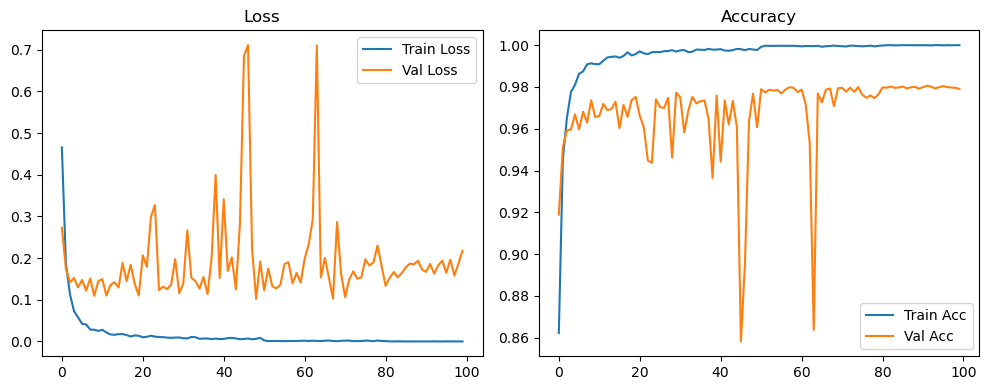

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5092, Acc: 0.8496 | Val Loss: 0.3325, Acc: 0.9057


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2669, Acc: 0.9223 | Val Loss: 0.1720, Acc: 0.9493


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1751, Acc: 0.9479 | Val Loss: 0.1614, Acc: 0.9535


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1322, Acc: 0.9594 | Val Loss: 0.1506, Acc: 0.9577


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9660 | Val Loss: 0.1116, Acc: 0.9657


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9714 | Val Loss: 0.1411, Acc: 0.9642


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9758 | Val Loss: 0.1124, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9773 | Val Loss: 0.1189, Acc: 0.9676


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9793 | Val Loss: 0.0979, Acc: 0.9724


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9816 | Val Loss: 0.1077, Acc: 0.9708


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9829 | Val Loss: 0.1126, Acc: 0.9687


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9843 | Val Loss: 0.0963, Acc: 0.9724


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9847 | Val Loss: 0.1108, Acc: 0.9720


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9864 | Val Loss: 0.1041, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9868 | Val Loss: 0.0863, Acc: 0.9745


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9879 | Val Loss: 0.1143, Acc: 0.9759


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9887 | Val Loss: 0.1064, Acc: 0.9736


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9876 | Val Loss: 0.1136, Acc: 0.9740


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9898 | Val Loss: 0.1089, Acc: 0.9731


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9890 | Val Loss: 0.1110, Acc: 0.9714


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.1019, Acc: 0.9740


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.1011, Acc: 0.9741


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.1178, Acc: 0.9749


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.1258, Acc: 0.9748


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.1087, Acc: 0.9739


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.1057, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.0902, Acc: 0.9760


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9922 | Val Loss: 0.1102, Acc: 0.9764


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.1037, Acc: 0.9758


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1304, Acc: 0.9742


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.1134, Acc: 0.9749


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.1026, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9942 | Val Loss: 0.1309, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1173, Acc: 0.9754


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.1301, Acc: 0.9765


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1152, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1333, Acc: 0.9757


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1307, Acc: 0.9747


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1560, Acc: 0.9745


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0932, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.1031, Acc: 0.9757


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.1263, Acc: 0.9762


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.1011, Acc: 0.9767


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1305, Acc: 0.9758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0978, Acc: 0.9748


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.1231, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.0966, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.1308, Acc: 0.9781


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1127, Acc: 0.9781


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1327, Acc: 0.9767


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1275, Acc: 0.9795


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1191, Acc: 0.9793


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1203, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0975, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0883, Acc: 0.9788


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1221, Acc: 0.9788


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1405, Acc: 0.9791


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1129, Acc: 0.9780


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0991, Acc: 0.9782


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1304, Acc: 0.9774


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1298, Acc: 0.9784


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1204, Acc: 0.9789


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1489, Acc: 0.9777


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1163, Acc: 0.9784


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1124, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1363, Acc: 0.9784


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1460, Acc: 0.9779


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1542, Acc: 0.9782


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1007, Acc: 0.9781


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1266, Acc: 0.9784


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1437, Acc: 0.9782


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1007, Acc: 0.9775


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1311, Acc: 0.9778


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1626, Acc: 0.9772


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1314, Acc: 0.9775


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1144, Acc: 0.9790


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1075, Acc: 0.9782


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1518, Acc: 0.9778


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1324, Acc: 0.9774


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1408, Acc: 0.9778


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1141, Acc: 0.9781


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1254, Acc: 0.9783


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1503, Acc: 0.9785


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1553, Acc: 0.9781


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1437, Acc: 0.9788


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.1387, Acc: 0.9784


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1304, Acc: 0.9789


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1368, Acc: 0.9790


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1396, Acc: 0.9799


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1392, Acc: 0.9793


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1416, Acc: 0.9792


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1597, Acc: 0.9792


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1633, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1331, Acc: 0.9797


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1385, Acc: 0.9802


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1318, Acc: 0.9797


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1580, Acc: 0.9795


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1674, Acc: 0.9795


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1594, Acc: 0.9792


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1316, Acc: 0.9790


Final Test Loss: 0.1165 Accuracy: 0.9810


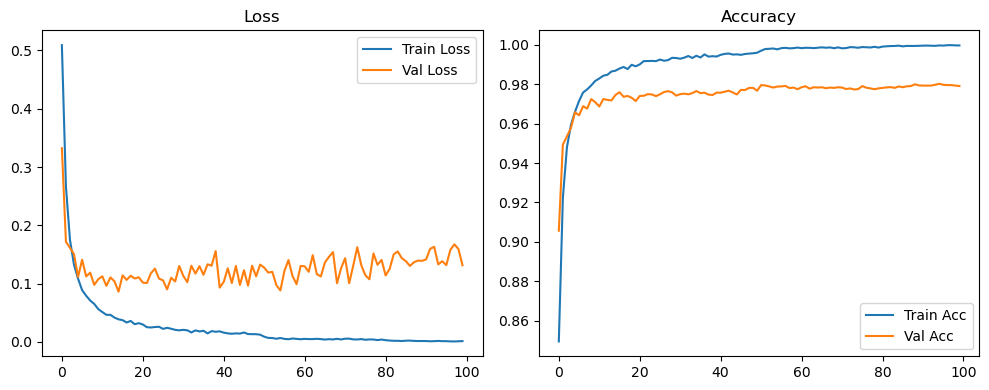

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6267, Acc: 0.8146 | Val Loss: 0.3982, Acc: 0.8958


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3581, Acc: 0.8938 | Val Loss: 0.2254, Acc: 0.9327


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2659, Acc: 0.9214 | Val Loss: 0.1924, Acc: 0.9426


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2143, Acc: 0.9354 | Val Loss: 0.1642, Acc: 0.9511


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1837, Acc: 0.9440 | Val Loss: 0.1402, Acc: 0.9586


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1619, Acc: 0.9505 | Val Loss: 0.1405, Acc: 0.9591


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1439, Acc: 0.9562 | Val Loss: 0.1190, Acc: 0.9646


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1267, Acc: 0.9616 | Val Loss: 0.1198, Acc: 0.9665


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9632 | Val Loss: 0.1214, Acc: 0.9683


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1064, Acc: 0.9675 | Val Loss: 0.1065, Acc: 0.9676


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0978, Acc: 0.9699 | Val Loss: 0.1184, Acc: 0.9683


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9722 | Val Loss: 0.1030, Acc: 0.9700


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9707 | Val Loss: 0.1076, Acc: 0.9700


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9738 | Val Loss: 0.1119, Acc: 0.9742


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9763 | Val Loss: 0.0974, Acc: 0.9731


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9766 | Val Loss: 0.0990, Acc: 0.9739


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9786 | Val Loss: 0.0990, Acc: 0.9739


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9786 | Val Loss: 0.1012, Acc: 0.9727


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9793 | Val Loss: 0.1098, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9807 | Val Loss: 0.0942, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9823 | Val Loss: 0.1075, Acc: 0.9736


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9832 | Val Loss: 0.1041, Acc: 0.9753


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9834 | Val Loss: 0.1132, Acc: 0.9763


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9843 | Val Loss: 0.0943, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9851 | Val Loss: 0.0915, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9846 | Val Loss: 0.0849, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9852 | Val Loss: 0.0887, Acc: 0.9782


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9864 | Val Loss: 0.0878, Acc: 0.9763


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9862 | Val Loss: 0.1010, Acc: 0.9768


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9871 | Val Loss: 0.0986, Acc: 0.9773


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 0.0890, Acc: 0.9773


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9877 | Val Loss: 0.0838, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9884 | Val Loss: 0.0916, Acc: 0.9779


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9884 | Val Loss: 0.1112, Acc: 0.9771


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 0.1101, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9892 | Val Loss: 0.0917, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9889 | Val Loss: 0.0961, Acc: 0.9785


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1056, Acc: 0.9779


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9892 | Val Loss: 0.0927, Acc: 0.9777


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0964, Acc: 0.9781


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9903 | Val Loss: 0.0789, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.0892, Acc: 0.9790


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0876, Acc: 0.9788


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.0825, Acc: 0.9791


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9915 | Val Loss: 0.1040, Acc: 0.9784


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9910 | Val Loss: 0.0930, Acc: 0.9777


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.0888, Acc: 0.9784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.1086, Acc: 0.9792


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.0963, Acc: 0.9785


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.0956, Acc: 0.9782


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0863, Acc: 0.9791


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0935, Acc: 0.9792


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9949 | Val Loss: 0.1039, Acc: 0.9798


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.1079, Acc: 0.9802


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1145, Acc: 0.9800


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9953 | Val Loss: 0.0770, Acc: 0.9799


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1191, Acc: 0.9798


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9954 | Val Loss: 0.0883, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1163, Acc: 0.9803


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1369, Acc: 0.9792


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.1128, Acc: 0.9800


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0848, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0916, Acc: 0.9810


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1004, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1245, Acc: 0.9802


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1386, Acc: 0.9794


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1035, Acc: 0.9785


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1167, Acc: 0.9803


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.1102, Acc: 0.9792


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.0901, Acc: 0.9809


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0933, Acc: 0.9802


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1042, Acc: 0.9789


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1122, Acc: 0.9789


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1388, Acc: 0.9796


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1123, Acc: 0.9800


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1127, Acc: 0.9796


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1169, Acc: 0.9798


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1020, Acc: 0.9799


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1117, Acc: 0.9798


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0953, Acc: 0.9799


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1135, Acc: 0.9804


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1054, Acc: 0.9802


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1062, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1189, Acc: 0.9802


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1037, Acc: 0.9800


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1040, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1191, Acc: 0.9803


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1215, Acc: 0.9805


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1119, Acc: 0.9808


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1062, Acc: 0.9809


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1079, Acc: 0.9805


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1224, Acc: 0.9804


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1212, Acc: 0.9801


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1099, Acc: 0.9802


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1097, Acc: 0.9806


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1066, Acc: 0.9809


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.1085, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1139, Acc: 0.9805


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1115, Acc: 0.9807


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1185, Acc: 0.9808


Final Test Loss: 0.1082 Accuracy: 0.9839


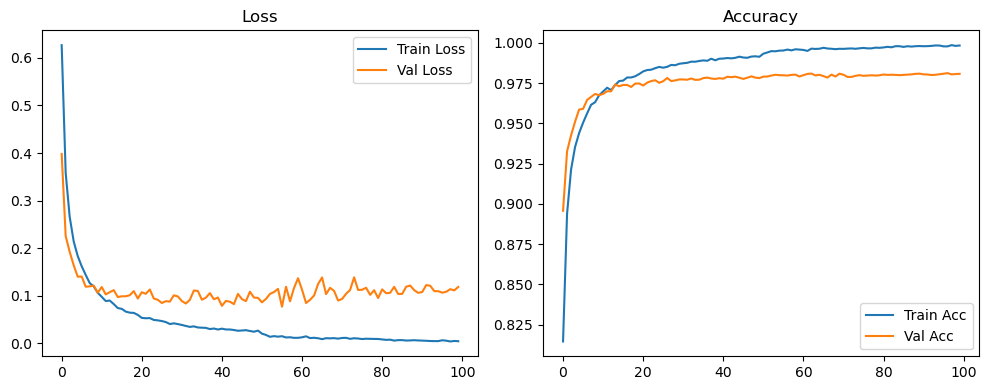

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4657, Acc: 0.8622 | Val Loss: 0.2732, Acc: 0.9189


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1864, Acc: 0.9455 | Val Loss: 0.1743, Acc: 0.9513


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1131, Acc: 0.9653 | Val Loss: 0.1422, Acc: 0.9593


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9776 | Val Loss: 0.1524, Acc: 0.9597


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9810 | Val Loss: 0.1298, Acc: 0.9668


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.1477, Acc: 0.9597


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9875 | Val Loss: 0.1221, Acc: 0.9682


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.1512, Acc: 0.9630


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9913 | Val Loss: 0.1096, Acc: 0.9736


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9909 | Val Loss: 0.1446, Acc: 0.9657


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.1497, Acc: 0.9661


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.1103, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.1353, Acc: 0.9689


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1425, Acc: 0.9694


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.1295, Acc: 0.9729


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.1884, Acc: 0.9603


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1447, Acc: 0.9714


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9965 | Val Loss: 0.1842, Acc: 0.9657


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1378, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1104, Acc: 0.9752


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.2068, Acc: 0.9663


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1791, Acc: 0.9607


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.2992, Acc: 0.9448


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.3272, Acc: 0.9437


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.1235, Acc: 0.9741


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1313, Acc: 0.9704


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1258, Acc: 0.9699


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1364, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9976 | Val Loss: 0.1975, Acc: 0.9463


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1157, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1388, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.2665, Acc: 0.9583


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1529, Acc: 0.9688


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1448, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1267, Acc: 0.9722


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1547, Acc: 0.9732


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1140, Acc: 0.9735


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.2012, Acc: 0.9647


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.3996, Acc: 0.9365


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1521, Acc: 0.9759


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.3414, Acc: 0.9443


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1692, Acc: 0.9736


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.2018, Acc: 0.9620


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1248, Acc: 0.9733


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.2823, Acc: 0.9609


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.6852, Acc: 0.8582


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.7112, Acc: 0.8955


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.2231, Acc: 0.9637


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1022, Acc: 0.9768


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9977 | Val Loss: 0.1919, Acc: 0.9607


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1278, Acc: 0.9790


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1431, Acc: 0.9782


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1597, Acc: 0.9782


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1631, Acc: 0.9801


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1652, Acc: 0.9783


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1611, Acc: 0.9791


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1561, Acc: 0.9790


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1726, Acc: 0.9783


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1572, Acc: 0.9792


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1781, Acc: 0.9792


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1716, Acc: 0.9792


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2011, Acc: 0.9798


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1581, Acc: 0.9802


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1592, Acc: 0.9804


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1697, Acc: 0.9798


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1961, Acc: 0.9795


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1763, Acc: 0.9795


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1470, Acc: 0.9803


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1793, Acc: 0.9798


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1431, Acc: 0.9800


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1732, Acc: 0.9798


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1970, Acc: 0.9798


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1788, Acc: 0.9812


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1937, Acc: 0.9811


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2162, Acc: 0.9792


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1898, Acc: 0.9792


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1970, Acc: 0.9792


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2101, Acc: 0.9781


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1737, Acc: 0.9785


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1867, Acc: 0.9790


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2052, Acc: 0.9792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2182, Acc: 0.9800


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2020, Acc: 0.9799


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1854, Acc: 0.9795


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1528, Acc: 0.9801


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1793, Acc: 0.9796


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1839, Acc: 0.9797


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2002, Acc: 0.9798


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2098, Acc: 0.9802


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2305, Acc: 0.9799


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2383, Acc: 0.9796


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2470, Acc: 0.9800


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1948, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2090, Acc: 0.9799


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2134, Acc: 0.9798


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2295, Acc: 0.9796


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1875, Acc: 0.9798


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1975, Acc: 0.9798


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2145, Acc: 0.9795


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2383, Acc: 0.9798


Final Test Loss: 0.1809 Accuracy: 0.9831


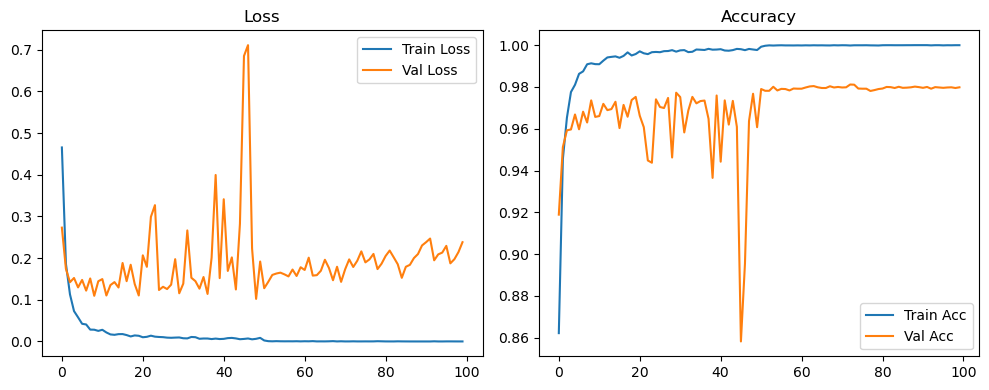

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5092, Acc: 0.8496 | Val Loss: 0.3325, Acc: 0.9057


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2669, Acc: 0.9223 | Val Loss: 0.1720, Acc: 0.9493


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1751, Acc: 0.9479 | Val Loss: 0.1614, Acc: 0.9535


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1322, Acc: 0.9594 | Val Loss: 0.1506, Acc: 0.9577


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9660 | Val Loss: 0.1116, Acc: 0.9657


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9714 | Val Loss: 0.1411, Acc: 0.9642


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9758 | Val Loss: 0.1124, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9773 | Val Loss: 0.1189, Acc: 0.9676


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9793 | Val Loss: 0.0979, Acc: 0.9724


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9816 | Val Loss: 0.1077, Acc: 0.9708


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9829 | Val Loss: 0.1126, Acc: 0.9687


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9843 | Val Loss: 0.0963, Acc: 0.9724


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9847 | Val Loss: 0.1108, Acc: 0.9720


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9864 | Val Loss: 0.1041, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9868 | Val Loss: 0.0863, Acc: 0.9745


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9879 | Val Loss: 0.1143, Acc: 0.9759


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9887 | Val Loss: 0.1064, Acc: 0.9736


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9876 | Val Loss: 0.1136, Acc: 0.9740


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9898 | Val Loss: 0.1089, Acc: 0.9731


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9890 | Val Loss: 0.1110, Acc: 0.9714


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.1019, Acc: 0.9740


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.1011, Acc: 0.9741


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.1178, Acc: 0.9749


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.1258, Acc: 0.9748


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.1087, Acc: 0.9739


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.1057, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.0902, Acc: 0.9760


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9922 | Val Loss: 0.1102, Acc: 0.9764


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.1037, Acc: 0.9758


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1304, Acc: 0.9742


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.1134, Acc: 0.9749


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.1026, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9942 | Val Loss: 0.1309, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1173, Acc: 0.9754


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.1301, Acc: 0.9765


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1152, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1333, Acc: 0.9757


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1307, Acc: 0.9747


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1560, Acc: 0.9745


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0932, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.1031, Acc: 0.9757


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.1263, Acc: 0.9762


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.1011, Acc: 0.9767


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1305, Acc: 0.9758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0978, Acc: 0.9748


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.1231, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.0966, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.1308, Acc: 0.9781


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1127, Acc: 0.9781


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1327, Acc: 0.9767


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1192, Acc: 0.9782


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1225, Acc: 0.9789


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1104, Acc: 0.9783


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.1078, Acc: 0.9795


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1159, Acc: 0.9787


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1300, Acc: 0.9796


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1238, Acc: 0.9790


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1290, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1095, Acc: 0.9793


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1389, Acc: 0.9798


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1210, Acc: 0.9801


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0954, Acc: 0.9805


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1277, Acc: 0.9798


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1295, Acc: 0.9798


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1432, Acc: 0.9794


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1413, Acc: 0.9789


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1510, Acc: 0.9798


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1567, Acc: 0.9787


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1264, Acc: 0.9794


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1304, Acc: 0.9794


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1252, Acc: 0.9798


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1087, Acc: 0.9791


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1267, Acc: 0.9798


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1255, Acc: 0.9796


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1354, Acc: 0.9797


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1056, Acc: 0.9801


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1455, Acc: 0.9805


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1178, Acc: 0.9803


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1349, Acc: 0.9802


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1376, Acc: 0.9801


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1311, Acc: 0.9802


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1427, Acc: 0.9798


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1347, Acc: 0.9805


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1285, Acc: 0.9796


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1402, Acc: 0.9798


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1304, Acc: 0.9804


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1205, Acc: 0.9798


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1251, Acc: 0.9803


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1289, Acc: 0.9806


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1332, Acc: 0.9797


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1399, Acc: 0.9801


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1472, Acc: 0.9798


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1404, Acc: 0.9801


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1502, Acc: 0.9804


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1498, Acc: 0.9795


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1537, Acc: 0.9802


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1607, Acc: 0.9807


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1718, Acc: 0.9802


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1487, Acc: 0.9798


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1382, Acc: 0.9801


Final Test Loss: 0.1254 Accuracy: 0.9823


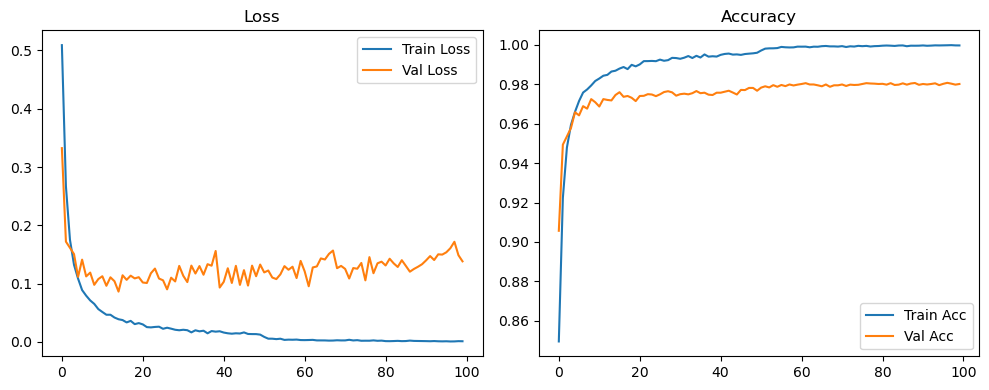

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6267, Acc: 0.8146 | Val Loss: 0.3982, Acc: 0.8958


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3581, Acc: 0.8938 | Val Loss: 0.2254, Acc: 0.9327


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2659, Acc: 0.9214 | Val Loss: 0.1924, Acc: 0.9426


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2143, Acc: 0.9354 | Val Loss: 0.1642, Acc: 0.9511


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1837, Acc: 0.9440 | Val Loss: 0.1402, Acc: 0.9586


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1619, Acc: 0.9505 | Val Loss: 0.1405, Acc: 0.9591


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1439, Acc: 0.9562 | Val Loss: 0.1190, Acc: 0.9646


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1267, Acc: 0.9616 | Val Loss: 0.1198, Acc: 0.9665


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9632 | Val Loss: 0.1214, Acc: 0.9683


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1064, Acc: 0.9675 | Val Loss: 0.1065, Acc: 0.9676


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0978, Acc: 0.9699 | Val Loss: 0.1184, Acc: 0.9683


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9722 | Val Loss: 0.1030, Acc: 0.9700


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9707 | Val Loss: 0.1076, Acc: 0.9700


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9738 | Val Loss: 0.1119, Acc: 0.9742


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9763 | Val Loss: 0.0974, Acc: 0.9731


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9766 | Val Loss: 0.0990, Acc: 0.9739


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9786 | Val Loss: 0.0990, Acc: 0.9739


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9786 | Val Loss: 0.1012, Acc: 0.9727


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9793 | Val Loss: 0.1098, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9807 | Val Loss: 0.0942, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9823 | Val Loss: 0.1075, Acc: 0.9736


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9832 | Val Loss: 0.1041, Acc: 0.9753


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9834 | Val Loss: 0.1132, Acc: 0.9763


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9843 | Val Loss: 0.0943, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9851 | Val Loss: 0.0915, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9846 | Val Loss: 0.0849, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9852 | Val Loss: 0.0887, Acc: 0.9782


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9864 | Val Loss: 0.0878, Acc: 0.9763


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9862 | Val Loss: 0.1010, Acc: 0.9768


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9871 | Val Loss: 0.0986, Acc: 0.9773


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 0.0890, Acc: 0.9773


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9877 | Val Loss: 0.0838, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9884 | Val Loss: 0.0916, Acc: 0.9779


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9884 | Val Loss: 0.1112, Acc: 0.9771


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 0.1101, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9892 | Val Loss: 0.0917, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9889 | Val Loss: 0.0961, Acc: 0.9785


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1056, Acc: 0.9779


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9892 | Val Loss: 0.0927, Acc: 0.9777


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0964, Acc: 0.9781


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9903 | Val Loss: 0.0789, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.0892, Acc: 0.9790


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0876, Acc: 0.9788


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.0825, Acc: 0.9791


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9915 | Val Loss: 0.1040, Acc: 0.9784


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9910 | Val Loss: 0.0930, Acc: 0.9777


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.0888, Acc: 0.9784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.1086, Acc: 0.9792


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.0963, Acc: 0.9785


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.0956, Acc: 0.9782


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0959, Acc: 0.9788


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9938 | Val Loss: 0.0961, Acc: 0.9796


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0954, Acc: 0.9807


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.0921, Acc: 0.9804


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.0974, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.0857, Acc: 0.9810


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.1072, Acc: 0.9802


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1014, Acc: 0.9806


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0984, Acc: 0.9811


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1131, Acc: 0.9802


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0943, Acc: 0.9801


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0976, Acc: 0.9801


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1190, Acc: 0.9798


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.0910, Acc: 0.9802


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9971 | Val Loss: 0.1159, Acc: 0.9807


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1220, Acc: 0.9802


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1073, Acc: 0.9805


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1161, Acc: 0.9810


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.1017, Acc: 0.9799


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 0.1042, Acc: 0.9804


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1110, Acc: 0.9811


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1013, Acc: 0.9808


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1256, Acc: 0.9804


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9970 | Val Loss: 0.1113, Acc: 0.9808


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1076, Acc: 0.9808


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1132, Acc: 0.9802


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1083, Acc: 0.9800


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9976 | Val Loss: 0.1128, Acc: 0.9792


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1192, Acc: 0.9800


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1024, Acc: 0.9802


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1095, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1010, Acc: 0.9804


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0981, Acc: 0.9798


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1152, Acc: 0.9805


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9979 | Val Loss: 0.1101, Acc: 0.9808


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1180, Acc: 0.9801


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1151, Acc: 0.9808


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1174, Acc: 0.9807


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1188, Acc: 0.9811


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1232, Acc: 0.9806


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1054, Acc: 0.9802


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1257, Acc: 0.9807


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1099, Acc: 0.9811


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1194, Acc: 0.9812


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0988, Acc: 0.9809


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1017, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1121, Acc: 0.9810


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1100, Acc: 0.9806


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1263, Acc: 0.9812


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1167, Acc: 0.9812


Final Test Loss: 0.1050 Accuracy: 0.9842


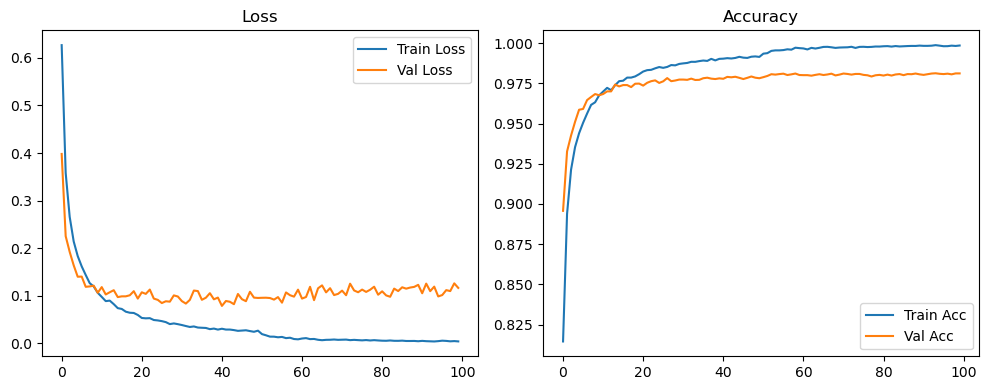

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4127, Acc: 0.8737 | Val Loss: 0.2684, Acc: 0.9202


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1849, Acc: 0.9444 | Val Loss: 0.1740, Acc: 0.9487


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1096, Acc: 0.9664 | Val Loss: 0.1286, Acc: 0.9608


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9775 | Val Loss: 0.1449, Acc: 0.9582


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9838 | Val Loss: 0.1244, Acc: 0.9673


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9868 | Val Loss: 0.1343, Acc: 0.9655


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9881 | Val Loss: 0.1323, Acc: 0.9693


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9916 | Val Loss: 0.1390, Acc: 0.9652


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.1081, Acc: 0.9728


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9931 | Val Loss: 0.1424, Acc: 0.9661


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.1180, Acc: 0.9696


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9933 | Val Loss: 0.1712, Acc: 0.9584


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.1755, Acc: 0.9666


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.1622, Acc: 0.9668


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.1607, Acc: 0.9680


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1234, Acc: 0.9715


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.1330, Acc: 0.9754


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1472, Acc: 0.9691


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1282, Acc: 0.9744


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.1407, Acc: 0.9727


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1462, Acc: 0.9739


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1522, Acc: 0.9712


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1395, Acc: 0.9698


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1145, Acc: 0.9763


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.1726, Acc: 0.9706


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1151, Acc: 0.9776


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1371, Acc: 0.9698


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1605, Acc: 0.9723


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1364, Acc: 0.9754


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1485, Acc: 0.9743


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1402, Acc: 0.9738


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9969 | Val Loss: 0.1713, Acc: 0.9710


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1143, Acc: 0.9776


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1115, Acc: 0.9781


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1488, Acc: 0.9728


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1362, Acc: 0.9737


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1674, Acc: 0.9696


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1252, Acc: 0.9777


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1646, Acc: 0.9692


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1077, Acc: 0.9745


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1457, Acc: 0.9748


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1339, Acc: 0.9758


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1498, Acc: 0.9764


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1290, Acc: 0.9725


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1681, Acc: 0.9611


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1330, Acc: 0.9747


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.2346, Acc: 0.9612


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1284, Acc: 0.9777


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.2227, Acc: 0.9712


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1238, Acc: 0.9771


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.2175, Acc: 0.9677


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.2583, Acc: 0.9388


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1247, Acc: 0.9768


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1501, Acc: 0.9781


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1109, Acc: 0.9745


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1271, Acc: 0.9778


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1642, Acc: 0.9748


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1375, Acc: 0.9742


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1390, Acc: 0.9768


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1083, Acc: 0.9782


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1119, Acc: 0.9778


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1644, Acc: 0.9700


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1715, Acc: 0.9757


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1450, Acc: 0.9771


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1546, Acc: 0.9790


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1490, Acc: 0.9735


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1350, Acc: 0.9761


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1311, Acc: 0.9750


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1280, Acc: 0.9735


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1466, Acc: 0.9787


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1308, Acc: 0.9713


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1418, Acc: 0.9794


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1279, Acc: 0.9790


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1321, Acc: 0.9750


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1534, Acc: 0.9768


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.2972, Acc: 0.9411


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1536, Acc: 0.9735


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1442, Acc: 0.9779


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1868, Acc: 0.9769


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.2040, Acc: 0.9770


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1552, Acc: 0.9790


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1484, Acc: 0.9785


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1338, Acc: 0.9741


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.2095, Acc: 0.9672


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1249, Acc: 0.9774


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1523, Acc: 0.9786


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1381, Acc: 0.9787


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1524, Acc: 0.9787


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1231, Acc: 0.9785


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.2595, Acc: 0.9243


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1370, Acc: 0.9744


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.5020, Acc: 0.8992


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1305, Acc: 0.9810


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1394, Acc: 0.9748


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1258, Acc: 0.9758


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1078, Acc: 0.9747


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.4103, Acc: 0.9376


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1797, Acc: 0.9755


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.1997, Acc: 0.9708


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1364, Acc: 0.9758


Final Test Loss: 0.1233 Accuracy: 0.9773


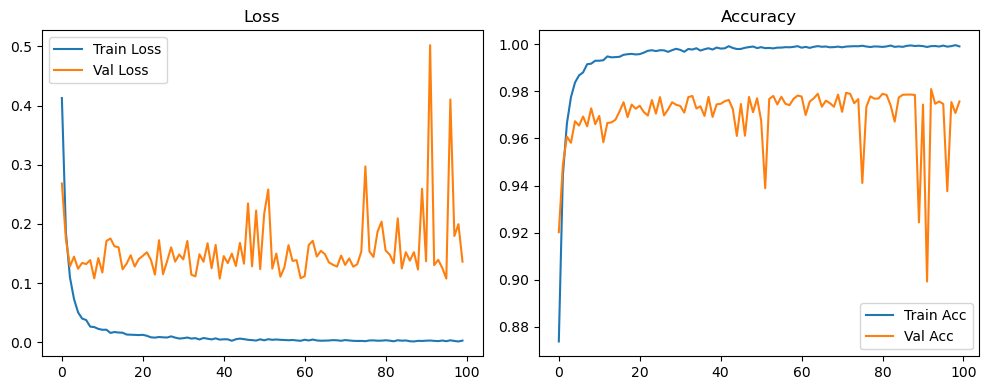

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4534, Acc: 0.8614 | Val Loss: 0.3187, Acc: 0.9059


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2570, Acc: 0.9233 | Val Loss: 0.1720, Acc: 0.9477


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1740, Acc: 0.9474 | Val Loss: 0.1406, Acc: 0.9594


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1368, Acc: 0.9585 | Val Loss: 0.1328, Acc: 0.9633


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1119, Acc: 0.9647 | Val Loss: 0.1142, Acc: 0.9672


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0950, Acc: 0.9708 | Val Loss: 0.1321, Acc: 0.9643


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0847, Acc: 0.9732 | Val Loss: 0.1044, Acc: 0.9692


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0721, Acc: 0.9775 | Val Loss: 0.1110, Acc: 0.9698


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0674, Acc: 0.9784 | Val Loss: 0.0996, Acc: 0.9712


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9800 | Val Loss: 0.0991, Acc: 0.9718


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9826 | Val Loss: 0.0994, Acc: 0.9717


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9841 | Val Loss: 0.1047, Acc: 0.9736


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9835 | Val Loss: 0.1068, Acc: 0.9737


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9858 | Val Loss: 0.1022, Acc: 0.9734


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9868 | Val Loss: 0.1011, Acc: 0.9741


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9870 | Val Loss: 0.0983, Acc: 0.9746


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9880 | Val Loss: 0.1077, Acc: 0.9733


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9886 | Val Loss: 0.1010, Acc: 0.9738


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9892 | Val Loss: 0.1054, Acc: 0.9733


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9893 | Val Loss: 0.1151, Acc: 0.9732


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.1041, Acc: 0.9751


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.1094, Acc: 0.9775


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9902 | Val Loss: 0.1004, Acc: 0.9760


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9918 | Val Loss: 0.0998, Acc: 0.9772


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.1122, Acc: 0.9747


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.1065, Acc: 0.9750


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9916 | Val Loss: 0.0883, Acc: 0.9762


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9918 | Val Loss: 0.1113, Acc: 0.9748


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9927 | Val Loss: 0.1154, Acc: 0.9750


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.1155, Acc: 0.9717


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.1005, Acc: 0.9768


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9931 | Val Loss: 0.1049, Acc: 0.9738


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.1219, Acc: 0.9751


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.1137, Acc: 0.9752


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9941 | Val Loss: 0.1140, Acc: 0.9749


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.1170, Acc: 0.9759


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.1074, Acc: 0.9769


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0959, Acc: 0.9781


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1046, Acc: 0.9786


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1285, Acc: 0.9744


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0893, Acc: 0.9774


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.1233, Acc: 0.9775


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1128, Acc: 0.9766


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9946 | Val Loss: 0.1124, Acc: 0.9765


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1176, Acc: 0.9761


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.1061, Acc: 0.9762


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9946 | Val Loss: 0.1165, Acc: 0.9778


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9954 | Val Loss: 0.1255, Acc: 0.9768


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1312, Acc: 0.9740


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.1000, Acc: 0.9785


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1337, Acc: 0.9753


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.1105, Acc: 0.9770


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.1028, Acc: 0.9782


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1210, Acc: 0.9760


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9951 | Val Loss: 0.1054, Acc: 0.9763


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1099, Acc: 0.9775


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.1210, Acc: 0.9771


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.1210, Acc: 0.9782


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1282, Acc: 0.9754


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1176, Acc: 0.9764


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1138, Acc: 0.9771


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.1068, Acc: 0.9788


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.1173, Acc: 0.9778


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1032, Acc: 0.9787


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1389, Acc: 0.9791


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1393, Acc: 0.9760


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1239, Acc: 0.9768


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1167, Acc: 0.9779


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1190, Acc: 0.9783


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1204, Acc: 0.9765


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.1081, Acc: 0.9783


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0909, Acc: 0.9785


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1134, Acc: 0.9792


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1041, Acc: 0.9786


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1058, Acc: 0.9773


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1336, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1423, Acc: 0.9689


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1235, Acc: 0.9784


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0975, Acc: 0.9774


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1124, Acc: 0.9747


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1135, Acc: 0.9780


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.1018, Acc: 0.9786


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1517, Acc: 0.9761


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1144, Acc: 0.9790


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1283, Acc: 0.9778


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0986, Acc: 0.9790


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0894, Acc: 0.9780


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1086, Acc: 0.9782


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1253, Acc: 0.9775


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1135, Acc: 0.9792


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1331, Acc: 0.9746


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1036, Acc: 0.9788


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1355, Acc: 0.9780


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.1280, Acc: 0.9789


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.1169, Acc: 0.9798


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1271, Acc: 0.9778


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1302, Acc: 0.9783


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.1132, Acc: 0.9797


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1144, Acc: 0.9780


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1185, Acc: 0.9776


Final Test Loss: 0.1041 Accuracy: 0.9810


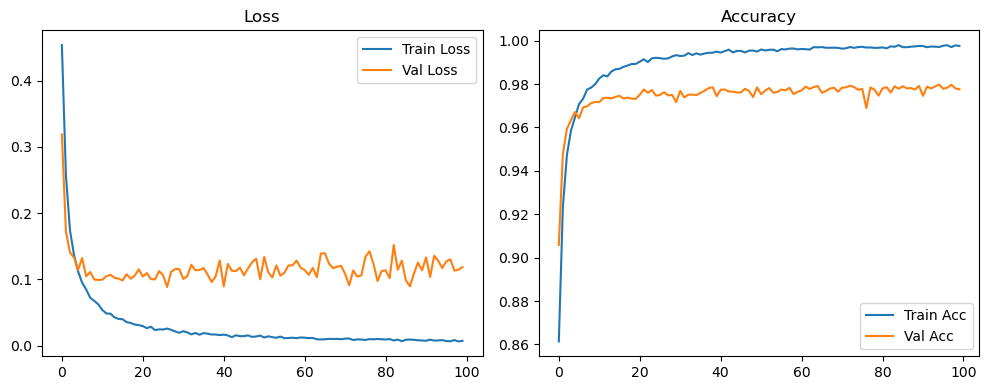

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5723, Acc: 0.8228 | Val Loss: 0.3327, Acc: 0.9028


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3775, Acc: 0.8860 | Val Loss: 0.2379, Acc: 0.9291


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2990, Acc: 0.9103 | Val Loss: 0.2160, Acc: 0.9366


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2456, Acc: 0.9261 | Val Loss: 0.1848, Acc: 0.9450


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2133, Acc: 0.9358 | Val Loss: 0.1532, Acc: 0.9546


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1936, Acc: 0.9414 | Val Loss: 0.1641, Acc: 0.9536


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1778, Acc: 0.9463 | Val Loss: 0.1470, Acc: 0.9576


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1542, Acc: 0.9529 | Val Loss: 0.1422, Acc: 0.9594


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1505, Acc: 0.9540 | Val Loss: 0.1299, Acc: 0.9646


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1373, Acc: 0.9579 | Val Loss: 0.1283, Acc: 0.9640


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1324, Acc: 0.9592 | Val Loss: 0.1383, Acc: 0.9606


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1190, Acc: 0.9626 | Val Loss: 0.1131, Acc: 0.9662


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1151, Acc: 0.9639 | Val Loss: 0.1290, Acc: 0.9661


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1095, Acc: 0.9656 | Val Loss: 0.1134, Acc: 0.9683


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1056, Acc: 0.9670 | Val Loss: 0.1119, Acc: 0.9688


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0999, Acc: 0.9687 | Val Loss: 0.1143, Acc: 0.9693


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0912, Acc: 0.9714 | Val Loss: 0.1135, Acc: 0.9688


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0923, Acc: 0.9706 | Val Loss: 0.1052, Acc: 0.9692


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0855, Acc: 0.9728 | Val Loss: 0.1123, Acc: 0.9683


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0836, Acc: 0.9740 | Val Loss: 0.1103, Acc: 0.9697


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9763 | Val Loss: 0.1057, Acc: 0.9723


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0732, Acc: 0.9773 | Val Loss: 0.1019, Acc: 0.9722


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0736, Acc: 0.9766 | Val Loss: 0.1161, Acc: 0.9723


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9789 | Val Loss: 0.1072, Acc: 0.9725


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0674, Acc: 0.9779 | Val Loss: 0.1065, Acc: 0.9719


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0639, Acc: 0.9792 | Val Loss: 0.1071, Acc: 0.9726


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9791 | Val Loss: 0.1042, Acc: 0.9733


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0600, Acc: 0.9805 | Val Loss: 0.1053, Acc: 0.9718


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9815 | Val Loss: 0.1114, Acc: 0.9728


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0564, Acc: 0.9811 | Val Loss: 0.1065, Acc: 0.9722


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0572, Acc: 0.9816 | Val Loss: 0.0979, Acc: 0.9754


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9819 | Val Loss: 0.1112, Acc: 0.9739


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9840 | Val Loss: 0.1019, Acc: 0.9735


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9837 | Val Loss: 0.1037, Acc: 0.9728


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9845 | Val Loss: 0.1151, Acc: 0.9734


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9842 | Val Loss: 0.1004, Acc: 0.9756


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9850 | Val Loss: 0.1023, Acc: 0.9748


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9850 | Val Loss: 0.1063, Acc: 0.9752


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9862 | Val Loss: 0.1002, Acc: 0.9752


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9853 | Val Loss: 0.1051, Acc: 0.9778


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9860 | Val Loss: 0.1008, Acc: 0.9747


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9865 | Val Loss: 0.1168, Acc: 0.9761


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9865 | Val Loss: 0.1008, Acc: 0.9752


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9869 | Val Loss: 0.0964, Acc: 0.9753


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9866 | Val Loss: 0.1004, Acc: 0.9758


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.0964, Acc: 0.9759


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9875 | Val Loss: 0.1127, Acc: 0.9748


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.1012, Acc: 0.9769


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9890 | Val Loss: 0.1062, Acc: 0.9752


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9879 | Val Loss: 0.1098, Acc: 0.9762


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9883 | Val Loss: 0.1033, Acc: 0.9772


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9884 | Val Loss: 0.1037, Acc: 0.9763


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9890 | Val Loss: 0.1110, Acc: 0.9770


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.0997, Acc: 0.9771


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9891 | Val Loss: 0.1124, Acc: 0.9750


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9894 | Val Loss: 0.0980, Acc: 0.9772


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.1020, Acc: 0.9755


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9894 | Val Loss: 0.0947, Acc: 0.9773


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9899 | Val Loss: 0.0937, Acc: 0.9769


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9899 | Val Loss: 0.1002, Acc: 0.9768


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.1186, Acc: 0.9762


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9905 | Val Loss: 0.1147, Acc: 0.9757


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9904 | Val Loss: 0.0970, Acc: 0.9771


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.0978, Acc: 0.9772


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9914 | Val Loss: 0.1080, Acc: 0.9768


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9909 | Val Loss: 0.1270, Acc: 0.9774


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0958, Acc: 0.9775


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.1121, Acc: 0.9766


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9902 | Val Loss: 0.1109, Acc: 0.9751


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.1130, Acc: 0.9768


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9909 | Val Loss: 0.1178, Acc: 0.9769


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 0.0937, Acc: 0.9762


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.1171, Acc: 0.9760


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.1045, Acc: 0.9759


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.1125, Acc: 0.9759


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.1108, Acc: 0.9756


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.1326, Acc: 0.9763


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9921 | Val Loss: 0.1047, Acc: 0.9763


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.1154, Acc: 0.9775


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9921 | Val Loss: 0.0920, Acc: 0.9772


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.1044, Acc: 0.9768


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.1135, Acc: 0.9768


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9927 | Val Loss: 0.0955, Acc: 0.9780


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.1230, Acc: 0.9770


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9930 | Val Loss: 0.1169, Acc: 0.9761


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.1075, Acc: 0.9771


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9927 | Val Loss: 0.1153, Acc: 0.9762


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9925 | Val Loss: 0.1135, Acc: 0.9764


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.1041, Acc: 0.9770


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.1201, Acc: 0.9772


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9931 | Val Loss: 0.1110, Acc: 0.9768


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.1365, Acc: 0.9769


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.1185, Acc: 0.9764


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9932 | Val Loss: 0.1190, Acc: 0.9766


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9934 | Val Loss: 0.1118, Acc: 0.9774


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.1001, Acc: 0.9773


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9927 | Val Loss: 0.1092, Acc: 0.9771


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9937 | Val Loss: 0.1065, Acc: 0.9762


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1186, Acc: 0.9781


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9934 | Val Loss: 0.1308, Acc: 0.9767


Final Test Loss: 0.1164 Accuracy: 0.9795


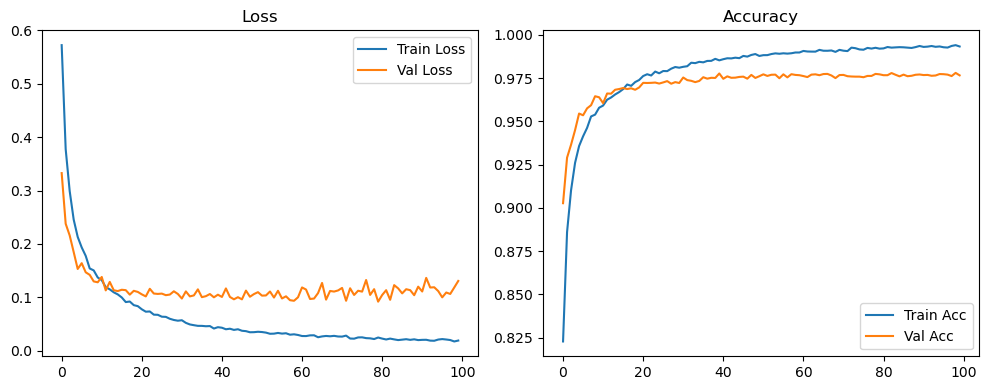

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4127, Acc: 0.8737 | Val Loss: 0.2684, Acc: 0.9202


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1849, Acc: 0.9444 | Val Loss: 0.1740, Acc: 0.9487


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1096, Acc: 0.9664 | Val Loss: 0.1286, Acc: 0.9608


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9775 | Val Loss: 0.1449, Acc: 0.9582


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9838 | Val Loss: 0.1244, Acc: 0.9673


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9868 | Val Loss: 0.1343, Acc: 0.9655


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9881 | Val Loss: 0.1323, Acc: 0.9693


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9916 | Val Loss: 0.1390, Acc: 0.9652


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.1081, Acc: 0.9728


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9931 | Val Loss: 0.1424, Acc: 0.9661


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.1180, Acc: 0.9696


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9933 | Val Loss: 0.1712, Acc: 0.9584


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.1755, Acc: 0.9666


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.1622, Acc: 0.9668


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.1607, Acc: 0.9680


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1234, Acc: 0.9715


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.1330, Acc: 0.9754


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1472, Acc: 0.9691


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1282, Acc: 0.9744


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.1407, Acc: 0.9727


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1462, Acc: 0.9739


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1522, Acc: 0.9712


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1395, Acc: 0.9698


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1145, Acc: 0.9763


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.1726, Acc: 0.9706


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1151, Acc: 0.9776


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1371, Acc: 0.9698


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1605, Acc: 0.9723


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1364, Acc: 0.9754


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1485, Acc: 0.9743


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1402, Acc: 0.9738


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9969 | Val Loss: 0.1713, Acc: 0.9710


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1143, Acc: 0.9776


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1115, Acc: 0.9781


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1488, Acc: 0.9728


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1362, Acc: 0.9737


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1674, Acc: 0.9696


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1252, Acc: 0.9777


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1646, Acc: 0.9692


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1077, Acc: 0.9745


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1457, Acc: 0.9748


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1339, Acc: 0.9758


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1498, Acc: 0.9764


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1290, Acc: 0.9725


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1681, Acc: 0.9611


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1330, Acc: 0.9747


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.2346, Acc: 0.9612


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1284, Acc: 0.9777


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.2227, Acc: 0.9712


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1238, Acc: 0.9771


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1278, Acc: 0.9806


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1404, Acc: 0.9788


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1450, Acc: 0.9793


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1332, Acc: 0.9810


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1452, Acc: 0.9809


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1328, Acc: 0.9784


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1366, Acc: 0.9796


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1036, Acc: 0.9788


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1329, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1448, Acc: 0.9797


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1566, Acc: 0.9783


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1456, Acc: 0.9799


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1236, Acc: 0.9791


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1480, Acc: 0.9802


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1386, Acc: 0.9794


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1430, Acc: 0.9806


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1125, Acc: 0.9792


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1404, Acc: 0.9784


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1727, Acc: 0.9776


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1251, Acc: 0.9798


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1305, Acc: 0.9803


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1389, Acc: 0.9791


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1784, Acc: 0.9763


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1561, Acc: 0.9795


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1767, Acc: 0.9788


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1520, Acc: 0.9787


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1353, Acc: 0.9801


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1191, Acc: 0.9788


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1185, Acc: 0.9792


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1421, Acc: 0.9794


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1439, Acc: 0.9814


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1551, Acc: 0.9813


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1713, Acc: 0.9808


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1619, Acc: 0.9804


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1893, Acc: 0.9788


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1718, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1935, Acc: 0.9799


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1821, Acc: 0.9799


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1684, Acc: 0.9792


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1665, Acc: 0.9807


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1774, Acc: 0.9802


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2300, Acc: 0.9750


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1863, Acc: 0.9788


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1618, Acc: 0.9803


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1748, Acc: 0.9804


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1638, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1760, Acc: 0.9800


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1913, Acc: 0.9808


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1989, Acc: 0.9801


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1599, Acc: 0.9802


Final Test Loss: 0.1422 Accuracy: 0.9816


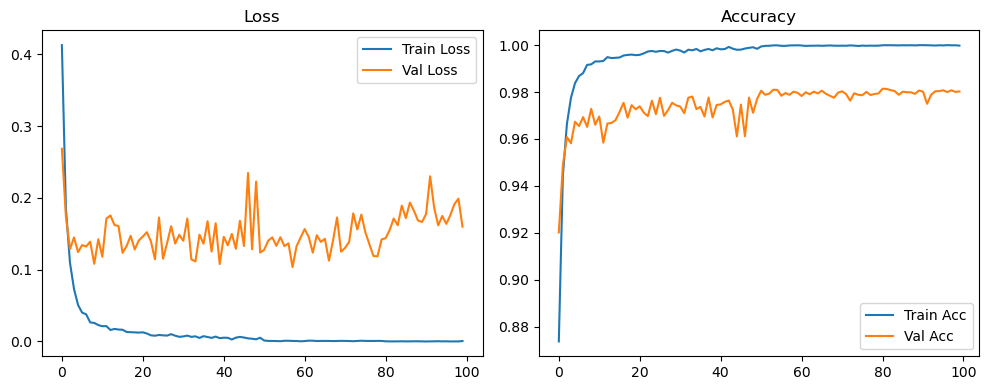

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4534, Acc: 0.8614 | Val Loss: 0.3187, Acc: 0.9059


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2570, Acc: 0.9233 | Val Loss: 0.1720, Acc: 0.9477


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1740, Acc: 0.9474 | Val Loss: 0.1406, Acc: 0.9594


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1368, Acc: 0.9585 | Val Loss: 0.1328, Acc: 0.9633


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1119, Acc: 0.9647 | Val Loss: 0.1142, Acc: 0.9672


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0950, Acc: 0.9708 | Val Loss: 0.1321, Acc: 0.9643


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0847, Acc: 0.9732 | Val Loss: 0.1044, Acc: 0.9692


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0721, Acc: 0.9775 | Val Loss: 0.1110, Acc: 0.9698


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0674, Acc: 0.9784 | Val Loss: 0.0996, Acc: 0.9712


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9800 | Val Loss: 0.0991, Acc: 0.9718


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9826 | Val Loss: 0.0994, Acc: 0.9717


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9841 | Val Loss: 0.1047, Acc: 0.9736


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9835 | Val Loss: 0.1068, Acc: 0.9737


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9858 | Val Loss: 0.1022, Acc: 0.9734


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9868 | Val Loss: 0.1011, Acc: 0.9741


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9870 | Val Loss: 0.0983, Acc: 0.9746


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9880 | Val Loss: 0.1077, Acc: 0.9733


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9886 | Val Loss: 0.1010, Acc: 0.9738


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9892 | Val Loss: 0.1054, Acc: 0.9733


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9893 | Val Loss: 0.1151, Acc: 0.9732


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.1041, Acc: 0.9751


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.1094, Acc: 0.9775


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9902 | Val Loss: 0.1004, Acc: 0.9760


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9918 | Val Loss: 0.0998, Acc: 0.9772


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.1122, Acc: 0.9747


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.1065, Acc: 0.9750


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9916 | Val Loss: 0.0883, Acc: 0.9762


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9918 | Val Loss: 0.1113, Acc: 0.9748


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9927 | Val Loss: 0.1154, Acc: 0.9750


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.1155, Acc: 0.9717


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.1005, Acc: 0.9768


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9931 | Val Loss: 0.1049, Acc: 0.9738


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.1219, Acc: 0.9751


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.1137, Acc: 0.9752


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9941 | Val Loss: 0.1140, Acc: 0.9749


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.1170, Acc: 0.9759


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.1074, Acc: 0.9769


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0959, Acc: 0.9781


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1046, Acc: 0.9786


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1285, Acc: 0.9744


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0893, Acc: 0.9774


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.1233, Acc: 0.9775


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1128, Acc: 0.9766


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9946 | Val Loss: 0.1124, Acc: 0.9765


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1176, Acc: 0.9761


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.1061, Acc: 0.9762


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9946 | Val Loss: 0.1165, Acc: 0.9778


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9954 | Val Loss: 0.1255, Acc: 0.9768


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1312, Acc: 0.9740


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.1000, Acc: 0.9785


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1107, Acc: 0.9781


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1090, Acc: 0.9790


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1163, Acc: 0.9782


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1166, Acc: 0.9789


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1196, Acc: 0.9792


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1124, Acc: 0.9793


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1219, Acc: 0.9802


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1339, Acc: 0.9795


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1215, Acc: 0.9790


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1229, Acc: 0.9791


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1165, Acc: 0.9792


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1197, Acc: 0.9791


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9982 | Val Loss: 0.1316, Acc: 0.9791


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1210, Acc: 0.9800


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1229, Acc: 0.9801


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1270, Acc: 0.9777


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1095, Acc: 0.9787


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1214, Acc: 0.9783


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1286, Acc: 0.9784


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1122, Acc: 0.9784


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1367, Acc: 0.9792


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1388, Acc: 0.9800


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1401, Acc: 0.9791


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1522, Acc: 0.9792


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1286, Acc: 0.9783


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1390, Acc: 0.9795


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1283, Acc: 0.9796


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1367, Acc: 0.9793


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1263, Acc: 0.9787


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1386, Acc: 0.9786


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1412, Acc: 0.9799


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1309, Acc: 0.9801


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1317, Acc: 0.9799


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1276, Acc: 0.9802


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1442, Acc: 0.9799


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1427, Acc: 0.9794


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1170, Acc: 0.9802


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1346, Acc: 0.9801


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1528, Acc: 0.9802


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1268, Acc: 0.9802


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1499, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1392, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1396, Acc: 0.9806


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1316, Acc: 0.9805


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1394, Acc: 0.9801


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1503, Acc: 0.9798


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1426, Acc: 0.9806


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1343, Acc: 0.9802


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1132, Acc: 0.9812


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1249, Acc: 0.9799


Final Test Loss: 0.1133 Accuracy: 0.9830


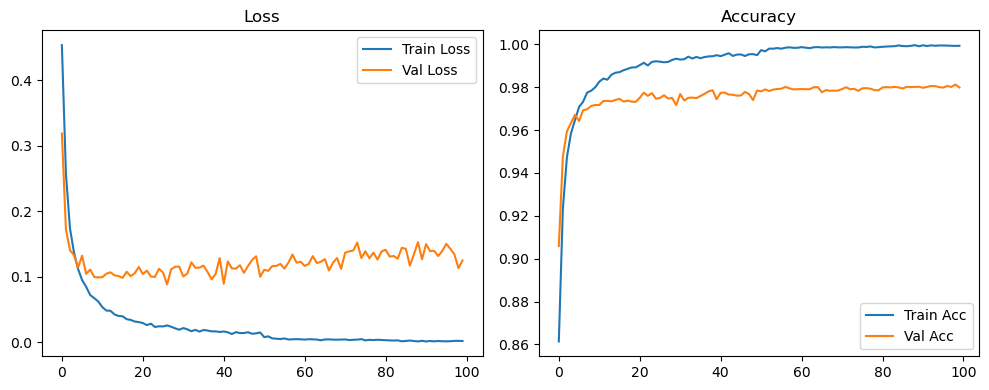

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5723, Acc: 0.8228 | Val Loss: 0.3327, Acc: 0.9028


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3775, Acc: 0.8860 | Val Loss: 0.2379, Acc: 0.9291


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2990, Acc: 0.9103 | Val Loss: 0.2160, Acc: 0.9366


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2456, Acc: 0.9261 | Val Loss: 0.1848, Acc: 0.9450


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2133, Acc: 0.9358 | Val Loss: 0.1532, Acc: 0.9546


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1936, Acc: 0.9414 | Val Loss: 0.1641, Acc: 0.9536


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1778, Acc: 0.9463 | Val Loss: 0.1470, Acc: 0.9576


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1542, Acc: 0.9529 | Val Loss: 0.1422, Acc: 0.9594


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1505, Acc: 0.9540 | Val Loss: 0.1299, Acc: 0.9646


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1373, Acc: 0.9579 | Val Loss: 0.1283, Acc: 0.9640


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1324, Acc: 0.9592 | Val Loss: 0.1383, Acc: 0.9606


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1190, Acc: 0.9626 | Val Loss: 0.1131, Acc: 0.9662


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1151, Acc: 0.9639 | Val Loss: 0.1290, Acc: 0.9661


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1095, Acc: 0.9656 | Val Loss: 0.1134, Acc: 0.9683


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1056, Acc: 0.9670 | Val Loss: 0.1119, Acc: 0.9688


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0999, Acc: 0.9687 | Val Loss: 0.1143, Acc: 0.9693


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0912, Acc: 0.9714 | Val Loss: 0.1135, Acc: 0.9688


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0923, Acc: 0.9706 | Val Loss: 0.1052, Acc: 0.9692


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0855, Acc: 0.9728 | Val Loss: 0.1123, Acc: 0.9683


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0836, Acc: 0.9740 | Val Loss: 0.1103, Acc: 0.9697


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9763 | Val Loss: 0.1057, Acc: 0.9723


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0732, Acc: 0.9773 | Val Loss: 0.1019, Acc: 0.9722


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0736, Acc: 0.9766 | Val Loss: 0.1161, Acc: 0.9723


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9789 | Val Loss: 0.1072, Acc: 0.9725


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0674, Acc: 0.9779 | Val Loss: 0.1065, Acc: 0.9719


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0639, Acc: 0.9792 | Val Loss: 0.1071, Acc: 0.9726


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9791 | Val Loss: 0.1042, Acc: 0.9733


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0600, Acc: 0.9805 | Val Loss: 0.1053, Acc: 0.9718


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9815 | Val Loss: 0.1114, Acc: 0.9728


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0564, Acc: 0.9811 | Val Loss: 0.1065, Acc: 0.9722


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0572, Acc: 0.9816 | Val Loss: 0.0979, Acc: 0.9754


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9819 | Val Loss: 0.1112, Acc: 0.9739


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9840 | Val Loss: 0.1019, Acc: 0.9735


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9837 | Val Loss: 0.1037, Acc: 0.9728


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9845 | Val Loss: 0.1151, Acc: 0.9734


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9842 | Val Loss: 0.1004, Acc: 0.9756


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9850 | Val Loss: 0.1023, Acc: 0.9748


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9850 | Val Loss: 0.1063, Acc: 0.9752


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9862 | Val Loss: 0.1002, Acc: 0.9752


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9853 | Val Loss: 0.1051, Acc: 0.9778


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9860 | Val Loss: 0.1008, Acc: 0.9747


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9865 | Val Loss: 0.1168, Acc: 0.9761


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9865 | Val Loss: 0.1008, Acc: 0.9752


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9869 | Val Loss: 0.0964, Acc: 0.9753


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9866 | Val Loss: 0.1004, Acc: 0.9758


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.0964, Acc: 0.9759


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9875 | Val Loss: 0.1127, Acc: 0.9748


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.1012, Acc: 0.9769


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9890 | Val Loss: 0.1062, Acc: 0.9752


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9879 | Val Loss: 0.1098, Acc: 0.9762


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9901 | Val Loss: 0.1011, Acc: 0.9769


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.1009, Acc: 0.9766


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9919 | Val Loss: 0.1084, Acc: 0.9783


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.1042, Acc: 0.9771


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.1055, Acc: 0.9766


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.1036, Acc: 0.9778


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1090, Acc: 0.9772


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.1033, Acc: 0.9777


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.1122, Acc: 0.9774


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9940 | Val Loss: 0.1084, Acc: 0.9782


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.1165, Acc: 0.9783


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9938 | Val Loss: 0.1143, Acc: 0.9775


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.1204, Acc: 0.9782


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1112, Acc: 0.9786


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9945 | Val Loss: 0.1181, Acc: 0.9779


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9947 | Val Loss: 0.1107, Acc: 0.9782


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.1155, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.1276, Acc: 0.9782


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9949 | Val Loss: 0.1258, Acc: 0.9773


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.1075, Acc: 0.9774


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.1276, Acc: 0.9781


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.1085, Acc: 0.9782


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9956 | Val Loss: 0.1277, Acc: 0.9785


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.1045, Acc: 0.9779


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.1171, Acc: 0.9774


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1142, Acc: 0.9772


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1267, Acc: 0.9770


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.1131, Acc: 0.9773


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9954 | Val Loss: 0.1119, Acc: 0.9780


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9951 | Val Loss: 0.1340, Acc: 0.9779


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1175, Acc: 0.9783


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9959 | Val Loss: 0.1246, Acc: 0.9779


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9959 | Val Loss: 0.1320, Acc: 0.9779


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1242, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1296, Acc: 0.9791


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1297, Acc: 0.9788


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1229, Acc: 0.9795


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1334, Acc: 0.9796


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.1236, Acc: 0.9789


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1267, Acc: 0.9801


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1233, Acc: 0.9795


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1228, Acc: 0.9793


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1146, Acc: 0.9791


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1180, Acc: 0.9792


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1144, Acc: 0.9793


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1204, Acc: 0.9792


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1248, Acc: 0.9794


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1195, Acc: 0.9792


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1274, Acc: 0.9783


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1245, Acc: 0.9788


Final Test Loss: 0.1115 Accuracy: 0.9813


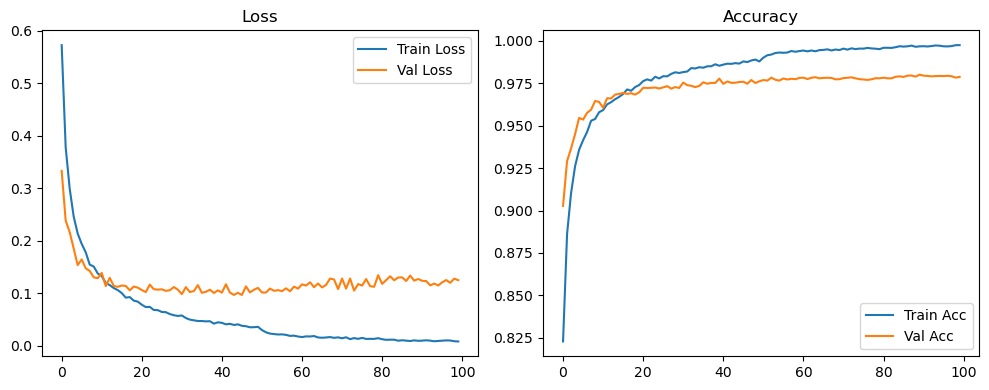

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3875, Acc: 0.8844 | Val Loss: 0.3324, Acc: 0.9002


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1863, Acc: 0.9445 | Val Loss: 0.1475, Acc: 0.9539


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0979, Acc: 0.9699 | Val Loss: 0.1127, Acc: 0.9638


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0547, Acc: 0.9821 | Val Loss: 0.1367, Acc: 0.9607


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.1029, Acc: 0.9687


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9891 | Val Loss: 0.1299, Acc: 0.9675


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9905 | Val Loss: 0.1364, Acc: 0.9667


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.1424, Acc: 0.9672


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.1194, Acc: 0.9718


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9925 | Val Loss: 0.1505, Acc: 0.9624


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.1629, Acc: 0.9651


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1248, Acc: 0.9700


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.1577, Acc: 0.9673


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1897, Acc: 0.9640


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9946 | Val Loss: 0.2241, Acc: 0.9580


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1730, Acc: 0.9672


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1440, Acc: 0.9727


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1858, Acc: 0.9657


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9961 | Val Loss: 0.1287, Acc: 0.9754


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1593, Acc: 0.9725


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9963 | Val Loss: 0.1459, Acc: 0.9726


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1313, Acc: 0.9744


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1688, Acc: 0.9698


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1537, Acc: 0.9726


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1565, Acc: 0.9724


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1704, Acc: 0.9706


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1367, Acc: 0.9748


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1326, Acc: 0.9758


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1756, Acc: 0.9722


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1348, Acc: 0.9732


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1616, Acc: 0.9708


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.2168, Acc: 0.9631


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1531, Acc: 0.9740


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1512, Acc: 0.9753


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1387, Acc: 0.9778


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.2366, Acc: 0.9577


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9975 | Val Loss: 0.1666, Acc: 0.9704


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1287, Acc: 0.9781


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1538, Acc: 0.9739


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1520, Acc: 0.9758


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1463, Acc: 0.9757


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1343, Acc: 0.9767


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1510, Acc: 0.9739


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1419, Acc: 0.9754


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1470, Acc: 0.9751


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1496, Acc: 0.9774


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1443, Acc: 0.9762


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1756, Acc: 0.9697


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1793, Acc: 0.9729


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.2065, Acc: 0.9661


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1796, Acc: 0.9690


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1873, Acc: 0.9690


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1736, Acc: 0.9730


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1374, Acc: 0.9752


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1328, Acc: 0.9758


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1270, Acc: 0.9782


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1429, Acc: 0.9745


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1739, Acc: 0.9726


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1479, Acc: 0.9743


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1625, Acc: 0.9733


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1155, Acc: 0.9786


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.1328, Acc: 0.9734


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1657, Acc: 0.9745


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1449, Acc: 0.9788


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1587, Acc: 0.9756


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1961, Acc: 0.9652


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1144, Acc: 0.9801


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1986, Acc: 0.9710


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1359, Acc: 0.9774


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1396, Acc: 0.9779


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.2005, Acc: 0.9682


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1631, Acc: 0.9767


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1339, Acc: 0.9764


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.1399, Acc: 0.9772


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1650, Acc: 0.9766


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1910, Acc: 0.9735


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1352, Acc: 0.9771


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1717, Acc: 0.9742


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1221, Acc: 0.9770


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1786, Acc: 0.9708


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1535, Acc: 0.9763


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1338, Acc: 0.9772


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1300, Acc: 0.9794


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1806, Acc: 0.9748


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1661, Acc: 0.9753


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1776, Acc: 0.9738


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1637, Acc: 0.9719


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1581, Acc: 0.9752


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1468, Acc: 0.9707


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1587, Acc: 0.9765


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1825, Acc: 0.9691


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1310, Acc: 0.9772


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1679, Acc: 0.9738


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.1679, Acc: 0.9703


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1348, Acc: 0.9806


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1791, Acc: 0.9730


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1354, Acc: 0.9799


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1403, Acc: 0.9777


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1219, Acc: 0.9782


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1340, Acc: 0.9785


Final Test Loss: 0.1254 Accuracy: 0.9790


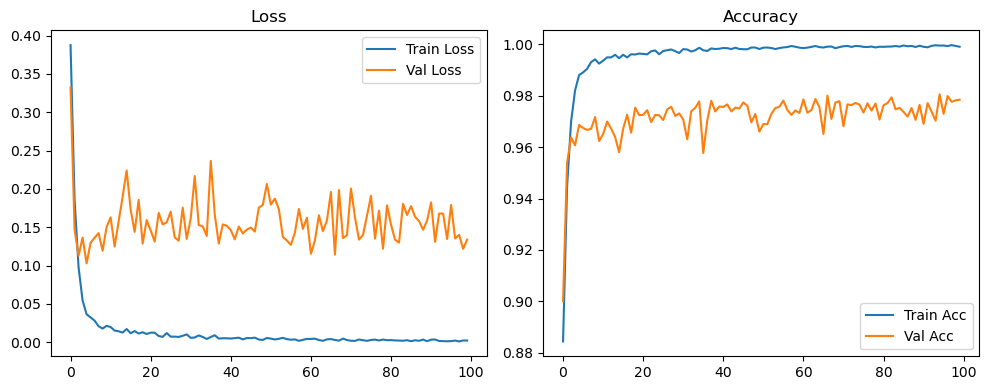

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4334, Acc: 0.8707 | Val Loss: 0.3191, Acc: 0.9037


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2548, Acc: 0.9230 | Val Loss: 0.1671, Acc: 0.9483


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1785, Acc: 0.9449 | Val Loss: 0.1380, Acc: 0.9583


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1395, Acc: 0.9571 | Val Loss: 0.1340, Acc: 0.9604


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1186, Acc: 0.9623 | Val Loss: 0.1091, Acc: 0.9659


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1001, Acc: 0.9683 | Val Loss: 0.1244, Acc: 0.9650


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0906, Acc: 0.9705 | Val Loss: 0.1128, Acc: 0.9681


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0792, Acc: 0.9749 | Val Loss: 0.1097, Acc: 0.9699


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0722, Acc: 0.9766 | Val Loss: 0.0984, Acc: 0.9710


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9788 | Val Loss: 0.1074, Acc: 0.9689


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0617, Acc: 0.9799 | Val Loss: 0.1066, Acc: 0.9702


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9817 | Val Loss: 0.1006, Acc: 0.9731


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9818 | Val Loss: 0.1020, Acc: 0.9728


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0482, Acc: 0.9842 | Val Loss: 0.0939, Acc: 0.9759


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9857 | Val Loss: 0.0963, Acc: 0.9756


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9858 | Val Loss: 0.0987, Acc: 0.9747


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9864 | Val Loss: 0.1053, Acc: 0.9741


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9877 | Val Loss: 0.1127, Acc: 0.9747


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9873 | Val Loss: 0.1091, Acc: 0.9724


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9892 | Val Loss: 0.1117, Acc: 0.9754


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9880 | Val Loss: 0.1026, Acc: 0.9762


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9899 | Val Loss: 0.1075, Acc: 0.9759


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9901 | Val Loss: 0.1020, Acc: 0.9761


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9912 | Val Loss: 0.0979, Acc: 0.9775


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9910 | Val Loss: 0.1038, Acc: 0.9756


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.1105, Acc: 0.9752


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9912 | Val Loss: 0.1145, Acc: 0.9758


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.1087, Acc: 0.9752


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.1138, Acc: 0.9758


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.1120, Acc: 0.9761


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.1118, Acc: 0.9770


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9921 | Val Loss: 0.1038, Acc: 0.9772


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9933 | Val Loss: 0.1132, Acc: 0.9768


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.1137, Acc: 0.9766


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.1189, Acc: 0.9771


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.1176, Acc: 0.9759


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.1069, Acc: 0.9778


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9931 | Val Loss: 0.1037, Acc: 0.9780


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.1012, Acc: 0.9776


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.1203, Acc: 0.9759


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1101, Acc: 0.9762


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9940 | Val Loss: 0.1075, Acc: 0.9768


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1075, Acc: 0.9789


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.1093, Acc: 0.9766


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.1123, Acc: 0.9777


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1185, Acc: 0.9764


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9938 | Val Loss: 0.1180, Acc: 0.9759


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1132, Acc: 0.9779


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1188, Acc: 0.9775


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 0.1136, Acc: 0.9776


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1115, Acc: 0.9771


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9950 | Val Loss: 0.1134, Acc: 0.9766


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9953 | Val Loss: 0.1165, Acc: 0.9778


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9954 | Val Loss: 0.1118, Acc: 0.9765


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.1059, Acc: 0.9779


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1257, Acc: 0.9782


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1158, Acc: 0.9775


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1097, Acc: 0.9777


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1170, Acc: 0.9776


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1174, Acc: 0.9776


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1098, Acc: 0.9782


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1133, Acc: 0.9780


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1031, Acc: 0.9793


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1007, Acc: 0.9785


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1045, Acc: 0.9780


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1158, Acc: 0.9778


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1233, Acc: 0.9783


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1248, Acc: 0.9780


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1168, Acc: 0.9777


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1144, Acc: 0.9780


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1204, Acc: 0.9776


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1235, Acc: 0.9779


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1106, Acc: 0.9776


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.1199, Acc: 0.9782


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1238, Acc: 0.9786


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1248, Acc: 0.9767


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.1124, Acc: 0.9785


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1117, Acc: 0.9781


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1148, Acc: 0.9786


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1071, Acc: 0.9794


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1132, Acc: 0.9791


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1200, Acc: 0.9786


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1156, Acc: 0.9778


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1159, Acc: 0.9779


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1096, Acc: 0.9788


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1132, Acc: 0.9792


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1156, Acc: 0.9775


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1413, Acc: 0.9769


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1273, Acc: 0.9782


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1113, Acc: 0.9778


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1102, Acc: 0.9779


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1231, Acc: 0.9778


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1259, Acc: 0.9779


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1124, Acc: 0.9773


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1291, Acc: 0.9770


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1346, Acc: 0.9778


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1358, Acc: 0.9763


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.1040, Acc: 0.9788


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1070, Acc: 0.9797


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1261, Acc: 0.9777


Final Test Loss: 0.1199 Accuracy: 0.9812


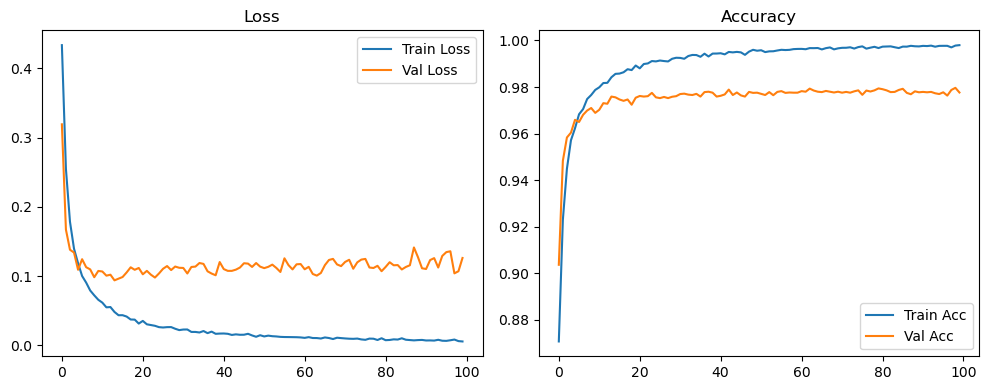

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5680, Acc: 0.8250 | Val Loss: 0.3270, Acc: 0.9015


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3881, Acc: 0.8801 | Val Loss: 0.2517, Acc: 0.9234


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.3226, Acc: 0.9023 | Val Loss: 0.2249, Acc: 0.9343


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2709, Acc: 0.9179 | Val Loss: 0.1920, Acc: 0.9436


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.2377, Acc: 0.9284 | Val Loss: 0.1655, Acc: 0.9519


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.2165, Acc: 0.9339 | Val Loss: 0.1708, Acc: 0.9515


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.2011, Acc: 0.9383 | Val Loss: 0.1531, Acc: 0.9561


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1820, Acc: 0.9446 | Val Loss: 0.1473, Acc: 0.9575


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1733, Acc: 0.9474 | Val Loss: 0.1360, Acc: 0.9609


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1588, Acc: 0.9513 | Val Loss: 0.1404, Acc: 0.9613


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1541, Acc: 0.9529 | Val Loss: 0.1365, Acc: 0.9607


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1430, Acc: 0.9556 | Val Loss: 0.1243, Acc: 0.9643


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1392, Acc: 0.9572 | Val Loss: 0.1309, Acc: 0.9637


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1336, Acc: 0.9592 | Val Loss: 0.1211, Acc: 0.9651


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1273, Acc: 0.9615 | Val Loss: 0.1190, Acc: 0.9667


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1203, Acc: 0.9624 | Val Loss: 0.1222, Acc: 0.9663


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1142, Acc: 0.9640 | Val Loss: 0.1254, Acc: 0.9663


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1125, Acc: 0.9644 | Val Loss: 0.1162, Acc: 0.9677


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1087, Acc: 0.9658 | Val Loss: 0.1183, Acc: 0.9665


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1047, Acc: 0.9670 | Val Loss: 0.1165, Acc: 0.9683


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0981, Acc: 0.9686 | Val Loss: 0.1121, Acc: 0.9691


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0922, Acc: 0.9710 | Val Loss: 0.1120, Acc: 0.9694


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0906, Acc: 0.9709 | Val Loss: 0.1148, Acc: 0.9696


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0894, Acc: 0.9719 | Val Loss: 0.1085, Acc: 0.9708


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0882, Acc: 0.9721 | Val Loss: 0.1161, Acc: 0.9697


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0841, Acc: 0.9738 | Val Loss: 0.1118, Acc: 0.9715


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0811, Acc: 0.9736 | Val Loss: 0.1109, Acc: 0.9707


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0791, Acc: 0.9742 | Val Loss: 0.1122, Acc: 0.9711


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0737, Acc: 0.9764 | Val Loss: 0.1082, Acc: 0.9710


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0754, Acc: 0.9755 | Val Loss: 0.1113, Acc: 0.9702


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0735, Acc: 0.9768 | Val Loss: 0.1077, Acc: 0.9719


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0712, Acc: 0.9765 | Val Loss: 0.1081, Acc: 0.9719


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0638, Acc: 0.9795 | Val Loss: 0.1097, Acc: 0.9714


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0637, Acc: 0.9788 | Val Loss: 0.1096, Acc: 0.9713


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0649, Acc: 0.9780 | Val Loss: 0.1083, Acc: 0.9738


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0643, Acc: 0.9789 | Val Loss: 0.1093, Acc: 0.9723


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0606, Acc: 0.9803 | Val Loss: 0.1158, Acc: 0.9730


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0600, Acc: 0.9802 | Val Loss: 0.1112, Acc: 0.9720


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9820 | Val Loss: 0.1083, Acc: 0.9728


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0591, Acc: 0.9809 | Val Loss: 0.1136, Acc: 0.9722


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0560, Acc: 0.9816 | Val Loss: 0.1146, Acc: 0.9730


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0535, Acc: 0.9821 | Val Loss: 0.1114, Acc: 0.9741


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0571, Acc: 0.9809 | Val Loss: 0.1164, Acc: 0.9720


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0528, Acc: 0.9824 | Val Loss: 0.1095, Acc: 0.9733


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0526, Acc: 0.9825 | Val Loss: 0.1099, Acc: 0.9739


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0496, Acc: 0.9836 | Val Loss: 0.1116, Acc: 0.9732


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9838 | Val Loss: 0.1141, Acc: 0.9723


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9844 | Val Loss: 0.1086, Acc: 0.9750


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9861 | Val Loss: 0.1145, Acc: 0.9727


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0488, Acc: 0.9845 | Val Loss: 0.1058, Acc: 0.9738


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9848 | Val Loss: 0.1129, Acc: 0.9738


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0463, Acc: 0.9842 | Val Loss: 0.1105, Acc: 0.9743


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 0.1078, Acc: 0.9744


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0422, Acc: 0.9858 | Val Loss: 0.1086, Acc: 0.9737


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9854 | Val Loss: 0.1052, Acc: 0.9742


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9865 | Val Loss: 0.1039, Acc: 0.9758


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9862 | Val Loss: 0.1098, Acc: 0.9751


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9868 | Val Loss: 0.1094, Acc: 0.9753


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9875 | Val Loss: 0.1078, Acc: 0.9757


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9871 | Val Loss: 0.1067, Acc: 0.9749


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9870 | Val Loss: 0.1095, Acc: 0.9752


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.1128, Acc: 0.9746


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9880 | Val Loss: 0.1129, Acc: 0.9764


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9876 | Val Loss: 0.1045, Acc: 0.9751


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9880 | Val Loss: 0.1095, Acc: 0.9751


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9887 | Val Loss: 0.1124, Acc: 0.9758


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9881 | Val Loss: 0.1114, Acc: 0.9756


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9889 | Val Loss: 0.1238, Acc: 0.9745


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9882 | Val Loss: 0.1131, Acc: 0.9745


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9880 | Val Loss: 0.1055, Acc: 0.9741


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9890 | Val Loss: 0.1146, Acc: 0.9746


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9889 | Val Loss: 0.1205, Acc: 0.9752


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.1118, Acc: 0.9757


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9896 | Val Loss: 0.1192, Acc: 0.9737


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9902 | Val Loss: 0.1174, Acc: 0.9741


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9899 | Val Loss: 0.1054, Acc: 0.9760


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 0.1104, Acc: 0.9761


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9896 | Val Loss: 0.1138, Acc: 0.9758


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9902 | Val Loss: 0.1117, Acc: 0.9756


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.1091, Acc: 0.9759


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9893 | Val Loss: 0.1099, Acc: 0.9752


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9902 | Val Loss: 0.1123, Acc: 0.9750


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9895 | Val Loss: 0.1068, Acc: 0.9757


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9908 | Val Loss: 0.1096, Acc: 0.9762


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.1100, Acc: 0.9758


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9900 | Val Loss: 0.1046, Acc: 0.9765


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9909 | Val Loss: 0.1117, Acc: 0.9746


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9902 | Val Loss: 0.1089, Acc: 0.9757


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9909 | Val Loss: 0.1145, Acc: 0.9758


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9906 | Val Loss: 0.1115, Acc: 0.9759


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9913 | Val Loss: 0.1164, Acc: 0.9758


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.1121, Acc: 0.9764


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9910 | Val Loss: 0.1096, Acc: 0.9761


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9911 | Val Loss: 0.1245, Acc: 0.9765


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.1076, Acc: 0.9759


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9919 | Val Loss: 0.1023, Acc: 0.9767


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9912 | Val Loss: 0.1143, Acc: 0.9760


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9914 | Val Loss: 0.1144, Acc: 0.9758


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9916 | Val Loss: 0.1089, Acc: 0.9762


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.1201, Acc: 0.9754


Final Test Loss: 0.1050 Accuracy: 0.9782


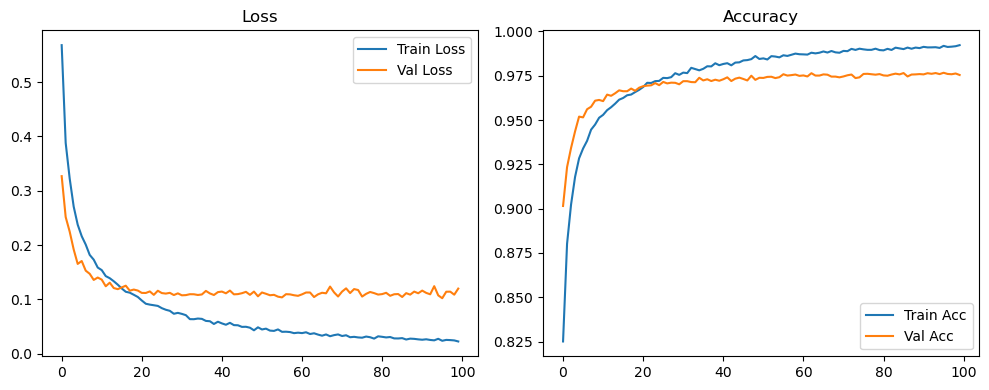

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3879, Acc: 0.8879 | Val Loss: 0.2967, Acc: 0.9116


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1906, Acc: 0.9430 | Val Loss: 0.1431, Acc: 0.9538


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0927, Acc: 0.9715 | Val Loss: 0.1073, Acc: 0.9643


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0506, Acc: 0.9837 | Val Loss: 0.1111, Acc: 0.9658


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.0993, Acc: 0.9720


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1453, Acc: 0.9595


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9924 | Val Loss: 0.1421, Acc: 0.9623


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1405, Acc: 0.9662


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.1038, Acc: 0.9724


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1446, Acc: 0.9654


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.2559, Acc: 0.9428


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1367, Acc: 0.9705


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.1242, Acc: 0.9703


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1301, Acc: 0.9711


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1448, Acc: 0.9697


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1479, Acc: 0.9683


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.1430, Acc: 0.9688


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1309, Acc: 0.9715


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1235, Acc: 0.9751


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1604, Acc: 0.9696


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1533, Acc: 0.9709


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.1221, Acc: 0.9741


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9968 | Val Loss: 0.1625, Acc: 0.9703


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.1228, Acc: 0.9772


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1399, Acc: 0.9725


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1294, Acc: 0.9750


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1578, Acc: 0.9728


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9970 | Val Loss: 0.1159, Acc: 0.9780


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1154, Acc: 0.9781


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1560, Acc: 0.9729


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.2006, Acc: 0.9652


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1325, Acc: 0.9772


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.1492, Acc: 0.9745


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1423, Acc: 0.9761


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1290, Acc: 0.9755


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1506, Acc: 0.9746


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1559, Acc: 0.9737


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1697, Acc: 0.9707


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1358, Acc: 0.9762


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1492, Acc: 0.9727


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1997, Acc: 0.9679


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1442, Acc: 0.9758


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1316, Acc: 0.9785


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1335, Acc: 0.9756


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1360, Acc: 0.9773


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1447, Acc: 0.9758


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1622, Acc: 0.9737


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1659, Acc: 0.9735


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1393, Acc: 0.9773


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1451, Acc: 0.9770


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1632, Acc: 0.9729


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1343, Acc: 0.9780


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1421, Acc: 0.9766


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1438, Acc: 0.9786


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1429, Acc: 0.9780


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1443, Acc: 0.9776


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1313, Acc: 0.9783


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1810, Acc: 0.9742


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1305, Acc: 0.9796


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1573, Acc: 0.9754


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1728, Acc: 0.9751


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1748, Acc: 0.9747


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1492, Acc: 0.9772


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1468, Acc: 0.9773


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1508, Acc: 0.9768


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1386, Acc: 0.9779


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1606, Acc: 0.9745


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1595, Acc: 0.9779


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1405, Acc: 0.9779


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1360, Acc: 0.9787


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1317, Acc: 0.9787


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1667, Acc: 0.9762


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1355, Acc: 0.9777


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1501, Acc: 0.9771


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1341, Acc: 0.9793


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1460, Acc: 0.9791


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1673, Acc: 0.9761


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.2152, Acc: 0.9704


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1619, Acc: 0.9776


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1613, Acc: 0.9783


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1773, Acc: 0.9744


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.2075, Acc: 0.9702


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1516, Acc: 0.9776


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1561, Acc: 0.9765


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1424, Acc: 0.9776


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1793, Acc: 0.9741


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1571, Acc: 0.9798


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1627, Acc: 0.9761


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.2552, Acc: 0.9653


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1558, Acc: 0.9778


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1811, Acc: 0.9760


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1543, Acc: 0.9774


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1807, Acc: 0.9734


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1522, Acc: 0.9759


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1596, Acc: 0.9764


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1567, Acc: 0.9773


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1636, Acc: 0.9756


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1574, Acc: 0.9782


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1873, Acc: 0.9735


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1875, Acc: 0.9751


Final Test Loss: 0.1689 Accuracy: 0.9771


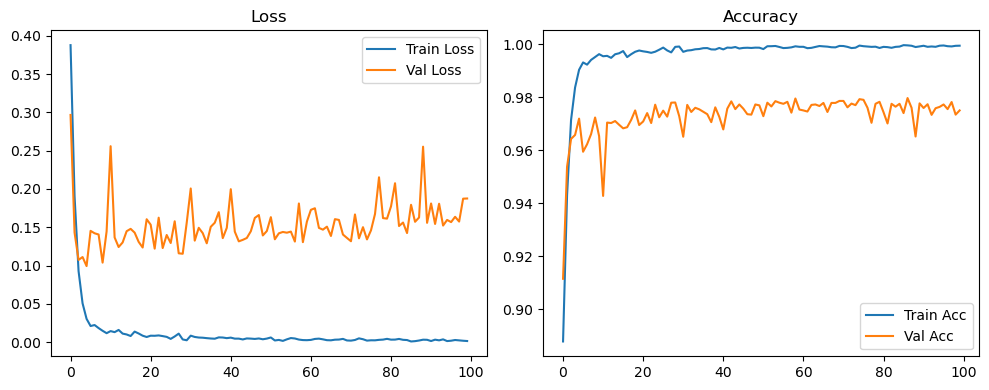

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4469, Acc: 0.8711 | Val Loss: 0.3118, Acc: 0.9087


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2740, Acc: 0.9165 | Val Loss: 0.1820, Acc: 0.9452


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1900, Acc: 0.9410 | Val Loss: 0.1507, Acc: 0.9543


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1489, Acc: 0.9534 | Val Loss: 0.1326, Acc: 0.9600


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1228, Acc: 0.9624 | Val Loss: 0.1102, Acc: 0.9658


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1081, Acc: 0.9653 | Val Loss: 0.1070, Acc: 0.9675


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0952, Acc: 0.9691 | Val Loss: 0.1089, Acc: 0.9671


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0828, Acc: 0.9733 | Val Loss: 0.1059, Acc: 0.9692


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0787, Acc: 0.9742 | Val Loss: 0.0993, Acc: 0.9705


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0710, Acc: 0.9770 | Val Loss: 0.0951, Acc: 0.9718


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0647, Acc: 0.9780 | Val Loss: 0.1051, Acc: 0.9706


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0600, Acc: 0.9792 | Val Loss: 0.0946, Acc: 0.9739


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0577, Acc: 0.9803 | Val Loss: 0.0959, Acc: 0.9739


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0527, Acc: 0.9827 | Val Loss: 0.0918, Acc: 0.9743


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0473, Acc: 0.9842 | Val Loss: 0.0972, Acc: 0.9744


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0470, Acc: 0.9840 | Val Loss: 0.0944, Acc: 0.9757


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9853 | Val Loss: 0.1006, Acc: 0.9719


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9865 | Val Loss: 0.0975, Acc: 0.9743


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9868 | Val Loss: 0.1122, Acc: 0.9722


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9869 | Val Loss: 0.0956, Acc: 0.9768


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9876 | Val Loss: 0.1058, Acc: 0.9742


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9882 | Val Loss: 0.0946, Acc: 0.9775


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9894 | Val Loss: 0.0989, Acc: 0.9762


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9898 | Val Loss: 0.0997, Acc: 0.9759


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9900 | Val Loss: 0.1030, Acc: 0.9752


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.1190, Acc: 0.9742


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9901 | Val Loss: 0.1051, Acc: 0.9750


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9906 | Val Loss: 0.1006, Acc: 0.9760


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9907 | Val Loss: 0.1043, Acc: 0.9761


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9915 | Val Loss: 0.1057, Acc: 0.9759


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.1086, Acc: 0.9762


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.1109, Acc: 0.9772


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9930 | Val Loss: 0.1125, Acc: 0.9753


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.1108, Acc: 0.9769


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9926 | Val Loss: 0.1095, Acc: 0.9770


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9927 | Val Loss: 0.1067, Acc: 0.9767


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.1048, Acc: 0.9778


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1101, Acc: 0.9765


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9931 | Val Loss: 0.1025, Acc: 0.9775


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.1049, Acc: 0.9770


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.1151, Acc: 0.9750


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1056, Acc: 0.9780


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1110, Acc: 0.9772


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9938 | Val Loss: 0.1120, Acc: 0.9762


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9944 | Val Loss: 0.1169, Acc: 0.9773


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.1120, Acc: 0.9774


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.1230, Acc: 0.9756


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1191, Acc: 0.9769


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.1154, Acc: 0.9778


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.1107, Acc: 0.9778


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.1096, Acc: 0.9782


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.1134, Acc: 0.9772


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.1105, Acc: 0.9781


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.1183, Acc: 0.9777


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1144, Acc: 0.9772


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1107, Acc: 0.9788


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1147, Acc: 0.9791


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.1108, Acc: 0.9788


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1226, Acc: 0.9765


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1164, Acc: 0.9783


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1096, Acc: 0.9782


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.1122, Acc: 0.9777


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.1278, Acc: 0.9775


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1195, Acc: 0.9782


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1210, Acc: 0.9772


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1301, Acc: 0.9766


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1073, Acc: 0.9778


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1203, Acc: 0.9788


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1162, Acc: 0.9784


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1205, Acc: 0.9788


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9959 | Val Loss: 0.1138, Acc: 0.9779


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1302, Acc: 0.9772


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.1176, Acc: 0.9785


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1289, Acc: 0.9783


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1297, Acc: 0.9783


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1175, Acc: 0.9786


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1295, Acc: 0.9778


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1126, Acc: 0.9790


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1164, Acc: 0.9792


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1181, Acc: 0.9782


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1254, Acc: 0.9788


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.1267, Acc: 0.9788


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1203, Acc: 0.9788


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1243, Acc: 0.9783


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1243, Acc: 0.9785


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1342, Acc: 0.9771


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1236, Acc: 0.9776


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1224, Acc: 0.9772


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1192, Acc: 0.9781


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1180, Acc: 0.9788


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1179, Acc: 0.9777


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1235, Acc: 0.9778


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1213, Acc: 0.9778


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1314, Acc: 0.9756


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1144, Acc: 0.9801


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1269, Acc: 0.9788


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.1392, Acc: 0.9779


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1340, Acc: 0.9784


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1261, Acc: 0.9783


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1295, Acc: 0.9775


Final Test Loss: 0.1054 Accuracy: 0.9808


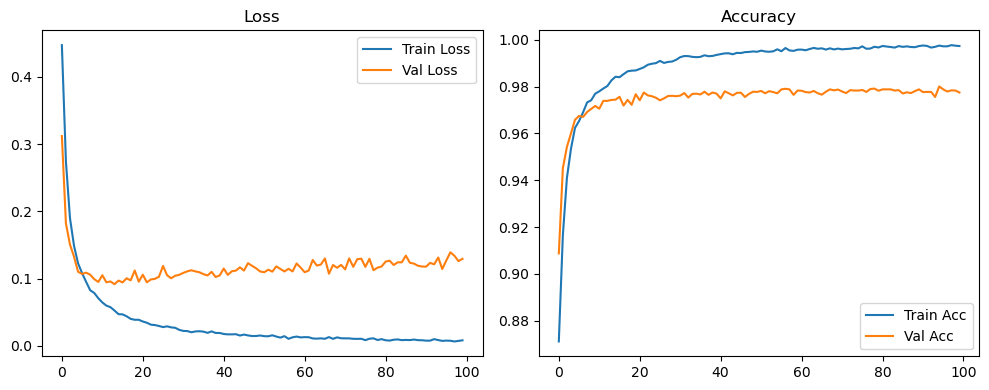

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6109, Acc: 0.8172 | Val Loss: 0.3375, Acc: 0.9021


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.4022, Acc: 0.8771 | Val Loss: 0.2657, Acc: 0.9203


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.3425, Acc: 0.8945 | Val Loss: 0.2326, Acc: 0.9314


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2922, Acc: 0.9109 | Val Loss: 0.2054, Acc: 0.9382


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2572, Acc: 0.9218 | Val Loss: 0.1762, Acc: 0.9473


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2341, Acc: 0.9275 | Val Loss: 0.1743, Acc: 0.9481


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.2212, Acc: 0.9326 | Val Loss: 0.1630, Acc: 0.9517


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1993, Acc: 0.9388 | Val Loss: 0.1521, Acc: 0.9554


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1908, Acc: 0.9414 | Val Loss: 0.1418, Acc: 0.9582


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1772, Acc: 0.9460 | Val Loss: 0.1458, Acc: 0.9574


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1715, Acc: 0.9473 | Val Loss: 0.1421, Acc: 0.9579


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1619, Acc: 0.9498 | Val Loss: 0.1286, Acc: 0.9621


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1560, Acc: 0.9511 | Val Loss: 0.1406, Acc: 0.9603


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1492, Acc: 0.9533 | Val Loss: 0.1306, Acc: 0.9628


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1410, Acc: 0.9566 | Val Loss: 0.1259, Acc: 0.9643


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1372, Acc: 0.9566 | Val Loss: 0.1257, Acc: 0.9644


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1285, Acc: 0.9593 | Val Loss: 0.1334, Acc: 0.9642


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1257, Acc: 0.9604 | Val Loss: 0.1295, Acc: 0.9640


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1243, Acc: 0.9615 | Val Loss: 0.1237, Acc: 0.9653


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1168, Acc: 0.9631 | Val Loss: 0.1244, Acc: 0.9657


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1169, Acc: 0.9632 | Val Loss: 0.1198, Acc: 0.9665


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1095, Acc: 0.9646 | Val Loss: 0.1187, Acc: 0.9684


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1040, Acc: 0.9666 | Val Loss: 0.1181, Acc: 0.9692


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1052, Acc: 0.9666 | Val Loss: 0.1157, Acc: 0.9692


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.1022, Acc: 0.9674 | Val Loss: 0.1172, Acc: 0.9675


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0956, Acc: 0.9696 | Val Loss: 0.1150, Acc: 0.9691


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0952, Acc: 0.9689 | Val Loss: 0.1155, Acc: 0.9688


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0908, Acc: 0.9708 | Val Loss: 0.1236, Acc: 0.9686


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0902, Acc: 0.9712 | Val Loss: 0.1176, Acc: 0.9696


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0865, Acc: 0.9719 | Val Loss: 0.1230, Acc: 0.9683


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0845, Acc: 0.9729 | Val Loss: 0.1144, Acc: 0.9689


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0838, Acc: 0.9730 | Val Loss: 0.1164, Acc: 0.9701


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0771, Acc: 0.9756 | Val Loss: 0.1179, Acc: 0.9698


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0794, Acc: 0.9750 | Val Loss: 0.1165, Acc: 0.9695


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0778, Acc: 0.9743 | Val Loss: 0.1187, Acc: 0.9712


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0753, Acc: 0.9754 | Val Loss: 0.1160, Acc: 0.9702


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0731, Acc: 0.9762 | Val Loss: 0.1162, Acc: 0.9698


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0705, Acc: 0.9765 | Val Loss: 0.1188, Acc: 0.9698


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0703, Acc: 0.9765 | Val Loss: 0.1146, Acc: 0.9716


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0702, Acc: 0.9768 | Val Loss: 0.1197, Acc: 0.9702


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0681, Acc: 0.9780 | Val Loss: 0.1186, Acc: 0.9707


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0656, Acc: 0.9780 | Val Loss: 0.1207, Acc: 0.9712


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0645, Acc: 0.9790 | Val Loss: 0.1214, Acc: 0.9698


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0650, Acc: 0.9790 | Val Loss: 0.1168, Acc: 0.9704


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0610, Acc: 0.9793 | Val Loss: 0.1185, Acc: 0.9699


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0616, Acc: 0.9799 | Val Loss: 0.1189, Acc: 0.9687


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0596, Acc: 0.9801 | Val Loss: 0.1251, Acc: 0.9697


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0600, Acc: 0.9805 | Val Loss: 0.1156, Acc: 0.9716


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0534, Acc: 0.9826 | Val Loss: 0.1248, Acc: 0.9711


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0587, Acc: 0.9803 | Val Loss: 0.1160, Acc: 0.9715


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0544, Acc: 0.9817 | Val Loss: 0.1208, Acc: 0.9715


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0563, Acc: 0.9818 | Val Loss: 0.1188, Acc: 0.9708


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0516, Acc: 0.9826 | Val Loss: 0.1176, Acc: 0.9728


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0503, Acc: 0.9836 | Val Loss: 0.1195, Acc: 0.9717


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0547, Acc: 0.9820 | Val Loss: 0.1136, Acc: 0.9717


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0521, Acc: 0.9828 | Val Loss: 0.1130, Acc: 0.9729


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0497, Acc: 0.9828 | Val Loss: 0.1196, Acc: 0.9718


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0502, Acc: 0.9838 | Val Loss: 0.1162, Acc: 0.9726


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.1176, Acc: 0.9718


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0486, Acc: 0.9834 | Val Loss: 0.1207, Acc: 0.9708


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0477, Acc: 0.9843 | Val Loss: 0.1185, Acc: 0.9707


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0477, Acc: 0.9840 | Val Loss: 0.1183, Acc: 0.9710


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0453, Acc: 0.9851 | Val Loss: 0.1193, Acc: 0.9719


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9845 | Val Loss: 0.1206, Acc: 0.9722


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0432, Acc: 0.9859 | Val Loss: 0.1195, Acc: 0.9720


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9865 | Val Loss: 0.1263, Acc: 0.9728


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9857 | Val Loss: 0.1170, Acc: 0.9730


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9860 | Val Loss: 0.1244, Acc: 0.9724


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9857 | Val Loss: 0.1210, Acc: 0.9719


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0421, Acc: 0.9859 | Val Loss: 0.1205, Acc: 0.9722


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9868 | Val Loss: 0.1186, Acc: 0.9739


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9867 | Val Loss: 0.1232, Acc: 0.9723


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9878 | Val Loss: 0.1233, Acc: 0.9722


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0393, Acc: 0.9866 | Val Loss: 0.1239, Acc: 0.9743


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0393, Acc: 0.9868 | Val Loss: 0.1262, Acc: 0.9725


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0392, Acc: 0.9870 | Val Loss: 0.1172, Acc: 0.9747


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9874 | Val Loss: 0.1191, Acc: 0.9740


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9872 | Val Loss: 0.1235, Acc: 0.9728


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9880 | Val Loss: 0.1221, Acc: 0.9730


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9873 | Val Loss: 0.1224, Acc: 0.9732


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9872 | Val Loss: 0.1212, Acc: 0.9731


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9872 | Val Loss: 0.1198, Acc: 0.9735


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9886 | Val Loss: 0.1204, Acc: 0.9731


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9883 | Val Loss: 0.1252, Acc: 0.9726


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9876 | Val Loss: 0.1192, Acc: 0.9742


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9883 | Val Loss: 0.1232, Acc: 0.9737


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 0.1255, Acc: 0.9722


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9899 | Val Loss: 0.1308, Acc: 0.9728


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9892 | Val Loss: 0.1239, Acc: 0.9728


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9888 | Val Loss: 0.1322, Acc: 0.9739


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9904 | Val Loss: 0.1277, Acc: 0.9727


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9891 | Val Loss: 0.1285, Acc: 0.9730


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9890 | Val Loss: 0.1210, Acc: 0.9733


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9893 | Val Loss: 0.1298, Acc: 0.9731


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9896 | Val Loss: 0.1253, Acc: 0.9734


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9904 | Val Loss: 0.1281, Acc: 0.9722


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9893 | Val Loss: 0.1218, Acc: 0.9742


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9906 | Val Loss: 0.1292, Acc: 0.9736


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9889 | Val Loss: 0.1219, Acc: 0.9753


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9903 | Val Loss: 0.1261, Acc: 0.9744


Final Test Loss: 0.1073 Accuracy: 0.9764


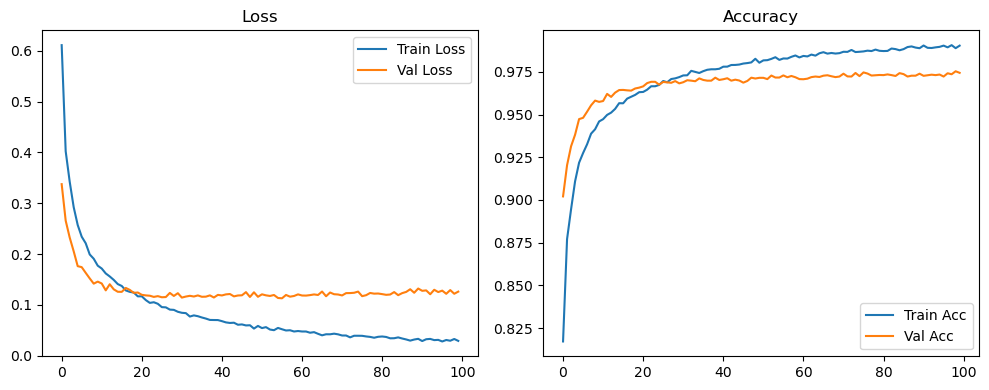

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5135, Acc: 0.8530 | Val Loss: 0.3342, Acc: 0.9018


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2365, Acc: 0.9292 | Val Loss: 0.2096, Acc: 0.9354


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1352, Acc: 0.9593 | Val Loss: 0.1673, Acc: 0.9515


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9740 | Val Loss: 0.1274, Acc: 0.9629


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9833 | Val Loss: 0.1080, Acc: 0.9688


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9854 | Val Loss: 0.1671, Acc: 0.9590


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9875 | Val Loss: 0.1163, Acc: 0.9696


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 0.1297, Acc: 0.9663


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.1410, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.1528, Acc: 0.9626


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1517, Acc: 0.9669


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1204, Acc: 0.9723


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.2220, Acc: 0.9569


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9935 | Val Loss: 0.1430, Acc: 0.9684


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1358, Acc: 0.9729


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1271, Acc: 0.9728


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1236, Acc: 0.9720


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1434, Acc: 0.9673


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1749, Acc: 0.9670


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.1461, Acc: 0.9676


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1558, Acc: 0.9679


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1644, Acc: 0.9686


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1668, Acc: 0.9681


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1549, Acc: 0.9720


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1727, Acc: 0.9699


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1226, Acc: 0.9740


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1576, Acc: 0.9693


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1357, Acc: 0.9715


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1510, Acc: 0.9723


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1653, Acc: 0.9712


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1476, Acc: 0.9742


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.2064, Acc: 0.9631


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1706, Acc: 0.9726


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1213, Acc: 0.9715


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1760, Acc: 0.9659


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.1333, Acc: 0.9740


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1369, Acc: 0.9764


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1700, Acc: 0.9698


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1534, Acc: 0.9731


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1494, Acc: 0.9732


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1727, Acc: 0.9732


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.2856, Acc: 0.9415


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1427, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1641, Acc: 0.9712


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1737, Acc: 0.9723


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1501, Acc: 0.9723


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.1512, Acc: 0.9742


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1236, Acc: 0.9765


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1650, Acc: 0.9707


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1595, Acc: 0.9636


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1805, Acc: 0.9681


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1480, Acc: 0.9698


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.6025, Acc: 0.9123


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.2063, Acc: 0.9701


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1347, Acc: 0.9723


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1376, Acc: 0.9736


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1728, Acc: 0.9764


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1609, Acc: 0.9660


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1798, Acc: 0.9719


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1342, Acc: 0.9730


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.1458, Acc: 0.9746


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1322, Acc: 0.9724


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.2300, Acc: 0.9552


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1245, Acc: 0.9746


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1831, Acc: 0.9698


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1624, Acc: 0.9734


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1223, Acc: 0.9728


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1356, Acc: 0.9763


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1619, Acc: 0.9686


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1902, Acc: 0.9741


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1000, Acc: 0.9764


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.2537, Acc: 0.9675


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.2189, Acc: 0.9724


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.4717, Acc: 0.9253


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1479, Acc: 0.9792


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.2019, Acc: 0.9699


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.2155, Acc: 0.9643


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1634, Acc: 0.9787


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.4468, Acc: 0.9077


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1566, Acc: 0.9699


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1099, Acc: 0.9755


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.2358, Acc: 0.9711


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1849, Acc: 0.9701


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1744, Acc: 0.9754


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.2019, Acc: 0.9688


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1610, Acc: 0.9764


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1441, Acc: 0.9773


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1648, Acc: 0.9717


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1804, Acc: 0.9752


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1433, Acc: 0.9759


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1672, Acc: 0.9733


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.4088, Acc: 0.9490


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.2676, Acc: 0.9704


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1710, Acc: 0.9679


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1807, Acc: 0.9756


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.2705, Acc: 0.9718


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1623, Acc: 0.9604


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1760, Acc: 0.9742


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1658, Acc: 0.9766


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2771, Acc: 0.9627


Final Test Loss: 0.2724 Accuracy: 0.9642


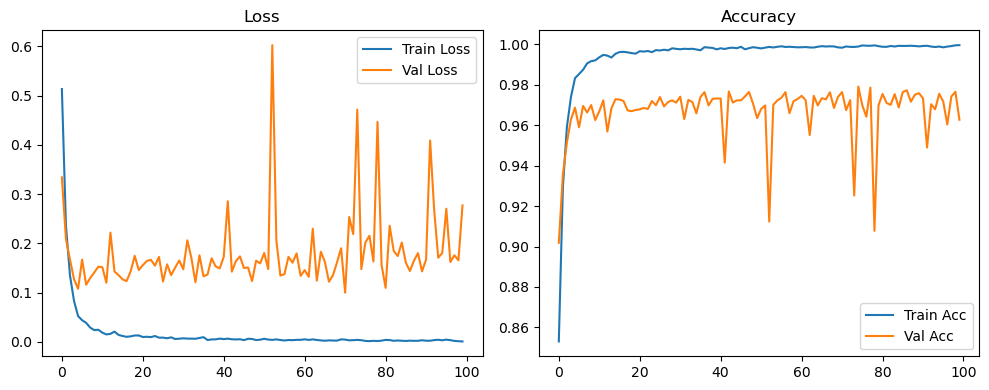

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5346, Acc: 0.8453 | Val Loss: 0.3357, Acc: 0.9028


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2903, Acc: 0.9122 | Val Loss: 0.2399, Acc: 0.9293


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2012, Acc: 0.9396 | Val Loss: 0.1841, Acc: 0.9474


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1398, Acc: 0.9582 | Val Loss: 0.1506, Acc: 0.9555


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1082, Acc: 0.9663 | Val Loss: 0.1259, Acc: 0.9627


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0910, Acc: 0.9717 | Val Loss: 0.1262, Acc: 0.9634


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0795, Acc: 0.9750 | Val Loss: 0.1211, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9791 | Val Loss: 0.1218, Acc: 0.9658


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9814 | Val Loss: 0.1130, Acc: 0.9702


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9833 | Val Loss: 0.1195, Acc: 0.9697


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9839 | Val Loss: 0.1048, Acc: 0.9696


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9864 | Val Loss: 0.1030, Acc: 0.9728


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9871 | Val Loss: 0.1181, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9890 | Val Loss: 0.1129, Acc: 0.9716


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9893 | Val Loss: 0.1124, Acc: 0.9722


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9894 | Val Loss: 0.1266, Acc: 0.9699


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9898 | Val Loss: 0.1140, Acc: 0.9707


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9909 | Val Loss: 0.1267, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9913 | Val Loss: 0.1041, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9917 | Val Loss: 0.1150, Acc: 0.9733


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.1194, Acc: 0.9719


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.1335, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.1356, Acc: 0.9722


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.1217, Acc: 0.9742


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.1233, Acc: 0.9723


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9937 | Val Loss: 0.1173, Acc: 0.9741


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9937 | Val Loss: 0.1163, Acc: 0.9750


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1472, Acc: 0.9715


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.1220, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.1165, Acc: 0.9748


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.1168, Acc: 0.9739


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1292, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1156, Acc: 0.9755


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1099, Acc: 0.9757


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.1218, Acc: 0.9744


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1159, Acc: 0.9755


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1178, Acc: 0.9754


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1294, Acc: 0.9765


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.1136, Acc: 0.9730


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.1170, Acc: 0.9756


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1371, Acc: 0.9750


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1168, Acc: 0.9762


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1196, Acc: 0.9752


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1120, Acc: 0.9756


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.1176, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1152, Acc: 0.9739


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1328, Acc: 0.9767


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1072, Acc: 0.9765


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1357, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0968, Acc: 0.9760


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1373, Acc: 0.9754


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1087, Acc: 0.9767


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1377, Acc: 0.9772


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1271, Acc: 0.9776


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.1287, Acc: 0.9748


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1364, Acc: 0.9755


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1326, Acc: 0.9760


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1087, Acc: 0.9748


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1472, Acc: 0.9738


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1270, Acc: 0.9730


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1262, Acc: 0.9769


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1443, Acc: 0.9781


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.1366, Acc: 0.9774


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1410, Acc: 0.9767


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1186, Acc: 0.9768


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1386, Acc: 0.9778


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1327, Acc: 0.9755


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1110, Acc: 0.9788


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1285, Acc: 0.9777


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1584, Acc: 0.9772


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1336, Acc: 0.9766


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.1215, Acc: 0.9736


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1387, Acc: 0.9762


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1115, Acc: 0.9771


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1592, Acc: 0.9786


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1286, Acc: 0.9760


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1544, Acc: 0.9778


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1046, Acc: 0.9764


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1355, Acc: 0.9772


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1100, Acc: 0.9775


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1527, Acc: 0.9768


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1188, Acc: 0.9766


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.1242, Acc: 0.9776


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1055, Acc: 0.9772


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1520, Acc: 0.9778


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1002, Acc: 0.9771


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1437, Acc: 0.9777


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1225, Acc: 0.9765


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1514, Acc: 0.9767


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1719, Acc: 0.9777


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1170, Acc: 0.9767


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1464, Acc: 0.9777


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1438, Acc: 0.9767


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1616, Acc: 0.9768


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1475, Acc: 0.9772


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1350, Acc: 0.9772


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1318, Acc: 0.9776


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9977 | Val Loss: 0.1651, Acc: 0.9768


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1282, Acc: 0.9768


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1530, Acc: 0.9765


Final Test Loss: 0.1446 Accuracy: 0.9799


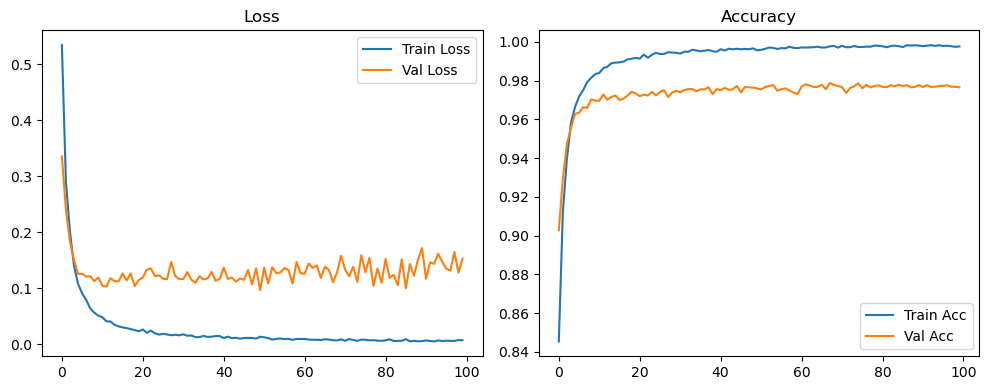

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6482, Acc: 0.8107 | Val Loss: 0.3490, Acc: 0.8988


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3814, Acc: 0.8857 | Val Loss: 0.2751, Acc: 0.9189


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2935, Acc: 0.9119 | Val Loss: 0.2015, Acc: 0.9417


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2306, Acc: 0.9318 | Val Loss: 0.1795, Acc: 0.9477


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1884, Acc: 0.9434 | Val Loss: 0.1541, Acc: 0.9553


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1623, Acc: 0.9506 | Val Loss: 0.1431, Acc: 0.9595


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1422, Acc: 0.9564 | Val Loss: 0.1313, Acc: 0.9613


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1253, Acc: 0.9618 | Val Loss: 0.1357, Acc: 0.9622


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1117, Acc: 0.9662 | Val Loss: 0.1192, Acc: 0.9652


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1043, Acc: 0.9675 | Val Loss: 0.1131, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0924, Acc: 0.9710 | Val Loss: 0.1063, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9729 | Val Loss: 0.1022, Acc: 0.9709


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9741 | Val Loss: 0.1206, Acc: 0.9690


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9756 | Val Loss: 0.1003, Acc: 0.9736


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9779 | Val Loss: 0.1144, Acc: 0.9709


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0655, Acc: 0.9791 | Val Loss: 0.1034, Acc: 0.9728


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9800 | Val Loss: 0.1069, Acc: 0.9716


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9825 | Val Loss: 0.1017, Acc: 0.9725


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9833 | Val Loss: 0.0969, Acc: 0.9745


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9831 | Val Loss: 0.0956, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9832 | Val Loss: 0.0910, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9845 | Val Loss: 0.0934, Acc: 0.9756


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9859 | Val Loss: 0.0941, Acc: 0.9746


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9856 | Val Loss: 0.0971, Acc: 0.9771


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9852 | Val Loss: 0.0949, Acc: 0.9751


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9861 | Val Loss: 0.1186, Acc: 0.9743


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9871 | Val Loss: 0.1031, Acc: 0.9759


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9875 | Val Loss: 0.1094, Acc: 0.9752


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9875 | Val Loss: 0.0928, Acc: 0.9772


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9890 | Val Loss: 0.0958, Acc: 0.9744


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9890 | Val Loss: 0.0951, Acc: 0.9754


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.1015, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.1079, Acc: 0.9768


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9897 | Val Loss: 0.0912, Acc: 0.9769


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.1125, Acc: 0.9762


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.1072, Acc: 0.9766


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.1101, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9906 | Val Loss: 0.0918, Acc: 0.9768


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9905 | Val Loss: 0.0928, Acc: 0.9772


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.1032, Acc: 0.9772


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.1181, Acc: 0.9768


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9917 | Val Loss: 0.0988, Acc: 0.9772


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9920 | Val Loss: 0.1115, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.1098, Acc: 0.9775


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0939, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.1110, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9925 | Val Loss: 0.1134, Acc: 0.9768


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.1113, Acc: 0.9776


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.1039, Acc: 0.9775


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.1042, Acc: 0.9783


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.1089, Acc: 0.9770


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.1032, Acc: 0.9786


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9938 | Val Loss: 0.0930, Acc: 0.9772


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9930 | Val Loss: 0.0921, Acc: 0.9788


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.1054, Acc: 0.9782


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.0986, Acc: 0.9786


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9934 | Val Loss: 0.1074, Acc: 0.9768


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9935 | Val Loss: 0.1023, Acc: 0.9786


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.1270, Acc: 0.9779


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9935 | Val Loss: 0.1062, Acc: 0.9774


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9942 | Val Loss: 0.1130, Acc: 0.9780


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.1228, Acc: 0.9771


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.1004, Acc: 0.9772


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.1352, Acc: 0.9777


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.1036, Acc: 0.9772


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9946 | Val Loss: 0.1270, Acc: 0.9790


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9949 | Val Loss: 0.0865, Acc: 0.9792


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9940 | Val Loss: 0.1003, Acc: 0.9786


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0951, Acc: 0.9798


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0914, Acc: 0.9792


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9945 | Val Loss: 0.1001, Acc: 0.9781


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.1194, Acc: 0.9786


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9949 | Val Loss: 0.1136, Acc: 0.9782


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.1298, Acc: 0.9778


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1267, Acc: 0.9782


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9947 | Val Loss: 0.1283, Acc: 0.9782


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9948 | Val Loss: 0.1276, Acc: 0.9786


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.1038, Acc: 0.9784


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.0973, Acc: 0.9776


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.1021, Acc: 0.9790


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1177, Acc: 0.9803


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1237, Acc: 0.9789


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.1114, Acc: 0.9788


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.1470, Acc: 0.9790


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.1118, Acc: 0.9787


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0975, Acc: 0.9788


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0977, Acc: 0.9791


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1035, Acc: 0.9791


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0999, Acc: 0.9788


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0871, Acc: 0.9792


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9958 | Val Loss: 0.1043, Acc: 0.9795


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.1044, Acc: 0.9790


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1001, Acc: 0.9796


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.1109, Acc: 0.9786


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1224, Acc: 0.9788


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.1044, Acc: 0.9788


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.1129, Acc: 0.9784


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1207, Acc: 0.9798


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0838, Acc: 0.9793


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0944, Acc: 0.9789


Final Test Loss: 0.0860 Accuracy: 0.9801


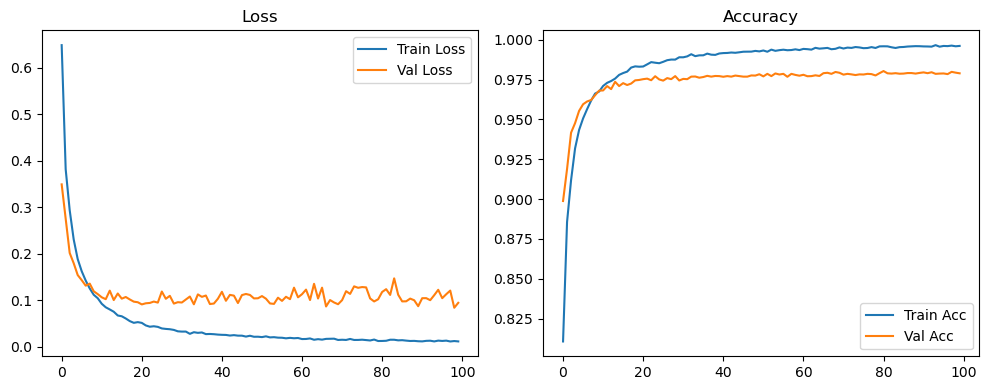

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5135, Acc: 0.8530 | Val Loss: 0.3342, Acc: 0.9018


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2365, Acc: 0.9292 | Val Loss: 0.2096, Acc: 0.9354


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1352, Acc: 0.9593 | Val Loss: 0.1673, Acc: 0.9515


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9740 | Val Loss: 0.1274, Acc: 0.9629


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9833 | Val Loss: 0.1080, Acc: 0.9688


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9854 | Val Loss: 0.1671, Acc: 0.9590


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9875 | Val Loss: 0.1163, Acc: 0.9696


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 0.1297, Acc: 0.9663


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.1410, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.1528, Acc: 0.9626


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1517, Acc: 0.9669


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1204, Acc: 0.9723


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.2220, Acc: 0.9569


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9935 | Val Loss: 0.1430, Acc: 0.9684


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1358, Acc: 0.9729


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1271, Acc: 0.9728


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1236, Acc: 0.9720


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1434, Acc: 0.9673


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1749, Acc: 0.9670


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.1461, Acc: 0.9676


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1558, Acc: 0.9679


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1644, Acc: 0.9686


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1668, Acc: 0.9681


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1549, Acc: 0.9720


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1727, Acc: 0.9699


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1226, Acc: 0.9740


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1576, Acc: 0.9693


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1357, Acc: 0.9715


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1510, Acc: 0.9723


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1653, Acc: 0.9712


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1476, Acc: 0.9742


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.2064, Acc: 0.9631


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1706, Acc: 0.9726


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1213, Acc: 0.9715


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1760, Acc: 0.9659


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.1333, Acc: 0.9740


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1369, Acc: 0.9764


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1700, Acc: 0.9698


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1534, Acc: 0.9731


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1494, Acc: 0.9732


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1727, Acc: 0.9732


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.2856, Acc: 0.9415


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1427, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1641, Acc: 0.9712


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1737, Acc: 0.9723


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1501, Acc: 0.9723


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.1512, Acc: 0.9742


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1236, Acc: 0.9765


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1650, Acc: 0.9707


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1595, Acc: 0.9636


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1460, Acc: 0.9787


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1650, Acc: 0.9784


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1270, Acc: 0.9776


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1769, Acc: 0.9756


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1599, Acc: 0.9786


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1711, Acc: 0.9792


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1847, Acc: 0.9774


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1335, Acc: 0.9796


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1496, Acc: 0.9789


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1668, Acc: 0.9796


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1562, Acc: 0.9789


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1438, Acc: 0.9698


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1375, Acc: 0.9769


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1260, Acc: 0.9754


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1707, Acc: 0.9774


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1795, Acc: 0.9738


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1757, Acc: 0.9731


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1338, Acc: 0.9762


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1505, Acc: 0.9751


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1534, Acc: 0.9732


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1673, Acc: 0.9768


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1726, Acc: 0.9765


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1646, Acc: 0.9748


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1550, Acc: 0.9755


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1593, Acc: 0.9772


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1652, Acc: 0.9771


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2127, Acc: 0.9649


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1544, Acc: 0.9772


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.1436, Acc: 0.9776


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1683, Acc: 0.9779


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1706, Acc: 0.9780


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1733, Acc: 0.9793


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1873, Acc: 0.9787


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1864, Acc: 0.9798


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1865, Acc: 0.9787


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1869, Acc: 0.9791


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1914, Acc: 0.9794


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1962, Acc: 0.9789


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2066, Acc: 0.9788


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2083, Acc: 0.9793


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2211, Acc: 0.9782


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2154, Acc: 0.9793


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2200, Acc: 0.9790


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2137, Acc: 0.9780


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1796, Acc: 0.9797


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1950, Acc: 0.9795


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1953, Acc: 0.9788


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1987, Acc: 0.9782


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2010, Acc: 0.9793


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2118, Acc: 0.9791


Final Test Loss: 0.1952 Accuracy: 0.9802


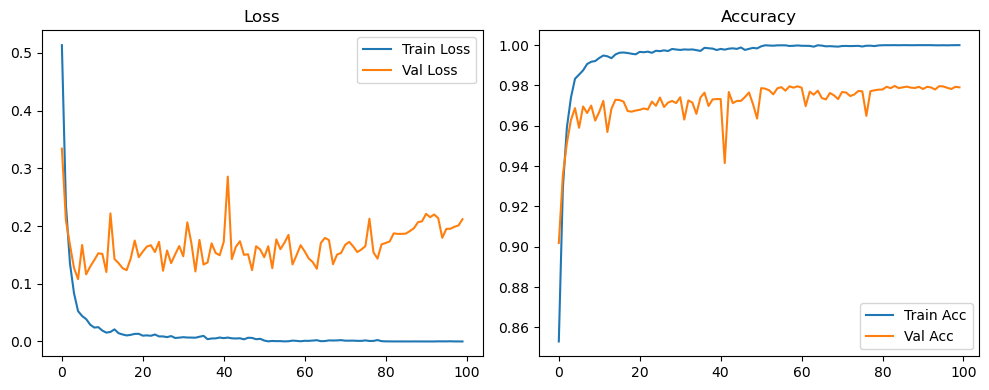

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5346, Acc: 0.8453 | Val Loss: 0.3357, Acc: 0.9028


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2903, Acc: 0.9122 | Val Loss: 0.2399, Acc: 0.9293


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2012, Acc: 0.9396 | Val Loss: 0.1841, Acc: 0.9474


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1398, Acc: 0.9582 | Val Loss: 0.1506, Acc: 0.9555


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1082, Acc: 0.9663 | Val Loss: 0.1259, Acc: 0.9627


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0910, Acc: 0.9717 | Val Loss: 0.1262, Acc: 0.9634


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0795, Acc: 0.9750 | Val Loss: 0.1211, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9791 | Val Loss: 0.1218, Acc: 0.9658


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9814 | Val Loss: 0.1130, Acc: 0.9702


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9833 | Val Loss: 0.1195, Acc: 0.9697


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9839 | Val Loss: 0.1048, Acc: 0.9696


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9864 | Val Loss: 0.1030, Acc: 0.9728


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9871 | Val Loss: 0.1181, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9890 | Val Loss: 0.1129, Acc: 0.9716


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9893 | Val Loss: 0.1124, Acc: 0.9722


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9894 | Val Loss: 0.1266, Acc: 0.9699


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9898 | Val Loss: 0.1140, Acc: 0.9707


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9909 | Val Loss: 0.1267, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9913 | Val Loss: 0.1041, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9917 | Val Loss: 0.1150, Acc: 0.9733


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.1194, Acc: 0.9719


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.1335, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.1356, Acc: 0.9722


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.1217, Acc: 0.9742


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.1233, Acc: 0.9723


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9937 | Val Loss: 0.1173, Acc: 0.9741


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9937 | Val Loss: 0.1163, Acc: 0.9750


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1472, Acc: 0.9715


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.1220, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.1165, Acc: 0.9748


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.1168, Acc: 0.9739


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1292, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1156, Acc: 0.9755


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1099, Acc: 0.9757


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.1218, Acc: 0.9744


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1159, Acc: 0.9755


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1178, Acc: 0.9754


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1294, Acc: 0.9765


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.1136, Acc: 0.9730


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.1170, Acc: 0.9756


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1371, Acc: 0.9750


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1168, Acc: 0.9762


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1196, Acc: 0.9752


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1120, Acc: 0.9756


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.1176, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1152, Acc: 0.9739


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1328, Acc: 0.9767


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1072, Acc: 0.9765


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1357, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0968, Acc: 0.9760


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1194, Acc: 0.9780


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1143, Acc: 0.9781


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1168, Acc: 0.9778


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1332, Acc: 0.9780


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1462, Acc: 0.9782


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1410, Acc: 0.9775


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1434, Acc: 0.9774


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1532, Acc: 0.9773


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1371, Acc: 0.9778


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1684, Acc: 0.9775


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1341, Acc: 0.9772


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1675, Acc: 0.9776


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1476, Acc: 0.9770


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1503, Acc: 0.9782


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1324, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1359, Acc: 0.9778


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1511, Acc: 0.9783


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1526, Acc: 0.9780


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1456, Acc: 0.9794


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1513, Acc: 0.9795


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1232, Acc: 0.9797


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1466, Acc: 0.9782


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1223, Acc: 0.9782


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1387, Acc: 0.9787


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1394, Acc: 0.9784


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1482, Acc: 0.9772


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1158, Acc: 0.9765


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1241, Acc: 0.9778


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1443, Acc: 0.9784


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1264, Acc: 0.9777


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1428, Acc: 0.9788


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1455, Acc: 0.9786


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1406, Acc: 0.9798


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1541, Acc: 0.9787


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1531, Acc: 0.9797


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1687, Acc: 0.9788


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1439, Acc: 0.9789


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1534, Acc: 0.9784


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1491, Acc: 0.9792


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1528, Acc: 0.9798


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1550, Acc: 0.9787


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1531, Acc: 0.9797


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1542, Acc: 0.9793


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1362, Acc: 0.9794


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1593, Acc: 0.9793


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1445, Acc: 0.9793


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1364, Acc: 0.9801


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1629, Acc: 0.9803


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1633, Acc: 0.9800


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1547, Acc: 0.9789


Final Test Loss: 0.1428 Accuracy: 0.9811


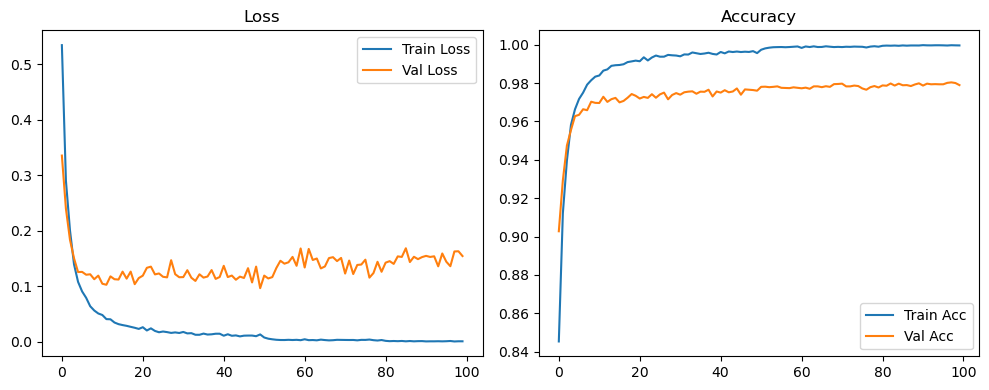

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6482, Acc: 0.8107 | Val Loss: 0.3490, Acc: 0.8988


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3814, Acc: 0.8857 | Val Loss: 0.2751, Acc: 0.9189


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2935, Acc: 0.9119 | Val Loss: 0.2015, Acc: 0.9417


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2306, Acc: 0.9318 | Val Loss: 0.1795, Acc: 0.9477


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1884, Acc: 0.9434 | Val Loss: 0.1541, Acc: 0.9553


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1623, Acc: 0.9506 | Val Loss: 0.1431, Acc: 0.9595


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1422, Acc: 0.9564 | Val Loss: 0.1313, Acc: 0.9613


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1253, Acc: 0.9618 | Val Loss: 0.1357, Acc: 0.9622


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1117, Acc: 0.9662 | Val Loss: 0.1192, Acc: 0.9652


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1043, Acc: 0.9675 | Val Loss: 0.1131, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0924, Acc: 0.9710 | Val Loss: 0.1063, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9729 | Val Loss: 0.1022, Acc: 0.9709


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9741 | Val Loss: 0.1206, Acc: 0.9690


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9756 | Val Loss: 0.1003, Acc: 0.9736


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9779 | Val Loss: 0.1144, Acc: 0.9709


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0655, Acc: 0.9791 | Val Loss: 0.1034, Acc: 0.9728


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9800 | Val Loss: 0.1069, Acc: 0.9716


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9825 | Val Loss: 0.1017, Acc: 0.9725


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9833 | Val Loss: 0.0969, Acc: 0.9745


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9831 | Val Loss: 0.0956, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9832 | Val Loss: 0.0910, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9845 | Val Loss: 0.0934, Acc: 0.9756


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9859 | Val Loss: 0.0941, Acc: 0.9746


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9856 | Val Loss: 0.0971, Acc: 0.9771


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9852 | Val Loss: 0.0949, Acc: 0.9751


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9861 | Val Loss: 0.1186, Acc: 0.9743


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9871 | Val Loss: 0.1031, Acc: 0.9759


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9875 | Val Loss: 0.1094, Acc: 0.9752


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9875 | Val Loss: 0.0928, Acc: 0.9772


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9890 | Val Loss: 0.0958, Acc: 0.9744


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9890 | Val Loss: 0.0951, Acc: 0.9754


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.1015, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.1079, Acc: 0.9768


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9897 | Val Loss: 0.0912, Acc: 0.9769


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.1125, Acc: 0.9762


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.1072, Acc: 0.9766


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.1101, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9906 | Val Loss: 0.0918, Acc: 0.9768


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9905 | Val Loss: 0.0928, Acc: 0.9772


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.1032, Acc: 0.9772


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.1181, Acc: 0.9768


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9917 | Val Loss: 0.0988, Acc: 0.9772


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9920 | Val Loss: 0.1115, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.1098, Acc: 0.9775


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0939, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.1110, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9925 | Val Loss: 0.1134, Acc: 0.9768


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.1113, Acc: 0.9776


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.1039, Acc: 0.9775


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.1042, Acc: 0.9783


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9945 | Val Loss: 0.1064, Acc: 0.9785


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.1043, Acc: 0.9788


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0982, Acc: 0.9793


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0989, Acc: 0.9793


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1088, Acc: 0.9792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0945, Acc: 0.9795


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1160, Acc: 0.9786


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1118, Acc: 0.9795


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1082, Acc: 0.9791


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.1136, Acc: 0.9798


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1098, Acc: 0.9791


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1266, Acc: 0.9791


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1050, Acc: 0.9794


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1254, Acc: 0.9780


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1162, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1145, Acc: 0.9788


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1031, Acc: 0.9800


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1173, Acc: 0.9788


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1276, Acc: 0.9794


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1234, Acc: 0.9785


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1218, Acc: 0.9792


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1211, Acc: 0.9798


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1280, Acc: 0.9798


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1218, Acc: 0.9799


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1116, Acc: 0.9800


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1186, Acc: 0.9791


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1173, Acc: 0.9798


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1204, Acc: 0.9790


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1164, Acc: 0.9801


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1091, Acc: 0.9790


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.1076, Acc: 0.9802


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1145, Acc: 0.9807


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1119, Acc: 0.9808


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1052, Acc: 0.9810


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1282, Acc: 0.9804


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1329, Acc: 0.9802


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1190, Acc: 0.9802


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1185, Acc: 0.9804


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1190, Acc: 0.9807


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.1252, Acc: 0.9806


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1150, Acc: 0.9811


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1140, Acc: 0.9811


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1251, Acc: 0.9805


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1176, Acc: 0.9799


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1171, Acc: 0.9811


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1164, Acc: 0.9808


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1214, Acc: 0.9809


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1323, Acc: 0.9808


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1181, Acc: 0.9808


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1238, Acc: 0.9805


Final Test Loss: 0.1198 Accuracy: 0.9826


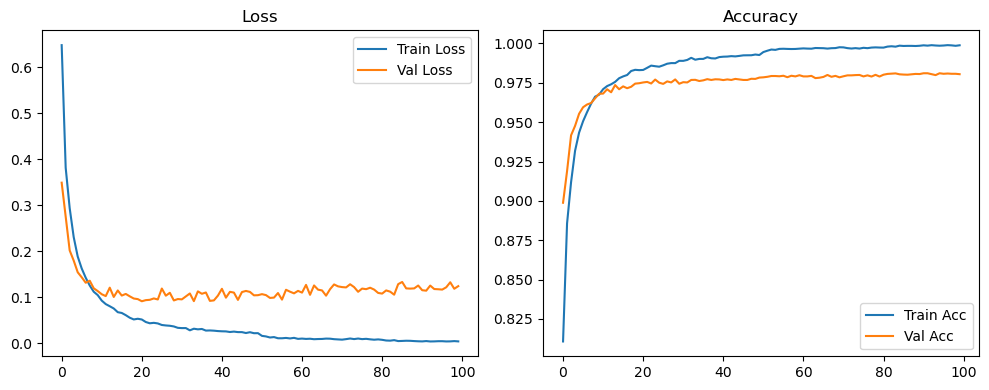

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5135, Acc: 0.8530 | Val Loss: 0.3342, Acc: 0.9018


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2365, Acc: 0.9292 | Val Loss: 0.2096, Acc: 0.9354


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1352, Acc: 0.9593 | Val Loss: 0.1673, Acc: 0.9515


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9740 | Val Loss: 0.1274, Acc: 0.9629


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9833 | Val Loss: 0.1080, Acc: 0.9688


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9854 | Val Loss: 0.1671, Acc: 0.9590


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9875 | Val Loss: 0.1163, Acc: 0.9696


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 0.1297, Acc: 0.9663


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.1410, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.1528, Acc: 0.9626


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1517, Acc: 0.9669


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1204, Acc: 0.9723


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.2220, Acc: 0.9569


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9935 | Val Loss: 0.1430, Acc: 0.9684


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1358, Acc: 0.9729


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1271, Acc: 0.9728


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1236, Acc: 0.9720


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1434, Acc: 0.9673


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1749, Acc: 0.9670


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.1461, Acc: 0.9676


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1558, Acc: 0.9679


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1644, Acc: 0.9686


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1668, Acc: 0.9681


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1549, Acc: 0.9720


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1727, Acc: 0.9699


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1226, Acc: 0.9740


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1576, Acc: 0.9693


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1357, Acc: 0.9715


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1510, Acc: 0.9723


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1653, Acc: 0.9712


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1476, Acc: 0.9742


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.2064, Acc: 0.9631


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1706, Acc: 0.9726


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1213, Acc: 0.9715


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1760, Acc: 0.9659


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.1333, Acc: 0.9740


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1369, Acc: 0.9764


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1700, Acc: 0.9698


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1534, Acc: 0.9731


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1494, Acc: 0.9732


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1727, Acc: 0.9732


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.2856, Acc: 0.9415


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1427, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1641, Acc: 0.9712


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1737, Acc: 0.9723


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1501, Acc: 0.9723


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.1512, Acc: 0.9742


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1236, Acc: 0.9765


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1650, Acc: 0.9707


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1595, Acc: 0.9636


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1460, Acc: 0.9787


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1650, Acc: 0.9784


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1270, Acc: 0.9776


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1769, Acc: 0.9756


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1599, Acc: 0.9786


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1711, Acc: 0.9792


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1847, Acc: 0.9774


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1335, Acc: 0.9796


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1496, Acc: 0.9789


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1668, Acc: 0.9796


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1562, Acc: 0.9789


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1438, Acc: 0.9698


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1375, Acc: 0.9769


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1260, Acc: 0.9754


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1707, Acc: 0.9774


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1795, Acc: 0.9738


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1757, Acc: 0.9731


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1338, Acc: 0.9762


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1505, Acc: 0.9751


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1534, Acc: 0.9732


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1673, Acc: 0.9768


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1726, Acc: 0.9765


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1646, Acc: 0.9748


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1550, Acc: 0.9755


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1593, Acc: 0.9772


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1652, Acc: 0.9771


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2127, Acc: 0.9649


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1544, Acc: 0.9772


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.1436, Acc: 0.9776


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1683, Acc: 0.9779


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1666, Acc: 0.9787


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1705, Acc: 0.9792


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1736, Acc: 0.9789


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1753, Acc: 0.9800


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1764, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1778, Acc: 0.9788


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1823, Acc: 0.9794


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1817, Acc: 0.9792


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1822, Acc: 0.9792


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1841, Acc: 0.9791


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1874, Acc: 0.9789


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1893, Acc: 0.9789


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1885, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1892, Acc: 0.9791


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1932, Acc: 0.9792


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1713, Acc: 0.9798


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1739, Acc: 0.9793


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1738, Acc: 0.9801


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1788, Acc: 0.9799


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1830, Acc: 0.9797


Final Test Loss: 0.1680 Accuracy: 0.9806


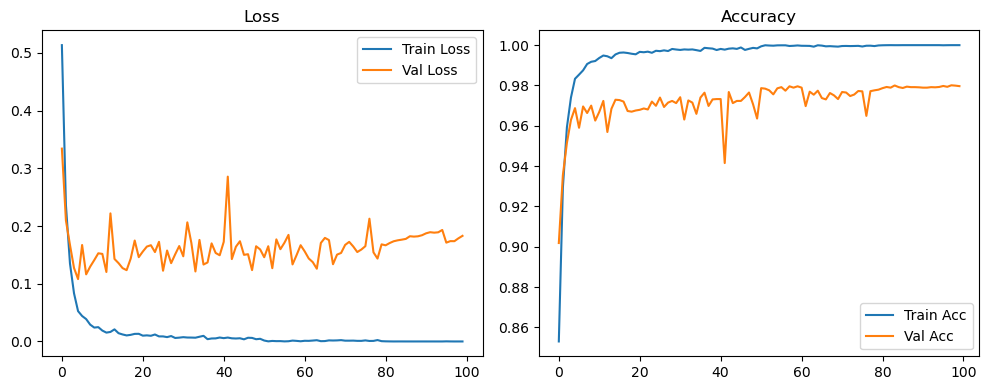

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5346, Acc: 0.8453 | Val Loss: 0.3357, Acc: 0.9028


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2903, Acc: 0.9122 | Val Loss: 0.2399, Acc: 0.9293


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2012, Acc: 0.9396 | Val Loss: 0.1841, Acc: 0.9474


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1398, Acc: 0.9582 | Val Loss: 0.1506, Acc: 0.9555


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1082, Acc: 0.9663 | Val Loss: 0.1259, Acc: 0.9627


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0910, Acc: 0.9717 | Val Loss: 0.1262, Acc: 0.9634


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0795, Acc: 0.9750 | Val Loss: 0.1211, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9791 | Val Loss: 0.1218, Acc: 0.9658


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9814 | Val Loss: 0.1130, Acc: 0.9702


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9833 | Val Loss: 0.1195, Acc: 0.9697


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9839 | Val Loss: 0.1048, Acc: 0.9696


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9864 | Val Loss: 0.1030, Acc: 0.9728


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9871 | Val Loss: 0.1181, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9890 | Val Loss: 0.1129, Acc: 0.9716


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9893 | Val Loss: 0.1124, Acc: 0.9722


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9894 | Val Loss: 0.1266, Acc: 0.9699


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9898 | Val Loss: 0.1140, Acc: 0.9707


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9909 | Val Loss: 0.1267, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9913 | Val Loss: 0.1041, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9917 | Val Loss: 0.1150, Acc: 0.9733


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.1194, Acc: 0.9719


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.1335, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.1356, Acc: 0.9722


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.1217, Acc: 0.9742


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.1233, Acc: 0.9723


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9937 | Val Loss: 0.1173, Acc: 0.9741


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9937 | Val Loss: 0.1163, Acc: 0.9750


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1472, Acc: 0.9715


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.1220, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.1165, Acc: 0.9748


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.1168, Acc: 0.9739


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1292, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1156, Acc: 0.9755


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1099, Acc: 0.9757


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.1218, Acc: 0.9744


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1159, Acc: 0.9755


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1178, Acc: 0.9754


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1294, Acc: 0.9765


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.1136, Acc: 0.9730


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.1170, Acc: 0.9756


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1371, Acc: 0.9750


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1168, Acc: 0.9762


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1196, Acc: 0.9752


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1120, Acc: 0.9756


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.1176, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1152, Acc: 0.9739


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1328, Acc: 0.9767


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1072, Acc: 0.9765


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1357, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0968, Acc: 0.9760


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1194, Acc: 0.9780


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1143, Acc: 0.9781


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1168, Acc: 0.9778


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1332, Acc: 0.9780


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1462, Acc: 0.9782


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1410, Acc: 0.9775


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1434, Acc: 0.9774


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1532, Acc: 0.9773


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1371, Acc: 0.9778


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1684, Acc: 0.9775


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1341, Acc: 0.9772


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1675, Acc: 0.9776


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1476, Acc: 0.9770


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1503, Acc: 0.9782


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1324, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1359, Acc: 0.9778


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1511, Acc: 0.9783


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1526, Acc: 0.9780


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1456, Acc: 0.9794


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1513, Acc: 0.9795


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1232, Acc: 0.9797


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1466, Acc: 0.9782


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1223, Acc: 0.9782


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1387, Acc: 0.9787


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1394, Acc: 0.9784


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1482, Acc: 0.9772


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1158, Acc: 0.9765


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1241, Acc: 0.9778


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1443, Acc: 0.9784


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1264, Acc: 0.9777


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1350, Acc: 0.9788


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1466, Acc: 0.9788


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1444, Acc: 0.9788


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1483, Acc: 0.9794


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1505, Acc: 0.9788


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1534, Acc: 0.9797


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1428, Acc: 0.9796


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1455, Acc: 0.9795


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1497, Acc: 0.9795


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1483, Acc: 0.9796


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1557, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1529, Acc: 0.9797


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1599, Acc: 0.9801


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1441, Acc: 0.9794


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1620, Acc: 0.9796


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1591, Acc: 0.9795


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1373, Acc: 0.9798


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1363, Acc: 0.9801


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1426, Acc: 0.9799


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1530, Acc: 0.9799


Final Test Loss: 0.1429 Accuracy: 0.9812


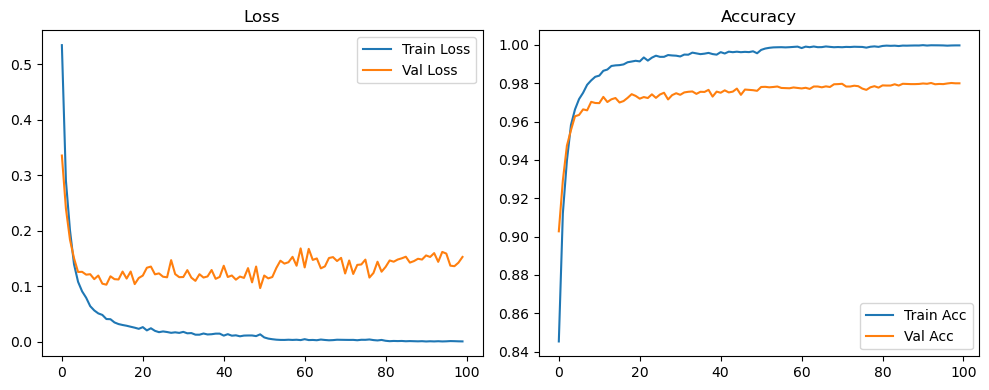

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6482, Acc: 0.8107 | Val Loss: 0.3490, Acc: 0.8988


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3814, Acc: 0.8857 | Val Loss: 0.2751, Acc: 0.9189


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2935, Acc: 0.9119 | Val Loss: 0.2015, Acc: 0.9417


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2306, Acc: 0.9318 | Val Loss: 0.1795, Acc: 0.9477


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1884, Acc: 0.9434 | Val Loss: 0.1541, Acc: 0.9553


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1623, Acc: 0.9506 | Val Loss: 0.1431, Acc: 0.9595


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1422, Acc: 0.9564 | Val Loss: 0.1313, Acc: 0.9613


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1253, Acc: 0.9618 | Val Loss: 0.1357, Acc: 0.9622


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1117, Acc: 0.9662 | Val Loss: 0.1192, Acc: 0.9652


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1043, Acc: 0.9675 | Val Loss: 0.1131, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0924, Acc: 0.9710 | Val Loss: 0.1063, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9729 | Val Loss: 0.1022, Acc: 0.9709


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9741 | Val Loss: 0.1206, Acc: 0.9690


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9756 | Val Loss: 0.1003, Acc: 0.9736


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9779 | Val Loss: 0.1144, Acc: 0.9709


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0655, Acc: 0.9791 | Val Loss: 0.1034, Acc: 0.9728


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9800 | Val Loss: 0.1069, Acc: 0.9716


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9825 | Val Loss: 0.1017, Acc: 0.9725


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9833 | Val Loss: 0.0969, Acc: 0.9745


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9831 | Val Loss: 0.0956, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9832 | Val Loss: 0.0910, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9845 | Val Loss: 0.0934, Acc: 0.9756


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9859 | Val Loss: 0.0941, Acc: 0.9746


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9856 | Val Loss: 0.0971, Acc: 0.9771


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9852 | Val Loss: 0.0949, Acc: 0.9751


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9861 | Val Loss: 0.1186, Acc: 0.9743


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9871 | Val Loss: 0.1031, Acc: 0.9759


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9875 | Val Loss: 0.1094, Acc: 0.9752


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9875 | Val Loss: 0.0928, Acc: 0.9772


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9890 | Val Loss: 0.0958, Acc: 0.9744


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9890 | Val Loss: 0.0951, Acc: 0.9754


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.1015, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.1079, Acc: 0.9768


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9897 | Val Loss: 0.0912, Acc: 0.9769


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.1125, Acc: 0.9762


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.1072, Acc: 0.9766


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.1101, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9906 | Val Loss: 0.0918, Acc: 0.9768


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9905 | Val Loss: 0.0928, Acc: 0.9772


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.1032, Acc: 0.9772


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.1181, Acc: 0.9768


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9917 | Val Loss: 0.0988, Acc: 0.9772


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9920 | Val Loss: 0.1115, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.1098, Acc: 0.9775


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0939, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.1110, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9925 | Val Loss: 0.1134, Acc: 0.9768


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.1113, Acc: 0.9776


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.1039, Acc: 0.9775


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.1042, Acc: 0.9783


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9945 | Val Loss: 0.1064, Acc: 0.9785


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.1043, Acc: 0.9788


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0982, Acc: 0.9793


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0989, Acc: 0.9793


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1088, Acc: 0.9792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0945, Acc: 0.9795


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1160, Acc: 0.9786


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1118, Acc: 0.9795


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1082, Acc: 0.9791


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.1136, Acc: 0.9798


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1098, Acc: 0.9791


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1266, Acc: 0.9791


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1050, Acc: 0.9794


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1254, Acc: 0.9780


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1162, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1145, Acc: 0.9788


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1031, Acc: 0.9800


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1173, Acc: 0.9788


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1276, Acc: 0.9794


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1234, Acc: 0.9785


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1218, Acc: 0.9792


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1211, Acc: 0.9798


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1280, Acc: 0.9798


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1218, Acc: 0.9799


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1116, Acc: 0.9800


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1186, Acc: 0.9791


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1173, Acc: 0.9798


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1204, Acc: 0.9790


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1164, Acc: 0.9801


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1091, Acc: 0.9790


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1047, Acc: 0.9803


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1113, Acc: 0.9801


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1091, Acc: 0.9803


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1087, Acc: 0.9805


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1256, Acc: 0.9798


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1233, Acc: 0.9800


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1169, Acc: 0.9808


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1147, Acc: 0.9807


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1172, Acc: 0.9809


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1273, Acc: 0.9810


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1286, Acc: 0.9812


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1201, Acc: 0.9810


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1196, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1188, Acc: 0.9806


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1224, Acc: 0.9809


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1169, Acc: 0.9816


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1222, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1231, Acc: 0.9807


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1116, Acc: 0.9805


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1158, Acc: 0.9804


Final Test Loss: 0.1159 Accuracy: 0.9825


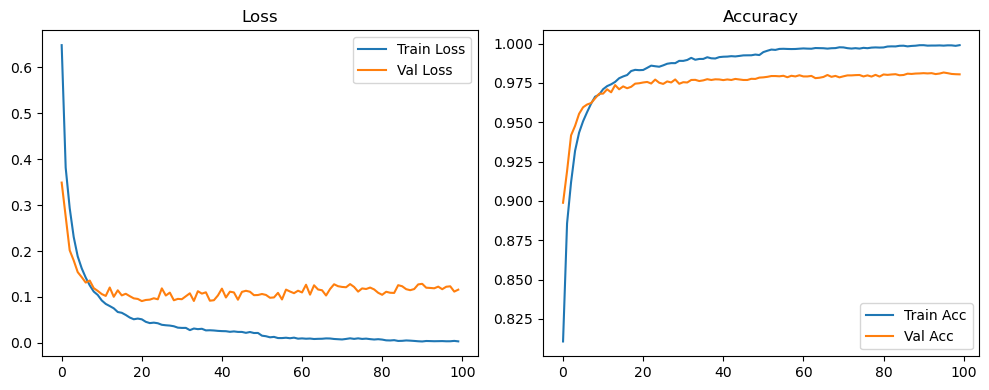

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5135, Acc: 0.8530 | Val Loss: 0.3342, Acc: 0.9018


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2365, Acc: 0.9292 | Val Loss: 0.2096, Acc: 0.9354


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1352, Acc: 0.9593 | Val Loss: 0.1673, Acc: 0.9515


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9740 | Val Loss: 0.1274, Acc: 0.9629


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9833 | Val Loss: 0.1080, Acc: 0.9688


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9854 | Val Loss: 0.1671, Acc: 0.9590


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9875 | Val Loss: 0.1163, Acc: 0.9696


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 0.1297, Acc: 0.9663


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.1410, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.1528, Acc: 0.9626


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1517, Acc: 0.9669


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1204, Acc: 0.9723


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.2220, Acc: 0.9569


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9935 | Val Loss: 0.1430, Acc: 0.9684


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1358, Acc: 0.9729


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1271, Acc: 0.9728


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1236, Acc: 0.9720


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1434, Acc: 0.9673


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1749, Acc: 0.9670


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.1461, Acc: 0.9676


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1558, Acc: 0.9679


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1644, Acc: 0.9686


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1668, Acc: 0.9681


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1549, Acc: 0.9720


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1727, Acc: 0.9699


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1226, Acc: 0.9740


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1576, Acc: 0.9693


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1357, Acc: 0.9715


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1510, Acc: 0.9723


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1653, Acc: 0.9712


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1476, Acc: 0.9742


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.2064, Acc: 0.9631


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1706, Acc: 0.9726


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1213, Acc: 0.9715


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1760, Acc: 0.9659


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.1333, Acc: 0.9740


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1369, Acc: 0.9764


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1700, Acc: 0.9698


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1534, Acc: 0.9731


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1494, Acc: 0.9732


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1727, Acc: 0.9732


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.2856, Acc: 0.9415


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1427, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1641, Acc: 0.9712


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1737, Acc: 0.9723


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1501, Acc: 0.9723


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.1512, Acc: 0.9742


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1236, Acc: 0.9765


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1650, Acc: 0.9707


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1595, Acc: 0.9636


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1311, Acc: 0.9782


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1475, Acc: 0.9778


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1551, Acc: 0.9788


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1595, Acc: 0.9785


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1697, Acc: 0.9779


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1759, Acc: 0.9777


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1759, Acc: 0.9783


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1778, Acc: 0.9790


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1839, Acc: 0.9786


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1824, Acc: 0.9786


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1874, Acc: 0.9788


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1909, Acc: 0.9785


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1935, Acc: 0.9785


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1955, Acc: 0.9788


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1963, Acc: 0.9788


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2000, Acc: 0.9792


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1980, Acc: 0.9774


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1926, Acc: 0.9767


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1757, Acc: 0.9774


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1944, Acc: 0.9768


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1772, Acc: 0.9768


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1854, Acc: 0.9776


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1816, Acc: 0.9785


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1818, Acc: 0.9792


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1853, Acc: 0.9801


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1908, Acc: 0.9802


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2048, Acc: 0.9788


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2021, Acc: 0.9799


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2522, Acc: 0.9729


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1805, Acc: 0.9778


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1828, Acc: 0.9783


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1854, Acc: 0.9789


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1921, Acc: 0.9799


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1954, Acc: 0.9784


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1925, Acc: 0.9794


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1977, Acc: 0.9786


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2054, Acc: 0.9783


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1981, Acc: 0.9796


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1935, Acc: 0.9778


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1897, Acc: 0.9794


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1935, Acc: 0.9779


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1922, Acc: 0.9788


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2110, Acc: 0.9782


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2143, Acc: 0.9785


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2123, Acc: 0.9791


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2127, Acc: 0.9788


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2130, Acc: 0.9794


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2198, Acc: 0.9789


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2174, Acc: 0.9792


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2215, Acc: 0.9795


Final Test Loss: 0.2070 Accuracy: 0.9808


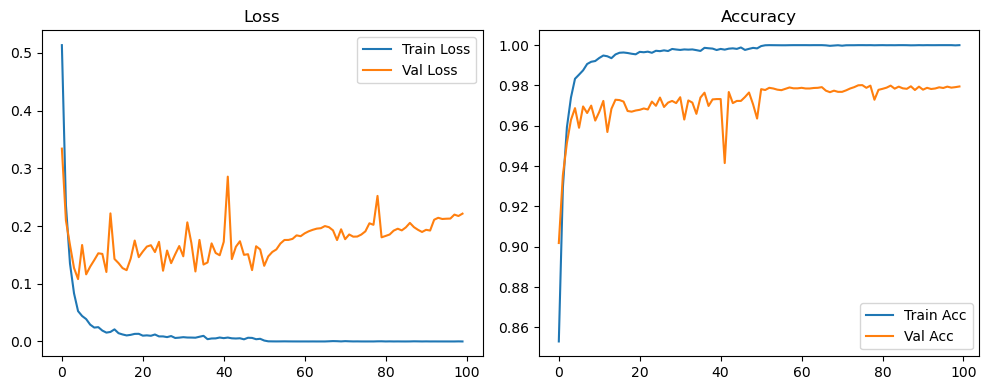

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5346, Acc: 0.8453 | Val Loss: 0.3357, Acc: 0.9028


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2903, Acc: 0.9122 | Val Loss: 0.2399, Acc: 0.9293


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2012, Acc: 0.9396 | Val Loss: 0.1841, Acc: 0.9474


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1398, Acc: 0.9582 | Val Loss: 0.1506, Acc: 0.9555


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1082, Acc: 0.9663 | Val Loss: 0.1259, Acc: 0.9627


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0910, Acc: 0.9717 | Val Loss: 0.1262, Acc: 0.9634


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0795, Acc: 0.9750 | Val Loss: 0.1211, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9791 | Val Loss: 0.1218, Acc: 0.9658


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9814 | Val Loss: 0.1130, Acc: 0.9702


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9833 | Val Loss: 0.1195, Acc: 0.9697


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9839 | Val Loss: 0.1048, Acc: 0.9696


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9864 | Val Loss: 0.1030, Acc: 0.9728


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9871 | Val Loss: 0.1181, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9890 | Val Loss: 0.1129, Acc: 0.9716


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9893 | Val Loss: 0.1124, Acc: 0.9722


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9894 | Val Loss: 0.1266, Acc: 0.9699


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9898 | Val Loss: 0.1140, Acc: 0.9707


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9909 | Val Loss: 0.1267, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9913 | Val Loss: 0.1041, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9917 | Val Loss: 0.1150, Acc: 0.9733


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.1194, Acc: 0.9719


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.1335, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.1356, Acc: 0.9722


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.1217, Acc: 0.9742


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.1233, Acc: 0.9723


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9937 | Val Loss: 0.1173, Acc: 0.9741


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9937 | Val Loss: 0.1163, Acc: 0.9750


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1472, Acc: 0.9715


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.1220, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.1165, Acc: 0.9748


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.1168, Acc: 0.9739


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1292, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1156, Acc: 0.9755


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1099, Acc: 0.9757


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.1218, Acc: 0.9744


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1159, Acc: 0.9755


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1178, Acc: 0.9754


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1294, Acc: 0.9765


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.1136, Acc: 0.9730


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.1170, Acc: 0.9756


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1371, Acc: 0.9750


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1168, Acc: 0.9762


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1196, Acc: 0.9752


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1120, Acc: 0.9756


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.1176, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1152, Acc: 0.9739


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1328, Acc: 0.9767


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1072, Acc: 0.9765


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1357, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0968, Acc: 0.9760


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1201, Acc: 0.9790


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1190, Acc: 0.9790


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1211, Acc: 0.9792


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1365, Acc: 0.9787


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1394, Acc: 0.9784


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1462, Acc: 0.9788


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1404, Acc: 0.9789


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1506, Acc: 0.9784


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1439, Acc: 0.9788


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1518, Acc: 0.9785


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9990 | Val Loss: 0.1489, Acc: 0.9783


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1567, Acc: 0.9777


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.1666, Acc: 0.9779


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1515, Acc: 0.9789


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1613, Acc: 0.9785


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1537, Acc: 0.9788


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.1607, Acc: 0.9788


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1511, Acc: 0.9782


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1607, Acc: 0.9788


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1417, Acc: 0.9790


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1424, Acc: 0.9792


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1551, Acc: 0.9791


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1385, Acc: 0.9797


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1565, Acc: 0.9790


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1528, Acc: 0.9790


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1421, Acc: 0.9790


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1491, Acc: 0.9789


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1673, Acc: 0.9789


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1605, Acc: 0.9795


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1605, Acc: 0.9787


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1633, Acc: 0.9786


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1626, Acc: 0.9784


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1684, Acc: 0.9782


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1734, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1852, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1687, Acc: 0.9798


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1688, Acc: 0.9790


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1471, Acc: 0.9790


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1448, Acc: 0.9800


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1404, Acc: 0.9788


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1575, Acc: 0.9789


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1648, Acc: 0.9797


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1685, Acc: 0.9794


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1457, Acc: 0.9794


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1656, Acc: 0.9792


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1688, Acc: 0.9792


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1659, Acc: 0.9803


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1589, Acc: 0.9792


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1638, Acc: 0.9799


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1680, Acc: 0.9792


Final Test Loss: 0.1550 Accuracy: 0.9814


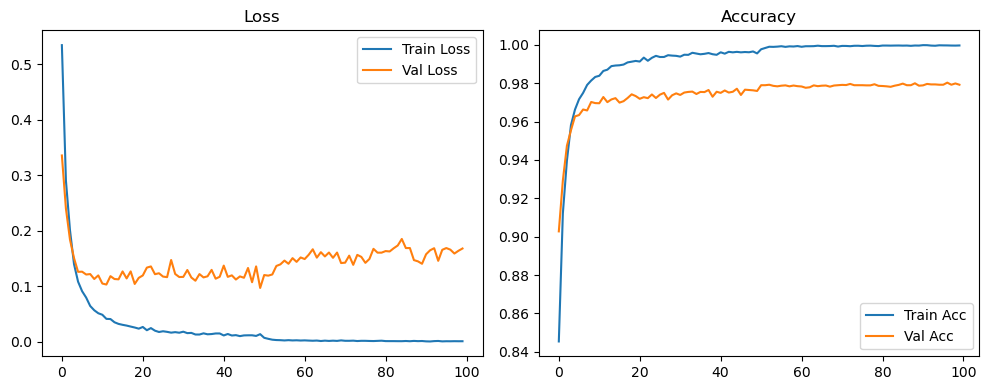

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6482, Acc: 0.8107 | Val Loss: 0.3490, Acc: 0.8988


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3814, Acc: 0.8857 | Val Loss: 0.2751, Acc: 0.9189


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2935, Acc: 0.9119 | Val Loss: 0.2015, Acc: 0.9417


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2306, Acc: 0.9318 | Val Loss: 0.1795, Acc: 0.9477


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1884, Acc: 0.9434 | Val Loss: 0.1541, Acc: 0.9553


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1623, Acc: 0.9506 | Val Loss: 0.1431, Acc: 0.9595


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1422, Acc: 0.9564 | Val Loss: 0.1313, Acc: 0.9613


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1253, Acc: 0.9618 | Val Loss: 0.1357, Acc: 0.9622


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1117, Acc: 0.9662 | Val Loss: 0.1192, Acc: 0.9652


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1043, Acc: 0.9675 | Val Loss: 0.1131, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0924, Acc: 0.9710 | Val Loss: 0.1063, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9729 | Val Loss: 0.1022, Acc: 0.9709


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9741 | Val Loss: 0.1206, Acc: 0.9690


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9756 | Val Loss: 0.1003, Acc: 0.9736


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9779 | Val Loss: 0.1144, Acc: 0.9709


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0655, Acc: 0.9791 | Val Loss: 0.1034, Acc: 0.9728


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9800 | Val Loss: 0.1069, Acc: 0.9716


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9825 | Val Loss: 0.1017, Acc: 0.9725


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9833 | Val Loss: 0.0969, Acc: 0.9745


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9831 | Val Loss: 0.0956, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9832 | Val Loss: 0.0910, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9845 | Val Loss: 0.0934, Acc: 0.9756


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9859 | Val Loss: 0.0941, Acc: 0.9746


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9856 | Val Loss: 0.0971, Acc: 0.9771


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9852 | Val Loss: 0.0949, Acc: 0.9751


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9861 | Val Loss: 0.1186, Acc: 0.9743


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9871 | Val Loss: 0.1031, Acc: 0.9759


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9875 | Val Loss: 0.1094, Acc: 0.9752


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9875 | Val Loss: 0.0928, Acc: 0.9772


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9890 | Val Loss: 0.0958, Acc: 0.9744


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9890 | Val Loss: 0.0951, Acc: 0.9754


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.1015, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.1079, Acc: 0.9768


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9897 | Val Loss: 0.0912, Acc: 0.9769


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.1125, Acc: 0.9762


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.1072, Acc: 0.9766


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.1101, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9906 | Val Loss: 0.0918, Acc: 0.9768


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9905 | Val Loss: 0.0928, Acc: 0.9772


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.1032, Acc: 0.9772


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.1181, Acc: 0.9768


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9917 | Val Loss: 0.0988, Acc: 0.9772


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9920 | Val Loss: 0.1115, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.1098, Acc: 0.9775


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0939, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.1110, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9925 | Val Loss: 0.1134, Acc: 0.9768


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.1113, Acc: 0.9776


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.1039, Acc: 0.9775


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.1042, Acc: 0.9783


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9946 | Val Loss: 0.1058, Acc: 0.9793


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.1085, Acc: 0.9796


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1030, Acc: 0.9792


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1041, Acc: 0.9790


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1097, Acc: 0.9792


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9964 | Val Loss: 0.0955, Acc: 0.9798


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1104, Acc: 0.9802


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1110, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1069, Acc: 0.9798


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1094, Acc: 0.9794


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1190, Acc: 0.9802


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1143, Acc: 0.9794


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1183, Acc: 0.9791


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1168, Acc: 0.9790


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1222, Acc: 0.9798


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1108, Acc: 0.9798


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1143, Acc: 0.9798


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1114, Acc: 0.9809


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1155, Acc: 0.9795


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1215, Acc: 0.9796


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1146, Acc: 0.9801


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1159, Acc: 0.9803


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1169, Acc: 0.9796


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.1062, Acc: 0.9795


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1118, Acc: 0.9798


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1140, Acc: 0.9804


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1213, Acc: 0.9797


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1119, Acc: 0.9796


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1221, Acc: 0.9795


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1194, Acc: 0.9802


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1172, Acc: 0.9803


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1159, Acc: 0.9801


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.1191, Acc: 0.9803


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1255, Acc: 0.9799


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1337, Acc: 0.9796


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1256, Acc: 0.9799


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.1249, Acc: 0.9800


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1195, Acc: 0.9804


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1229, Acc: 0.9802


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1251, Acc: 0.9801


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1283, Acc: 0.9799


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.1305, Acc: 0.9807


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1275, Acc: 0.9803


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1324, Acc: 0.9802


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1284, Acc: 0.9800


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1252, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1302, Acc: 0.9806


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1245, Acc: 0.9805


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1321, Acc: 0.9806


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1261, Acc: 0.9803


Final Test Loss: 0.1200 Accuracy: 0.9819


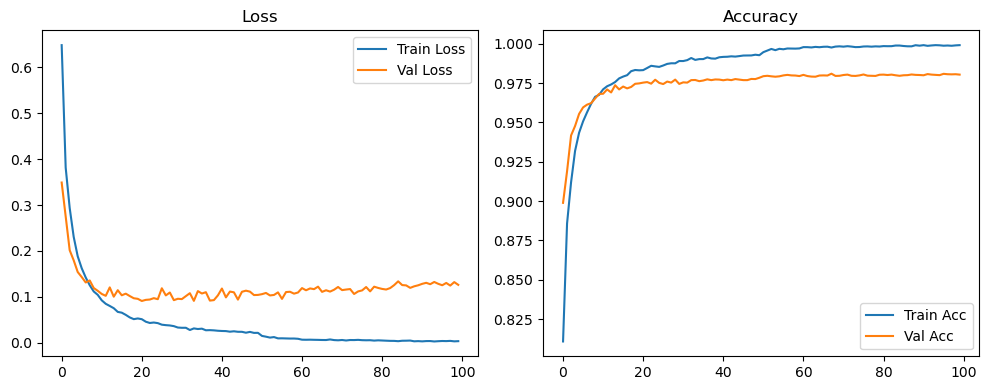

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4103, Acc: 0.8763 | Val Loss: 0.3232, Acc: 0.9062


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2441, Acc: 0.9255 | Val Loss: 0.2530, Acc: 0.9204


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1426, Acc: 0.9574 | Val Loss: 0.1543, Acc: 0.9542


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0823, Acc: 0.9743 | Val Loss: 0.1188, Acc: 0.9664


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9846 | Val Loss: 0.1146, Acc: 0.9670


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9871 | Val Loss: 0.1438, Acc: 0.9623


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.1308, Acc: 0.9672


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.1442, Acc: 0.9656


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9943 | Val Loss: 0.1283, Acc: 0.9703


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.1226, Acc: 0.9711


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9926 | Val Loss: 0.2093, Acc: 0.9546


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9944 | Val Loss: 0.1252, Acc: 0.9718


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.1386, Acc: 0.9720


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1282, Acc: 0.9731


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1366, Acc: 0.9708


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1964, Acc: 0.9604


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1638, Acc: 0.9672


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.1954, Acc: 0.9623


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9952 | Val Loss: 0.1460, Acc: 0.9718


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1781, Acc: 0.9705


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1572, Acc: 0.9725


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1638, Acc: 0.9671


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1415, Acc: 0.9748


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1595, Acc: 0.9728


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1771, Acc: 0.9701


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1335, Acc: 0.9759


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1891, Acc: 0.9704


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9971 | Val Loss: 0.1571, Acc: 0.9699


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1278, Acc: 0.9754


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1864, Acc: 0.9722


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1773, Acc: 0.9685


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1797, Acc: 0.9720


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9980 | Val Loss: 0.1321, Acc: 0.9692


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1416, Acc: 0.9737


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1634, Acc: 0.9713


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1773, Acc: 0.9683


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1391, Acc: 0.9740


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1630, Acc: 0.9720


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1704, Acc: 0.9698


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1340, Acc: 0.9730


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1428, Acc: 0.9742


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1556, Acc: 0.9759


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1819, Acc: 0.9701


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1267, Acc: 0.9768


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1315, Acc: 0.9767


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1706, Acc: 0.9741


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1420, Acc: 0.9763


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1663, Acc: 0.9728


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2434, Acc: 0.9578


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1395, Acc: 0.9751


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1519, Acc: 0.9765


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1410, Acc: 0.9774


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1333, Acc: 0.9773


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1526, Acc: 0.9753


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1627, Acc: 0.9718


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.5285, Acc: 0.9151


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1299, Acc: 0.9760


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1556, Acc: 0.9772


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1487, Acc: 0.9726


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1743, Acc: 0.9618


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1743, Acc: 0.9751


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1428, Acc: 0.9782


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1319, Acc: 0.9789


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1567, Acc: 0.9790


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1467, Acc: 0.9785


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1551, Acc: 0.9770


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1710, Acc: 0.9751


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1496, Acc: 0.9776


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1484, Acc: 0.9778


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1357, Acc: 0.9788


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1337, Acc: 0.9789


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1664, Acc: 0.9762


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1020, Acc: 0.9768


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1293, Acc: 0.9778


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1521, Acc: 0.9787


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1712, Acc: 0.9746


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1566, Acc: 0.9761


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1547, Acc: 0.9715


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1540, Acc: 0.9782


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1589, Acc: 0.9762


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1989, Acc: 0.9717


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1444, Acc: 0.9751


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.1290, Acc: 0.9791


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1583, Acc: 0.9743


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1419, Acc: 0.9755


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1505, Acc: 0.9772


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1486, Acc: 0.9786


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1335, Acc: 0.9785


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1512, Acc: 0.9756


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1569, Acc: 0.9758


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.2379, Acc: 0.9643


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1651, Acc: 0.9734


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1253, Acc: 0.9763


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1039, Acc: 0.9768


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1415, Acc: 0.9783


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1536, Acc: 0.9764


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1634, Acc: 0.9779


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1485, Acc: 0.9767


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1598, Acc: 0.9775


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1873, Acc: 0.9724


Final Test Loss: 0.1585 Accuracy: 0.9753


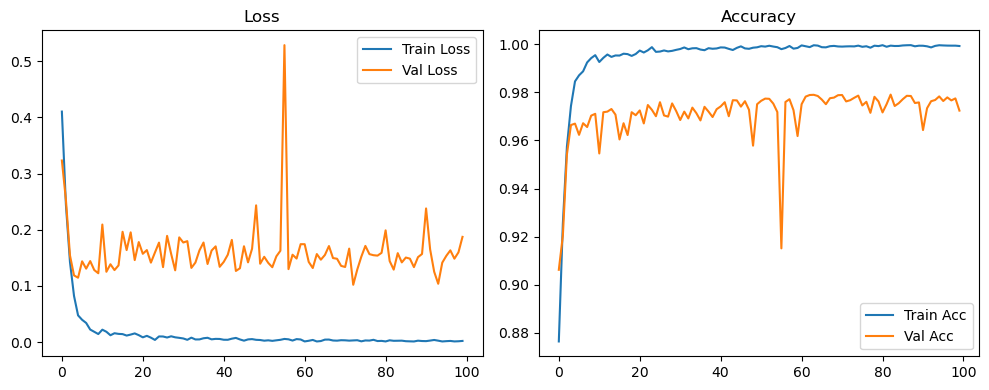

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4471, Acc: 0.8643 | Val Loss: 0.3314, Acc: 0.9029


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3018, Acc: 0.9089 | Val Loss: 0.2431, Acc: 0.9277


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2138, Acc: 0.9356 | Val Loss: 0.1856, Acc: 0.9461


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1537, Acc: 0.9540 | Val Loss: 0.1611, Acc: 0.9521


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1218, Acc: 0.9615 | Val Loss: 0.1275, Acc: 0.9618


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1027, Acc: 0.9682 | Val Loss: 0.1313, Acc: 0.9617


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0888, Acc: 0.9715 | Val Loss: 0.1263, Acc: 0.9645


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0722, Acc: 0.9764 | Val Loss: 0.1229, Acc: 0.9645


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0674, Acc: 0.9789 | Val Loss: 0.1138, Acc: 0.9688


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0560, Acc: 0.9823 | Val Loss: 0.1082, Acc: 0.9699


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9828 | Val Loss: 0.1105, Acc: 0.9698


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9864 | Val Loss: 0.1056, Acc: 0.9718


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9852 | Val Loss: 0.1028, Acc: 0.9719


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9873 | Val Loss: 0.1028, Acc: 0.9735


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9870 | Val Loss: 0.1117, Acc: 0.9712


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9888 | Val Loss: 0.1242, Acc: 0.9702


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9885 | Val Loss: 0.1145, Acc: 0.9734


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.1104, Acc: 0.9742


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9898 | Val Loss: 0.1023, Acc: 0.9744


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9898 | Val Loss: 0.1150, Acc: 0.9729


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9912 | Val Loss: 0.1131, Acc: 0.9731


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.1228, Acc: 0.9742


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9912 | Val Loss: 0.1263, Acc: 0.9710


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.1242, Acc: 0.9742


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.1206, Acc: 0.9722


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9929 | Val Loss: 0.1162, Acc: 0.9738


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.1207, Acc: 0.9742


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9937 | Val Loss: 0.1181, Acc: 0.9729


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.1147, Acc: 0.9742


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9941 | Val Loss: 0.1240, Acc: 0.9735


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.1310, Acc: 0.9735


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.1182, Acc: 0.9767


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9943 | Val Loss: 0.1225, Acc: 0.9747


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1237, Acc: 0.9743


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.1392, Acc: 0.9723


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1224, Acc: 0.9740


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1326, Acc: 0.9742


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1166, Acc: 0.9750


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.1225, Acc: 0.9752


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9954 | Val Loss: 0.1393, Acc: 0.9752


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1428, Acc: 0.9745


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.1305, Acc: 0.9748


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1408, Acc: 0.9751


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1285, Acc: 0.9756


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.1208, Acc: 0.9742


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1304, Acc: 0.9760


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9959 | Val Loss: 0.1532, Acc: 0.9739


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.1289, Acc: 0.9756


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.1196, Acc: 0.9752


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1338, Acc: 0.9751


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.1148, Acc: 0.9762


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1069, Acc: 0.9754


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1184, Acc: 0.9771


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1218, Acc: 0.9751


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.1288, Acc: 0.9751


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1041, Acc: 0.9768


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9967 | Val Loss: 0.1324, Acc: 0.9757


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1392, Acc: 0.9752


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1414, Acc: 0.9765


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1340, Acc: 0.9772


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1224, Acc: 0.9752


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1336, Acc: 0.9760


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1408, Acc: 0.9758


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1253, Acc: 0.9764


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1282, Acc: 0.9770


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1268, Acc: 0.9770


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1195, Acc: 0.9778


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1354, Acc: 0.9786


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1046, Acc: 0.9769


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1349, Acc: 0.9757


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1125, Acc: 0.9778


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1300, Acc: 0.9768


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1275, Acc: 0.9781


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1228, Acc: 0.9770


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1361, Acc: 0.9754


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1167, Acc: 0.9767


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1161, Acc: 0.9766


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1481, Acc: 0.9758


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1311, Acc: 0.9774


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1127, Acc: 0.9756


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1201, Acc: 0.9770


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1196, Acc: 0.9772


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1347, Acc: 0.9754


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1566, Acc: 0.9766


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1393, Acc: 0.9767


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1486, Acc: 0.9769


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1289, Acc: 0.9769


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1526, Acc: 0.9763


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1307, Acc: 0.9769


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1343, Acc: 0.9762


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1312, Acc: 0.9778


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1325, Acc: 0.9762


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1338, Acc: 0.9767


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1069, Acc: 0.9778


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1120, Acc: 0.9770


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1209, Acc: 0.9771


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1252, Acc: 0.9773


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1418, Acc: 0.9758


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1169, Acc: 0.9772


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1142, Acc: 0.9776


Final Test Loss: 0.1050 Accuracy: 0.9800


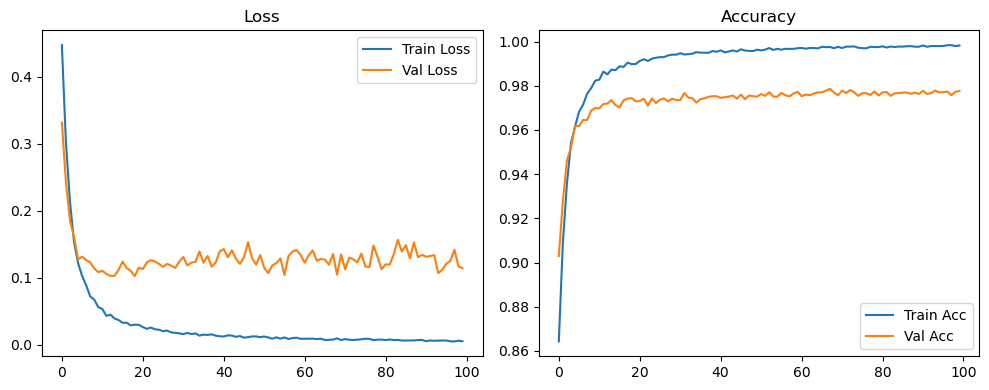

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5708, Acc: 0.8232 | Val Loss: 0.3387, Acc: 0.8996


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3928, Acc: 0.8811 | Val Loss: 0.2758, Acc: 0.9182


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3205, Acc: 0.9037 | Val Loss: 0.2252, Acc: 0.9363


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2681, Acc: 0.9208 | Val Loss: 0.1994, Acc: 0.9411


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2259, Acc: 0.9323 | Val Loss: 0.1749, Acc: 0.9495


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2034, Acc: 0.9386 | Val Loss: 0.1665, Acc: 0.9526


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1820, Acc: 0.9444 | Val Loss: 0.1607, Acc: 0.9526


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1612, Acc: 0.9519 | Val Loss: 0.1490, Acc: 0.9577


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1504, Acc: 0.9549 | Val Loss: 0.1422, Acc: 0.9587


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1383, Acc: 0.9579 | Val Loss: 0.1317, Acc: 0.9619


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1284, Acc: 0.9594 | Val Loss: 0.1414, Acc: 0.9600


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1176, Acc: 0.9632 | Val Loss: 0.1269, Acc: 0.9633


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1075, Acc: 0.9663 | Val Loss: 0.1290, Acc: 0.9656


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1057, Acc: 0.9679 | Val Loss: 0.1174, Acc: 0.9683


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0965, Acc: 0.9691 | Val Loss: 0.1309, Acc: 0.9662


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0938, Acc: 0.9706 | Val Loss: 0.1234, Acc: 0.9675


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0851, Acc: 0.9733 | Val Loss: 0.1173, Acc: 0.9673


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0805, Acc: 0.9739 | Val Loss: 0.1188, Acc: 0.9671


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0761, Acc: 0.9755 | Val Loss: 0.1144, Acc: 0.9700


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0756, Acc: 0.9757 | Val Loss: 0.1118, Acc: 0.9700


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0703, Acc: 0.9782 | Val Loss: 0.1092, Acc: 0.9702


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0656, Acc: 0.9789 | Val Loss: 0.1081, Acc: 0.9718


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9793 | Val Loss: 0.1078, Acc: 0.9716


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9808 | Val Loss: 0.1125, Acc: 0.9711


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9812 | Val Loss: 0.1078, Acc: 0.9721


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0576, Acc: 0.9815 | Val Loss: 0.1097, Acc: 0.9719


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9819 | Val Loss: 0.1150, Acc: 0.9713


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9825 | Val Loss: 0.1169, Acc: 0.9714


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9846 | Val Loss: 0.1100, Acc: 0.9730


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9842 | Val Loss: 0.1223, Acc: 0.9725


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9847 | Val Loss: 0.1063, Acc: 0.9740


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9846 | Val Loss: 0.1054, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.1139, Acc: 0.9728


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9872 | Val Loss: 0.1033, Acc: 0.9750


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9870 | Val Loss: 0.1127, Acc: 0.9737


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9869 | Val Loss: 0.1025, Acc: 0.9751


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9874 | Val Loss: 0.1074, Acc: 0.9739


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9877 | Val Loss: 0.1111, Acc: 0.9727


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9882 | Val Loss: 0.1069, Acc: 0.9749


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9890 | Val Loss: 0.1172, Acc: 0.9731


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9881 | Val Loss: 0.1103, Acc: 0.9742


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9886 | Val Loss: 0.1074, Acc: 0.9758


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9888 | Val Loss: 0.1173, Acc: 0.9739


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9883 | Val Loss: 0.1044, Acc: 0.9751


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9892 | Val Loss: 0.1048, Acc: 0.9756


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.1200, Acc: 0.9741


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9899 | Val Loss: 0.1083, Acc: 0.9753


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.1169, Acc: 0.9759


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.1177, Acc: 0.9748


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 0.1161, Acc: 0.9748


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9909 | Val Loss: 0.1198, Acc: 0.9758


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.1262, Acc: 0.9745


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.1177, Acc: 0.9745


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9912 | Val Loss: 0.1202, Acc: 0.9758


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.1102, Acc: 0.9752


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9911 | Val Loss: 0.1075, Acc: 0.9766


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.1219, Acc: 0.9746


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9918 | Val Loss: 0.1265, Acc: 0.9752


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9921 | Val Loss: 0.1257, Acc: 0.9741


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9918 | Val Loss: 0.1221, Acc: 0.9759


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9914 | Val Loss: 0.1122, Acc: 0.9759


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9920 | Val Loss: 0.1151, Acc: 0.9757


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.1179, Acc: 0.9741


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.1228, Acc: 0.9756


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.1209, Acc: 0.9757


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.1168, Acc: 0.9751


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.1077, Acc: 0.9759


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.1187, Acc: 0.9756


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.1127, Acc: 0.9768


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.1132, Acc: 0.9761


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.1156, Acc: 0.9753


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.1225, Acc: 0.9747


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.1113, Acc: 0.9753


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.1022, Acc: 0.9770


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.1172, Acc: 0.9762


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9933 | Val Loss: 0.1170, Acc: 0.9751


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.1153, Acc: 0.9762


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.1169, Acc: 0.9766


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1171, Acc: 0.9771


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.1147, Acc: 0.9768


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.1136, Acc: 0.9768


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.1202, Acc: 0.9758


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.1092, Acc: 0.9764


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.1113, Acc: 0.9777


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1265, Acc: 0.9766


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.1303, Acc: 0.9764


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.1301, Acc: 0.9757


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1200, Acc: 0.9770


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.1066, Acc: 0.9761


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1096, Acc: 0.9762


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.1071, Acc: 0.9761


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.1167, Acc: 0.9767


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1187, Acc: 0.9769


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.1462, Acc: 0.9765


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.1283, Acc: 0.9764


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.1259, Acc: 0.9769


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1276, Acc: 0.9774


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9944 | Val Loss: 0.1113, Acc: 0.9768


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.1108, Acc: 0.9768


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.1222, Acc: 0.9764


Final Test Loss: 0.1036 Accuracy: 0.9804


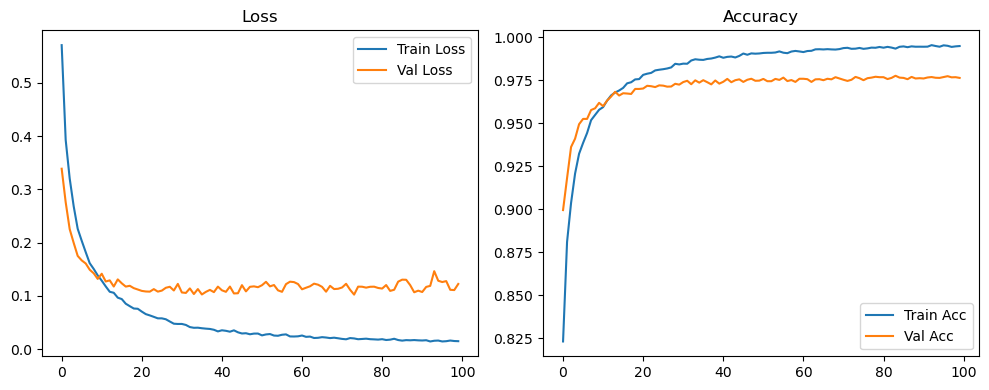

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4103, Acc: 0.8763 | Val Loss: 0.3232, Acc: 0.9062


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2441, Acc: 0.9255 | Val Loss: 0.2530, Acc: 0.9204


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1426, Acc: 0.9574 | Val Loss: 0.1543, Acc: 0.9542


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0823, Acc: 0.9743 | Val Loss: 0.1188, Acc: 0.9664


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9846 | Val Loss: 0.1146, Acc: 0.9670


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9871 | Val Loss: 0.1438, Acc: 0.9623


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.1308, Acc: 0.9672


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.1442, Acc: 0.9656


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9943 | Val Loss: 0.1283, Acc: 0.9703


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.1226, Acc: 0.9711


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9926 | Val Loss: 0.2093, Acc: 0.9546


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9944 | Val Loss: 0.1252, Acc: 0.9718


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.1386, Acc: 0.9720


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1282, Acc: 0.9731


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1366, Acc: 0.9708


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1964, Acc: 0.9604


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1638, Acc: 0.9672


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.1954, Acc: 0.9623


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9952 | Val Loss: 0.1460, Acc: 0.9718


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1781, Acc: 0.9705


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1572, Acc: 0.9725


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1638, Acc: 0.9671


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1415, Acc: 0.9748


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1595, Acc: 0.9728


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1771, Acc: 0.9701


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1335, Acc: 0.9759


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1891, Acc: 0.9704


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9971 | Val Loss: 0.1571, Acc: 0.9699


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1278, Acc: 0.9754


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1864, Acc: 0.9722


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1773, Acc: 0.9685


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1797, Acc: 0.9720


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9980 | Val Loss: 0.1321, Acc: 0.9692


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1416, Acc: 0.9737


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1634, Acc: 0.9713


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1773, Acc: 0.9683


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1391, Acc: 0.9740


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1630, Acc: 0.9720


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1704, Acc: 0.9698


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1340, Acc: 0.9730


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1428, Acc: 0.9742


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1556, Acc: 0.9759


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1819, Acc: 0.9701


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1267, Acc: 0.9768


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1315, Acc: 0.9767


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1706, Acc: 0.9741


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1420, Acc: 0.9763


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1663, Acc: 0.9728


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2434, Acc: 0.9578


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1395, Acc: 0.9751


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1209, Acc: 0.9794


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1292, Acc: 0.9801


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1325, Acc: 0.9802


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1333, Acc: 0.9799


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1344, Acc: 0.9802


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1460, Acc: 0.9799


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1479, Acc: 0.9799


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1509, Acc: 0.9796


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1499, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1506, Acc: 0.9804


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1518, Acc: 0.9802


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1620, Acc: 0.9787


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1302, Acc: 0.9801


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1383, Acc: 0.9804


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1421, Acc: 0.9809


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1432, Acc: 0.9818


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1568, Acc: 0.9770


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1476, Acc: 0.9798


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1531, Acc: 0.9780


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1653, Acc: 0.9754


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1438, Acc: 0.9767


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1558, Acc: 0.9787


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1750, Acc: 0.9771


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1442, Acc: 0.9800


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1549, Acc: 0.9803


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1577, Acc: 0.9798


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1606, Acc: 0.9769


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2280, Acc: 0.9652


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1606, Acc: 0.9782


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1475, Acc: 0.9791


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1530, Acc: 0.9788


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1522, Acc: 0.9790


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1553, Acc: 0.9797


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1559, Acc: 0.9803


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1583, Acc: 0.9803


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1618, Acc: 0.9797


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1619, Acc: 0.9799


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1635, Acc: 0.9802


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1625, Acc: 0.9805


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1653, Acc: 0.9809


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1661, Acc: 0.9808


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1756, Acc: 0.9794


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1716, Acc: 0.9803


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1707, Acc: 0.9802


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1823, Acc: 0.9794


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1807, Acc: 0.9807


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2029, Acc: 0.9786


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1857, Acc: 0.9807


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1847, Acc: 0.9795


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1744, Acc: 0.9801


Final Test Loss: 0.1550 Accuracy: 0.9818


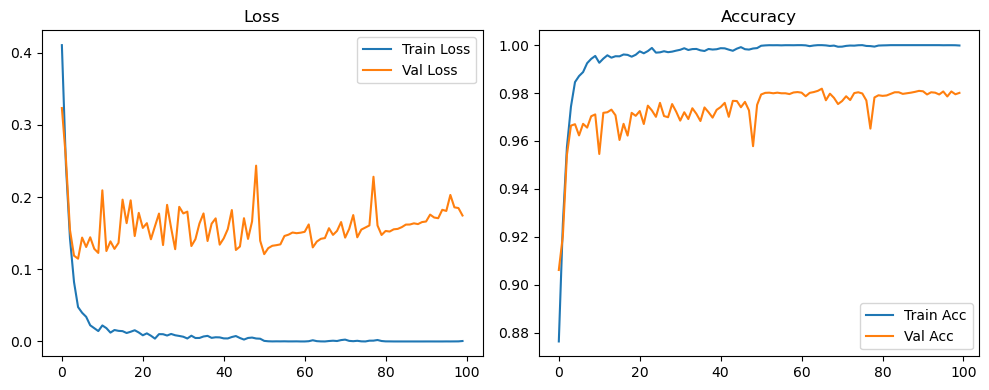

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4496, Acc: 0.8642 | Val Loss: 0.3392, Acc: 0.9007


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3012, Acc: 0.9092 | Val Loss: 0.2408, Acc: 0.9270


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2104, Acc: 0.9373 | Val Loss: 0.1851, Acc: 0.9459


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1508, Acc: 0.9531 | Val Loss: 0.1569, Acc: 0.9527


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1180, Acc: 0.9627 | Val Loss: 0.1253, Acc: 0.9633


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1021, Acc: 0.9677 | Val Loss: 0.1172, Acc: 0.9650


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0848, Acc: 0.9729 | Val Loss: 0.1201, Acc: 0.9659


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0708, Acc: 0.9774 | Val Loss: 0.1325, Acc: 0.9640


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0630, Acc: 0.9805 | Val Loss: 0.1131, Acc: 0.9689


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9825 | Val Loss: 0.1098, Acc: 0.9698


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9819 | Val Loss: 0.1050, Acc: 0.9712


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9857 | Val Loss: 0.1141, Acc: 0.9713


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9838 | Val Loss: 0.0987, Acc: 0.9740


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9872 | Val Loss: 0.1062, Acc: 0.9735


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9876 | Val Loss: 0.1061, Acc: 0.9731


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.1119, Acc: 0.9724


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9889 | Val Loss: 0.1205, Acc: 0.9714


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9899 | Val Loss: 0.1145, Acc: 0.9735


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 0.1054, Acc: 0.9735


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9911 | Val Loss: 0.1171, Acc: 0.9742


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.1091, Acc: 0.9741


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9912 | Val Loss: 0.1274, Acc: 0.9718


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9922 | Val Loss: 0.1237, Acc: 0.9731


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.1227, Acc: 0.9738


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9925 | Val Loss: 0.1173, Acc: 0.9729


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.1152, Acc: 0.9753


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.1242, Acc: 0.9744


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.1361, Acc: 0.9732


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.1174, Acc: 0.9745


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.1364, Acc: 0.9752


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9943 | Val Loss: 0.1243, Acc: 0.9744


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.1112, Acc: 0.9752


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.1139, Acc: 0.9727


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.1185, Acc: 0.9759


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 0.1326, Acc: 0.9749


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.1168, Acc: 0.9762


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9942 | Val Loss: 0.1075, Acc: 0.9762


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.1123, Acc: 0.9758


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1250, Acc: 0.9753


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.1127, Acc: 0.9763


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.1303, Acc: 0.9732


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1212, Acc: 0.9757


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1270, Acc: 0.9738


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9954 | Val Loss: 0.1161, Acc: 0.9756


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.1362, Acc: 0.9755


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1339, Acc: 0.9762


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1286, Acc: 0.9744


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1139, Acc: 0.9766


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.1273, Acc: 0.9762


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9953 | Val Loss: 0.1184, Acc: 0.9742


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1114, Acc: 0.9786


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1229, Acc: 0.9768


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1294, Acc: 0.9776


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1314, Acc: 0.9774


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1224, Acc: 0.9780


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1388, Acc: 0.9773


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1430, Acc: 0.9783


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1347, Acc: 0.9778


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1384, Acc: 0.9772


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1415, Acc: 0.9767


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1419, Acc: 0.9773


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1345, Acc: 0.9772


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.1334, Acc: 0.9772


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.1368, Acc: 0.9777


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1318, Acc: 0.9777


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1347, Acc: 0.9782


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1322, Acc: 0.9779


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1450, Acc: 0.9772


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1487, Acc: 0.9777


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1337, Acc: 0.9770


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1437, Acc: 0.9771


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1346, Acc: 0.9778


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1444, Acc: 0.9777


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1427, Acc: 0.9772


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1274, Acc: 0.9778


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1467, Acc: 0.9782


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1445, Acc: 0.9774


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1295, Acc: 0.9771


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1372, Acc: 0.9782


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1428, Acc: 0.9778


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1442, Acc: 0.9783


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1416, Acc: 0.9780


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1545, Acc: 0.9784


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1528, Acc: 0.9780


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1523, Acc: 0.9778


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1555, Acc: 0.9778


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1585, Acc: 0.9782


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1528, Acc: 0.9790


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1587, Acc: 0.9787


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1506, Acc: 0.9790


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1394, Acc: 0.9795


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1420, Acc: 0.9782


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1515, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1562, Acc: 0.9781


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1529, Acc: 0.9788


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1470, Acc: 0.9795


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1516, Acc: 0.9788


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1530, Acc: 0.9787


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1505, Acc: 0.9790


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1494, Acc: 0.9778


Final Test Loss: 0.1423 Accuracy: 0.9805


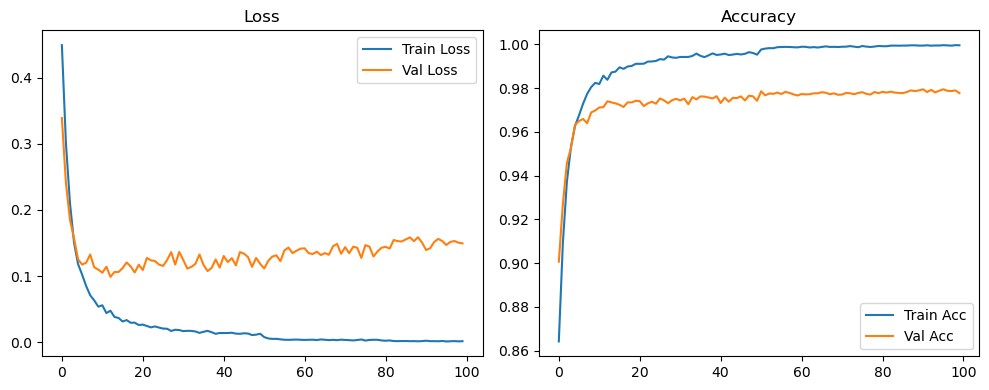

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5708, Acc: 0.8232 | Val Loss: 0.3387, Acc: 0.8996


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3928, Acc: 0.8811 | Val Loss: 0.2758, Acc: 0.9182


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3205, Acc: 0.9037 | Val Loss: 0.2252, Acc: 0.9363


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2681, Acc: 0.9208 | Val Loss: 0.1994, Acc: 0.9411


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2259, Acc: 0.9323 | Val Loss: 0.1749, Acc: 0.9495


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2034, Acc: 0.9386 | Val Loss: 0.1665, Acc: 0.9526


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1820, Acc: 0.9444 | Val Loss: 0.1607, Acc: 0.9526


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1612, Acc: 0.9519 | Val Loss: 0.1490, Acc: 0.9577


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1504, Acc: 0.9549 | Val Loss: 0.1422, Acc: 0.9587


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1383, Acc: 0.9579 | Val Loss: 0.1317, Acc: 0.9619


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1284, Acc: 0.9594 | Val Loss: 0.1414, Acc: 0.9600


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1176, Acc: 0.9632 | Val Loss: 0.1269, Acc: 0.9633


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1075, Acc: 0.9663 | Val Loss: 0.1290, Acc: 0.9656


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1057, Acc: 0.9679 | Val Loss: 0.1174, Acc: 0.9683


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0965, Acc: 0.9691 | Val Loss: 0.1309, Acc: 0.9662


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0938, Acc: 0.9706 | Val Loss: 0.1234, Acc: 0.9675


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0851, Acc: 0.9733 | Val Loss: 0.1173, Acc: 0.9673


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0805, Acc: 0.9739 | Val Loss: 0.1188, Acc: 0.9671


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0761, Acc: 0.9755 | Val Loss: 0.1144, Acc: 0.9700


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0756, Acc: 0.9757 | Val Loss: 0.1118, Acc: 0.9700


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0703, Acc: 0.9782 | Val Loss: 0.1092, Acc: 0.9702


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0656, Acc: 0.9789 | Val Loss: 0.1081, Acc: 0.9718


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9793 | Val Loss: 0.1078, Acc: 0.9716


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9808 | Val Loss: 0.1125, Acc: 0.9711


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9812 | Val Loss: 0.1078, Acc: 0.9721


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0576, Acc: 0.9815 | Val Loss: 0.1097, Acc: 0.9719


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9819 | Val Loss: 0.1150, Acc: 0.9713


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9825 | Val Loss: 0.1169, Acc: 0.9714


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9846 | Val Loss: 0.1100, Acc: 0.9730


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9842 | Val Loss: 0.1223, Acc: 0.9725


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9847 | Val Loss: 0.1063, Acc: 0.9740


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9846 | Val Loss: 0.1054, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.1139, Acc: 0.9728


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9872 | Val Loss: 0.1033, Acc: 0.9750


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9870 | Val Loss: 0.1127, Acc: 0.9737


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9869 | Val Loss: 0.1025, Acc: 0.9751


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9874 | Val Loss: 0.1074, Acc: 0.9739


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9877 | Val Loss: 0.1111, Acc: 0.9727


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9882 | Val Loss: 0.1069, Acc: 0.9749


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9890 | Val Loss: 0.1172, Acc: 0.9731


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9881 | Val Loss: 0.1103, Acc: 0.9742


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9886 | Val Loss: 0.1074, Acc: 0.9758


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9888 | Val Loss: 0.1173, Acc: 0.9739


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9883 | Val Loss: 0.1044, Acc: 0.9751


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9892 | Val Loss: 0.1048, Acc: 0.9756


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.1200, Acc: 0.9741


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9899 | Val Loss: 0.1083, Acc: 0.9753


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.1169, Acc: 0.9759


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.1177, Acc: 0.9748


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 0.1161, Acc: 0.9748


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9929 | Val Loss: 0.1212, Acc: 0.9764


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.1187, Acc: 0.9764


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.1262, Acc: 0.9767


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.1249, Acc: 0.9766


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.1221, Acc: 0.9768


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.1204, Acc: 0.9765


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9940 | Val Loss: 0.1159, Acc: 0.9762


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1297, Acc: 0.9765


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1264, Acc: 0.9759


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1281, Acc: 0.9765


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.1268, Acc: 0.9769


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.1313, Acc: 0.9763


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1225, Acc: 0.9769


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1352, Acc: 0.9765


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9959 | Val Loss: 0.1360, Acc: 0.9764


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1226, Acc: 0.9768


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1325, Acc: 0.9772


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1320, Acc: 0.9772


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1263, Acc: 0.9772


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1293, Acc: 0.9772


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.1379, Acc: 0.9768


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1299, Acc: 0.9768


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1312, Acc: 0.9763


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1326, Acc: 0.9776


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1365, Acc: 0.9779


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.1342, Acc: 0.9754


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.1352, Acc: 0.9780


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1347, Acc: 0.9769


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1265, Acc: 0.9772


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1309, Acc: 0.9773


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1339, Acc: 0.9773


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1330, Acc: 0.9774


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1321, Acc: 0.9772


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.1327, Acc: 0.9771


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1363, Acc: 0.9769


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.1389, Acc: 0.9767


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1385, Acc: 0.9773


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1368, Acc: 0.9769


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1375, Acc: 0.9770


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1441, Acc: 0.9773


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1464, Acc: 0.9763


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.1326, Acc: 0.9781


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1466, Acc: 0.9776


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1386, Acc: 0.9770


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1481, Acc: 0.9767


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1473, Acc: 0.9772


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1392, Acc: 0.9778


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1425, Acc: 0.9778


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1532, Acc: 0.9783


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1556, Acc: 0.9781


Final Test Loss: 0.1342 Accuracy: 0.9807


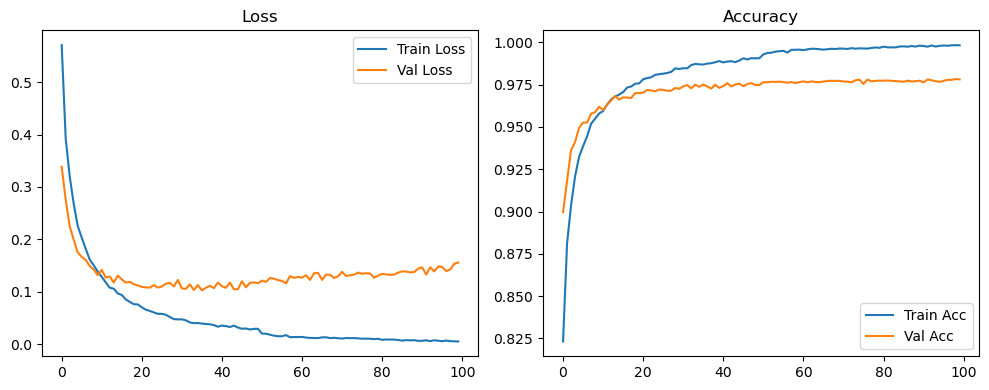

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3873, Acc: 0.8889 | Val Loss: 0.3330, Acc: 0.9034


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2513, Acc: 0.9242 | Val Loss: 0.2898, Acc: 0.9093


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1431, Acc: 0.9567 | Val Loss: 0.1435, Acc: 0.9565


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0764, Acc: 0.9761 | Val Loss: 0.1156, Acc: 0.9657


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9854 | Val Loss: 0.1308, Acc: 0.9581


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9894 | Val Loss: 0.1484, Acc: 0.9583


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9924 | Val Loss: 0.1222, Acc: 0.9663


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9943 | Val Loss: 0.1257, Acc: 0.9684


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.1137, Acc: 0.9723


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1180, Acc: 0.9721


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1291, Acc: 0.9690


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9948 | Val Loss: 0.1466, Acc: 0.9633


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.1301, Acc: 0.9683


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1475, Acc: 0.9672


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1639, Acc: 0.9626


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1304, Acc: 0.9724


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1440, Acc: 0.9693


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1540, Acc: 0.9696


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.1499, Acc: 0.9710


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1575, Acc: 0.9657


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1166, Acc: 0.9752


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.1796, Acc: 0.9647


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1460, Acc: 0.9719


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1391, Acc: 0.9732


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1312, Acc: 0.9724


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1274, Acc: 0.9739


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1697, Acc: 0.9667


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1595, Acc: 0.9713


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.3166, Acc: 0.9431


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1569, Acc: 0.9712


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9979 | Val Loss: 0.1423, Acc: 0.9748


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1861, Acc: 0.9682


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1470, Acc: 0.9737


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1427, Acc: 0.9758


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1617, Acc: 0.9721


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1620, Acc: 0.9717


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1455, Acc: 0.9762


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1687, Acc: 0.9718


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1459, Acc: 0.9758


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1560, Acc: 0.9746


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9978 | Val Loss: 0.1468, Acc: 0.9743


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1687, Acc: 0.9723


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.2799, Acc: 0.9543


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1511, Acc: 0.9750


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1451, Acc: 0.9773


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1809, Acc: 0.9708


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1933, Acc: 0.9716


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1799, Acc: 0.9711


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1787, Acc: 0.9734


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1644, Acc: 0.9761


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.2490, Acc: 0.9633


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1837, Acc: 0.9732


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1771, Acc: 0.9743


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1498, Acc: 0.9772


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1663, Acc: 0.9758


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.2325, Acc: 0.9676


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1398, Acc: 0.9768


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1390, Acc: 0.9780


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1565, Acc: 0.9768


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1384, Acc: 0.9769


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1666, Acc: 0.9763


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.2116, Acc: 0.9664


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1935, Acc: 0.9712


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.2173, Acc: 0.9682


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1564, Acc: 0.9732


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1511, Acc: 0.9776


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1471, Acc: 0.9787


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1366, Acc: 0.9797


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1416, Acc: 0.9795


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.1297, Acc: 0.9804


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1821, Acc: 0.9739


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1694, Acc: 0.9724


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1597, Acc: 0.9758


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.2045, Acc: 0.9710


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1837, Acc: 0.9723


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1579, Acc: 0.9768


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1744, Acc: 0.9753


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1343, Acc: 0.9794


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1401, Acc: 0.9782


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1487, Acc: 0.9779


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.1609, Acc: 0.9737


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1175, Acc: 0.9795


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1328, Acc: 0.9796


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1392, Acc: 0.9773


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9996 | Val Loss: 0.1346, Acc: 0.9767


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1166, Acc: 0.9798


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1311, Acc: 0.9774


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1627, Acc: 0.9725


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1713, Acc: 0.9744


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1893, Acc: 0.9729


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1649, Acc: 0.9762


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1558, Acc: 0.9782


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1511, Acc: 0.9767


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1825, Acc: 0.9730


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1338, Acc: 0.9764


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1335, Acc: 0.9794


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1489, Acc: 0.9759


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1439, Acc: 0.9765


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1420, Acc: 0.9784


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1534, Acc: 0.9773


Final Test Loss: 0.1423 Accuracy: 0.9786


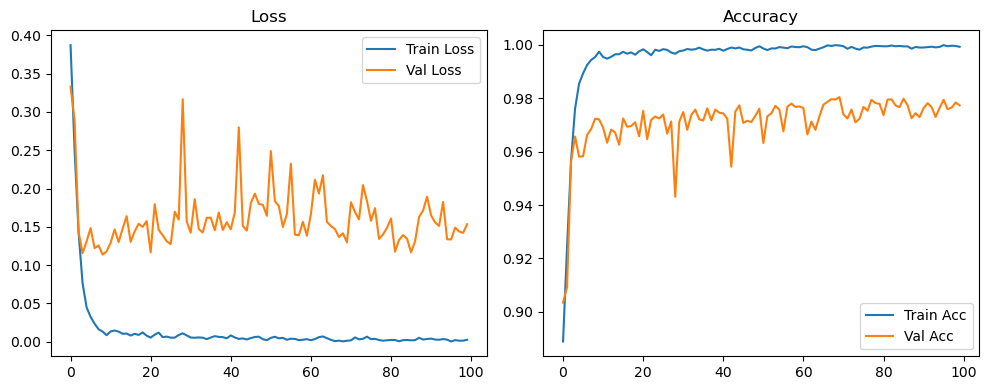

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4386, Acc: 0.8707 | Val Loss: 0.3397, Acc: 0.9028


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3056, Acc: 0.9073 | Val Loss: 0.2706, Acc: 0.9219


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2236, Acc: 0.9321 | Val Loss: 0.1950, Acc: 0.9410


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1625, Acc: 0.9509 | Val Loss: 0.1537, Acc: 0.9526


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1283, Acc: 0.9603 | Val Loss: 0.1219, Acc: 0.9625


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1097, Acc: 0.9653 | Val Loss: 0.1166, Acc: 0.9643


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0922, Acc: 0.9703 | Val Loss: 0.1166, Acc: 0.9658


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0788, Acc: 0.9743 | Val Loss: 0.1281, Acc: 0.9636


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0685, Acc: 0.9779 | Val Loss: 0.1043, Acc: 0.9699


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0619, Acc: 0.9797 | Val Loss: 0.0988, Acc: 0.9708


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0591, Acc: 0.9801 | Val Loss: 0.1131, Acc: 0.9692


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9838 | Val Loss: 0.1039, Acc: 0.9727


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0515, Acc: 0.9823 | Val Loss: 0.1115, Acc: 0.9704


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9869 | Val Loss: 0.1012, Acc: 0.9735


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9863 | Val Loss: 0.1046, Acc: 0.9712


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9874 | Val Loss: 0.1086, Acc: 0.9723


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9879 | Val Loss: 0.1116, Acc: 0.9722


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9886 | Val Loss: 0.1086, Acc: 0.9738


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9895 | Val Loss: 0.1127, Acc: 0.9735


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9891 | Val Loss: 0.1025, Acc: 0.9748


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 0.1072, Acc: 0.9744


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9904 | Val Loss: 0.1107, Acc: 0.9752


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9912 | Val Loss: 0.1165, Acc: 0.9732


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.1126, Acc: 0.9741


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1195, Acc: 0.9738


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9914 | Val Loss: 0.1120, Acc: 0.9759


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.1141, Acc: 0.9742


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9928 | Val Loss: 0.1158, Acc: 0.9772


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.1241, Acc: 0.9754


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.1192, Acc: 0.9750


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9935 | Val Loss: 0.1082, Acc: 0.9758


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.1115, Acc: 0.9759


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9939 | Val Loss: 0.1219, Acc: 0.9746


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.1253, Acc: 0.9738


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.1185, Acc: 0.9742


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.1134, Acc: 0.9762


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.1064, Acc: 0.9767


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.1145, Acc: 0.9754


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9949 | Val Loss: 0.1289, Acc: 0.9748


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.1234, Acc: 0.9753


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.1247, Acc: 0.9751


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.1206, Acc: 0.9758


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.1437, Acc: 0.9732


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.1284, Acc: 0.9750


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1194, Acc: 0.9769


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9956 | Val Loss: 0.1322, Acc: 0.9748


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.1291, Acc: 0.9764


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.1198, Acc: 0.9765


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1307, Acc: 0.9747


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.1164, Acc: 0.9759


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1143, Acc: 0.9751


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.1319, Acc: 0.9748


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1291, Acc: 0.9762


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1310, Acc: 0.9776


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1346, Acc: 0.9752


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1212, Acc: 0.9768


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1181, Acc: 0.9776


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9965 | Val Loss: 0.1349, Acc: 0.9760


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.1261, Acc: 0.9748


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1422, Acc: 0.9731


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1293, Acc: 0.9762


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1176, Acc: 0.9756


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1404, Acc: 0.9745


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1291, Acc: 0.9766


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1291, Acc: 0.9772


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.1390, Acc: 0.9767


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.1357, Acc: 0.9773


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1403, Acc: 0.9749


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1285, Acc: 0.9757


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1227, Acc: 0.9768


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1292, Acc: 0.9776


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1272, Acc: 0.9770


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1331, Acc: 0.9775


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1304, Acc: 0.9782


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1332, Acc: 0.9776


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1302, Acc: 0.9755


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1210, Acc: 0.9768


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1216, Acc: 0.9788


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1205, Acc: 0.9774


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.1296, Acc: 0.9768


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.1227, Acc: 0.9778


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1283, Acc: 0.9771


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.1405, Acc: 0.9766


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1215, Acc: 0.9778


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1251, Acc: 0.9773


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1274, Acc: 0.9786


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1187, Acc: 0.9779


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1228, Acc: 0.9764


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1219, Acc: 0.9777


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1344, Acc: 0.9777


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.1353, Acc: 0.9761


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1353, Acc: 0.9755


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1273, Acc: 0.9762


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1444, Acc: 0.9761


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1290, Acc: 0.9778


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1311, Acc: 0.9766


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1414, Acc: 0.9753


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1399, Acc: 0.9768


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1317, Acc: 0.9766


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1374, Acc: 0.9769


Final Test Loss: 0.1086 Accuracy: 0.9801


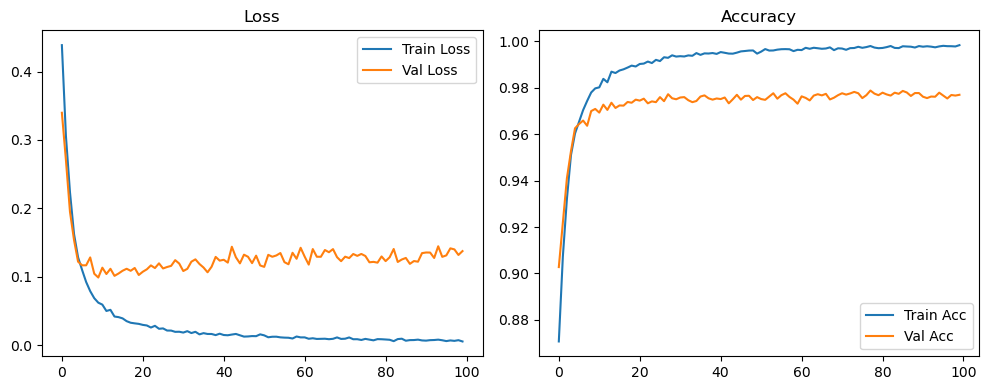

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5946, Acc: 0.8193 | Val Loss: 0.3434, Acc: 0.8992


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.4051, Acc: 0.8761 | Val Loss: 0.2981, Acc: 0.9121


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.3490, Acc: 0.8939 | Val Loss: 0.2544, Acc: 0.9249


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2991, Acc: 0.9104 | Val Loss: 0.2298, Acc: 0.9296


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.2629, Acc: 0.9202 | Val Loss: 0.1947, Acc: 0.9410


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.2361, Acc: 0.9287 | Val Loss: 0.1793, Acc: 0.9457


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.2155, Acc: 0.9335 | Val Loss: 0.1718, Acc: 0.9473


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1939, Acc: 0.9417 | Val Loss: 0.1639, Acc: 0.9535


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1844, Acc: 0.9429 | Val Loss: 0.1562, Acc: 0.9547


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1704, Acc: 0.9481 | Val Loss: 0.1429, Acc: 0.9573


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1602, Acc: 0.9498 | Val Loss: 0.1490, Acc: 0.9570


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1496, Acc: 0.9535 | Val Loss: 0.1393, Acc: 0.9603


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1410, Acc: 0.9568 | Val Loss: 0.1390, Acc: 0.9613


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1367, Acc: 0.9577 | Val Loss: 0.1315, Acc: 0.9633


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1298, Acc: 0.9597 | Val Loss: 0.1350, Acc: 0.9613


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1254, Acc: 0.9604 | Val Loss: 0.1309, Acc: 0.9636


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1185, Acc: 0.9622 | Val Loss: 0.1348, Acc: 0.9623


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1100, Acc: 0.9657 | Val Loss: 0.1344, Acc: 0.9626


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1067, Acc: 0.9666 | Val Loss: 0.1248, Acc: 0.9664


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1060, Acc: 0.9665 | Val Loss: 0.1257, Acc: 0.9653


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0987, Acc: 0.9688 | Val Loss: 0.1245, Acc: 0.9653


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0980, Acc: 0.9692 | Val Loss: 0.1196, Acc: 0.9675


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0905, Acc: 0.9704 | Val Loss: 0.1208, Acc: 0.9663


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0885, Acc: 0.9715 | Val Loss: 0.1222, Acc: 0.9680


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0848, Acc: 0.9734 | Val Loss: 0.1207, Acc: 0.9678


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0849, Acc: 0.9734 | Val Loss: 0.1212, Acc: 0.9689


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0802, Acc: 0.9745 | Val Loss: 0.1229, Acc: 0.9673


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0766, Acc: 0.9754 | Val Loss: 0.1276, Acc: 0.9671


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0762, Acc: 0.9760 | Val Loss: 0.1221, Acc: 0.9696


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0714, Acc: 0.9783 | Val Loss: 0.1312, Acc: 0.9681


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0710, Acc: 0.9772 | Val Loss: 0.1203, Acc: 0.9688


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0673, Acc: 0.9780 | Val Loss: 0.1179, Acc: 0.9686


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0665, Acc: 0.9783 | Val Loss: 0.1216, Acc: 0.9685


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0640, Acc: 0.9792 | Val Loss: 0.1212, Acc: 0.9688


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0608, Acc: 0.9797 | Val Loss: 0.1245, Acc: 0.9692


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0614, Acc: 0.9801 | Val Loss: 0.1201, Acc: 0.9702


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0604, Acc: 0.9804 | Val Loss: 0.1221, Acc: 0.9706


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0582, Acc: 0.9814 | Val Loss: 0.1180, Acc: 0.9705


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0565, Acc: 0.9814 | Val Loss: 0.1148, Acc: 0.9703


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0562, Acc: 0.9816 | Val Loss: 0.1233, Acc: 0.9706


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0546, Acc: 0.9822 | Val Loss: 0.1214, Acc: 0.9699


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9833 | Val Loss: 0.1217, Acc: 0.9719


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0540, Acc: 0.9824 | Val Loss: 0.1220, Acc: 0.9706


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9837 | Val Loss: 0.1206, Acc: 0.9716


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0510, Acc: 0.9832 | Val Loss: 0.1240, Acc: 0.9714


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0467, Acc: 0.9845 | Val Loss: 0.1205, Acc: 0.9705


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.1253, Acc: 0.9717


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9855 | Val Loss: 0.1249, Acc: 0.9719


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9853 | Val Loss: 0.1228, Acc: 0.9718


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0447, Acc: 0.9851 | Val Loss: 0.1259, Acc: 0.9712


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9850 | Val Loss: 0.1301, Acc: 0.9710


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9845 | Val Loss: 0.1282, Acc: 0.9704


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0448, Acc: 0.9847 | Val Loss: 0.1264, Acc: 0.9712


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9857 | Val Loss: 0.1317, Acc: 0.9706


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9863 | Val Loss: 0.1203, Acc: 0.9722


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9873 | Val Loss: 0.1279, Acc: 0.9718


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9865 | Val Loss: 0.1241, Acc: 0.9720


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9872 | Val Loss: 0.1229, Acc: 0.9718


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9873 | Val Loss: 0.1332, Acc: 0.9722


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0376, Acc: 0.9874 | Val Loss: 0.1208, Acc: 0.9731


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9872 | Val Loss: 0.1285, Acc: 0.9724


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9879 | Val Loss: 0.1222, Acc: 0.9710


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9880 | Val Loss: 0.1287, Acc: 0.9718


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9883 | Val Loss: 0.1247, Acc: 0.9729


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9893 | Val Loss: 0.1296, Acc: 0.9720


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9882 | Val Loss: 0.1291, Acc: 0.9712


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9893 | Val Loss: 0.1283, Acc: 0.9733


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9893 | Val Loss: 0.1285, Acc: 0.9725


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9885 | Val Loss: 0.1265, Acc: 0.9722


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9902 | Val Loss: 0.1273, Acc: 0.9736


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9891 | Val Loss: 0.1191, Acc: 0.9732


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9903 | Val Loss: 0.1295, Acc: 0.9741


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9901 | Val Loss: 0.1258, Acc: 0.9735


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9903 | Val Loss: 0.1221, Acc: 0.9731


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9899 | Val Loss: 0.1273, Acc: 0.9732


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9897 | Val Loss: 0.1199, Acc: 0.9731


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.1232, Acc: 0.9732


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9907 | Val Loss: 0.1323, Acc: 0.9722


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.1193, Acc: 0.9744


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9902 | Val Loss: 0.1278, Acc: 0.9730


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9907 | Val Loss: 0.1305, Acc: 0.9724


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9907 | Val Loss: 0.1288, Acc: 0.9741


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9917 | Val Loss: 0.1327, Acc: 0.9735


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9912 | Val Loss: 0.1356, Acc: 0.9732


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.1243, Acc: 0.9734


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9908 | Val Loss: 0.1315, Acc: 0.9732


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9903 | Val Loss: 0.1301, Acc: 0.9735


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9914 | Val Loss: 0.1296, Acc: 0.9741


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9918 | Val Loss: 0.1371, Acc: 0.9735


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9914 | Val Loss: 0.1316, Acc: 0.9744


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.1316, Acc: 0.9742


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9918 | Val Loss: 0.1283, Acc: 0.9727


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9917 | Val Loss: 0.1308, Acc: 0.9739


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.1318, Acc: 0.9736


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9912 | Val Loss: 0.1308, Acc: 0.9745


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.1310, Acc: 0.9734


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9916 | Val Loss: 0.1316, Acc: 0.9745


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.1317, Acc: 0.9742


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.1293, Acc: 0.9747


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.1396, Acc: 0.9736


Final Test Loss: 0.1238 Accuracy: 0.9768


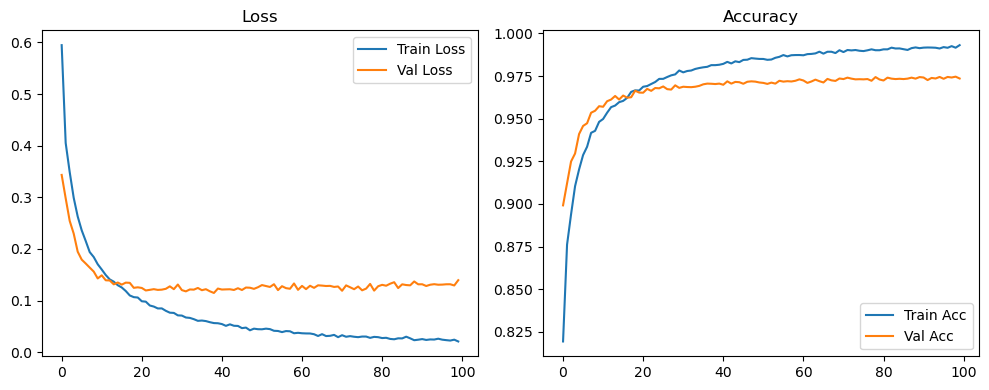

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4003, Acc: 0.8896 | Val Loss: 0.3181, Acc: 0.9068


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2590, Acc: 0.9226 | Val Loss: 0.2367, Acc: 0.9310


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1540, Acc: 0.9527 | Val Loss: 0.1594, Acc: 0.9510


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0821, Acc: 0.9746 | Val Loss: 0.1127, Acc: 0.9647


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9863 | Val Loss: 0.1110, Acc: 0.9644


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9924 | Val Loss: 0.1051, Acc: 0.9688


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9950 | Val Loss: 0.0969, Acc: 0.9712


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.1172, Acc: 0.9681


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0996, Acc: 0.9729


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9976 | Val Loss: 0.0966, Acc: 0.9732


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1707, Acc: 0.9597


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1266, Acc: 0.9673


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1050, Acc: 0.9732


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.1258, Acc: 0.9688


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9965 | Val Loss: 0.1162, Acc: 0.9732


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1308, Acc: 0.9686


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1165, Acc: 0.9728


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1042, Acc: 0.9748


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1165, Acc: 0.9729


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1097, Acc: 0.9759


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1091, Acc: 0.9763


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1300, Acc: 0.9722


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1794, Acc: 0.9615


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1249, Acc: 0.9728


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1280, Acc: 0.9747


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1190, Acc: 0.9751


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1189, Acc: 0.9759


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1159, Acc: 0.9761


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1771, Acc: 0.9641


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1517, Acc: 0.9697


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1258, Acc: 0.9758


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1204, Acc: 0.9767


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1230, Acc: 0.9767


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9978 | Val Loss: 0.1258, Acc: 0.9762


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1199, Acc: 0.9780


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1399, Acc: 0.9718


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1485, Acc: 0.9719


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1531, Acc: 0.9721


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1100, Acc: 0.9794


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1260, Acc: 0.9755


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1335, Acc: 0.9748


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1462, Acc: 0.9718


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1589, Acc: 0.9686


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1338, Acc: 0.9752


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1215, Acc: 0.9769


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1214, Acc: 0.9774


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1263, Acc: 0.9773


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1160, Acc: 0.9772


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1439, Acc: 0.9737


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1594, Acc: 0.9725


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1546, Acc: 0.9723


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1292, Acc: 0.9780


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1274, Acc: 0.9773


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1329, Acc: 0.9770


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1449, Acc: 0.9757


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1657, Acc: 0.9723


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1416, Acc: 0.9752


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1411, Acc: 0.9752


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1357, Acc: 0.9773


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1250, Acc: 0.9803


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1422, Acc: 0.9765


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1478, Acc: 0.9753


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1807, Acc: 0.9711


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1538, Acc: 0.9736


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1282, Acc: 0.9783


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1436, Acc: 0.9749


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1376, Acc: 0.9772


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.2346, Acc: 0.9657


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1654, Acc: 0.9715


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1393, Acc: 0.9780


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1399, Acc: 0.9768


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1364, Acc: 0.9793


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1648, Acc: 0.9738


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1413, Acc: 0.9772


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1425, Acc: 0.9776


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9993 | Val Loss: 0.1492, Acc: 0.9751


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1671, Acc: 0.9736


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1283, Acc: 0.9773


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9994 | Val Loss: 0.1970, Acc: 0.9687


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1687, Acc: 0.9731


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1802, Acc: 0.9719


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1943, Acc: 0.9696


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.1437, Acc: 0.9763


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1566, Acc: 0.9768


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1364, Acc: 0.9783


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1341, Acc: 0.9791


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1391, Acc: 0.9796


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1539, Acc: 0.9763


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1578, Acc: 0.9756


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1533, Acc: 0.9764


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1342, Acc: 0.9791


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1549, Acc: 0.9756


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1372, Acc: 0.9794


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1499, Acc: 0.9777


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1650, Acc: 0.9763


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.2237, Acc: 0.9677


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.2048, Acc: 0.9706


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1602, Acc: 0.9746


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1354, Acc: 0.9785


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1436, Acc: 0.9798


Final Test Loss: 0.1334 Accuracy: 0.9792


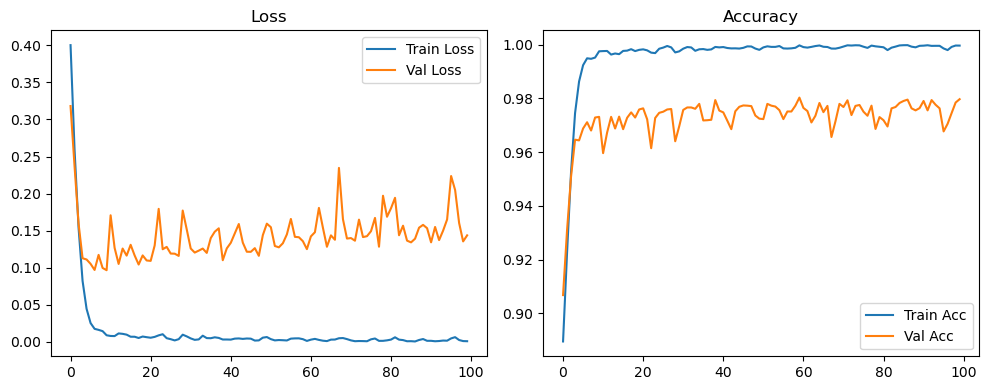

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4712, Acc: 0.8681 | Val Loss: 0.3246, Acc: 0.9048


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3164, Acc: 0.9048 | Val Loss: 0.2821, Acc: 0.9173


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2433, Acc: 0.9272 | Val Loss: 0.2145, Acc: 0.9349


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1822, Acc: 0.9452 | Val Loss: 0.1554, Acc: 0.9512


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1452, Acc: 0.9546 | Val Loss: 0.1299, Acc: 0.9596


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1215, Acc: 0.9617 | Val Loss: 0.1173, Acc: 0.9640


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1048, Acc: 0.9670 | Val Loss: 0.1170, Acc: 0.9643


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0886, Acc: 0.9711 | Val Loss: 0.1100, Acc: 0.9671


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0761, Acc: 0.9752 | Val Loss: 0.1067, Acc: 0.9682


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0720, Acc: 0.9762 | Val Loss: 0.1069, Acc: 0.9676


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0684, Acc: 0.9768 | Val Loss: 0.1066, Acc: 0.9679


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0556, Acc: 0.9817 | Val Loss: 0.1011, Acc: 0.9719


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0553, Acc: 0.9813 | Val Loss: 0.1058, Acc: 0.9701


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0496, Acc: 0.9838 | Val Loss: 0.1031, Acc: 0.9714


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0475, Acc: 0.9837 | Val Loss: 0.0982, Acc: 0.9726


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0417, Acc: 0.9861 | Val Loss: 0.0941, Acc: 0.9740


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0393, Acc: 0.9870 | Val Loss: 0.1066, Acc: 0.9705


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0399, Acc: 0.9862 | Val Loss: 0.1014, Acc: 0.9728


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9878 | Val Loss: 0.0971, Acc: 0.9740


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9882 | Val Loss: 0.0959, Acc: 0.9753


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9890 | Val Loss: 0.1059, Acc: 0.9721


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9897 | Val Loss: 0.0991, Acc: 0.9746


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.1042, Acc: 0.9730


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9899 | Val Loss: 0.1019, Acc: 0.9745


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9907 | Val Loss: 0.1158, Acc: 0.9728


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.1058, Acc: 0.9753


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9909 | Val Loss: 0.1043, Acc: 0.9748


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9915 | Val Loss: 0.1099, Acc: 0.9745


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9921 | Val Loss: 0.1095, Acc: 0.9743


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9927 | Val Loss: 0.1097, Acc: 0.9742


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1007, Acc: 0.9766


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9923 | Val Loss: 0.1023, Acc: 0.9755


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9937 | Val Loss: 0.1067, Acc: 0.9765


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9941 | Val Loss: 0.1175, Acc: 0.9739


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9941 | Val Loss: 0.1123, Acc: 0.9764


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9931 | Val Loss: 0.1123, Acc: 0.9768


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9941 | Val Loss: 0.1099, Acc: 0.9761


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.1173, Acc: 0.9738


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9941 | Val Loss: 0.1074, Acc: 0.9770


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1205, Acc: 0.9749


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9938 | Val Loss: 0.1113, Acc: 0.9761


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.1064, Acc: 0.9765


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9945 | Val Loss: 0.1168, Acc: 0.9762


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.1161, Acc: 0.9758


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.1129, Acc: 0.9772


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.1200, Acc: 0.9756


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1181, Acc: 0.9761


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.1313, Acc: 0.9754


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1151, Acc: 0.9769


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9951 | Val Loss: 0.1228, Acc: 0.9742


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.1123, Acc: 0.9773


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1221, Acc: 0.9752


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.1201, Acc: 0.9751


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1248, Acc: 0.9754


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.1164, Acc: 0.9763


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1176, Acc: 0.9761


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.1193, Acc: 0.9754


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9965 | Val Loss: 0.1283, Acc: 0.9755


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1260, Acc: 0.9767


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.1237, Acc: 0.9748


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1261, Acc: 0.9746


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1196, Acc: 0.9763


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1338, Acc: 0.9738


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1284, Acc: 0.9757


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1328, Acc: 0.9756


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1243, Acc: 0.9769


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1313, Acc: 0.9763


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1312, Acc: 0.9748


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.1279, Acc: 0.9774


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1276, Acc: 0.9770


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1256, Acc: 0.9761


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1229, Acc: 0.9774


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1341, Acc: 0.9740


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1238, Acc: 0.9763


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1219, Acc: 0.9776


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1289, Acc: 0.9754


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1155, Acc: 0.9776


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1277, Acc: 0.9771


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1222, Acc: 0.9770


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1261, Acc: 0.9779


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1182, Acc: 0.9772


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1226, Acc: 0.9773


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1318, Acc: 0.9766


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1268, Acc: 0.9767


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.1292, Acc: 0.9760


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1354, Acc: 0.9762


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1323, Acc: 0.9778


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1396, Acc: 0.9761


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1296, Acc: 0.9766


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1387, Acc: 0.9759


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1247, Acc: 0.9778


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1287, Acc: 0.9774


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1286, Acc: 0.9776


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1269, Acc: 0.9768


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.1321, Acc: 0.9768


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1231, Acc: 0.9764


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1320, Acc: 0.9762


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1300, Acc: 0.9773


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1236, Acc: 0.9761


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1273, Acc: 0.9776


Final Test Loss: 0.1249 Accuracy: 0.9781


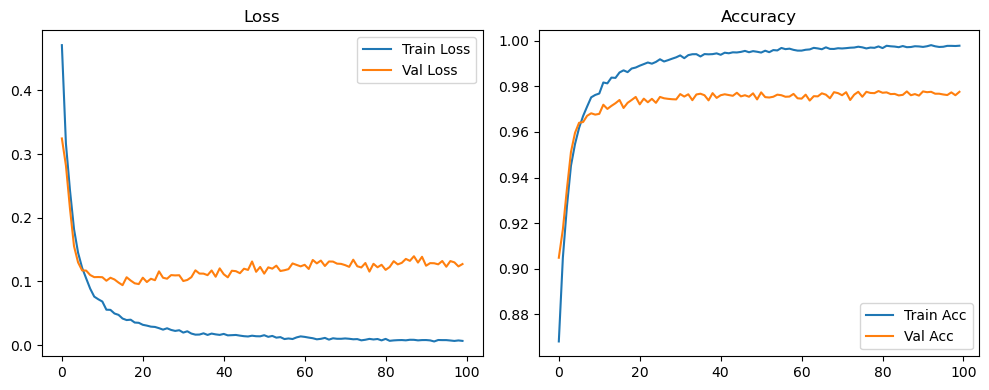

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6696, Acc: 0.8032 | Val Loss: 0.3448, Acc: 0.8975


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.4206, Acc: 0.8706 | Val Loss: 0.3088, Acc: 0.9074


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.3657, Acc: 0.8888 | Val Loss: 0.2689, Acc: 0.9206


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.3209, Acc: 0.9036 | Val Loss: 0.2403, Acc: 0.9256


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2875, Acc: 0.9125 | Val Loss: 0.2120, Acc: 0.9366


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2595, Acc: 0.9207 | Val Loss: 0.1924, Acc: 0.9411


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.2387, Acc: 0.9260 | Val Loss: 0.1824, Acc: 0.9436


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.2156, Acc: 0.9344 | Val Loss: 0.1685, Acc: 0.9498


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.2044, Acc: 0.9375 | Val Loss: 0.1627, Acc: 0.9519


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1919, Acc: 0.9411 | Val Loss: 0.1536, Acc: 0.9526


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1842, Acc: 0.9436 | Val Loss: 0.1572, Acc: 0.9536


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1722, Acc: 0.9461 | Val Loss: 0.1437, Acc: 0.9568


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1599, Acc: 0.9500 | Val Loss: 0.1432, Acc: 0.9583


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1587, Acc: 0.9502 | Val Loss: 0.1341, Acc: 0.9619


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1486, Acc: 0.9540 | Val Loss: 0.1388, Acc: 0.9588


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1448, Acc: 0.9550 | Val Loss: 0.1343, Acc: 0.9609


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1334, Acc: 0.9577 | Val Loss: 0.1370, Acc: 0.9607


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1298, Acc: 0.9595 | Val Loss: 0.1374, Acc: 0.9622


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1263, Acc: 0.9606 | Val Loss: 0.1272, Acc: 0.9642


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1236, Acc: 0.9603 | Val Loss: 0.1249, Acc: 0.9646


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1159, Acc: 0.9626 | Val Loss: 0.1282, Acc: 0.9637


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1157, Acc: 0.9624 | Val Loss: 0.1271, Acc: 0.9648


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1077, Acc: 0.9649 | Val Loss: 0.1254, Acc: 0.9653


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1066, Acc: 0.9659 | Val Loss: 0.1233, Acc: 0.9651


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.1032, Acc: 0.9677 | Val Loss: 0.1255, Acc: 0.9659


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.1003, Acc: 0.9684 | Val Loss: 0.1241, Acc: 0.9658


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0983, Acc: 0.9701 | Val Loss: 0.1226, Acc: 0.9663


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0894, Acc: 0.9713 | Val Loss: 0.1240, Acc: 0.9668


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0938, Acc: 0.9705 | Val Loss: 0.1256, Acc: 0.9673


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0868, Acc: 0.9725 | Val Loss: 0.1261, Acc: 0.9669


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0848, Acc: 0.9726 | Val Loss: 0.1239, Acc: 0.9668


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0837, Acc: 0.9727 | Val Loss: 0.1207, Acc: 0.9676


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0809, Acc: 0.9735 | Val Loss: 0.1251, Acc: 0.9681


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0805, Acc: 0.9738 | Val Loss: 0.1271, Acc: 0.9650


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0773, Acc: 0.9742 | Val Loss: 0.1248, Acc: 0.9677


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0743, Acc: 0.9754 | Val Loss: 0.1253, Acc: 0.9688


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0743, Acc: 0.9752 | Val Loss: 0.1250, Acc: 0.9679


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0730, Acc: 0.9770 | Val Loss: 0.1243, Acc: 0.9684


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0696, Acc: 0.9778 | Val Loss: 0.1229, Acc: 0.9683


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0680, Acc: 0.9783 | Val Loss: 0.1265, Acc: 0.9690


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0652, Acc: 0.9795 | Val Loss: 0.1260, Acc: 0.9677


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0659, Acc: 0.9783 | Val Loss: 0.1245, Acc: 0.9695


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0661, Acc: 0.9783 | Val Loss: 0.1272, Acc: 0.9694


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0633, Acc: 0.9797 | Val Loss: 0.1210, Acc: 0.9712


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0616, Acc: 0.9794 | Val Loss: 0.1286, Acc: 0.9698


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0577, Acc: 0.9807 | Val Loss: 0.1274, Acc: 0.9691


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0586, Acc: 0.9812 | Val Loss: 0.1349, Acc: 0.9685


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0567, Acc: 0.9811 | Val Loss: 0.1262, Acc: 0.9699


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0571, Acc: 0.9809 | Val Loss: 0.1311, Acc: 0.9688


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0575, Acc: 0.9808 | Val Loss: 0.1319, Acc: 0.9696


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0582, Acc: 0.9808 | Val Loss: 0.1260, Acc: 0.9695


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0546, Acc: 0.9821 | Val Loss: 0.1296, Acc: 0.9695


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0533, Acc: 0.9819 | Val Loss: 0.1286, Acc: 0.9697


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0538, Acc: 0.9820 | Val Loss: 0.1305, Acc: 0.9699


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0521, Acc: 0.9832 | Val Loss: 0.1259, Acc: 0.9705


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9834 | Val Loss: 0.1291, Acc: 0.9704


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0507, Acc: 0.9832 | Val Loss: 0.1321, Acc: 0.9693


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9836 | Val Loss: 0.1270, Acc: 0.9701


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0475, Acc: 0.9840 | Val Loss: 0.1327, Acc: 0.9703


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9838 | Val Loss: 0.1305, Acc: 0.9695


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0447, Acc: 0.9847 | Val Loss: 0.1297, Acc: 0.9704


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9842 | Val Loss: 0.1294, Acc: 0.9708


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0459, Acc: 0.9843 | Val Loss: 0.1363, Acc: 0.9692


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9855 | Val Loss: 0.1297, Acc: 0.9711


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9866 | Val Loss: 0.1341, Acc: 0.9705


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9864 | Val Loss: 0.1328, Acc: 0.9707


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9861 | Val Loss: 0.1303, Acc: 0.9725


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9851 | Val Loss: 0.1315, Acc: 0.9709


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9866 | Val Loss: 0.1310, Acc: 0.9721


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9866 | Val Loss: 0.1296, Acc: 0.9713


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9872 | Val Loss: 0.1328, Acc: 0.9712


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9872 | Val Loss: 0.1362, Acc: 0.9714


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9869 | Val Loss: 0.1340, Acc: 0.9705


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0384, Acc: 0.9870 | Val Loss: 0.1301, Acc: 0.9722


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9882 | Val Loss: 0.1322, Acc: 0.9715


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9878 | Val Loss: 0.1373, Acc: 0.9716


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9874 | Val Loss: 0.1318, Acc: 0.9715


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9880 | Val Loss: 0.1390, Acc: 0.9700


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9875 | Val Loss: 0.1341, Acc: 0.9716


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9882 | Val Loss: 0.1341, Acc: 0.9704


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9878 | Val Loss: 0.1358, Acc: 0.9715


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9883 | Val Loss: 0.1326, Acc: 0.9712


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.1325, Acc: 0.9716


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.1298, Acc: 0.9712


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9884 | Val Loss: 0.1364, Acc: 0.9718


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.1367, Acc: 0.9725


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.1413, Acc: 0.9718


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.1347, Acc: 0.9725


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9896 | Val Loss: 0.1366, Acc: 0.9722


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9898 | Val Loss: 0.1433, Acc: 0.9710


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9894 | Val Loss: 0.1371, Acc: 0.9727


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9895 | Val Loss: 0.1380, Acc: 0.9721


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9894 | Val Loss: 0.1407, Acc: 0.9718


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9896 | Val Loss: 0.1402, Acc: 0.9713


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 0.1399, Acc: 0.9722


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.1398, Acc: 0.9714


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9901 | Val Loss: 0.1401, Acc: 0.9718


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9902 | Val Loss: 0.1416, Acc: 0.9722


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.1401, Acc: 0.9720


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9901 | Val Loss: 0.1376, Acc: 0.9723


Final Test Loss: 0.1106 Accuracy: 0.9757


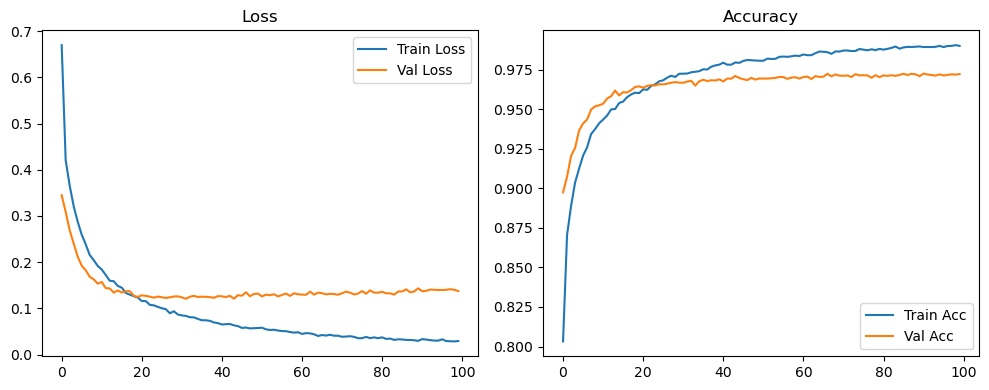

🏆 Best Config: batch64_lr0.01_0.005_0.001_dp0.5 Accuracy: 0.9845


In [8]:
root_path = "MLP_1024_4bit_regular_Sigmoid"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)